In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# Load data
df01 =  pd.read_csv("cleansed_date01.csv")
pd.options.display.max_columns = None

In [3]:
df01

,Transaction Date,ATM Name,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,2011-01-01,Mount Road ATM,253,67,186,767900,270900,497000,Saturday,C,H,WHH
1,2011-01-01,Big Street ATM,50,20,30,123800,41700,82100,Saturday,H,H,WHH
2,2011-01-01,Airport ATM,98,56,42,503400,347700,155700,Saturday,C,H,WHH
3,2011-01-01,KK Nagar ATM,265,159,106,945300,532600,412700,Saturday,C,H,WHH
4,2011-01-01,Christ College ATM,74,25,49,287700,148200,139500,Saturday,C,H,WHH
...,...,...,...,...,...,...,...,...,...,...,...,...
11584,2017-09-29,Airport ATM,117,77,40,709900,576800,133100,FRIDAY,H,H,WHH
11585,2017-09-29,Christ College ATM,143,61,82,700400,364200,336200,FRIDAY,H,H,WHH
11586,2017-09-29,Big Street ATM,137,34,103,468800,146200,322600,FRIDAY,H,H,WHH
11587,2017-09-29,Mount Road ATM,79,27,52,305100,172500,132600,FRIDAY,H,H,WHH


In [4]:
# Convert Transaction Date into Date form
df01['Transaction Date'] = pd.to_datetime(df01['Transaction Date'], infer_datetime_format=True)

In [5]:
df01 = df01[(df01["ATM Name"]=="Big Street ATM")]

In [6]:
df01 = df01.drop('ATM Name', 1)

In [7]:
df01["Weekday"] = df01["Weekday"].replace({"Saturday": "SATURDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Monday": "MONDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Tuesday": "TUESDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Wednesday": "WEDNESDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Thursday": "THURSDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Friday": "FRIDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Sunday": "SUNDAY"})

In [8]:
df01["Weekday"].value_counts()

SUNDAY       549
SATURDAY     334
TUESDAY      305
MONDAY       295
WEDNESDAY    294
THURSDAY     289
FRIDAY       288
Name: Weekday, dtype: int64

In [9]:
# Transnform date into index
data = df01.drop(['Transaction Date'], axis=1)
data.index = df01["Transaction Date"]

In [10]:
data = data.sort_index()

In [11]:
df01 = data

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [13]:
df01['Weekday'] = le.fit_transform(df01['Weekday'])

In [14]:
df01['Festival Religion'] = le.fit_transform(df01['Festival Religion'])

In [15]:
df01['Working Day'] = le.fit_transform(df01['Working Day'])

In [16]:
df01['Holiday Sequence'] = le.fit_transform(df01['Holiday Sequence'])

In [17]:
df01

,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,,,,,,
2011-01-01,50,20,30,123800,41700,82100,2,1,0,4
2011-01-02,17,5,12,52800,20900,31900,3,4,0,1
2011-01-03,24,21,3,88100,77100,11000,1,4,1,7
2011-01-04,34,12,22,101600,51200,50400,5,4,1,7
2011-01-05,30,14,16,98000,52700,45300,6,4,1,7
...,...,...,...,...,...,...,...,...,...,...
2017-09-25,122,41,81,513800,283000,230800,1,4,1,3
2017-09-26,131,36,95,437400,162700,274700,5,4,1,7
2017-09-27,130,40,90,511200,215000,296200,6,4,1,7


In [18]:
data = df01

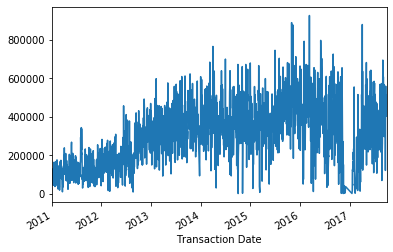

In [19]:
data["Total amount Withdrawn"].plot()

In [20]:
data01 = data.copy()

In [21]:
data01["Working Day"].value_counts()

1    1342
0    1012
Name: Working Day, dtype: int64

In [22]:
columns_to_category = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence']
data01[columns_to_category] = data01[columns_to_category].astype('category') # change datetypes to category

In [23]:
data01.dtypes[:]

No Of Withdrawals                  int64
No Of XYZ Card Withdrawals         int64
No Of Other Card Withdrawals       int64
Total amount Withdrawn             int64
Amount withdrawn XYZ Card          int64
Amount withdrawn Other Card        int64
Weekday                         category
Festival Religion               category
Working Day                     category
Holiday Sequence                category
dtype: object

In [24]:
data01

,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,,,,,,
2011-01-01,50,20,30,123800,41700,82100,2,1,0,4
2011-01-02,17,5,12,52800,20900,31900,3,4,0,1
2011-01-03,24,21,3,88100,77100,11000,1,4,1,7
2011-01-04,34,12,22,101600,51200,50400,5,4,1,7
2011-01-05,30,14,16,98000,52700,45300,6,4,1,7
...,...,...,...,...,...,...,...,...,...,...
2017-09-25,122,41,81,513800,283000,230800,1,4,1,3
2017-09-26,131,36,95,437400,162700,274700,5,4,1,7
2017-09-27,130,40,90,511200,215000,296200,6,4,1,7


In [25]:
df01

,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,,,,,,
2011-01-01,50,20,30,123800,41700,82100,2,1,0,4
2011-01-02,17,5,12,52800,20900,31900,3,4,0,1
2011-01-03,24,21,3,88100,77100,11000,1,4,1,7
2011-01-04,34,12,22,101600,51200,50400,5,4,1,7
2011-01-05,30,14,16,98000,52700,45300,6,4,1,7
...,...,...,...,...,...,...,...,...,...,...
2017-09-25,122,41,81,513800,283000,230800,1,4,1,3
2017-09-26,131,36,95,437400,162700,274700,5,4,1,7
2017-09-27,130,40,90,511200,215000,296200,6,4,1,7


In [37]:
df02 = data01

In [38]:
df02 = df02.drop('Amount withdrawn Other Card', 1)

In [39]:
df02 = df02.drop('No Of Withdrawals', 1)

In [40]:
df02 = df02.drop('No Of XYZ Card Withdrawals', 1)

In [41]:
df02 = df02.drop('No Of Other Card Withdrawals', 1)

In [42]:
df02 = df02.drop('Amount withdrawn XYZ Card', 1)

In [43]:
df02

,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,
2011-01-01,123800,2,1,0,4
2011-01-02,52800,3,4,0,1
2011-01-03,88100,1,4,1,7
2011-01-04,101600,5,4,1,7
2011-01-05,98000,6,4,1,7
...,...,...,...,...,...
2017-09-25,513800,1,4,1,3
2017-09-26,437400,5,4,1,7
2017-09-27,511200,6,4,1,7


In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_category = ['Total amount Withdrawn','Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence']
df02[columns_to_category] = scaler.fit_transform(df02[columns_to_category])

In [35]:
df02["Total amount Withdrawn"] = df02["Total amount Withdrawn"].astype(int)

In [46]:
df02

,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,
2011-01-01,0.133492,0.333333,0.25,0.0,0.571429
2011-01-02,0.056810,0.500000,1.00,0.0,0.142857
2011-01-03,0.094935,0.166667,1.00,1.0,1.000000
2011-01-04,0.109515,0.833333,1.00,1.0,1.000000
2011-01-05,0.105627,1.000000,1.00,1.0,1.000000
...,...,...,...,...,...
2017-09-25,0.554704,0.166667,1.00,1.0,0.428571
2017-09-26,0.472189,0.833333,1.00,1.0,1.000000
2017-09-27,0.551895,1.000000,1.00,1.0,1.000000


In [35]:
df02.dtypes[:]

Total amount Withdrawn    int64
Weekday                   int32
Festival Religion         int32
Working Day               int32
Holiday Sequence          int32
dtype: object

In [70]:
df02[(df02["Total amount Withdrawn"].str.contains("212900"))]

,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,
2015-07-29,212900,6,4,1,7


In [76]:
df02.to_csv('Big Street ATM.csv',index=True, sep=',')

# Reshaping data

In [47]:
train_size = 0.7 # Use 70 % of the data as the train set, this is so it's easy to display in this notebook
target_column = 1 # the column index value of the target column

split_idx = int(df02.shape[0]*train_size) # index nummer to split at
split_idx

1647

In [48]:
# ...train
X_train = df02.values[:split_idx, target_column:]
y_train = df02.values[:split_idx, :target_column]

# ...test
X_test = df02.values[split_idx:, target_column:]
y_test = df02.values[split_idx:, :target_column]

In [49]:
X_train

array([[0.33333333, 0.25      , 0.        , 0.57142857],
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 1.        ],
       ...,
       [0.16666667, 1.        , 1.        , 0.42857143],
       [0.83333333, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])

In [50]:
X_train.shape # 1647 rows by 4 columns

(1647, 4)

In [51]:
X_test.shape

(707, 4)

In [52]:
y_train

array([[0.13349174],
       [0.05680959],
       [0.09493466],
       ...,
       [0.43244411],
       [0.34690571],
       [0.22972243]])

In [53]:
# Define variables
look_back = 10 # look back 10 steps
num_features = 4 # using 4 feautures
output_dim = 1 # to predict 1 y value

In [54]:
samples = len(X_train) # total amount of samples
samples

1647

In [55]:
samples_train = X_train.shape[0] - look_back 
samples_train

1637

In [56]:
# Define zeros array with the target shape
X_train_reshaped = np.zeros((samples_train, look_back, num_features))
y_train_reshaped = np.zeros((samples_train))
X_train_reshaped.shape

(1637, 10, 4)

In [57]:
X_train_reshaped

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [58]:
# Create the reshaped train data
for i in range(samples_train):
    y_position = i + look_back
    X_train_reshaped[i] = X_train[i:y_position]
    y_train_reshaped[i] = y_train[y_position]

In [59]:
X_train_reshaped.shape

(1637, 10, 4)

In [60]:
y_train_reshaped

array([0.12063938, 0.04590129, 0.08748245, ..., 0.43244411, 0.34690571,
       0.22972243])

In [61]:
X_train_reshaped

array([[[0.33333333, 0.25      , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 1.        ],
        ...,
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143]],

       [[0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 1.        ],
        [0.83333333, 1.        , 1.        , 1.        ],
        ...,
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143],
        [0.83333333, 1.        , 1.        , 1.        ]],

       [[0.16666667, 1.        , 1.        , 1.        ],
        [0.83333333, 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        ...,
        [0.16666667, 1.        , 1.        , 0.42857143],
        [0.83333333, 1.      

In [62]:
X_train

array([[0.33333333, 0.25      , 0.        , 0.57142857],
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 1.        ],
       ...,
       [0.16666667, 1.        , 1.        , 0.42857143],
       [0.83333333, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])

In [63]:
y_train

array([[0.13349174],
       [0.05680959],
       [0.09493466],
       ...,
       [0.43244411],
       [0.34690571],
       [0.22972243]])

In [64]:
y_train_reshaped

array([0.12063938, 0.04590129, 0.08748245, ..., 0.43244411, 0.34690571,
       0.22972243])

In [65]:
# Do the same for the test data
samples_test = X_test.shape[0] - look_back
X_test_reshaped = np.zeros((samples_test, look_back, num_features))
y_test_reshaped = np.zeros((samples_test))

for i in range(samples_test):
    y_position = i + look_back
    X_test_reshaped[i] = X_test[i:y_position]
    y_test_reshaped[i] = y_test[y_position]

In [66]:
X_test_reshaped

array([[[0.66666667, 1.        , 1.        , 0.85714286],
        [0.        , 1.        , 1.        , 0.85714286],
        [0.33333333, 1.        , 0.        , 0.57142857],
        ...,
        [0.66666667, 1.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        , 0.85714286],
        [0.33333333, 1.        , 0.        , 0.57142857]],

       [[0.        , 1.        , 1.        , 0.85714286],
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        ...,
        [0.        , 1.        , 1.        , 0.85714286],
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714]],

       [[0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143],
        ...,
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.      

In [67]:
X_test

array([[0.66666667, 1.        , 1.        , 0.85714286],
       [0.        , 1.        , 1.        , 0.85714286],
       [0.33333333, 1.        , 0.        , 0.57142857],
       ...,
       [1.        , 1.        , 1.        , 1.        ],
       [0.66666667, 1.        , 1.        , 0.85714286],
       [0.        , 0.25      , 0.        , 0.57142857]])

In [68]:
y_test_reshaped

array([6.57954423e-01, 4.44864456e-01, 5.86024409e-01, 5.17442488e-01,
       3.35781402e-01, 4.14731612e-01, 4.58472837e-01, 4.67977103e-01,
       5.14418404e-01, 5.06534183e-01, 5.32130900e-01, 5.64315801e-01,
       3.57166001e-01, 4.06955395e-01, 3.24981099e-01, 3.02948483e-01,
       3.76930554e-01, 2.93120207e-01, 3.86218814e-01, 4.71109191e-01,
       7.10767902e-01, 3.57057998e-01, 4.14191597e-01, 5.87104439e-01,
       6.13781186e-01, 5.94016632e-01, 4.89685711e-01, 4.26395939e-01,
       4.04687331e-01, 5.37639054e-01, 4.25639918e-01, 4.68193109e-01,
       6.26417540e-01, 5.95636678e-01, 5.18522519e-01, 4.87201642e-01,
       4.74781294e-01, 4.19699752e-01, 6.51150232e-01, 4.24343882e-01,
       4.37844260e-01, 5.16902473e-01, 5.48763365e-01, 4.84393563e-01,
       4.01771250e-01, 3.90214926e-01, 5.17982504e-01, 3.49713792e-01,
       3.29085214e-01, 3.50685819e-01, 3.48309753e-01, 6.18533319e-01,
       5.94340642e-01, 7.35608597e-01, 3.89242899e-01, 4.06739389e-01,
      

In [69]:
split_index = int(df02.shape[0]*train_size)

X_train_values = df02[:split_index] # get the datetime values of X_train
X_test_values = df02[split_index:] # get the datetime values of X_train

In [70]:
X_train = X_train_reshaped  
y_train = y_train_reshaped 
X_test = X_test_reshaped
y_test = y_test_reshaped

In [71]:
X_train_values.shape, y_train.shape

((1647, 5), (1637,))

In [72]:
X_test_values.shape, y_test.shape

((707, 5), (697,))

In [73]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((697, 5), (697,))

In [74]:
X_test_values

,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence
Transaction Date,,,,,
2015-08-09,0.657954,0.500000,1.00,0.0,0.142857
2015-08-10,0.444864,0.166667,1.00,1.0,0.428571
2015-08-11,0.586024,0.833333,1.00,1.0,1.000000
2015-08-12,0.517442,1.000000,1.00,1.0,1.000000
2015-08-13,0.335781,0.666667,1.00,1.0,1.000000
...,...,...,...,...,...
2017-09-25,0.554704,0.166667,1.00,1.0,0.428571
2017-09-26,0.472189,0.833333,1.00,1.0,1.000000
2017-09-27,0.551895,1.000000,1.00,1.0,1.000000


In [90]:
df01["Total amount Withdrawn"].describe()

count      2354.000000
mean     308589.422260
std      157378.707303
min         200.000000
25%      175500.000000
50%      315250.000000
75%      420375.000000
max      926100.000000
Name: Total amount Withdrawn, dtype: float64

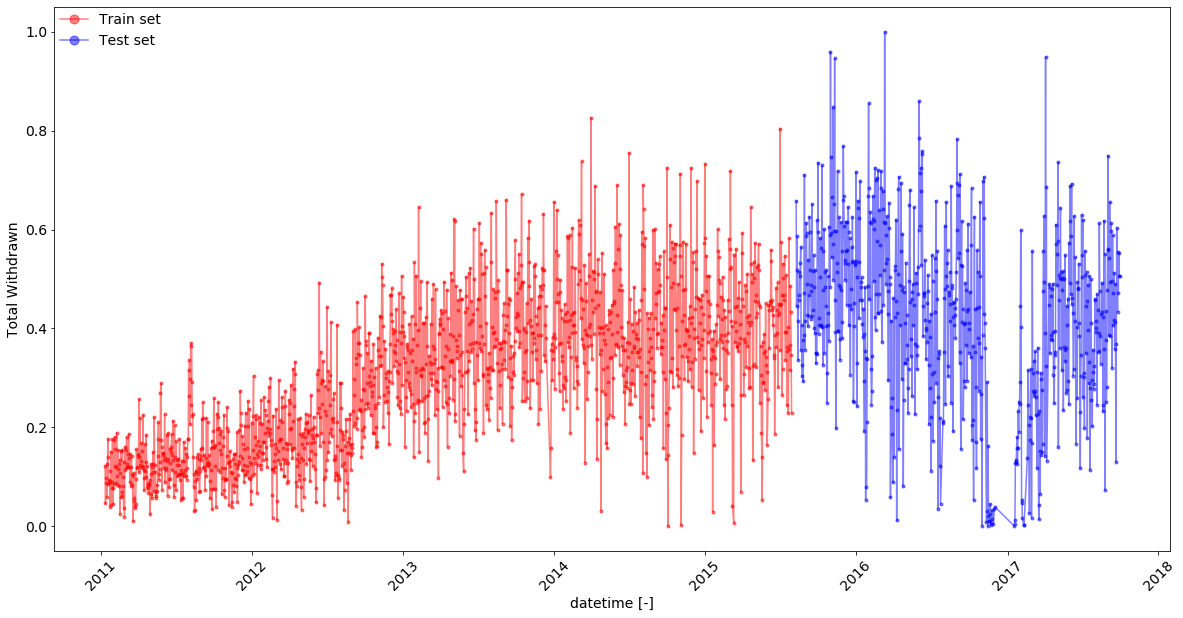

In [76]:
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Total Withdrawn' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [89]:
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(1))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])
model.fit(X_train, y_train, epochs = 300, batch_size = 5)

Epoch 1/300


1240/1637 [=====================>........] - ETA: 6:24 - loss: 0.0728 - mape: 111.6806 - mse: 0.07 - ETA: 2:14 - loss: 0.0421 - mape: 80.2993 - mse: 0.0421 - ETA: 1:25 - loss: 0.0396 - mape: 95.6541 - mse: 0.039 - ETA: 1:03 - loss: 0.0348 - mape: 83.5352 - mse: 0.034 - ETA: 52s - loss: 0.0318 - mape: 73.4811 - mse: 0.031 - ETA: 44s - loss: 0.0330 - mape: 87.0047 - mse: 0.03 - ETA: 39s - loss: 0.0301 - mape: 79.8666 - mse: 0.03 - ETA: 35s - loss: 0.0291 - mape: 72.3220 - mse: 0.02 - ETA: 32s - loss: 0.0286 - mape: 70.7558 - mse: 0.02 - ETA: 29s - loss: 0.0286 - mape: 78.6881 - mse: 0.02 - ETA: 28s - loss: 0.0269 - mape: 73.3406 - mse: 0.02 - ETA: 26s - loss: 0.0258 - mape: 71.0402 - mse: 0.02 - ETA: 25s - loss: 0.0245 - mape: 68.0725 - mse: 0.02 - ETA: 23s - loss: 0.0247 - mape: 67.8760 - mse: 0.02 - ETA: 22s - loss: 0.0249 - mape: 69.7669 - mse: 0.02 - ETA: 22s - loss: 0.0238 - mape: 67.1385 - mse: 0.02 - ETA: 21s - loss: 0.0235 - mape: 67.3057 - mse: 0.02 - ETA: 20s - loss: 0.0242 - m

1637/1637 [==============================] - ETA: 3s - loss: 0.0242 - mape: 222632.9062 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 220866.6719 - mse: 0.024 - ETA: 3s - loss: 0.0241 - mape: 219127.8438 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 218269.0938 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 217432.1719 - mse: 0.024 - ETA: 3s - loss: 0.0241 - mape: 215747.3438 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 214915.0156 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 214089.0156 - mse: 0.024 - ETA: 3s - loss: 0.0242 - mape: 213268.8750 - mse: 0.024 - ETA: 3s - loss: 0.0241 - mape: 212454.9375 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 210845.5938 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 210050.0469 - mse: 0.024 - ETA: 2s - loss: 0.0239 - mape: 208477.0312 - mse: 0.023 - ETA: 2s - loss: 0.0240 - mape: 207699.4844 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 206161.7812 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 204646.1719 - mse: 0.024 - ETA: 2s - loss: 0.0240 - ma

1430/1637 [=========================>....] - ETA: 14s - loss: 0.0158 - mape: 34.6396 - mse: 0.01 - ETA: 13s - loss: 0.0202 - mape: 44.3381 - mse: 0.02 - ETA: 13s - loss: 0.0172 - mape: 40.9984 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 40.9704 - mse: 0.01 - ETA: 13s - loss: 0.0207 - mape: 53.0119 - mse: 0.02 - ETA: 13s - loss: 0.0203 - mape: 53.1453 - mse: 0.02 - ETA: 12s - loss: 0.0203 - mape: 56.2299 - mse: 0.02 - ETA: 12s - loss: 0.0203 - mape: 60.0020 - mse: 0.02 - ETA: 12s - loss: 0.0200 - mape: 57.0140 - mse: 0.02 - ETA: 12s - loss: 0.0228 - mape: 67.0180 - mse: 0.02 - ETA: 12s - loss: 0.0234 - mape: 107.0446 - mse: 0.023 - ETA: 12s - loss: 0.0228 - mape: 103.0996 - mse: 0.022 - ETA: 12s - loss: 0.0219 - mape: 98.2511 - mse: 0.021 - ETA: 11s - loss: 0.0220 - mape: 96.7244 - mse: 0.02 - ETA: 11s - loss: 0.0216 - mape: 97.0744 - mse: 0.02 - ETA: 11s - loss: 0.0220 - mape: 99.4683 - mse: 0.02 - ETA: 11s - loss: 0.0223 - mape: 105.1463 - mse: 0.022 - ETA: 11s - loss: 0.0226 - mape

1637/1637 [==============================] - ETA: 1s - loss: 0.0227 - mape: 250046.7500 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 248322.4219 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 246622.4375 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 244945.2656 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 243290.9219 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 241658.8906 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 240048.0000 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 238458.4844 - mse: 0.022 - ETA: 0s - loss: 0.0224 - mape: 236890.2031 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 235342.6406 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 233815.0156 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 232307.0938 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 230818.2969 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 229348.5469 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 227898.1406 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 226465.2031 - mse: 0.022 - ETA: 0s - loss: 0.0225 - ma

1280/1637 [======================>.......] - ETA: 11s - loss: 0.0297 - mape: 121.6810 - mse: 0.029 - ETA: 12s - loss: 0.0317 - mape: 167.4965 - mse: 0.031 - ETA: 11s - loss: 0.0317 - mape: 159.3551 - mse: 0.031 - ETA: 11s - loss: 0.0287 - mape: 125.8388 - mse: 0.028 - ETA: 11s - loss: 0.0294 - mape: 113.0168 - mse: 0.029 - ETA: 11s - loss: 0.0296 - mape: 111.5244 - mse: 0.029 - ETA: 11s - loss: 0.0319 - mape: 107.3744 - mse: 0.031 - ETA: 11s - loss: 0.0309 - mape: 98.9140 - mse: 0.030 - ETA: 11s - loss: 0.0312 - mape: 105.2811 - mse: 0.031 - ETA: 11s - loss: 0.0297 - mape: 101.2703 - mse: 0.029 - ETA: 11s - loss: 0.0293 - mape: 98.3271 - mse: 0.029 - ETA: 11s - loss: 0.0281 - mape: 94.2654 - mse: 0.02 - ETA: 11s - loss: 0.0272 - mape: 95.0730 - mse: 0.02 - ETA: 11s - loss: 0.0271 - mape: 94.6740 - mse: 0.02 - ETA: 11s - loss: 0.0273 - mape: 96.0881 - mse: 0.02 - ETA: 10s - loss: 0.0266 - mape: 92.0036 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 88.8320 - mse: 0.02 - ETA: 10s - loss: 

1637/1637 [==============================] - ETA: 2s - loss: 0.0227 - mape: 254770.8438 - mse: 0.022 - ETA: 2s - loss: 0.0226 - mape: 253783.5156 - mse: 0.022 - ETA: 2s - loss: 0.0227 - mape: 252804.0781 - mse: 0.022 - ETA: 2s - loss: 0.0226 - mape: 250867.4688 - mse: 0.022 - ETA: 2s - loss: 0.0226 - mape: 249910.0156 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 248959.9062 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 247081.5625 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 246153.0000 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 245231.3125 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 244316.6875 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 243408.6562 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 242507.3750 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 241612.6562 - mse: 0.022 - ETA: 2s - loss: 0.0224 - mape: 240724.4688 - mse: 0.022 - ETA: 2s - loss: 0.0224 - mape: 238967.6406 - mse: 0.022 - ETA: 2s - loss: 0.0224 - mape: 238098.7656 - mse: 0.022 - ETA: 2s - loss: 0.0223 - ma

1405/1637 [========================>.....] - ETA: 10s - loss: 0.0228 - mape: 264.8159 - mse: 0.022 - ETA: 10s - loss: 0.0259 - mape: 152.2570 - mse: 0.025 - ETA: 10s - loss: 0.0238 - mape: 115.3929 - mse: 0.023 - ETA: 10s - loss: 0.0231 - mape: 104.4344 - mse: 0.023 - ETA: 10s - loss: 0.0235 - mape: 98.7012 - mse: 0.023 - ETA: 10s - loss: 0.0223 - mape: 90.5781 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 88.0141 - mse: 0.02 - ETA: 10s - loss: 0.0195 - mape: 79.3615 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 89.7363 - mse: 0.02 - ETA: 10s - loss: 0.0195 - mape: 85.7401 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 81.3002 - mse: 0.01 - ETA: 10s - loss: 0.0208 - mape: 78.5645 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 76.3976 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 73.1872 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 73.0075 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 75.3733 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 78.0995 - mse: 0.02 - ETA: 11s - loss: 0.0205 - ma

1637/1637 [==============================] - ETA: 1s - loss: 0.0226 - mape: 192566.5000 - mse: 0.022 - ETA: 1s - loss: 0.0227 - mape: 191215.5000 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 189883.2344 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 188569.5938 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 187274.9375 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 185997.2812 - mse: 0.022 - ETA: 1s - loss: 0.0227 - mape: 184737.2344 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 183493.6406 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 182266.9531 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 181056.0781 - mse: 0.022 - ETA: 0s - loss: 0.0225 - mape: 179861.3906 - mse: 0.022 - ETA: 0s - loss: 0.0227 - mape: 178682.6719 - mse: 0.022 - ETA: 0s - loss: 0.0227 - mape: 177518.9688 - mse: 0.022 - ETA: 0s - loss: 0.0226 - mape: 176370.7188 - mse: 0.022 - ETA: 0s - loss: 0.0226 - mape: 175237.0625 - mse: 0.022 - ETA: 0s - loss: 0.0226 - mape: 174117.5469 - mse: 0.022 - ETA: 0s - loss: 0.0226 - ma

1430/1637 [=========================>....] - ETA: 13s - loss: 0.0242 - mape: 55.8206 - mse: 0.02 - ETA: 11s - loss: 0.0290 - mape: 94.9775 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 77.7601 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 64.2093 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 60.9304 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 54.7231 - mse: 0.02 - ETA: 10s - loss: 0.0193 - mape: 57.1480 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 64.8761 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 70.5231 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 66.6284 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 66.0675 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 66.1897 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 72.0670 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 70.6834 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 209.6164 - mse: 0.021 - ETA: 10s - loss: 0.0217 - mape: 201.7073 - mse: 0.021 - ETA: 10s - loss: 0.0218 - mape: 196.3110 - mse: 0.021 - ETA: 10s - loss: 0.0214 - mape:

1637/1637 [==============================] - ETA: 1s - loss: 0.0218 - mape: 185295.0469 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 184017.6406 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 182757.5000 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 181514.5938 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 180288.9688 - mse: 0.021 - ETA: 0s - loss: 0.0220 - mape: 179079.7812 - mse: 0.022 - ETA: 0s - loss: 0.0220 - mape: 177886.5781 - mse: 0.022 - ETA: 0s - loss: 0.0220 - mape: 176708.8438 - mse: 0.022 - ETA: 0s - loss: 0.0221 - mape: 175547.4062 - mse: 0.022 - ETA: 0s - loss: 0.0221 - mape: 174400.5156 - mse: 0.022 - ETA: 0s - loss: 0.0221 - mape: 173268.5000 - mse: 0.022 - ETA: 0s - loss: 0.0222 - mape: 172150.8438 - mse: 0.022 - ETA: 0s - loss: 0.0221 - mape: 171047.5312 - mse: 0.022 - ETA: 0s - loss: 0.0221 - mape: 169958.4688 - mse: 0.022 - ETA: 0s - loss: 0.0220 - mape: 168883.0469 - mse: 0.022 - ETA: 0s - loss: 0.0220 - mape: 167821.4844 - mse: 0.022 - ETA: 0s - loss: 0.0220 - ma

1350/1637 [=======================>......] - ETA: 9s - loss: 0.0397 - mape: 65519564.0000 - mse: 0.039 - ETA: 9s - loss: 0.0216 - mape: 21839892.0000 - mse: 0.021 - ETA: 10s - loss: 0.0202 - mape: 13103954.0000 - mse: 0.02 - ETA: 10s - loss: 0.0175 - mape: 9359983.0000 - mse: 0.0175 - ETA: 10s - loss: 0.0176 - mape: 7280009.0000 - mse: 0.017 - ETA: 10s - loss: 0.0170 - mape: 5956377.5000 - mse: 0.017 - ETA: 10s - loss: 0.0187 - mape: 5040024.0000 - mse: 0.018 - ETA: 11s - loss: 0.0192 - mape: 4680024.5000 - mse: 0.019 - ETA: 11s - loss: 0.0187 - mape: 4095029.5000 - mse: 0.018 - ETA: 11s - loss: 0.0183 - mape: 3640032.2500 - mse: 0.018 - ETA: 11s - loss: 0.0223 - mape: 3276039.7500 - mse: 0.022 - ETA: 11s - loss: 0.0215 - mape: 3120039.5000 - mse: 0.021 - ETA: 11s - loss: 0.0209 - mape: 2848739.2500 - mse: 0.020 - ETA: 11s - loss: 0.0206 - mape: 2620843.2500 - mse: 0.020 - ETA: 11s - loss: 0.0211 - mape: 2426710.2500 - mse: 0.021 - ETA: 11s - loss: 0.0208 - mape: 2259356.7500 - mse: 0.

1637/1637 [==============================] - ETA: 1s - loss: 0.0217 - mape: 240975.6719 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 239217.1875 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 237484.1250 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 235776.1406 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 234092.5781 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 232433.0000 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 230796.3906 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 229182.7969 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 227591.8594 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 226023.4375 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 224475.7500 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 222948.9688 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 221442.7188 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 220697.3594 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 219221.5781 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 218491.4375 - mse: 0.021 - ETA: 0s - loss: 0.0218 - ma

1255/1637 [=====================>........] - ETA: 11s - loss: 0.0236 - mape: 159.5410 - mse: 0.023 - ETA: 13s - loss: 0.0176 - mape: 86.6744 - mse: 0.017 - ETA: 14s - loss: 0.0162 - mape: 76.4702 - mse: 0.01 - ETA: 14s - loss: 0.0168 - mape: 76.8542 - mse: 0.01 - ETA: 15s - loss: 0.0171 - mape: 84.0867 - mse: 0.01 - ETA: 15s - loss: 0.0204 - mape: 88.2340 - mse: 0.02 - ETA: 14s - loss: 0.0183 - mape: 77.0445 - mse: 0.01 - ETA: 15s - loss: 0.0187 - mape: 71.9376 - mse: 0.01 - ETA: 14s - loss: 0.0180 - mape: 64.1840 - mse: 0.01 - ETA: 15s - loss: 0.0169 - mape: 60.5069 - mse: 0.01 - ETA: 15s - loss: 0.0184 - mape: 59.1583 - mse: 0.01 - ETA: 15s - loss: 0.0187 - mape: 64.6457 - mse: 0.01 - ETA: 15s - loss: 0.0198 - mape: 68.0953 - mse: 0.01 - ETA: 15s - loss: 0.0192 - mape: 65.5222 - mse: 0.01 - ETA: 15s - loss: 0.0181 - mape: 62.4158 - mse: 0.01 - ETA: 15s - loss: 0.0187 - mape: 70.7042 - mse: 0.01 - ETA: 14s - loss: 0.0189 - mape: 71.5799 - mse: 0.01 - ETA: 14s - loss: 0.0185 - mape: 68

1637/1637 [==============================] - ETA: 3s - loss: 0.0217 - mape: 251394.7188 - mse: 0.021 - ETA: 3s - loss: 0.0217 - mape: 249415.5156 - mse: 0.021 - ETA: 3s - loss: 0.0218 - mape: 248438.0156 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 246505.4844 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 244602.2969 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 242728.2812 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 240885.5625 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 239067.8750 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 237277.3125 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 235513.5781 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 233775.9219 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 232063.8750 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 231217.4688 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 229542.4062 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 228713.8125 - mse: 0.021 - ETA: 2s - loss: 0.0220 - mape: 227075.0000 - mse: 0.022 - ETA: 1s - loss: 0.0219 - ma

1430/1637 [=========================>....] - ETA: 13s - loss: 0.0313 - mape: 82.6286 - mse: 0.03 - ETA: 13s - loss: 0.0194 - mape: 53.2976 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 62.3344 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 61.0802 - mse: 0.01 - ETA: 13s - loss: 0.0161 - mape: 61.9670 - mse: 0.01 - ETA: 12s - loss: 0.0158 - mape: 61.4093 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 58.8270 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 57.3285 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 55.4736 - mse: 0.01 - ETA: 12s - loss: 0.0166 - mape: 60.6049 - mse: 0.01 - ETA: 12s - loss: 0.0172 - mape: 57.3391 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 54.5518 - mse: 0.01 - ETA: 12s - loss: 0.0167 - mape: 57.2921 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 59.2947 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 58.0987 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 56.2975 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 57.6816 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 60.30

1637/1637 [==============================] - ETA: 1s - loss: 0.0216 - mape: 225434.0625 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 223879.7969 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 222346.9531 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 220834.6719 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 220087.1250 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 218605.9375 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 217144.2500 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 215702.0938 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 214281.6094 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 212877.1719 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 211490.6406 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 210122.0000 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 209444.3906 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 208102.1562 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 206778.9062 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 205471.0938 - mse: 0.021 - ETA: 0s - loss: 0.0219 - ma

1430/1637 [=========================>....] - ETA: 11s - loss: 0.0281 - mape: 86.4510 - mse: 0.02 - ETA: 11s - loss: 0.0184 - mape: 68.7158 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 56.9145 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 64.0612 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 61.1567 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 54.8998 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 55.8741 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 55.8118 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 55.4200 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 56.6082 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 60.7017 - mse: 0.01 - ETA: 11s - loss: 0.0210 - mape: 64.3044 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 61.3633 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 60.1120 - mse: 0.02 - ETA: 11s - loss: 0.0213 - mape: 65.1989 - mse: 0.02 - ETA: 11s - loss: 0.0210 - mape: 65.2992 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 63.6542 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 66.56

1637/1637 [==============================] - ETA: 1s - loss: 0.0218 - mape: 203803.2812 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 202398.1406 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 201012.2031 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 199645.0781 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 198296.4688 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 196965.8594 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 195652.9844 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 194358.2656 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 193080.0781 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 191818.7344 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 190574.8750 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 189346.1250 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 188132.7969 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 187532.2812 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 186935.1562 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 185752.7344 - mse: 0.021 - ETA: 0s - loss: 0.0219 - ma

1260/1637 [======================>.......] - ETA: 10s - loss: 0.0102 - mape: 21.5067 - mse: 0.01 - ETA: 12s - loss: 0.0313 - mape: 53.4581 - mse: 0.03 - ETA: 12s - loss: 0.0250 - mape: 65.5484 - mse: 0.02 - ETA: 12s - loss: 0.0264 - mape: 102.0622 - mse: 0.026 - ETA: 12s - loss: 0.0243 - mape: 96.7490 - mse: 0.024 - ETA: 11s - loss: 0.0237 - mape: 89.1642 - mse: 0.02 - ETA: 11s - loss: 0.0236 - mape: 106.0249 - mse: 0.023 - ETA: 12s - loss: 0.0239 - mape: 103.5923 - mse: 0.023 - ETA: 12s - loss: 0.0228 - mape: 98.9920 - mse: 0.022 - ETA: 12s - loss: 0.0241 - mape: 97.2941 - mse: 0.02 - ETA: 12s - loss: 0.0231 - mape: 95.4987 - mse: 0.02 - ETA: 12s - loss: 0.0238 - mape: 98.6681 - mse: 0.02 - ETA: 12s - loss: 0.0241 - mape: 102.3481 - mse: 0.024 - ETA: 12s - loss: 0.0250 - mape: 97.5449 - mse: 0.025 - ETA: 12s - loss: 0.0240 - mape: 93.5107 - mse: 0.02 - ETA: 11s - loss: 0.0230 - mape: 88.7383 - mse: 0.02 - ETA: 11s - loss: 0.0224 - mape: 85.9545 - mse: 0.02 - ETA: 11s - loss: 0.0224 - 

1637/1637 [==============================] - ETA: 3s - loss: 0.0210 - mape: 224697.0781 - mse: 0.021 - ETA: 3s - loss: 0.0210 - mape: 222942.0000 - mse: 0.021 - ETA: 3s - loss: 0.0210 - mape: 222074.5938 - mse: 0.021 - ETA: 2s - loss: 0.0210 - mape: 220360.8906 - mse: 0.021 - ETA: 2s - loss: 0.0210 - mape: 219513.5000 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 217838.2344 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 217010.1719 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 215372.6250 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 214565.6094 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 213762.3438 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 212173.4375 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 211387.7969 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 209833.7656 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 208303.7969 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 207546.6719 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 206794.9844 - mse: 0.021 - ETA: 2s - loss: 0.0213 - ma

1165/1637 [====================>.........] - ETA: 13s - loss: 0.0190 - mape: 88.5928 - mse: 0.01 - ETA: 14s - loss: 0.0253 - mape: 405.4600 - mse: 0.025 - ETA: 15s - loss: 0.0270 - mape: 338.1584 - mse: 0.027 - ETA: 14s - loss: 0.0279 - mape: 264.4881 - mse: 0.027 - ETA: 15s - loss: 0.0261 - mape: 236.5813 - mse: 0.026 - ETA: 15s - loss: 0.0229 - mape: 196.7095 - mse: 0.022 - ETA: 15s - loss: 0.0231 - mape: 169.5090 - mse: 0.023 - ETA: 15s - loss: 0.0225 - mape: 158.9978 - mse: 0.022 - ETA: 15s - loss: 0.0227 - mape: 4756181.0000 - mse: 0.022 - ETA: 15s - loss: 0.0224 - mape: 4416457.5000 - mse: 0.022 - ETA: 15s - loss: 0.0214 - mape: 4122030.0000 - mse: 0.021 - ETA: 15s - loss: 0.0222 - mape: 3637108.2500 - mse: 0.022 - ETA: 14s - loss: 0.0233 - mape: 3254262.5000 - mse: 0.023 - ETA: 14s - loss: 0.0226 - mape: 2944337.2500 - mse: 0.022 - ETA: 14s - loss: 0.0227 - mape: 2688314.5000 - mse: 0.022 - ETA: 14s - loss: 0.0226 - mape: 2576304.2500 - mse: 0.022 - ETA: 14s - loss: 0.0234 - map

1637/1637 [==============================] - ETA: 4s - loss: 0.0220 - mape: 263195.0625 - mse: 0.022 - ETA: 3s - loss: 0.0220 - mape: 260975.0469 - mse: 0.022 - ETA: 3s - loss: 0.0220 - mape: 258791.4688 - mse: 0.022 - ETA: 3s - loss: 0.0220 - mape: 257713.5000 - mse: 0.022 - ETA: 3s - loss: 0.0221 - mape: 255584.1094 - mse: 0.022 - ETA: 3s - loss: 0.0222 - mape: 254532.5312 - mse: 0.022 - ETA: 3s - loss: 0.0222 - mape: 253489.7031 - mse: 0.022 - ETA: 3s - loss: 0.0222 - mape: 252455.2344 - mse: 0.022 - ETA: 3s - loss: 0.0221 - mape: 250411.4531 - mse: 0.022 - ETA: 3s - loss: 0.0221 - mape: 249402.0156 - mse: 0.022 - ETA: 3s - loss: 0.0220 - mape: 247407.0000 - mse: 0.022 - ETA: 3s - loss: 0.0219 - mape: 246421.4219 - mse: 0.021 - ETA: 3s - loss: 0.0219 - mape: 245443.8281 - mse: 0.021 - ETA: 3s - loss: 0.0219 - mape: 243511.8594 - mse: 0.021 - ETA: 3s - loss: 0.0220 - mape: 241610.3281 - mse: 0.022 - ETA: 3s - loss: 0.0219 - mape: 240670.3594 - mse: 0.021 - ETA: 3s - loss: 0.0219 - ma

1220/1637 [=====================>........] - ETA: 13s - loss: 0.0238 - mape: 36.3148 - mse: 0.02 - ETA: 13s - loss: 0.0199 - mape: 64.8186 - mse: 0.01 - ETA: 13s - loss: 0.0216 - mape: 81.8912 - mse: 0.02 - ETA: 13s - loss: 0.0233 - mape: 73.2282 - mse: 0.02 - ETA: 12s - loss: 0.0214 - mape: 65.4544 - mse: 0.02 - ETA: 13s - loss: 0.0218 - mape: 61.4941 - mse: 0.02 - ETA: 13s - loss: 0.0221 - mape: 72.1914 - mse: 0.02 - ETA: 13s - loss: 0.0214 - mape: 68.6947 - mse: 0.02 - ETA: 13s - loss: 0.0207 - mape: 347.9106 - mse: 0.020 - ETA: 13s - loss: 0.0209 - mape: 319.1809 - mse: 0.020 - ETA: 12s - loss: 0.0210 - mape: 292.0082 - mse: 0.021 - ETA: 12s - loss: 0.0201 - mape: 267.8037 - mse: 0.020 - ETA: 12s - loss: 0.0196 - mape: 247.8279 - mse: 0.019 - ETA: 12s - loss: 0.0196 - mape: 232.0252 - mse: 0.019 - ETA: 12s - loss: 0.0193 - mape: 225.9740 - mse: 0.019 - ETA: 12s - loss: 0.0192 - mape: 213.8799 - mse: 0.019 - ETA: 12s - loss: 0.0194 - mape: 208.3101 - mse: 0.019 - ETA: 12s - loss: 0.

1637/1637 [==============================] - ETA: 3s - loss: 0.0220 - mape: 101.5323 - mse: 0.02 - ETA: 3s - loss: 0.0220 - mape: 101.0482 - mse: 0.02 - ETA: 3s - loss: 0.0220 - mape: 100.5701 - mse: 0.02 - ETA: 3s - loss: 0.0219 - mape: 100.6478 - mse: 0.02 - ETA: 3s - loss: 0.0219 - mape: 100.2296 - mse: 0.02 - ETA: 3s - loss: 0.0218 - mape: 99.8340 - mse: 0.0218 - ETA: 3s - loss: 0.0219 - mape: 99.7556 - mse: 0.021 - ETA: 3s - loss: 0.0219 - mape: 99.6714 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 99.8001 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 99.9924 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 99.7937 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 99.3671 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 99.1994 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 98.9734 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 98.5113 - mse: 0.021 - ETA: 2s - loss: 0.0220 - mape: 98.1846 - mse: 0.022 - ETA: 2s - loss: 0.0219 - mape: 97.7529 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 97.47

1260/1637 [======================>.......] - ETA: 15s - loss: 0.0102 - mape: 45.1638 - mse: 0.01 - ETA: 13s - loss: 0.0142 - mape: 66.4008 - mse: 0.01 - ETA: 13s - loss: 0.0134 - mape: 51.2041 - mse: 0.01 - ETA: 13s - loss: 0.0244 - mape: 58.7503 - mse: 0.02 - ETA: 13s - loss: 0.0254 - mape: 65.9687 - mse: 0.02 - ETA: 13s - loss: 0.0240 - mape: 64.4282 - mse: 0.02 - ETA: 12s - loss: 0.0230 - mape: 66.5176 - mse: 0.02 - ETA: 13s - loss: 0.0237 - mape: 67.0029 - mse: 0.02 - ETA: 12s - loss: 0.0240 - mape: 75.4490 - mse: 0.02 - ETA: 12s - loss: 0.0246 - mape: 77.4732 - mse: 0.02 - ETA: 12s - loss: 0.0238 - mape: 74.3738 - mse: 0.02 - ETA: 12s - loss: 0.0252 - mape: 72.2483 - mse: 0.02 - ETA: 12s - loss: 0.0248 - mape: 68.1247 - mse: 0.02 - ETA: 12s - loss: 0.0247 - mape: 66.6350 - mse: 0.02 - ETA: 12s - loss: 0.0249 - mape: 64.7201 - mse: 0.02 - ETA: 12s - loss: 0.0245 - mape: 63.8923 - mse: 0.02 - ETA: 12s - loss: 0.0242 - mape: 63.8390 - mse: 0.02 - ETA: 12s - loss: 0.0238 - mape: 64.84

1637/1637 [==============================] - ETA: 3s - loss: 0.0217 - mape: 248746.6875 - mse: 0.021 - ETA: 3s - loss: 0.0217 - mape: 247771.7031 - mse: 0.021 - ETA: 3s - loss: 0.0219 - mape: 246804.0938 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 244891.3125 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 243947.0000 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 242078.2344 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 241154.3438 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 240237.7969 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 238425.4531 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 237529.2812 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 236639.8281 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 235756.9219 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 234880.8750 - mse: 0.021 - ETA: 2s - loss: 0.0219 - mape: 234011.1406 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 232290.7969 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 230595.5938 - mse: 0.021 - ETA: 2s - loss: 0.0218 - ma

1320/1637 [=======================>......] - ETA: 10s - loss: 0.0207 - mape: 88.9097 - mse: 0.02 - ETA: 12s - loss: 0.0228 - mape: 52.7707 - mse: 0.02 - ETA: 12s - loss: 0.0241 - mape: 60.6790 - mse: 0.02 - ETA: 12s - loss: 0.0240 - mape: 85.8934 - mse: 0.02 - ETA: 12s - loss: 0.0225 - mape: 76.2238 - mse: 0.02 - ETA: 12s - loss: 0.0229 - mape: 73.9310 - mse: 0.02 - ETA: 12s - loss: 0.0240 - mape: 89.3209 - mse: 0.02 - ETA: 12s - loss: 0.0217 - mape: 80.6899 - mse: 0.02 - ETA: 12s - loss: 0.0214 - mape: 78.9383 - mse: 0.02 - ETA: 12s - loss: 0.0229 - mape: 83.2242 - mse: 0.02 - ETA: 12s - loss: 0.0220 - mape: 79.6572 - mse: 0.02 - ETA: 12s - loss: 0.0216 - mape: 78.9131 - mse: 0.02 - ETA: 11s - loss: 0.0215 - mape: 79.5519 - mse: 0.02 - ETA: 11s - loss: 0.0212 - mape: 77.9649 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 74.4653 - mse: 0.02 - ETA: 11s - loss: 0.0214 - mape: 74.5211 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 1967816.5000 - mse: 0.022 - ETA: 11s - loss: 0.0232 - mape:

1637/1637 [==============================] - ETA: 2s - loss: 0.0212 - mape: 244196.9375 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 242374.7812 - mse: 0.021 - ETA: 2s - loss: 0.0211 - mape: 240579.7031 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 238811.9531 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 237069.3438 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 235351.7188 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 233659.0938 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 231990.5156 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 230347.7812 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 228726.3750 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 227127.2656 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 225550.5312 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 223995.6094 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 222461.6406 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 220948.9688 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 219456.3750 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1305/1637 [======================>.......] - ETA: 13s - loss: 0.0394 - mape: 57.2812 - mse: 0.03 - ETA: 12s - loss: 0.0294 - mape: 66.3128 - mse: 0.02 - ETA: 13s - loss: 0.0306 - mape: 62.0598 - mse: 0.03 - ETA: 13s - loss: 0.0250 - mape: 60.4948 - mse: 0.02 - ETA: 13s - loss: 0.0247 - mape: 62.3654 - mse: 0.02 - ETA: 12s - loss: 0.0233 - mape: 71.0778 - mse: 0.02 - ETA: 13s - loss: 0.0233 - mape: 71.3663 - mse: 0.02 - ETA: 13s - loss: 0.0246 - mape: 68.5632 - mse: 0.02 - ETA: 13s - loss: 0.0256 - mape: 69.9836 - mse: 0.02 - ETA: 12s - loss: 0.0246 - mape: 68.1028 - mse: 0.02 - ETA: 12s - loss: 0.0233 - mape: 63.5749 - mse: 0.02 - ETA: 12s - loss: 0.0236 - mape: 63.9071 - mse: 0.02 - ETA: 12s - loss: 0.0243 - mape: 70.5125 - mse: 0.02 - ETA: 12s - loss: 0.0235 - mape: 69.1386 - mse: 0.02 - ETA: 12s - loss: 0.0222 - mape: 66.3646 - mse: 0.02 - ETA: 12s - loss: 0.0213 - mape: 65.7347 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 64.6609 - mse: 0.02 - ETA: 12s - loss: 0.0213 - mape: 93.29

1637/1637 [==============================] - ETA: 2s - loss: 0.0217 - mape: 227456.2188 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 225739.9375 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 223213.2969 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 221560.4688 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 219931.8125 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 218327.0312 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 215963.0781 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 214415.2344 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 212889.4219 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 211385.5156 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 209903.6719 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 208441.2812 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 206285.9219 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 204873.4844 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 203480.6250 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202106.0312 - mse: 0.021 - ETA: 1s - loss: 0.0216 - ma

1425/1637 [=========================>....] - ETA: 13s - loss: 0.0201 - mape: 51.3817 - mse: 0.02 - ETA: 12s - loss: 0.0199 - mape: 54.2957 - mse: 0.01 - ETA: 12s - loss: 0.0242 - mape: 72.3251 - mse: 0.02 - ETA: 13s - loss: 0.0245 - mape: 79.8727 - mse: 0.02 - ETA: 13s - loss: 0.0235 - mape: 78.5325 - mse: 0.02 - ETA: 14s - loss: 0.0248 - mape: 77.8849 - mse: 0.02 - ETA: 14s - loss: 0.0237 - mape: 75.6890 - mse: 0.02 - ETA: 14s - loss: 0.0226 - mape: 70.6753 - mse: 0.02 - ETA: 13s - loss: 0.0219 - mape: 68.3511 - mse: 0.02 - ETA: 13s - loss: 0.0205 - mape: 65.1943 - mse: 0.02 - ETA: 13s - loss: 0.0219 - mape: 67.9669 - mse: 0.02 - ETA: 13s - loss: 0.0216 - mape: 69.7718 - mse: 0.02 - ETA: 12s - loss: 0.0210 - mape: 70.8471 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 69.2336 - mse: 0.02 - ETA: 12s - loss: 0.0213 - mape: 75.4951 - mse: 0.02 - ETA: 11s - loss: 0.0218 - mape: 78.3052 - mse: 0.02 - ETA: 11s - loss: 0.0215 - mape: 76.8815 - mse: 0.02 - ETA: 11s - loss: 0.0224 - mape: 74.89

1637/1637 [==============================] - ETA: 1s - loss: 0.0219 - mape: 199839.7969 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 198457.6875 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 197094.0469 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 195084.0625 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 193768.3750 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 192468.7031 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 191186.1094 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 189920.2188 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 188671.1719 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 187438.4688 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 186221.9688 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 185020.7812 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 183834.9688 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 182664.4375 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 181508.6406 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 180367.7188 - mse: 0.021 - ETA: 0s - loss: 0.0219 - ma

1315/1637 [=======================>......] - ETA: 10s - loss: 0.0115 - mape: 56.5299 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 54.2780 - mse: 0.01 - ETA: 10s - loss: 0.0250 - mape: 50.6226 - mse: 0.02 - ETA: 11s - loss: 0.0273 - mape: 69.7759 - mse: 0.02 - ETA: 12s - loss: 0.0268 - mape: 73.4907 - mse: 0.02 - ETA: 13s - loss: 0.0252 - mape: 68.0885 - mse: 0.02 - ETA: 14s - loss: 0.0247 - mape: 68.3369 - mse: 0.02 - ETA: 14s - loss: 0.0237 - mape: 64.5690 - mse: 0.02 - ETA: 14s - loss: 0.0233 - mape: 65.5341 - mse: 0.02 - ETA: 15s - loss: 0.0225 - mape: 65.0331 - mse: 0.02 - ETA: 15s - loss: 0.0225 - mape: 63.8730 - mse: 0.02 - ETA: 15s - loss: 0.0216 - mape: 63.1302 - mse: 0.02 - ETA: 14s - loss: 0.0211 - mape: 61.0557 - mse: 0.02 - ETA: 14s - loss: 0.0222 - mape: 63.5504 - mse: 0.02 - ETA: 14s - loss: 0.0212 - mape: 60.8804 - mse: 0.02 - ETA: 14s - loss: 0.0211 - mape: 63.5646 - mse: 0.02 - ETA: 14s - loss: 0.0203 - mape: 61.9191 - mse: 0.02 - ETA: 14s - loss: 0.0203 - mape: 60.26

1637/1637 [==============================] - ETA: 2s - loss: 0.0214 - mape: 205786.8281 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 204245.5781 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 202727.3750 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 201231.5000 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 200491.8594 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 199757.5781 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 198305.4219 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 197587.0156 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 196874.3750 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 196166.3594 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 195463.4062 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 194765.5938 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 193384.6250 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 192023.8438 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 191350.1719 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 190681.5312 - mse: 0.021 - ETA: 1s - loss: 0.0215 - ma

1350/1637 [=======================>......] - ETA: 11s - loss: 0.0260 - mape: 151.9289 - mse: 0.026 - ETA: 11s - loss: 0.0379 - mape: 86.2035 - mse: 0.037 - ETA: 12s - loss: 0.0287 - mape: 63.4599 - mse: 0.02 - ETA: 12s - loss: 0.0241 - mape: 102.3211 - mse: 0.024 - ETA: 11s - loss: 0.0224 - mape: 93.2717 - mse: 0.022 - ETA: 11s - loss: 0.0212 - mape: 85.6996 - mse: 0.02 - ETA: 11s - loss: 0.0192 - mape: 80.2406 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 81.0730 - mse: 0.02 - ETA: 11s - loss: 0.0196 - mape: 75.7897 - mse: 0.01 - ETA: 11s - loss: 0.0204 - mape: 77.4607 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 77.4732 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 75.6690 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 74.0268 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 74.7197 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 74.2362 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 80.0401 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 81.9914 - mse: 0.02 - ETA: 11s - loss: 0.0197 - mape:

1637/1637 [==============================] - ETA: 2s - loss: 0.0213 - mape: 94.1214 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 93.9742 - mse: 0.021 - ETA: 2s - loss: 0.0212 - mape: 93.4330 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 93.3959 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 93.4647 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 93.6457 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 93.8288 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 94.7145 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 94.3015 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 94.7955 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 94.4296 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 191361.3594 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 190064.2969 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 188784.5469 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 187523.1406 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 186277.6562 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 185048.3750 - mse: 0.021 - ETA: 0s - los

1460/1637 [=========================>....] - ETA: 7s - loss: 0.0136 - mape: 65.0511 - mse: 0.013 - ETA: 10s - loss: 0.0235 - mape: 108.1163 - mse: 0.023 - ETA: 10s - loss: 0.0269 - mape: 107.8661 - mse: 0.026 - ETA: 10s - loss: 0.0248 - mape: 92.5870 - mse: 0.024 - ETA: 10s - loss: 0.0251 - mape: 85.3081 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 85.8812 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 88.0968 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 84.0085 - mse: 0.02 - ETA: 10s - loss: 0.0235 - mape: 84.8488 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 80.1938 - mse: 0.02 - ETA: 10s - loss: 0.0268 - mape: 79.4386 - mse: 0.02 - ETA: 10s - loss: 0.0279 - mape: 77.8710 - mse: 0.02 - ETA: 10s - loss: 0.0283 - mape: 74.1167 - mse: 0.02 - ETA: 10s - loss: 0.0276 - mape: 72.8135 - mse: 0.02 - ETA: 10s - loss: 0.0264 - mape: 70.0494 - mse: 0.02 - ETA: 10s - loss: 0.0259 - mape: 68.7605 - mse: 0.02 - ETA: 9s - loss: 0.0260 - mape: 69.4593 - mse: 0.0260 - ETA: 9s - loss: 0.0261 - mape: 

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 222082.5000 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 220582.3594 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 219102.3438 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 217642.2812 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 216201.2812 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 214779.2031 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 213375.8594 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 211990.7188 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 210623.5625 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 209276.0000 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 207943.8750 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 207284.5156 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 205979.1562 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 204688.5312 - mse: 0.021 - ETA: 0s - loss: 0.0217 - mape: 203413.5469 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 202154.5156 - mse: 0.021 - ETA: 0s - loss: 0.0216 - ma

1330/1637 [=======================>......] - ETA: 11s - loss: 0.0169 - mape: 53.0465 - mse: 0.01 - ETA: 12s - loss: 0.0230 - mape: 49.6209 - mse: 0.02 - ETA: 13s - loss: 0.0195 - mape: 59.0921 - mse: 0.01 - ETA: 13s - loss: 0.0181 - mape: 66.3864 - mse: 0.01 - ETA: 12s - loss: 0.0193 - mape: 72.1443 - mse: 0.01 - ETA: 12s - loss: 0.0199 - mape: 84.7032 - mse: 0.01 - ETA: 11s - loss: 0.0211 - mape: 85.4570 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 83.4520 - mse: 0.02 - ETA: 11s - loss: 0.0189 - mape: 76.3760 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 73.9168 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 2768428.7500 - mse: 0.019 - ETA: 11s - loss: 0.0198 - mape: 2527703.0000 - mse: 0.019 - ETA: 11s - loss: 0.0200 - mape: 2422384.5000 - mse: 0.020 - ETA: 11s - loss: 0.0203 - mape: 2325490.5000 - mse: 0.020 - ETA: 11s - loss: 0.0200 - mape: 2236049.7500 - mse: 0.020 - ETA: 11s - loss: 0.0199 - mape: 2076337.8750 - mse: 0.019 - ETA: 11s - loss: 0.0197 - mape: 1937919.3750 - mse: 0.0

1637/1637 [==============================] - ETA: 2s - loss: 0.0215 - mape: 217832.6250 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 216213.5781 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 214619.3281 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 213830.4531 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 213047.3750 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 212269.8906 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 210731.9844 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 209216.9219 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 207723.5156 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 206251.1875 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 204799.1250 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 203367.1875 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 202658.7188 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 201256.6406 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 199874.0156 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 198510.2031 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1315/1637 [=======================>......] - ETA: 13s - loss: 0.0192 - mape: 61.9958 - mse: 0.01 - ETA: 12s - loss: 0.0196 - mape: 67.8978 - mse: 0.01 - ETA: 13s - loss: 0.0202 - mape: 64.5008 - mse: 0.02 - ETA: 13s - loss: 0.0233 - mape: 70.4771 - mse: 0.02 - ETA: 14s - loss: 0.0226 - mape: 71.4812 - mse: 0.02 - ETA: 14s - loss: 0.0207 - mape: 64.4312 - mse: 0.02 - ETA: 13s - loss: 0.0235 - mape: 60.3928 - mse: 0.02 - ETA: 13s - loss: 0.0237 - mape: 71.7053 - mse: 0.02 - ETA: 12s - loss: 0.0242 - mape: 75.9167 - mse: 0.02 - ETA: 12s - loss: 0.0237 - mape: 79.0829 - mse: 0.02 - ETA: 12s - loss: 0.0242 - mape: 109.7475 - mse: 0.024 - ETA: 11s - loss: 0.0243 - mape: 113.4748 - mse: 0.024 - ETA: 11s - loss: 0.0243 - mape: 109.6656 - mse: 0.024 - ETA: 12s - loss: 0.0244 - mape: 112.2075 - mse: 0.024 - ETA: 12s - loss: 0.0241 - mape: 109.2247 - mse: 0.024 - ETA: 12s - loss: 0.0244 - mape: 109.1125 - mse: 0.024 - ETA: 12s - loss: 0.0243 - mape: 108.6618 - mse: 0.024 - ETA: 12s - loss: 0.0233

1637/1637 [==============================] - ETA: 2s - loss: 0.0214 - mape: 228771.0156 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 227058.2969 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 225370.7188 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 223707.8438 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 222069.1250 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 220454.9844 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 218863.6250 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 217295.0938 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 215748.8750 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 214224.8438 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 212722.0938 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 211240.0312 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 209778.9844 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 208337.5938 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 206916.0156 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 205513.7344 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1370/1637 [========================>.....] - ETA: 6s - loss: 0.0163 - mape: 24.8594 - mse: 0.016 - ETA: 8s - loss: 0.0241 - mape: 112.5333 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 92.9859 - mse: 0.0213 - ETA: 9s - loss: 0.0210 - mape: 78.5729 - mse: 0.021 - ETA: 9s - loss: 0.0242 - mape: 75.8355 - mse: 0.024 - ETA: 9s - loss: 0.0251 - mape: 71.9862 - mse: 0.025 - ETA: 9s - loss: 0.0238 - mape: 70.6307 - mse: 0.023 - ETA: 10s - loss: 0.0221 - mape: 66.0951 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 77.5884 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 78.5295 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 77.5593 - mse: 0.02 - ETA: 10s - loss: 0.0235 - mape: 74.0826 - mse: 0.02 - ETA: 10s - loss: 0.0235 - mape: 73.9442 - mse: 0.02 - ETA: 11s - loss: 0.0236 - mape: 76.6193 - mse: 0.02 - ETA: 11s - loss: 0.0229 - mape: 74.9124 - mse: 0.02 - ETA: 11s - loss: 0.0232 - mape: 74.2498 - mse: 0.02 - ETA: 11s - loss: 0.0234 - mape: 74.5665 - mse: 0.02 - ETA: 11s - loss: 0.0235 - mape: 74.0

1637/1637 [==============================] - ETA: 1s - loss: 0.0209 - mape: 204984.3906 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 203510.5312 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 202057.2188 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 200624.4844 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 199212.8750 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 197820.2188 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 196447.4062 - mse: 0.020 - ETA: 1s - loss: 0.0210 - mape: 195093.1875 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 193757.8906 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 192440.3750 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 191140.9375 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 189858.4062 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 188593.1250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 186727.2656 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185503.4062 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 184295.6250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - ma

1425/1637 [=========================>....] - ETA: 10s - loss: 0.0122 - mape: 139.1845 - mse: 0.012 - ETA: 11s - loss: 0.0167 - mape: 100.3820 - mse: 0.016 - ETA: 11s - loss: 0.0213 - mape: 101.1436 - mse: 0.021 - ETA: 11s - loss: 0.0196 - mape: 85.7295 - mse: 0.019 - ETA: 11s - loss: 0.0212 - mape: 90.8942 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 100.5350 - mse: 0.022 - ETA: 10s - loss: 0.0215 - mape: 93.7711 - mse: 0.021 - ETA: 10s - loss: 0.0219 - mape: 95.1422 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 89.6974 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 82.2517 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 80.8610 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 82.0707 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 80.1714 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 78.9440 - mse: 0.02 - ETA: 10s - loss: 0.0191 - mape: 75.5791 - mse: 0.01 - ETA: 9s - loss: 0.0189 - mape: 80.7831 - mse: 0.0189 - ETA: 9s - loss: 0.0183 - mape: 78.7368 - mse: 0.018 - ETA: 9s - loss: 0.0183 - m

1637/1637 [==============================] - ETA: 1s - loss: 0.0217 - mape: 193459.8906 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 192121.4062 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 190801.8750 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 189499.7656 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 188215.3281 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 186947.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 186320.8594 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 185697.8906 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 185078.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 183853.6719 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 182644.4062 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 181451.0625 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 180273.7188 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 179110.9375 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 177963.0938 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 176829.8125 - mse: 0.021 - ETA: 0s - loss: 0.0216 - ma

1490/1637 [==========================>...] - ETA: 9s - loss: 0.0081 - mape: 45.1067 - mse: 0.008 - ETA: 11s - loss: 0.0128 - mape: 58.1791 - mse: 0.01 - ETA: 13s - loss: 0.0220 - mape: 59.5029 - mse: 0.02 - ETA: 14s - loss: 0.0237 - mape: 64.9153 - mse: 0.02 - ETA: 15s - loss: 0.0228 - mape: 63.7513 - mse: 0.02 - ETA: 15s - loss: 0.0254 - mape: 66.5805 - mse: 0.02 - ETA: 14s - loss: 0.0210 - mape: 55.3660 - mse: 0.02 - ETA: 13s - loss: 0.0209 - mape: 53.8595 - mse: 0.02 - ETA: 13s - loss: 0.0189 - mape: 50.9457 - mse: 0.01 - ETA: 12s - loss: 0.0178 - mape: 71.3870 - mse: 0.01 - ETA: 12s - loss: 0.0190 - mape: 71.9562 - mse: 0.01 - ETA: 12s - loss: 0.0191 - mape: 72.1817 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 67.4140 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 66.3515 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 63.8768 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 63.2300 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 62.2509 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 63.63

1637/1637 [==============================] - ETA: 0s - loss: 0.0213 - mape: 94.0195 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 93.6445 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 93.8326 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 93.5646 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 93.2756 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 92.9644 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 93.6136 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 205255.5469 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 203956.9062 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 202674.4531 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 200780.9375 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 199538.3438 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 198310.5938 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 197098.3906 - mse: 0.021 - 11s 7ms/step - loss: 0.0215 - mape: 196857.6406 - mse: 0.0215
Epoch 25/300


1435/1637 [=========================>....] - ETA: 10s - loss: 0.0061 - mape: 23.0985 - mse: 0.00 - ETA: 10s - loss: 0.0190 - mape: 60.2135 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 48.1695 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 47.6211 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 47.9812 - mse: 0.01 - ETA: 10s - loss: 0.0212 - mape: 66.4155 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 67.3351 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 101.9520 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 97.6695 - mse: 0.02 - ETA: 10s - loss: 0.0190 - mape: 91.0311 - mse: 0.01 - ETA: 9s - loss: 0.0187 - mape: 86.0892 - mse: 0.0187 - ETA: 9s - loss: 0.0196 - mape: 87.0932 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 84.6718 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 85.3106 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 84.5935 - mse: 0.019 - ETA: 9s - loss: 0.0195 - mape: 84.7608 - mse: 0.019 - ETA: 9s - loss: 0.0196 - mape: 85.4544 - mse: 0.019 - ETA: 9s - loss: 0.0202 - mape: 85.44

1637/1637 [==============================] - ETA: 1s - loss: 0.0214 - mape: 225937.6719 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 224385.4531 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 222854.4844 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 221344.0625 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 219854.0312 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 218383.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 216933.0469 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 215502.5938 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 214089.6875 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 212695.3281 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 211319.7344 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 209960.9688 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 208619.6719 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 207296.2031 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 205988.5625 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 204697.7344 - mse: 0.021 - ETA: 0s - loss: 0.0216 - ma

1365/1637 [========================>.....] - ETA: 10s - loss: 0.0315 - mape: 129.3434 - mse: 0.031 - ETA: 11s - loss: 0.0243 - mape: 87.2488 - mse: 0.024 - ETA: 10s - loss: 0.0235 - mape: 80.8757 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 71.6059 - mse: 0.02 - ETA: 10s - loss: 0.0192 - mape: 70.5279 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 78.0079 - mse: 0.02 - ETA: 11s - loss: 0.0194 - mape: 74.9237 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 84.7977 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 82.5754 - mse: 0.02 - ETA: 12s - loss: 0.0212 - mape: 83.1085 - mse: 0.02 - ETA: 13s - loss: 0.0217 - mape: 85.0075 - mse: 0.02 - ETA: 12s - loss: 0.0206 - mape: 82.5376 - mse: 0.02 - ETA: 12s - loss: 0.0227 - mape: 79.9895 - mse: 0.02 - ETA: 12s - loss: 0.0226 - mape: 79.2659 - mse: 0.02 - ETA: 12s - loss: 0.0223 - mape: 77.9763 - mse: 0.02 - ETA: 12s - loss: 0.0219 - mape: 77.0981 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 74.3435 - mse: 0.02 - ETA: 12s - loss: 0.0219 - mape: 75

1637/1637 [==============================] - ETA: 1s - loss: 0.0217 - mape: 210146.3906 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 208629.6562 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 207134.6719 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 204931.3594 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 203489.7188 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 202067.8438 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 200668.5938 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 199284.7656 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 197920.3438 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 196574.5781 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 195246.5938 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 193936.4688 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 192643.7812 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 191368.7969 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 189486.9219 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 188252.7344 - mse: 0.021 - ETA: 0s - loss: 0.0215 - ma

1355/1637 [=======================>......] - ETA: 10s - loss: 0.0140 - mape: 52.4036 - mse: 0.01 - ETA: 8s - loss: 0.0215 - mape: 216.7665 - mse: 0.02 - ETA: 9s - loss: 0.0230 - mape: 174.7225 - mse: 0.02 - ETA: 9s - loss: 0.0242 - mape: 157.0882 - mse: 0.02 - ETA: 9s - loss: 0.0218 - mape: 135.4910 - mse: 0.02 - ETA: 9s - loss: 0.0210 - mape: 126.2118 - mse: 0.02 - ETA: 9s - loss: 0.0210 - mape: 116.3888 - mse: 0.02 - ETA: 9s - loss: 0.0201 - mape: 105.3563 - mse: 0.02 - ETA: 9s - loss: 0.0225 - mape: 101.9866 - mse: 0.02 - ETA: 9s - loss: 0.0223 - mape: 94.3502 - mse: 0.0223 - ETA: 9s - loss: 0.0217 - mape: 89.4487 - mse: 0.021 - ETA: 9s - loss: 0.0215 - mape: 85.1175 - mse: 0.021 - ETA: 9s - loss: 0.0225 - mape: 90.3116 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 98.9761 - mse: 0.022 - ETA: 9s - loss: 0.0217 - mape: 96.7435 - mse: 0.021 - ETA: 9s - loss: 0.0210 - mape: 93.1208 - mse: 0.021 - ETA: 9s - loss: 0.0209 - mape: 90.0085 - mse: 0.020 - ETA: 9s - loss: 0.0207 - mape: 86.87

1637/1637 [==============================] - ETA: 1s - loss: 0.0218 - mape: 224483.0781 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 223660.9688 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 222844.8438 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 222034.7188 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 221230.5156 - mse: 0.021 - ETA: 1s - loss: 0.0220 - mape: 219639.7969 - mse: 0.022 - ETA: 1s - loss: 0.0221 - mape: 218071.3125 - mse: 0.022 - ETA: 1s - loss: 0.0220 - mape: 216524.8750 - mse: 0.022 - ETA: 1s - loss: 0.0219 - mape: 215759.8594 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 215001.3281 - mse: 0.021 - ETA: 1s - loss: 0.0220 - mape: 214247.1406 - mse: 0.022 - ETA: 1s - loss: 0.0219 - mape: 213498.0938 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 212754.6719 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 211282.7969 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 209831.0156 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 209112.5938 - mse: 0.021 - ETA: 1s - loss: 0.0219 - ma

1320/1637 [=======================>......] - ETA: 10s - loss: 0.0153 - mape: 53.4831 - mse: 0.01 - ETA: 10s - loss: 0.0294 - mape: 128.8049 - mse: 0.029 - ETA: 10s - loss: 0.0248 - mape: 128.2441 - mse: 0.024 - ETA: 10s - loss: 0.0254 - mape: 119.9477 - mse: 0.025 - ETA: 11s - loss: 0.0257 - mape: 114.2378 - mse: 0.025 - ETA: 11s - loss: 0.0255 - mape: 107.6899 - mse: 0.025 - ETA: 12s - loss: 0.0244 - mape: 103.6193 - mse: 0.024 - ETA: 13s - loss: 0.0246 - mape: 103.5332 - mse: 0.024 - ETA: 13s - loss: 0.0252 - mape: 98.4621 - mse: 0.025 - ETA: 13s - loss: 0.0239 - mape: 92.8994 - mse: 0.02 - ETA: 13s - loss: 0.0224 - mape: 88.7433 - mse: 0.02 - ETA: 12s - loss: 0.0267 - mape: 87.7731 - mse: 0.02 - ETA: 12s - loss: 0.0293 - mape: 83.8142 - mse: 0.02 - ETA: 12s - loss: 0.0286 - mape: 85.0833 - mse: 0.02 - ETA: 13s - loss: 0.0278 - mape: 82.6938 - mse: 0.02 - ETA: 13s - loss: 0.0274 - mape: 83.1217 - mse: 0.02 - ETA: 13s - loss: 0.0277 - mape: 82.8564 - mse: 0.02 - ETA: 13s - loss: 0.027

1637/1637 [==============================] - ETA: 2s - loss: 0.0216 - mape: 227714.5938 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 226015.5469 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 224341.9219 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 223514.2188 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 221877.5000 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 220264.1875 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 218674.7344 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 217108.0000 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 215563.4375 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 214040.4844 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 212542.2188 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 211062.0469 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 209601.9531 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 208879.5312 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 208162.1406 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 207449.3438 - mse: 0.021 - ETA: 1s - loss: 0.0219 - ma

1355/1637 [=======================>......] - ETA: 14s - loss: 0.0286 - mape: 84.0121 - mse: 0.02 - ETA: 14s - loss: 0.0185 - mape: 63.4811 - mse: 0.01 - ETA: 14s - loss: 0.0190 - mape: 66.3154 - mse: 0.01 - ETA: 13s - loss: 0.0168 - mape: 63.0326 - mse: 0.01 - ETA: 13s - loss: 0.0160 - mape: 59.3225 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 79.1618 - mse: 0.01 - ETA: 12s - loss: 0.0177 - mape: 78.0137 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 73.9591 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 77.3893 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 74.7971 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 76.4554 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 75.2575 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 72.8342 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 70.7188 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 68.1504 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 66.2329 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 67.2682 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 66.09

1637/1637 [==============================] - ETA: 2s - loss: 0.0216 - mape: 212881.1094 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 211333.5625 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 209807.9688 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 209054.2656 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 207561.7188 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 206089.9219 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 205362.3906 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 203921.4062 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202500.8906 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 201100.0312 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 199718.4844 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 198356.0781 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 197681.4531 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 197011.5469 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 195685.5625 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 195029.0469 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1465/1637 [=========================>....] - ETA: 13s - loss: 0.0244 - mape: 128.4751 - mse: 0.024 - ETA: 11s - loss: 0.0361 - mape: 156.4943 - mse: 0.036 - ETA: 11s - loss: 0.0278 - mape: 106.9368 - mse: 0.027 - ETA: 12s - loss: 0.0274 - mape: 101.0861 - mse: 0.027 - ETA: 12s - loss: 0.0233 - mape: 83.4556 - mse: 0.023 - ETA: 12s - loss: 0.0245 - mape: 100.1136 - mse: 0.024 - ETA: 12s - loss: 0.0238 - mape: 140.0320 - mse: 0.023 - ETA: 11s - loss: 0.0245 - mape: 133.3181 - mse: 0.024 - ETA: 11s - loss: 0.0246 - mape: 125.7183 - mse: 0.024 - ETA: 11s - loss: 0.0243 - mape: 123.7369 - mse: 0.024 - ETA: 11s - loss: 0.0252 - mape: 116.7303 - mse: 0.025 - ETA: 11s - loss: 0.0243 - mape: 111.8011 - mse: 0.024 - ETA: 11s - loss: 0.0233 - mape: 105.2362 - mse: 0.023 - ETA: 10s - loss: 0.0221 - mape: 99.8552 - mse: 0.022 - ETA: 10s - loss: 0.0223 - mape: 99.2792 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 96.2761 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 92.2868 - mse: 0.02 - ETA: 10s - 

1637/1637 [==============================] - ETA: 1s - loss: 0.0220 - mape: 183973.0938 - mse: 0.022 - ETA: 1s - loss: 0.0219 - mape: 182121.4531 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 180907.9062 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 179710.5625 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 178528.8594 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 177362.5312 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 175641.4688 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 174512.2969 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 173397.5469 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 172297.1406 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 171210.2812 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 170137.4219 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 169077.6875 - mse: 0.021 - ETA: 0s - loss: 0.0219 - mape: 168031.0312 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 166997.3906 - mse: 0.021 - ETA: 0s - loss: 0.0218 - mape: 165976.2344 - mse: 0.021 - 11s 7ms/step - loss: 0.0218

1445/1637 [=========================>....] - ETA: 10s - loss: 0.0213 - mape: 57.2213 - mse: 0.02 - ETA: 8s - loss: 0.0221 - mape: 51.3835 - mse: 0.0221 - ETA: 9s - loss: 0.0236 - mape: 65.1597 - mse: 0.023 - ETA: 9s - loss: 0.0261 - mape: 61.6237 - mse: 0.026 - ETA: 10s - loss: 0.0239 - mape: 70.0150 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 67.9647 - mse: 0.02 - ETA: 11s - loss: 0.0228 - mape: 66.6883 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 63.5206 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 73.7157 - mse: 0.02 - ETA: 10s - loss: 0.0231 - mape: 73.8044 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 79.6155 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 77.3273 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 74.3741 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 71.1128 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 70.0211 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 76.5960 - mse: 0.0213 - ETA: 9s - loss: 0.0209 - mape: 74.7389 - mse: 0.020 - ETA: 9s - loss: 0.0208 - mape: 74.0

1637/1637 [==============================] - ETA: 1s - loss: 0.0214 - mape: 206330.0469 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 205621.2656 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 204917.3750 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 204218.3438 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 203523.8281 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202834.3281 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202149.2969 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 200793.0156 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 200121.7344 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 199454.8281 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 198148.5156 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 196845.1406 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 195558.9375 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 194922.2188 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 193661.3281 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 193036.8438 - mse: 0.021 - ETA: 0s - loss: 0.0216 - ma

1390/1637 [========================>.....] - ETA: 11s - loss: 0.0072 - mape: 30.2444 - mse: 0.00 - ETA: 13s - loss: 0.0067 - mape: 32.2100 - mse: 0.00 - ETA: 13s - loss: 0.0111 - mape: 45.3870 - mse: 0.01 - ETA: 13s - loss: 0.0111 - mape: 43.8852 - mse: 0.01 - ETA: 13s - loss: 0.0153 - mape: 50.7359 - mse: 0.01 - ETA: 14s - loss: 0.0163 - mape: 59.5646 - mse: 0.01 - ETA: 14s - loss: 0.0176 - mape: 66.8784 - mse: 0.01 - ETA: 14s - loss: 0.0181 - mape: 66.0254 - mse: 0.01 - ETA: 15s - loss: 0.0183 - mape: 68.6783 - mse: 0.01 - ETA: 15s - loss: 0.0189 - mape: 71.6575 - mse: 0.01 - ETA: 15s - loss: 0.0179 - mape: 69.1209 - mse: 0.01 - ETA: 14s - loss: 0.0171 - mape: 66.2053 - mse: 0.01 - ETA: 14s - loss: 0.0163 - mape: 64.4762 - mse: 0.01 - ETA: 14s - loss: 0.0168 - mape: 63.2889 - mse: 0.01 - ETA: 14s - loss: 0.0197 - mape: 60.6930 - mse: 0.01 - ETA: 14s - loss: 0.0198 - mape: 62.1035 - mse: 0.01 - ETA: 13s - loss: 0.0197 - mape: 62.6984 - mse: 0.01 - ETA: 13s - loss: 0.0207 - mape: 62.59

1637/1637 [==============================] - ETA: 1s - loss: 0.0217 - mape: 95.1020 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 94.8885 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 94.8995 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 94.6246 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 94.7432 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 94.7481 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 94.4685 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 94.0149 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 94.1190 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 94.1473 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 211110.9062 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 209713.7031 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 208334.4219 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 206973.3906 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 205629.7812 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 204303.9844 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 203647.2812 - mse: 0.021 - ETA: 0s -

1545/1637 [===========================>..] - ETA: 9s - loss: 0.0107 - mape: 24.1679 - mse: 0.010 - ETA: 10s - loss: 0.0223 - mape: 92.2091 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 87.6896 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 131.1010 - mse: 0.020 - ETA: 9s - loss: 0.0214 - mape: 110.3910 - mse: 0.021 - ETA: 9s - loss: 0.0232 - mape: 99.0661 - mse: 0.0232 - ETA: 10s - loss: 0.0219 - mape: 89.6491 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 83.4954 - mse: 0.02 - ETA: 9s - loss: 0.0205 - mape: 81.1388 - mse: 0.0205 - ETA: 9s - loss: 0.0204 - mape: 86.9419 - mse: 0.020 - ETA: 9s - loss: 0.0203 - mape: 84.9650 - mse: 0.020 - ETA: 9s - loss: 0.0208 - mape: 85.9028 - mse: 0.020 - ETA: 9s - loss: 0.0227 - mape: 90.3596 - mse: 0.022 - ETA: 9s - loss: 0.0223 - mape: 90.6214 - mse: 0.022 - ETA: 9s - loss: 0.0229 - mape: 98.9862 - mse: 0.022 - ETA: 9s - loss: 0.0235 - mape: 93.3649 - mse: 0.023 - ETA: 9s - loss: 0.0235 - mape: 93.6563 - mse: 0.023 - ETA: 9s - loss: 0.0229 - mape: 9

1637/1637 [==============================] - ETA: 0s - loss: 0.0215 - mape: 94.2366 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 94.1476 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 205348.2656 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 204053.5625 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 202774.5781 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 201511.5312 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 200264.3281 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 199032.1875 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 197815.2500 - mse: 0.021 - 11s 6ms/step - loss: 0.0215 - mape: 197573.9688 - mse: 0.0215
Epoch 34/300


1475/1637 [==========================>...] - ETA: 10s - loss: 0.0562 - mape: 213.2803 - mse: 0.056 - ETA: 10s - loss: 0.0333 - mape: 215.3127 - mse: 0.033 - ETA: 9s - loss: 0.0296 - mape: 159.4163 - mse: 0.029 - ETA: 9s - loss: 0.0254 - mape: 126.3281 - mse: 0.02 - ETA: 9s - loss: 0.0262 - mape: 125.3417 - mse: 0.02 - ETA: 9s - loss: 0.0268 - mape: 118.7437 - mse: 0.02 - ETA: 9s - loss: 0.0251 - mape: 408.8750 - mse: 0.02 - ETA: 9s - loss: 0.0251 - mape: 371.8289 - mse: 0.02 - ETA: 9s - loss: 0.0255 - mape: 355.3848 - mse: 0.02 - ETA: 9s - loss: 0.0243 - mape: 323.8082 - mse: 0.02 - ETA: 9s - loss: 0.0232 - mape: 286.3219 - mse: 0.02 - ETA: 9s - loss: 0.0227 - mape: 269.9024 - mse: 0.02 - ETA: 9s - loss: 0.0226 - mape: 256.4562 - mse: 0.02 - ETA: 9s - loss: 0.0227 - mape: 243.6415 - mse: 0.02 - ETA: 9s - loss: 0.0226 - mape: 231.1882 - mse: 0.02 - ETA: 9s - loss: 0.0224 - mape: 218.5500 - mse: 0.02 - ETA: 9s - loss: 0.0219 - mape: 207.4460 - mse: 0.02 - ETA: 9s - loss: 0.0214 - mape: 1

1637/1637 [==============================] - ETA: 0s - loss: 0.0214 - mape: 203836.7656 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 201799.4219 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 200463.9844 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 199145.3750 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 197844.1250 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 196559.7344 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 195291.8281 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 193420.4375 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 192192.6562 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 190980.5000 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 189783.6406 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 188601.4531 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 187434.2500 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 186281.2031 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 185142.2969 - mse: 0.021 - 10s 6ms/step - loss: 0.0215 - mape: 184916.3906 - mse: 0.0215
Epoch 35/300


1320/1637 [=======================>......] - ETA: 10s - loss: 0.0081 - mape: 42.4802 - mse: 0.00 - ETA: 10s - loss: 0.0173 - mape: 53.2562 - mse: 0.01 - ETA: 10s - loss: 0.0211 - mape: 54.2452 - mse: 0.02 - ETA: 9s - loss: 0.0210 - mape: 50.9181 - mse: 0.0210 - ETA: 9s - loss: 0.0187 - mape: 44.9632 - mse: 0.018 - ETA: 9s - loss: 0.0191 - mape: 58.1688 - mse: 0.019 - ETA: 9s - loss: 0.0204 - mape: 66.8327 - mse: 0.020 - ETA: 10s - loss: 0.0206 - mape: 66.7422 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 71.5189 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 69.3490 - mse: 0.02 - ETA: 9s - loss: 0.0223 - mape: 67.8711 - mse: 0.0223 - ETA: 9s - loss: 0.0221 - mape: 68.0437 - mse: 0.022 - ETA: 9s - loss: 0.0216 - mape: 65.5536 - mse: 0.021 - ETA: 9s - loss: 0.0207 - mape: 63.9681 - mse: 0.020 - ETA: 9s - loss: 0.0205 - mape: 64.8559 - mse: 0.020 - ETA: 9s - loss: 0.0209 - mape: 65.0577 - mse: 0.020 - ETA: 9s - loss: 0.0210 - mape: 67.2256 - mse: 0.021 - ETA: 9s - loss: 0.0210 - mape: 68.0

1637/1637 [==============================] - ETA: 2s - loss: 0.0213 - mape: 232944.0312 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 231206.8125 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 229494.4688 - mse: 0.021 - ETA: 2s - loss: 0.0214 - mape: 227807.3594 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 226973.0156 - mse: 0.021 - ETA: 2s - loss: 0.0213 - mape: 226144.9062 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 224506.9219 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 222892.2500 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 221301.9688 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 220514.6250 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 218956.3750 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 218185.4688 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 216660.1250 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 215155.9375 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 214411.5781 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 212938.5625 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1440/1637 [=========================>....] - ETA: 11s - loss: 0.0586 - mape: 823.6149 - mse: 0.058 - ETA: 12s - loss: 0.0270 - mape: 291.1911 - mse: 0.027 - ETA: 12s - loss: 0.0278 - mape: 265.7121 - mse: 0.027 - ETA: 12s - loss: 0.0266 - mape: 219.6322 - mse: 0.026 - ETA: 12s - loss: 0.0228 - mape: 179.6346 - mse: 0.022 - ETA: 11s - loss: 0.0207 - mape: 154.3566 - mse: 0.020 - ETA: 12s - loss: 0.0194 - mape: 139.2282 - mse: 0.019 - ETA: 12s - loss: 0.0192 - mape: 132.9258 - mse: 0.019 - ETA: 12s - loss: 0.0197 - mape: 122.3672 - mse: 0.019 - ETA: 12s - loss: 0.0199 - mape: 116.2022 - mse: 0.019 - ETA: 12s - loss: 0.0188 - mape: 108.7996 - mse: 0.018 - ETA: 11s - loss: 0.0200 - mape: 106.1997 - mse: 0.020 - ETA: 11s - loss: 0.0189 - mape: 100.0071 - mse: 0.018 - ETA: 11s - loss: 0.0191 - mape: 94.4216 - mse: 0.019 - ETA: 11s - loss: 0.0191 - mape: 96.2831 - mse: 0.01 - ETA: 11s - loss: 0.0197 - mape: 95.3856 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 91.7870 - mse: 0.01 - ETA: 11s -

1637/1637 [==============================] - ETA: 1s - loss: 0.0214 - mape: 217331.7812 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 215843.4375 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 214376.0312 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 212927.7188 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 211498.8906 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 210089.3281 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 209391.7500 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 208010.4062 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 206647.3125 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 205301.7031 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 203973.2969 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 202662.1094 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 201381.1719 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 200102.8125 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 198840.5469 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 197594.7188 - mse: 0.021 - ETA: 0s - loss: 0.0216 - ma

1375/1637 [========================>.....] - ETA: 11s - loss: 0.0185 - mape: 43.5781 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 38.7622 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 41.3916 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 63.0300 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 67.7834 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 65.7559 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 63.1528 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 75.8514 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 71.2792 - mse: 0.01 - ETA: 11s - loss: 0.0196 - mape: 81.5098 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 79.0757 - mse: 0.01 - ETA: 11s - loss: 0.0205 - mape: 101.9524 - mse: 0.020 - ETA: 11s - loss: 0.0207 - mape: 97.1399 - mse: 0.020 - ETA: 11s - loss: 0.0200 - mape: 93.8654 - mse: 0.02 - ETA: 11s - loss: 0.0197 - mape: 93.9908 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 89.9774 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 87.8829 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 85

1637/1637 [==============================] - ETA: 2s - loss: 0.0216 - mape: 211130.1562 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 209616.8125 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 208868.3594 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 208126.7500 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 206656.7188 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 205207.2812 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 203778.2344 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202368.4844 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 200977.9844 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 199606.5781 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 198253.6406 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 196919.0781 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 195602.1562 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 194302.7500 - mse: 0.021 - ETA: 0s - loss: 0.0216 - mape: 193020.6406 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 191755.3594 - mse: 0.021 - ETA: 0s - loss: 0.0215 - ma

1245/1637 [=====================>........] - ETA: 16s - loss: 0.0247 - mape: 61.5011 - mse: 0.02 - ETA: 16s - loss: 0.0227 - mape: 65.3756 - mse: 0.02 - ETA: 16s - loss: 0.0196 - mape: 64.9467 - mse: 0.01 - ETA: 16s - loss: 0.0272 - mape: 70.2368 - mse: 0.02 - ETA: 17s - loss: 0.0240 - mape: 64.2780 - mse: 0.02 - ETA: 16s - loss: 0.0227 - mape: 67.9138 - mse: 0.02 - ETA: 16s - loss: 0.0262 - mape: 78.4883 - mse: 0.02 - ETA: 16s - loss: 0.0260 - mape: 72.9454 - mse: 0.02 - ETA: 15s - loss: 0.0233 - mape: 67.5465 - mse: 0.02 - ETA: 14s - loss: 0.0229 - mape: 68.5873 - mse: 0.02 - ETA: 14s - loss: 0.0213 - mape: 63.9310 - mse: 0.02 - ETA: 14s - loss: 0.0215 - mape: 64.3414 - mse: 0.02 - ETA: 13s - loss: 0.0218 - mape: 64.8163 - mse: 0.02 - ETA: 13s - loss: 0.0225 - mape: 63.8183 - mse: 0.02 - ETA: 13s - loss: 0.0224 - mape: 65.4360 - mse: 0.02 - ETA: 13s - loss: 0.0222 - mape: 65.0346 - mse: 0.02 - ETA: 13s - loss: 0.0232 - mape: 70.2612 - mse: 0.02 - ETA: 13s - loss: 0.0229 - mape: 81.20

1637/1637 [==============================] - ETA: 3s - loss: 0.0216 - mape: 246315.5000 - mse: 0.021 - ETA: 3s - loss: 0.0216 - mape: 244368.9219 - mse: 0.021 - ETA: 3s - loss: 0.0215 - mape: 242452.7500 - mse: 0.021 - ETA: 3s - loss: 0.0215 - mape: 240566.2812 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 239634.2500 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 237792.0469 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 235977.0312 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 234189.7969 - mse: 0.021 - ETA: 2s - loss: 0.0215 - mape: 232429.2031 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 230695.4688 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 228987.0625 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 227319.2188 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 225660.1406 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 224025.3438 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 222413.8594 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 221617.0938 - mse: 0.021 - ETA: 2s - loss: 0.0217 - ma

1435/1637 [=========================>....] - ETA: 11s - loss: 0.0239 - mape: 74.5410 - mse: 0.02 - ETA: 12s - loss: 0.0177 - mape: 72.1172 - mse: 0.01 - ETA: 12s - loss: 0.0163 - mape: 80.8453 - mse: 0.01 - ETA: 12s - loss: 0.0219 - mape: 81.6192 - mse: 0.02 - ETA: 12s - loss: 0.0228 - mape: 75.4407 - mse: 0.02 - ETA: 12s - loss: 0.0233 - mape: 69.7387 - mse: 0.02 - ETA: 12s - loss: 0.0240 - mape: 66.1808 - mse: 0.02 - ETA: 12s - loss: 0.0232 - mape: 71.0614 - mse: 0.02 - ETA: 12s - loss: 0.0225 - mape: 68.3013 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 70.8952 - mse: 0.02 - ETA: 11s - loss: 0.0207 - mape: 68.0356 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 67.5822 - mse: 0.02 - ETA: 11s - loss: 0.0196 - mape: 64.6691 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 64.3733 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 63.4741 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 64.8770 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 67.2394 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 69.22

1637/1637 [==============================] - ETA: 1s - loss: 0.0214 - mape: 201237.1875 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 199854.4062 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 198490.7344 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 197145.3906 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 195818.2500 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 194509.2969 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 193217.2500 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 191942.4219 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 190685.4688 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 189443.4844 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 188217.6562 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 187007.5312 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 185812.9531 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 184633.5625 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 183469.0156 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 182321.2188 - mse: 0.021 - ETA: 0s - loss: 0.0214 - ma

1375/1637 [========================>.....] - ETA: 11s - loss: 0.0259 - mape: 206.1199 - mse: 0.025 - ETA: 12s - loss: 0.0348 - mape: 138.8241 - mse: 0.034 - ETA: 11s - loss: 0.0282 - mape: 133.2406 - mse: 0.028 - ETA: 11s - loss: 0.0275 - mape: 150.6526 - mse: 0.027 - ETA: 11s - loss: 0.0263 - mape: 137.0527 - mse: 0.026 - ETA: 11s - loss: 0.0227 - mape: 116.6243 - mse: 0.022 - ETA: 11s - loss: 0.0206 - mape: 104.2703 - mse: 0.020 - ETA: 11s - loss: 0.0220 - mape: 94.0701 - mse: 0.022 - ETA: 11s - loss: 0.0215 - mape: 95.0686 - mse: 0.02 - ETA: 11s - loss: 0.0239 - mape: 94.9618 - mse: 0.02 - ETA: 11s - loss: 0.0242 - mape: 90.9437 - mse: 0.02 - ETA: 11s - loss: 0.0237 - mape: 90.7167 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 86.3518 - mse: 0.02 - ETA: 11s - loss: 0.0215 - mape: 84.9444 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 80.6258 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 79.8104 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 77.9736 - mse: 0.02 - ETA: 10s - loss: 0.021

1637/1637 [==============================] - ETA: 1s - loss: 0.0217 - mape: 207255.8438 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 205770.4219 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 204307.5469 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202863.8594 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202149.7031 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 200737.4062 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 199343.6250 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 197969.1250 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 196613.5938 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 195276.3438 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 194614.5469 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 193304.6875 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 192012.1406 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 190737.2500 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 189478.5938 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 188236.9531 - mse: 0.021 - ETA: 0s - loss: 0.0215 - ma

1495/1637 [==========================>...] - ETA: 10s - loss: 0.0223 - mape: 154.6504 - mse: 0.022 - ETA: 10s - loss: 0.0196 - mape: 92.9233 - mse: 0.019 - ETA: 10s - loss: 0.0186 - mape: 74.0692 - mse: 0.01 - ETA: 10s - loss: 0.0242 - mape: 66.7519 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 58.2167 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 70.2411 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 70.2584 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 65.7405 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 67.2248 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 65.6520 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 64.3149 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 63.0200 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 60.6950 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 59.7970 - mse: 0.02 - ETA: 9s - loss: 0.0208 - mape: 63.5850 - mse: 0.0208 - ETA: 9s - loss: 0.0198 - mape: 60.9500 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 59.1291 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 61

1637/1637 [==============================] - ETA: 0s - loss: 0.0215 - mape: 194803.4062 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 193518.0000 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 192249.2031 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 190997.1250 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 189761.9062 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 188542.1094 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 187337.8125 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 186149.0312 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 184394.0625 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 183242.3750 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 182104.6406 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 180980.8125 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 179870.7656 - mse: 0.021 - 11s 7ms/step - loss: 0.0214 - mape: 179101.7656 - mse: 0.0214
Epoch 42/300


1430/1637 [=========================>....] - ETA: 10s - loss: 0.0087 - mape: 35.4173 - mse: 0.00 - ETA: 10s - loss: 0.0095 - mape: 43.0615 - mse: 0.00 - ETA: 10s - loss: 0.0128 - mape: 54.6371 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 57.3679 - mse: 0.02 - ETA: 9s - loss: 0.0195 - mape: 51.5809 - mse: 0.0195 - ETA: 9s - loss: 0.0231 - mape: 56.7474 - mse: 0.023 - ETA: 9s - loss: 0.0220 - mape: 58.3632 - mse: 0.022 - ETA: 9s - loss: 0.0214 - mape: 60.1073 - mse: 0.021 - ETA: 9s - loss: 0.0221 - mape: 59.9598 - mse: 0.022 - ETA: 9s - loss: 0.0206 - mape: 59.5254 - mse: 0.020 - ETA: 9s - loss: 0.0224 - mape: 68.1668 - mse: 0.022 - ETA: 9s - loss: 0.0218 - mape: 67.1502 - mse: 0.021 - ETA: 9s - loss: 0.0208 - mape: 64.0249 - mse: 0.020 - ETA: 9s - loss: 0.0203 - mape: 62.2383 - mse: 0.020 - ETA: 9s - loss: 0.0211 - mape: 68.8617 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 70.9374 - mse: 0.021 - ETA: 9s - loss: 0.0207 - mape: 70.9450 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 73.20

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 209236.0156 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 207793.6094 - mse: 0.021 - ETA: 1s - loss: 0.0209 - mape: 206370.7031 - mse: 0.020 - ETA: 1s - loss: 0.0210 - mape: 204967.6875 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 203583.1406 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 202217.3594 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 200869.7656 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 199540.2344 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 198227.8281 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 196932.9531 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 195654.7188 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 193768.7656 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 192530.8281 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 191308.6562 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 190102.5781 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 188911.2500 - mse: 0.021 - ETA: 0s - loss: 0.0213 - ma

1470/1637 [=========================>....] - ETA: 10s - loss: 0.0194 - mape: 82.7748 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 59.8294 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 55.0499 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 46.6989 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 52.7851 - mse: 0.0147 - ETA: 9s - loss: 0.0136 - mape: 51.4760 - mse: 0.013 - ETA: 10s - loss: 0.0129 - mape: 50.3790 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 44.8885 - mse: 0.0119 - ETA: 9s - loss: 0.0126 - mape: 44.3264 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 49.4844 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 48.9146 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 49.8033 - mse: 0.013 - ETA: 9s - loss: 0.0146 - mape: 72.8876 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 74.5619 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 71.6797 - mse: 0.015 - ETA: 9s - loss: 0.0180 - mape: 73.2087 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 71.5530 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 72.5

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 200816.5781 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 199469.7656 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 197482.7812 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 196179.4688 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 194893.2031 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 193623.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 191751.1094 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 190522.2344 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 189309.3125 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 188111.5156 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 186928.7188 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 185763.3438 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 184610.0000 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 183470.6406 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 182345.7969 - mse: 0.021 - 11s 6ms/step - loss: 0.0214 - mape: 181566.6094 - mse: 0.0214
Epoch 44/300


1405/1637 [========================>.....] - ETA: 10s - loss: 0.0149 - mape: 79.2090 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 44.5200 - mse: 0.01 - ETA: 10s - loss: 0.0213 - mape: 86.4046 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 72.3762 - mse: 0.02 - ETA: 9s - loss: 0.0229 - mape: 68.3371 - mse: 0.0229 - ETA: 10s - loss: 0.0257 - mape: 149.0701 - mse: 0.025 - ETA: 9s - loss: 0.0241 - mape: 137.2360 - mse: 0.024 - ETA: 9s - loss: 0.0238 - mape: 127.6220 - mse: 0.02 - ETA: 9s - loss: 0.0223 - mape: 116.0400 - mse: 0.02 - ETA: 9s - loss: 0.0222 - mape: 109.4078 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 101.8522 - mse: 0.02 - ETA: 9s - loss: 0.0211 - mape: 98.0407 - mse: 0.0211 - ETA: 9s - loss: 0.0222 - mape: 94.4619 - mse: 0.022 - ETA: 9s - loss: 0.0213 - mape: 89.3079 - mse: 0.021 - ETA: 9s - loss: 0.0214 - mape: 88.7646 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 87.8597 - mse: 0.021 - ETA: 9s - loss: 0.0215 - mape: 88.1805 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 8

1637/1637 [==============================] - ETA: 1s - loss: 0.0214 - mape: 209555.7031 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 207359.4219 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 205919.6719 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 204499.9219 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 203099.4844 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 201718.5312 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 200356.5156 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 199012.3750 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 197685.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 196377.1094 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 195085.6875 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 193811.2344 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 192553.0000 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 191311.0469 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 190084.9219 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 188874.7031 - mse: 0.021 - ETA: 0s - loss: 0.0215 - ma

1225/1637 [=====================>........] - ETA: 18s - loss: 0.0142 - mape: 63.1930 - mse: 0.01 - ETA: 20s - loss: 0.0259 - mape: 58.5430 - mse: 0.02 - ETA: 19s - loss: 0.0321 - mape: 48.1768 - mse: 0.03 - ETA: 19s - loss: 0.0255 - mape: 39.8430 - mse: 0.02 - ETA: 16s - loss: 0.0272 - mape: 74.6532 - mse: 0.02 - ETA: 15s - loss: 0.0278 - mape: 93.0285 - mse: 0.02 - ETA: 15s - loss: 0.0261 - mape: 109.3252 - mse: 0.026 - ETA: 14s - loss: 0.0253 - mape: 105.3707 - mse: 0.025 - ETA: 14s - loss: 0.0248 - mape: 103.6104 - mse: 0.024 - ETA: 14s - loss: 0.0222 - mape: 94.7474 - mse: 0.022 - ETA: 14s - loss: 0.0213 - mape: 90.4501 - mse: 0.02 - ETA: 14s - loss: 0.0215 - mape: 85.3280 - mse: 0.02 - ETA: 14s - loss: 0.0216 - mape: 87.9330 - mse: 0.02 - ETA: 13s - loss: 0.0228 - mape: 89.1421 - mse: 0.02 - ETA: 13s - loss: 0.0221 - mape: 85.3002 - mse: 0.02 - ETA: 13s - loss: 0.0223 - mape: 87.9307 - mse: 0.02 - ETA: 13s - loss: 0.0224 - mape: 89.5256 - mse: 0.02 - ETA: 13s - loss: 0.0220 - mape

1637/1637 [==============================] - ETA: 3s - loss: 0.0220 - mape: 96.2464 - mse: 0.022 - ETA: 3s - loss: 0.0219 - mape: 96.0025 - mse: 0.021 - ETA: 3s - loss: 0.0219 - mape: 95.7750 - mse: 0.021 - ETA: 3s - loss: 0.0218 - mape: 95.2793 - mse: 0.021 - ETA: 3s - loss: 0.0218 - mape: 95.1031 - mse: 0.021 - ETA: 3s - loss: 0.0217 - mape: 94.7738 - mse: 0.021 - ETA: 3s - loss: 0.0217 - mape: 94.5405 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 94.9194 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 94.6940 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 94.7903 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 94.6049 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 94.0996 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 93.9976 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 93.5989 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 93.4080 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 93.0321 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 218097.4531 - mse: 0.021 - ETA: 2s - loss: 0.0218 - mape: 21

1475/1637 [==========================>...] - ETA: 10s - loss: 0.0141 - mape: 29.0095 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 66.2972 - mse: 0.01 - ETA: 10s - loss: 0.0220 - mape: 56.9082 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 53.1514 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 62.4253 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 60.2828 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 107.6076 - mse: 0.023 - ETA: 10s - loss: 0.0226 - mape: 100.1604 - mse: 0.022 - ETA: 10s - loss: 0.0235 - mape: 94.3257 - mse: 0.023 - ETA: 10s - loss: 0.0239 - mape: 89.6632 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 85.1003 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 85.2563 - mse: 0.02 - ETA: 9s - loss: 0.0222 - mape: 84.2823 - mse: 0.0222 - ETA: 10s - loss: 0.0231 - mape: 84.0955 - mse: 0.02 - ETA: 9s - loss: 0.0232 - mape: 84.2103 - mse: 0.0232 - ETA: 9s - loss: 0.0245 - mape: 86.1234 - mse: 0.024 - ETA: 9s - loss: 0.0243 - mape: 87.0010 - mse: 0.024 - ETA: 9s - loss: 0.0244 - mape:

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 210232.3125 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 208826.5781 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 207439.6562 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 206070.7344 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 204719.7812 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 203387.1562 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 202070.9688 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 200771.8281 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 199489.4688 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 198223.5781 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 196973.5000 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 195738.9375 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 194519.8281 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 193315.7188 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 192126.4062 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 190951.5938 - mse: 0.021 - 11s 7ms/step - loss: 0.0214

1465/1637 [=========================>....] - ETA: 10s - loss: 0.0030 - mape: 21.7915 - mse: 0.00 - ETA: 10s - loss: 0.0138 - mape: 92.9307 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 85.0230 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 83.4612 - mse: 0.01 - ETA: 10s - loss: 0.0249 - mape: 75.2243 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 81.3767 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 119.6644 - mse: 0.024 - ETA: 10s - loss: 0.0251 - mape: 115.6343 - mse: 0.025 - ETA: 10s - loss: 0.0246 - mape: 106.2670 - mse: 0.024 - ETA: 10s - loss: 0.0236 - mape: 112.4834 - mse: 0.023 - ETA: 10s - loss: 0.0235 - mape: 110.1514 - mse: 0.023 - ETA: 10s - loss: 0.0253 - mape: 107.1830 - mse: 0.025 - ETA: 10s - loss: 0.0273 - mape: 102.8018 - mse: 0.027 - ETA: 9s - loss: 0.0268 - mape: 109.8225 - mse: 0.026 - ETA: 9s - loss: 0.0271 - mape: 105.8226 - mse: 0.02 - ETA: 9s - loss: 0.0260 - mape: 101.2378 - mse: 0.02 - ETA: 9s - loss: 0.0246 - mape: 96.4838 - mse: 0.0246 - ETA: 9s - loss: 0.024

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 208955.4844 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 207549.2188 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 206161.1719 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 204791.5938 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 203440.4531 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 202106.9688 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 201446.6875 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 200139.0469 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 198848.4531 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 197574.0469 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 196315.9375 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 195073.6250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 193846.9375 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 192636.4062 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 191440.1250 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 190258.9688 - mse: 0.021 - ETA: 0s - loss: 0.0212 - ma

1455/1637 [=========================>....] - ETA: 10s - loss: 0.0140 - mape: 51.8213 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 40.5495 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 45.6840 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 56.8325 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 51.6751 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 68.5860 - mse: 0.01 - ETA: 11s - loss: 0.0229 - mape: 102.3803 - mse: 0.022 - ETA: 10s - loss: 0.0207 - mape: 92.0823 - mse: 0.020 - ETA: 10s - loss: 0.0210 - mape: 99.7232 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 99.2104 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 99.3404 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 97.0430 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 92.2284 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 92.0814 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 90.8583 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 87.1280 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 86.1531 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 86

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 181390.8906 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 180161.7031 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 178949.6719 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 177753.0469 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 176572.1875 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 175407.3281 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 174257.4531 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 173122.4844 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 172002.2344 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 170897.1875 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 169805.7500 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 168727.7656 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 167663.7031 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 166612.8750 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 165575.1719 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 164550.2031 - mse: 0.021 - ETA: 0s - loss: 0.0210 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0230 - mape: 167.5916 - mse: 0.023 - ETA: 10s - loss: 0.0237 - mape: 126.8823 - mse: 0.023 - ETA: 10s - loss: 0.0259 - mape: 127.0871 - mse: 0.025 - ETA: 9s - loss: 0.0232 - mape: 107.3492 - mse: 0.023 - ETA: 9s - loss: 0.0217 - mape: 97.1037 - mse: 0.0217 - ETA: 9s - loss: 0.0207 - mape: 87.6851 - mse: 0.020 - ETA: 9s - loss: 0.0244 - mape: 82.9805 - mse: 0.024 - ETA: 9s - loss: 0.0242 - mape: 82.1376 - mse: 0.024 - ETA: 9s - loss: 0.0240 - mape: 83.5389 - mse: 0.024 - ETA: 9s - loss: 0.0236 - mape: 83.1270 - mse: 0.023 - ETA: 9s - loss: 0.0234 - mape: 83.6347 - mse: 0.023 - ETA: 9s - loss: 0.0234 - mape: 82.6799 - mse: 0.023 - ETA: 9s - loss: 0.0243 - mape: 88.8606 - mse: 0.024 - ETA: 9s - loss: 0.0243 - mape: 88.9922 - mse: 0.024 - ETA: 9s - loss: 0.0242 - mape: 91.4803 - mse: 0.024 - ETA: 9s - loss: 0.0230 - mape: 87.1150 - mse: 0.023 - ETA: 9s - loss: 0.0224 - mape: 83.7609 - mse: 0.022 - ETA: 9s - loss: 0.0229 - mape

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 226459.6250 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 224882.4375 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 223326.6719 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 221791.9844 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 220278.7344 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 218786.0781 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 217313.2656 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 215859.8906 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 214425.8750 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 213011.3281 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 211615.0781 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 210237.0000 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 208876.9062 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 207534.0312 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 206208.3750 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 204899.5781 - mse: 0.021 - ETA: 0s - loss: 0.0212 - ma

1415/1637 [========================>.....] - ETA: 14s - loss: 0.0239 - mape: 106.6475 - mse: 0.023 - ETA: 12s - loss: 0.0218 - mape: 111.7302 - mse: 0.021 - ETA: 12s - loss: 0.0294 - mape: 158.2103 - mse: 0.029 - ETA: 12s - loss: 0.0245 - mape: 126.9087 - mse: 0.024 - ETA: 12s - loss: 0.0214 - mape: 105.1743 - mse: 0.021 - ETA: 12s - loss: 0.0220 - mape: 100.1141 - mse: 0.022 - ETA: 11s - loss: 0.0217 - mape: 91.7127 - mse: 0.021 - ETA: 11s - loss: 0.0209 - mape: 88.8847 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 91.1617 - mse: 0.02 - ETA: 11s - loss: 0.0199 - mape: 85.5286 - mse: 0.01 - ETA: 11s - loss: 0.0212 - mape: 81.5972 - mse: 0.02 - ETA: 11s - loss: 0.0200 - mape: 77.7855 - mse: 0.02 - ETA: 11s - loss: 0.0196 - mape: 77.6467 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 75.7335 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 74.4517 - mse: 0.01 - ETA: 11s - loss: 0.0205 - mape: 83.2372 - mse: 0.02 - ETA: 11s - loss: 0.0197 - mape: 79.9531 - mse: 0.01 - ETA: 11s - loss: 0.0204 

1637/1637 [==============================] - ETA: 1s - loss: 0.0209 - mape: 203996.0000 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 202574.8281 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 201175.2969 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 199793.0156 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 198433.2500 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 196422.8125 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 195104.8125 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 193804.4219 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 192521.5625 - mse: 0.020 - ETA: 0s - loss: 0.0210 - mape: 191255.8906 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 190006.6250 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 188773.3594 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 187555.7969 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 186353.9844 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 185167.4219 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 183996.3750 - mse: 0.021 - ETA: 0s - loss: 0.0211 - ma

1485/1637 [==========================>...] - ETA: 11s - loss: 0.0240 - mape: 73.1494 - mse: 0.02 - ETA: 14s - loss: 0.0350 - mape: 107.8288 - mse: 0.035 - ETA: 13s - loss: 0.0267 - mape: 71.8209 - mse: 0.026 - ETA: 12s - loss: 0.0238 - mape: 64.2268 - mse: 0.02 - ETA: 12s - loss: 0.0231 - mape: 59.6646 - mse: 0.02 - ETA: 12s - loss: 0.0206 - mape: 58.4499 - mse: 0.02 - ETA: 11s - loss: 0.0200 - mape: 54.5389 - mse: 0.02 - ETA: 11s - loss: 0.0212 - mape: 71.5869 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 67.3820 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 65.2391 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 62.4914 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 66.9139 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 63.8457 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 63.9845 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 63.7018 - mse: 0.01 - ETA: 10s - loss: 0.0206 - mape: 64.3849 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 64.8976 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 75

1637/1637 [==============================] - ETA: 0s - loss: 0.0210 - mape: 195521.9844 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 193580.6875 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 192307.3750 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 191050.7656 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 189810.6406 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 188586.3906 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 186779.4219 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185594.1250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 184423.4844 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 183267.5156 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 182126.0781 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 180998.7812 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 179333.7188 - mse: 0.021 - 11s 7ms/step - loss: 0.0212 - mape: 178567.8438 - mse: 0.0212
Epoch 52/300


1480/1637 [==========================>...] - ETA: 10s - loss: 0.0119 - mape: 17.7314 - mse: 0.01 - ETA: 10s - loss: 0.0083 - mape: 22.2817 - mse: 0.00 - ETA: 10s - loss: 0.0154 - mape: 41.0761 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 55.7642 - mse: 0.01 - ETA: 9s - loss: 0.0164 - mape: 57.7468 - mse: 0.0164 - ETA: 10s - loss: 0.0163 - mape: 50.8063 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 53.0697 - mse: 0.0166 - ETA: 9s - loss: 0.0160 - mape: 51.4401 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 55.8980 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 56.7451 - mse: 0.016 - ETA: 9s - loss: 0.0177 - mape: 58.4887 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 57.0802 - mse: 0.017 - ETA: 9s - loss: 0.0180 - mape: 59.7152 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 60.3529 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 58.3119 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 56.2936 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 58.3365 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 60.5

1637/1637 [==============================] - ETA: 0s - loss: 0.0215 - mape: 202354.3594 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 201005.7969 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 199674.9062 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 197711.6719 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 196424.0469 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 195153.2812 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 193898.6250 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 192659.8750 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 191437.0625 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 190229.9531 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 189037.7812 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 187860.4531 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 186697.5312 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 185548.9062 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 184414.2344 - mse: 0.021 - 11s 6ms/step - loss: 0.0213 - mape: 184189.2656 - mse: 0.0213
Epoch 53/300


1420/1637 [=========================>....] - ETA: 10s - loss: 0.0147 - mape: 25.2496 - mse: 0.01 - ETA: 10s - loss: 0.0289 - mape: 19478670.0000 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 11687224.0000 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 8348051.0000 - mse: 0.0226 - ETA: 10s - loss: 0.0216 - mape: 6492946.0000 - mse: 0.021 - ETA: 10s - loss: 0.0207 - mape: 5312438.5000 - mse: 0.020 - ETA: 10s - loss: 0.0200 - mape: 4495146.5000 - mse: 0.020 - ETA: 9s - loss: 0.0212 - mape: 3895805.0000 - mse: 0.021 - ETA: 10s - loss: 0.0209 - mape: 3437489.2500 - mse: 0.020 - ETA: 10s - loss: 0.0204 - mape: 3075650.7500 - mse: 0.020 - ETA: 9s - loss: 0.0210 - mape: 2782740.5000 - mse: 0.021 - ETA: 9s - loss: 0.0212 - mape: 2540940.5000 - mse: 0.02 - ETA: 9s - loss: 0.0230 - mape: 2337671.5000 - mse: 0.02 - ETA: 9s - loss: 0.0225 - mape: 2164516.7500 - mse: 0.02 - ETA: 9s - loss: 0.0218 - mape: 2015246.3750 - mse: 0.02 - ETA: 9s - loss: 0.0214 - mape: 1885233.7500 - mse: 0.02 - ETA: 9s - lo

1637/1637 [==============================] - ETA: 1s - loss: 0.0211 - mape: 204415.2656 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 202996.3594 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 201596.4844 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 200215.8750 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 198854.4688 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 197511.2500 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 196185.9844 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 194878.5312 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 193588.1562 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 192314.9688 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 191058.6719 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 189818.5312 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 188594.1250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 187385.6406 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 186192.7812 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185014.6562 - mse: 0.021 - ETA: 0s - loss: 0.0210 - ma

1515/1637 [==========================>...] - ETA: 10s - loss: 0.0200 - mape: 120.9529 - mse: 0.020 - ETA: 10s - loss: 0.0230 - mape: 96.1951 - mse: 0.023 - ETA: 10s - loss: 0.0200 - mape: 90.9897 - mse: 0.02 - ETA: 9s - loss: 0.0204 - mape: 88.8636 - mse: 0.0204 - ETA: 9s - loss: 0.0206 - mape: 80.6397 - mse: 0.020 - ETA: 9s - loss: 0.0182 - mape: 71.8992 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 67.1463 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 68.2900 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 66.9095 - mse: 0.017 - ETA: 9s - loss: 0.0187 - mape: 79.4357 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 77.4995 - mse: 0.018 - ETA: 9s - loss: 0.0187 - mape: 79.1060 - mse: 0.018 - ETA: 9s - loss: 0.0189 - mape: 79.5364 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 76.2119 - mse: 0.018 - ETA: 9s - loss: 0.0190 - mape: 75.6800 - mse: 0.019 - ETA: 9s - loss: 0.0188 - mape: 77.0431 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 74.0340 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 76

1637/1637 [==============================] - ETA: 0s - loss: 0.0212 - mape: 197147.0469 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 195863.2500 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 194595.6719 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 193344.3906 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 192724.9844 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 191497.9062 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 190286.2812 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 189089.9531 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 187908.2969 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 186741.9688 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185589.9062 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 184451.5156 - mse: 0.021 - 11s 7ms/step - loss: 0.0211 - mape: 183662.9375 - mse: 0.0211
Epoch 55/300


1470/1637 [=========================>....] - ETA: 10s - loss: 0.0145 - mape: 64.7783 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 46.8975 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 46.4538 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 45.1810 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 51.6280 - mse: 0.0146 - ETA: 9s - loss: 0.0165 - mape: 56.2323 - mse: 0.016 - ETA: 9s - loss: 0.0176 - mape: 59.0374 - mse: 0.017 - ETA: 10s - loss: 0.0179 - mape: 57.5284 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 60.2348 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 58.4347 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 66.7033 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 69.3528 - mse: 0.02 - ETA: 10s - loss: 0.0221 - mape: 70.4976 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 72.1644 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 70.3340 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 69.1151 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 69.8978 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 68.1

1637/1637 [==============================] - ETA: 1s - loss: 0.0209 - mape: 201986.5938 - mse: 0.020 - ETA: 0s - loss: 0.0210 - mape: 200631.7812 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 199294.5469 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 197975.2656 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 196673.5312 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 195389.0469 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 194120.8906 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 192869.3906 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 191633.2656 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 190413.3906 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 189208.5625 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 188018.8750 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 186844.0156 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 185683.7500 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 184538.0156 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 182846.4688 - mse: 0.021 - 11s 7ms/step - loss: 0.0212

1475/1637 [==========================>...] - ETA: 10s - loss: 0.0506 - mape: 33.9545 - mse: 0.05 - ETA: 10s - loss: 0.0281 - mape: 57.8124 - mse: 0.02 - ETA: 10s - loss: 0.0305 - mape: 55.3514 - mse: 0.03 - ETA: 10s - loss: 0.0268 - mape: 61.1819 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 60.2435 - mse: 0.02 - ETA: 10s - loss: 0.0231 - mape: 62.6325 - mse: 0.02 - ETA: 9s - loss: 0.0237 - mape: 72.8951 - mse: 0.0237 - ETA: 9s - loss: 0.0231 - mape: 74.0965 - mse: 0.023 - ETA: 9s - loss: 0.0223 - mape: 70.8329 - mse: 0.022 - ETA: 9s - loss: 0.0222 - mape: 66.0919 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 67.3081 - mse: 0.022 - ETA: 9s - loss: 0.0232 - mape: 65.4516 - mse: 0.023 - ETA: 9s - loss: 0.0231 - mape: 66.4735 - mse: 0.023 - ETA: 9s - loss: 0.0228 - mape: 68.5787 - mse: 0.022 - ETA: 9s - loss: 0.0228 - mape: 69.2755 - mse: 0.022 - ETA: 9s - loss: 0.0227 - mape: 95.0906 - mse: 0.022 - ETA: 9s - loss: 0.0222 - mape: 94.8281 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 96.86

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 182913.5312 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 181690.3750 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 180483.2969 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 179292.8125 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 178118.1094 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 176958.4219 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 175814.2969 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 174683.9688 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 173568.0625 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 172466.2656 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 171379.1406 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 170305.0156 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 169244.2344 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 168196.7500 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 167161.9375 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 166139.6562 - mse: 0.021 - 11s 7ms/step - loss: 0.0211

1455/1637 [=========================>....] - ETA: 5s - loss: 0.0092 - mape: 40.0224 - mse: 0.009 - ETA: 8s - loss: 0.0199 - mape: 131.1981 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 101.0268 - mse: 0.01 - ETA: 9s - loss: 0.0214 - mape: 98.4330 - mse: 0.0214 - ETA: 9s - loss: 0.0194 - mape: 87.1045 - mse: 0.019 - ETA: 10s - loss: 0.0187 - mape: 78.3816 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 77.1976 - mse: 0.01 - ETA: 9s - loss: 0.0195 - mape: 77.5991 - mse: 0.0195 - ETA: 9s - loss: 0.0200 - mape: 78.0755 - mse: 0.020 - ETA: 9s - loss: 0.0205 - mape: 81.5619 - mse: 0.020 - ETA: 9s - loss: 0.0198 - mape: 79.2355 - mse: 0.019 - ETA: 9s - loss: 0.0194 - mape: 77.4530 - mse: 0.019 - ETA: 9s - loss: 0.0206 - mape: 75.5124 - mse: 0.020 - ETA: 9s - loss: 0.0215 - mape: 72.6142 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 75.0463 - mse: 0.021 - ETA: 9s - loss: 0.0208 - mape: 73.7077 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 74.7291 - mse: 0.020 - ETA: 9s - loss: 0.0210 - mape: 75.1

1637/1637 [==============================] - ETA: 1s - loss: 0.0216 - mape: 197482.0312 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 196143.4844 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 194822.8594 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 193519.9531 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 192234.6094 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 190966.2344 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 189714.2812 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 188479.0000 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 187259.2344 - mse: 0.021 - ETA: 0s - loss: 0.0214 - mape: 186055.7344 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 184867.7188 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 183694.4844 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 182535.9688 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 181391.9375 - mse: 0.021 - ETA: 0s - loss: 0.0213 - mape: 180262.1562 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 179146.1875 - mse: 0.021 - ETA: 0s - loss: 0.0212 - ma

1465/1637 [=========================>....] - ETA: 10s - loss: 0.0311 - mape: 118.5686 - mse: 0.031 - ETA: 10s - loss: 0.0232 - mape: 101.1262 - mse: 0.023 - ETA: 10s - loss: 0.0296 - mape: 76.9512 - mse: 0.029 - ETA: 10s - loss: 0.0256 - mape: 80.0181 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 74.3223 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 64.3813 - mse: 0.02 - ETA: 9s - loss: 0.0202 - mape: 57.6097 - mse: 0.0202 - ETA: 9s - loss: 0.0203 - mape: 59.3160 - mse: 0.020 - ETA: 9s - loss: 0.0192 - mape: 56.3818 - mse: 0.019 - ETA: 10s - loss: 0.0191 - mape: 52.7239 - mse: 0.01 - ETA: 9s - loss: 0.0223 - mape: 55.8894 - mse: 0.0223 - ETA: 9s - loss: 0.0213 - mape: 53.3434 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 60.0380 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 64.8698 - mse: 0.021 - ETA: 9s - loss: 0.0223 - mape: 65.3896 - mse: 0.022 - ETA: 9s - loss: 0.0227 - mape: 72.1512 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 72.0971 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape:

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 204805.2031 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 203426.6719 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 202066.2812 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 200724.1406 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 199399.5000 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 198092.8438 - mse: 0.021 - ETA: 0s - loss: 0.0209 - mape: 196802.6719 - mse: 0.020 - ETA: 0s - loss: 0.0211 - mape: 195529.0781 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 193649.4844 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 192416.5781 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 191199.0000 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 189997.0625 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 188221.7344 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 187056.4219 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185905.4688 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 184768.7969 - mse: 0.021 - 11s 7ms/step - loss: 0.0211

1435/1637 [=========================>....] - ETA: 10s - loss: 0.0048 - mape: 22.4350 - mse: 0.00 - ETA: 10s - loss: 0.0183 - mape: 48.2178 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 64.5472 - mse: 0.01 - ETA: 10s - loss: 0.0306 - mape: 83.3239 - mse: 0.03 - ETA: 9s - loss: 0.0279 - mape: 79.1924 - mse: 0.0279 - ETA: 9s - loss: 0.0268 - mape: 78.8737 - mse: 0.026 - ETA: 10s - loss: 0.0248 - mape: 73.6538 - mse: 0.02 - ETA: 9s - loss: 0.0245 - mape: 76.9417 - mse: 0.0245 - ETA: 9s - loss: 0.0241 - mape: 72.7890 - mse: 0.024 - ETA: 9s - loss: 0.0228 - mape: 68.3767 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 67.3565 - mse: 0.022 - ETA: 9s - loss: 0.0223 - mape: 70.5436 - mse: 0.022 - ETA: 9s - loss: 0.0229 - mape: 70.1726 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 68.0870 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 72.5712 - mse: 0.022 - ETA: 9s - loss: 0.0221 - mape: 73.2762 - mse: 0.022 - ETA: 9s - loss: 0.0219 - mape: 75.2928 - mse: 0.021 - ETA: 9s - loss: 0.0216 - mape: 74.6

1637/1637 [==============================] - ETA: 1s - loss: 0.0212 - mape: 195343.5625 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 194001.4219 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 192678.0938 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 191372.2500 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 190084.0312 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 188183.4062 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 186939.4062 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 185709.7969 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 184496.3906 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 183299.0156 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 182116.7969 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 180949.6250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 179797.8750 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 178660.1562 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 177537.1250 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 176427.7812 - mse: 0.021 - ETA: 0s - loss: 0.0211 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0028 - mape: 17.5230 - mse: 0.00 - ETA: 10s - loss: 0.0098 - mape: 31.2832 - mse: 0.00 - ETA: 10s - loss: 0.0171 - mape: 45.9693 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 42.8959 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 6840778.0000 - mse: 0.019 - ETA: 10s - loss: 0.0193 - mape: 5597006.0000 - mse: 0.019 - ETA: 10s - loss: 0.0201 - mape: 4735939.0000 - mse: 0.020 - ETA: 10s - loss: 0.0205 - mape: 4104493.2500 - mse: 0.020 - ETA: 10s - loss: 0.0202 - mape: 3621624.7500 - mse: 0.020 - ETA: 10s - loss: 0.0209 - mape: 3240408.2500 - mse: 0.020 - ETA: 10s - loss: 0.0208 - mape: 2931802.5000 - mse: 0.020 - ETA: 10s - loss: 0.0207 - mape: 2676870.7500 - mse: 0.020 - ETA: 10s - loss: 0.0206 - mape: 2462723.0000 - mse: 0.020 - ETA: 10s - loss: 0.0212 - mape: 2280305.5000 - mse: 0.021 - ETA: 10s - loss: 0.0214 - mape: 2123052.7500 - mse: 0.021 - ETA: 10s - loss: 0.0218 - mape: 1986087.2500 - mse: 0.021 - ETA: 10s - loss: 0.

1637/1637 [==============================] - ETA: 1s - loss: 0.0213 - mape: 216115.0469 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 214610.5938 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 213125.6406 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 211661.2188 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 210216.8281 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 208791.9531 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 207386.4688 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 206000.4844 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 204632.0625 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 203281.7188 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 201949.1875 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 200635.7188 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 199337.7188 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 197422.1719 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 196165.0000 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 194923.8281 - mse: 0.021 - ETA: 0s - loss: 0.0211 - ma

1515/1637 [==========================>...] - ETA: 15s - loss: 0.0038 - mape: 22.2874 - mse: 0.00 - ETA: 11s - loss: 0.0104 - mape: 63.1817 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 71.4083 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 60.9473 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 78.4792 - mse: 0.01 - ETA: 10s - loss: 0.0208 - mape: 87.1628 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 79.3078 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 74.0922 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 70.6232 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 73.3417 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 69.8610 - mse: 0.02 - ETA: 9s - loss: 0.0206 - mape: 69.1080 - mse: 0.0206 - ETA: 9s - loss: 0.0205 - mape: 67.4940 - mse: 0.020 - ETA: 9s - loss: 0.0219 - mape: 68.5079 - mse: 0.021 - ETA: 9s - loss: 0.0220 - mape: 71.4720 - mse: 0.022 - ETA: 9s - loss: 0.0215 - mape: 69.3786 - mse: 0.021 - ETA: 9s - loss: 0.0215 - mape: 69.6697 - mse: 0.021 - ETA: 9s - loss: 0.0217 - mape: 68.94

1637/1637 [==============================] - ETA: 0s - loss: 0.0206 - mape: 195879.1562 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 194604.5781 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 193345.3906 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 192102.2812 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 190875.0312 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 189663.5469 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 188467.3594 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 187286.0469 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 186119.7812 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 184968.2031 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 183830.3281 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 182706.4375 - mse: 0.020 - 11s 7ms/step - loss: 0.0209 - mape: 182483.2500 - mse: 0.0209
Epoch 62/300


1450/1637 [=========================>....] - ETA: 10s - loss: 0.0086 - mape: 46.4931 - mse: 0.00 - ETA: 10s - loss: 0.0128 - mape: 60.6631 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 54.7645 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 51.5195 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 78.6123 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 78.4887 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 74.6607 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 70.0337 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 66.9972 - mse: 0.01 - ETA: 9s - loss: 0.0179 - mape: 67.3863 - mse: 0.0179 - ETA: 9s - loss: 0.0178 - mape: 65.1881 - mse: 0.017 - ETA: 9s - loss: 0.0195 - mape: 64.0378 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 61.5409 - mse: 0.018 - ETA: 9s - loss: 0.0195 - mape: 63.9416 - mse: 0.019 - ETA: 9s - loss: 0.0196 - mape: 62.8216 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 62.8376 - mse: 0.019 - ETA: 9s - loss: 0.0200 - mape: 63.2252 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 61.81

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 195435.0312 - mse: 0.021 - ETA: 1s - loss: 0.0210 - mape: 194105.7969 - mse: 0.021 - ETA: 1s - loss: 0.0209 - mape: 192794.6406 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 191500.9688 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 190225.0312 - mse: 0.020 - ETA: 0s - loss: 0.0211 - mape: 188342.2812 - mse: 0.021 - ETA: 0s - loss: 0.0212 - mape: 187107.8750 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 185889.9844 - mse: 0.021 - ETA: 0s - loss: 0.0211 - mape: 184687.1875 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 183499.6406 - mse: 0.021 - ETA: 0s - loss: 0.0210 - mape: 182327.4531 - mse: 0.021 - ETA: 0s - loss: 0.0209 - mape: 181170.0000 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 180027.6250 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 178899.3438 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 177233.1719 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 176140.1406 - mse: 0.020 - ETA: 0s - loss: 0.0209 - ma

1440/1637 [=========================>....] - ETA: 10s - loss: 0.0205 - mape: 90.7466 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 88.1538 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 69.3576 - mse: 0.02 - ETA: 10s - loss: 0.0195 - mape: 65.7689 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 63.3925 - mse: 0.01 - ETA: 10s - loss: 0.0206 - mape: 64.8419 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 58.9923 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 58.8818 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 64.6762 - mse: 0.02 - ETA: 10s - loss: 0.0195 - mape: 63.6599 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 67.1951 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 67.5157 - mse: 0.02 - ETA: 10s - loss: 0.0197 - mape: 72.1385 - mse: 0.01 - ETA: 10s - loss: 0.0206 - mape: 70.3333 - mse: 0.02 - ETA: 9s - loss: 0.0208 - mape: 80.1900 - mse: 0.0208 - ETA: 9s - loss: 0.0214 - mape: 78.6363 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 78.4102 - mse: 0.021 - ETA: 9s - loss: 0.0211 - mape: 77.59

1637/1637 [==============================] - ETA: 1s - loss: 0.0209 - mape: 185249.1719 - mse: 0.020 - ETA: 1s - loss: 0.0209 - mape: 183980.7812 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 182729.5312 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 181495.2656 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 180277.5156 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 179076.9688 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 177891.4688 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 176721.5000 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 175566.9688 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 174427.1094 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 173301.9844 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 172191.3594 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 171095.1406 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 170012.5000 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 168943.4219 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 167888.3125 - mse: 0.020 - ETA: 0s - loss: 0.0208 - ma

1470/1637 [=========================>....] - ETA: 10s - loss: 0.0282 - mape: 109.7211 - mse: 0.028 - ETA: 10s - loss: 0.0197 - mape: 82.6066 - mse: 0.019 - ETA: 10s - loss: 0.0257 - mape: 62.7645 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 92.1102 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 83.4323 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 81.0371 - mse: 0.02 - ETA: 10s - loss: 0.0193 - mape: 68.5722 - mse: 0.01 - ETA: 9s - loss: 0.0193 - mape: 68.9043 - mse: 0.0193 - ETA: 10s - loss: 0.0190 - mape: 69.9155 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 81.5555 - mse: 0.02 - ETA: 9s - loss: 0.0205 - mape: 82.2365 - mse: 0.0205 - ETA: 9s - loss: 0.0212 - mape: 84.2730 - mse: 0.021 - ETA: 9s - loss: 0.0207 - mape: 82.3144 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 85.1623 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 82.7662 - mse: 0.020 - ETA: 9s - loss: 0.0205 - mape: 81.7208 - mse: 0.020 - ETA: 9s - loss: 0.0200 - mape: 78.3441 - mse: 0.020 - ETA: 9s - loss: 0.0203 - mape: 7

1637/1637 [==============================] - ETA: 1s - loss: 0.0210 - mape: 202555.9844 - mse: 0.021 - ETA: 0s - loss: 0.0209 - mape: 201196.9688 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 199856.2969 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 198533.3438 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 197227.5000 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 195938.9688 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 194668.7656 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 193413.4531 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 192174.0938 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 190950.2031 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 189741.8750 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 188548.7500 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 187370.6250 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 186207.0312 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 185058.5312 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 183923.5469 - mse: 0.020 - 11s 6ms/step - loss: 0.0207

1310/1637 [=======================>......] - ETA: 10s - loss: 0.0444 - mape: 114.8923 - mse: 0.044 - ETA: 10s - loss: 0.0296 - mape: 20071546.0000 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 12042947.0000 - mse: 0.02 - ETA: 10s - loss: 0.0276 - mape: 8602130.0000 - mse: 0.0276 - ETA: 10s - loss: 0.0274 - mape: 6690573.5000 - mse: 0.027 - ETA: 10s - loss: 0.0279 - mape: 5017974.0000 - mse: 0.027 - ETA: 10s - loss: 0.0261 - mape: 4301123.0000 - mse: 0.026 - ETA: 10s - loss: 0.0263 - mape: 3763494.5000 - mse: 0.026 - ETA: 9s - loss: 0.0253 - mape: 3345331.5000 - mse: 0.025 - ETA: 10s - loss: 0.0251 - mape: 3010807.2500 - mse: 0.025 - ETA: 9s - loss: 0.0241 - mape: 2737102.2500 - mse: 0.024 - ETA: 10s - loss: 0.0237 - mape: 2509013.2500 - mse: 0.023 - ETA: 9s - loss: 0.0227 - mape: 2316019.2500 - mse: 0.022 - ETA: 9s - loss: 0.0220 - mape: 2150591.2500 - mse: 0.02 - ETA: 9s - loss: 0.0226 - mape: 2007231.6250 - mse: 0.02 - ETA: 9s - loss: 0.0221 - mape: 1881783.2500 - mse: 0.02 - ETA: 9s

1637/1637 [==============================] - ETA: 2s - loss: 0.0206 - mape: 229044.3438 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 227316.2812 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 225613.9531 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 223937.5938 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 222285.5781 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 220657.3750 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 219053.1094 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 217472.8125 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 215914.2500 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 214377.9375 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 212863.3906 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 211369.9219 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 209897.1719 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 208448.2812 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 207016.0312 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 206307.1406 - mse: 0.020 - ETA: 1s - loss: 0.0209 - ma

1410/1637 [========================>.....] - ETA: 10s - loss: 0.0434 - mape: 93.0619 - mse: 0.04 - ETA: 10s - loss: 0.0286 - mape: 94.8666 - mse: 0.02 - ETA: 11s - loss: 0.0263 - mape: 94.3719 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 126.5248 - mse: 0.026 - ETA: 10s - loss: 0.0230 - mape: 105.0649 - mse: 0.023 - ETA: 10s - loss: 0.0212 - mape: 101.6776 - mse: 0.021 - ETA: 10s - loss: 0.0204 - mape: 95.5261 - mse: 0.020 - ETA: 10s - loss: 0.0209 - mape: 93.1063 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 96.5592 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 92.3362 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 93.8464 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 91.7829 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 90.2280 - mse: 0.02 - ETA: 9s - loss: 0.0214 - mape: 86.6697 - mse: 0.0214 - ETA: 9s - loss: 0.0205 - mape: 83.2764 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 80.4951 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 79.6505 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape

1637/1637 [==============================] - ETA: 1s - loss: 0.0206 - mape: 211712.3594 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 210233.1094 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 208773.9062 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 207334.3125 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 205914.4844 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 204514.4844 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 203133.4062 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 201770.6875 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 200425.7969 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 199098.7500 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 197789.1719 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 196496.7344 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 195221.0469 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 193962.0938 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 192719.0625 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 191491.9375 - mse: 0.020 - ETA: 0s - loss: 0.0205 - ma

1480/1637 [==========================>...] - ETA: 10s - loss: 0.0174 - mape: 23.6164 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 46.3514 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 52.0914 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 47.5693 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 57.0649 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 56.4255 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 54.2157 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 64.6290 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 64.8661 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 63.9557 - mse: 0.01 - ETA: 9s - loss: 0.0185 - mape: 61.8100 - mse: 0.0185 - ETA: 9s - loss: 0.0187 - mape: 61.0304 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 60.9461 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 60.1823 - mse: 0.018 - ETA: 9s - loss: 0.0187 - mape: 61.6394 - mse: 0.018 - ETA: 9s - loss: 0.0194 - mape: 60.8422 - mse: 0.019 - ETA: 9s - loss: 0.0195 - mape: 59.7629 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 59.77

1637/1637 [==============================] - ETA: 0s - loss: 0.0205 - mape: 200523.5312 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 199186.9219 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 197868.2500 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 196566.7656 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 195282.3438 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 194014.4844 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 192763.2969 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 191528.5781 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 190308.9531 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 189105.1719 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 187916.1719 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 186741.8750 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 185582.3125 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 184437.1094 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 183306.0938 - mse: 0.020 - 11s 7ms/step - loss: 0.0207 - mape: 182522.6562 - mse: 0.0207
Epoch 68/300


1515/1637 [==========================>...] - ETA: 10s - loss: 0.0316 - mape: 154.8431 - mse: 0.031 - ETA: 10s - loss: 0.0170 - mape: 83.8206 - mse: 0.017 - ETA: 10s - loss: 0.0165 - mape: 70.7965 - mse: 0.01 - ETA: 10s - loss: 0.0210 - mape: 68.2860 - mse: 0.02 - ETA: 9s - loss: 0.0179 - mape: 60.7382 - mse: 0.0179 - ETA: 10s - loss: 0.0165 - mape: 55.5449 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 52.5492 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 58.3339 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 60.0641 - mse: 0.0172 - ETA: 9s - loss: 0.0173 - mape: 60.5894 - mse: 0.017 - ETA: 9s - loss: 0.0181 - mape: 67.5123 - mse: 0.018 - ETA: 9s - loss: 0.0191 - mape: 70.3157 - mse: 0.019 - ETA: 9s - loss: 0.0187 - mape: 67.8218 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 65.8240 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 64.5571 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 62.9220 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 69.9241 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 6

1637/1637 [==============================] - ETA: 0s - loss: 0.0208 - mape: 186719.6250 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 185503.3594 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 184303.4375 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 183118.4844 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 181948.9531 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 180794.3281 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 179654.0000 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 178527.9375 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 177415.7500 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 176317.4688 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 175232.8125 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 174161.4844 - mse: 0.020 - 11s 7ms/step - loss: 0.0206 - mape: 173948.7188 - mse: 0.0206
Epoch 69/300


1475/1637 [==========================>...] - ETA: 10s - loss: 0.0445 - mape: 85.2687 - mse: 0.04 - ETA: 8s - loss: 0.0326 - mape: 97.6964 - mse: 0.0326 - ETA: 9s - loss: 0.0247 - mape: 75.7050 - mse: 0.024 - ETA: 9s - loss: 0.0234 - mape: 77.0188 - mse: 0.023 - ETA: 9s - loss: 0.0252 - mape: 80.6429 - mse: 0.025 - ETA: 9s - loss: 0.0227 - mape: 74.9990 - mse: 0.022 - ETA: 9s - loss: 0.0222 - mape: 79.3530 - mse: 0.022 - ETA: 9s - loss: 0.0222 - mape: 84.0475 - mse: 0.022 - ETA: 9s - loss: 0.0205 - mape: 77.1019 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 72.4237 - mse: 0.020 - ETA: 9s - loss: 0.0194 - mape: 68.6753 - mse: 0.019 - ETA: 9s - loss: 0.0188 - mape: 67.5392 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 67.5894 - mse: 0.018 - ETA: 9s - loss: 0.0193 - mape: 80.5319 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 79.6704 - mse: 0.019 - ETA: 9s - loss: 0.0198 - mape: 84.9240 - mse: 0.019 - ETA: 9s - loss: 0.0194 - mape: 83.5407 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 81.15

1637/1637 [==============================] - ETA: 0s - loss: 0.0210 - mape: 194994.6562 - mse: 0.021 - ETA: 0s - loss: 0.0209 - mape: 193690.8438 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 191767.2031 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 190506.1094 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 189261.3281 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 188032.8281 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 186820.0625 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 185622.7031 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 184441.3125 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 183274.4844 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 182122.3906 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 180986.2969 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 179862.3750 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 178753.2031 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 177657.0156 - mse: 0.020 - 11s 7ms/step - loss: 0.0207 - mape: 176897.5312 - mse: 0.0207
Epoch 70/300


1480/1637 [==========================>...] - ETA: 10s - loss: 0.0200 - mape: 50.5435 - mse: 0.02 - ETA: 11s - loss: 0.0179 - mape: 49.0598 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 64.2769 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 62.4679 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 57.6772 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 60.4662 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 62.5775 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 62.3023 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 64.7565 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 62.5493 - mse: 0.01 - ETA: 10s - loss: 0.0211 - mape: 65.3311 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 63.8326 - mse: 0.02 - ETA: 9s - loss: 0.0193 - mape: 60.9971 - mse: 0.0193 - ETA: 9s - loss: 0.0187 - mape: 59.5346 - mse: 0.018 - ETA: 9s - loss: 0.0199 - mape: 62.1788 - mse: 0.019 - ETA: 9s - loss: 0.0199 - mape: 64.3045 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 62.9264 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 63.31

1637/1637 [==============================] - ETA: 0s - loss: 0.0207 - mape: 182001.5938 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 180789.6719 - mse: 0.020 - ETA: 0s - loss: 0.0210 - mape: 179593.0625 - mse: 0.021 - ETA: 0s - loss: 0.0209 - mape: 178411.8750 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 177246.2188 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 176095.8125 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 174959.9375 - mse: 0.020 - ETA: 0s - loss: 0.0209 - mape: 173838.8750 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 172731.9062 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 171638.9844 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 170559.7344 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 169494.1562 - mse: 0.020 - ETA: 0s - loss: 0.0208 - mape: 168441.7656 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 167402.1562 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 166375.5938 - mse: 0.020 - ETA: 0s - loss: 0.0207 - mape: 165866.8750 - mse: 0.020 - 11s 7ms/step - loss: 0.0207

1530/1637 [===========================>..] - ETA: 10s - loss: 0.0304 - mape: 492.3096 - mse: 0.030 - ETA: 10s - loss: 0.0256 - mape: 227.1536 - mse: 0.025 - ETA: 10s - loss: 0.0279 - mape: 214.7933 - mse: 0.027 - ETA: 10s - loss: 0.0306 - mape: 183.9095 - mse: 0.030 - ETA: 9s - loss: 0.0270 - mape: 148.5662 - mse: 0.027 - ETA: 10s - loss: 0.0250 - mape: 130.5195 - mse: 0.025 - ETA: 10s - loss: 0.0249 - mape: 132.2974 - mse: 0.024 - ETA: 10s - loss: 0.0247 - mape: 123.1824 - mse: 0.024 - ETA: 10s - loss: 0.0236 - mape: 116.3377 - mse: 0.023 - ETA: 10s - loss: 0.0229 - mape: 109.7539 - mse: 0.022 - ETA: 10s - loss: 0.0218 - mape: 104.4891 - mse: 0.021 - ETA: 9s - loss: 0.0221 - mape: 98.6302 - mse: 0.0221  - ETA: 9s - loss: 0.0226 - mape: 103.6941 - mse: 0.02 - ETA: 9s - loss: 0.0231 - mape: 109.3351 - mse: 0.02 - ETA: 9s - loss: 0.0226 - mape: 109.6123 - mse: 0.02 - ETA: 9s - loss: 0.0227 - mape: 107.4730 - mse: 0.02 - ETA: 9s - loss: 0.0222 - mape: 103.2415 - mse: 0.02 - ETA: 9s - loss

1637/1637 [==============================] - ETA: 0s - loss: 0.0206 - mape: 192857.2031 - mse: 0.020 - ETA: 0s - loss: 0.0206 - mape: 191613.3125 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 190385.3281 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 189172.9531 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 187975.8594 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 186794.2656 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 185627.4844 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 184474.9844 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 183336.7656 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 181655.4688 - mse: 0.020 - 11s 6ms/step - loss: 0.0204 - mape: 181433.6406 - mse: 0.0204
Epoch 72/300


1465/1637 [=========================>....] - ETA: 10s - loss: 0.0138 - mape: 35.6823 - mse: 0.01 - ETA: 10s - loss: 0.0216 - mape: 82.0876 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 65.7001 - mse: 0.01 - ETA: 10s - loss: 0.0205 - mape: 68.2038 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 62.3626 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 63.7326 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 57.3932 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 53.1775 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 56.6864 - mse: 0.01 - ETA: 10s - loss: 0.0208 - mape: 57.0818 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 57.8171 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 58.9879 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 60.2267 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 58.9283 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 59.4009 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 60.0092 - mse: 0.02 - ETA: 9s - loss: 0.0211 - mape: 59.8589 - mse: 0.0211 - ETA: 9s - loss: 0.0205 - mape: 58.89

1637/1637 [==============================] - ETA: 1s - loss: 0.0204 - mape: 92.3766 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 206300.7969 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 204921.2188 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 203559.7031 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 202216.2812 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 200890.3906 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 199581.8594 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 198290.5781 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 197015.5625 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 195757.3594 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 194514.5469 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 193287.8281 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 192076.5469 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 191476.4375 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 190880.7500 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 189699.0156 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 

1495/1637 [==========================>...] - ETA: 13s - loss: 0.0193 - mape: 45.6162 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 47.6965 - mse: 0.01 - ETA: 12s - loss: 0.0203 - mape: 54.3417 - mse: 0.02 - ETA: 12s - loss: 0.0194 - mape: 69.2668 - mse: 0.01 - ETA: 12s - loss: 0.0194 - mape: 71.6751 - mse: 0.01 - ETA: 12s - loss: 0.0207 - mape: 74.3520 - mse: 0.02 - ETA: 12s - loss: 0.0207 - mape: 73.5531 - mse: 0.02 - ETA: 12s - loss: 0.0192 - mape: 69.2499 - mse: 0.01 - ETA: 12s - loss: 0.0192 - mape: 71.4109 - mse: 0.01 - ETA: 12s - loss: 0.0208 - mape: 77.0564 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 73.0421 - mse: 0.02 - ETA: 11s - loss: 0.0207 - mape: 73.0040 - mse: 0.02 - ETA: 11s - loss: 0.0202 - mape: 71.9570 - mse: 0.02 - ETA: 11s - loss: 0.0193 - mape: 70.0574 - mse: 0.01 - ETA: 11s - loss: 0.0196 - mape: 68.5956 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 65.8358 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 66.1903 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 75.91

1637/1637 [==============================] - ETA: 1s - loss: 0.0199 - mape: 189059.6094 - mse: 0.019 - ETA: 0s - loss: 0.0200 - mape: 187815.0156 - mse: 0.020 - ETA: 0s - loss: 0.0200 - mape: 186583.8750 - mse: 0.020 - ETA: 0s - loss: 0.0200 - mape: 185369.0312 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 184169.4844 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 183575.9844 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 182399.4062 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 181238.8750 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 180092.3750 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 178959.9844 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 177841.9375 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 176737.6719 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 176190.9062 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 175107.2031 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 174036.6094 - mse: 0.020 - 13s 8ms/step - loss: 0.0203 - mape: 173824.1406 - mse: 0.0203
Epoch 74/300


1450/1637 [=========================>....] - ETA: 13s - loss: 0.0183 - mape: 98.3575 - mse: 0.01 - ETA: 12s - loss: 0.0192 - mape: 68.7467 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 71.4736 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 73.7790 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 77.2653 - mse: 0.01 - ETA: 12s - loss: 0.0201 - mape: 74.1128 - mse: 0.02 - ETA: 12s - loss: 0.0185 - mape: 67.7009 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 62.9358 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 72.7400 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 69.0667 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 65.6466 - mse: 0.01 - ETA: 11s - loss: 0.0205 - mape: 72.8438 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 73.6734 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 74.7573 - mse: 0.02 - ETA: 11s - loss: 0.0215 - mape: 74.2073 - mse: 0.02 - ETA: 11s - loss: 0.0212 - mape: 74.7282 - mse: 0.02 - ETA: 11s - loss: 0.0211 - mape: 72.5951 - mse: 0.02 - ETA: 11s - loss: 0.0215 - mape: 81.01

1637/1637 [==============================] - ETA: 1s - loss: 0.0201 - mape: 206692.0781 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 205286.1562 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 203899.5625 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 202531.8594 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 201182.0156 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 199850.4219 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 198535.9531 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 197238.5000 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 195958.1094 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 194694.5312 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 193447.0781 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 192215.2188 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 190999.2656 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 189798.2812 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 188612.5000 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 187441.4531 - mse: 0.020 - ETA: 0s - loss: 0.0202 - ma

1425/1637 [=========================>....] - ETA: 13s - loss: 0.0273 - mape: 122.2839 - mse: 0.027 - ETA: 12s - loss: 0.0189 - mape: 58.1394 - mse: 0.018 - ETA: 13s - loss: 0.0170 - mape: 48.6946 - mse: 0.01 - ETA: 13s - loss: 0.0182 - mape: 40.7724 - mse: 0.01 - ETA: 13s - loss: 0.0171 - mape: 48.1199 - mse: 0.01 - ETA: 12s - loss: 0.0194 - mape: 56.6668 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 58.1073 - mse: 0.01 - ETA: 12s - loss: 0.0216 - mape: 71.2058 - mse: 0.02 - ETA: 12s - loss: 0.0201 - mape: 66.8231 - mse: 0.02 - ETA: 12s - loss: 0.0194 - mape: 65.8598 - mse: 0.01 - ETA: 12s - loss: 0.0186 - mape: 63.3717 - mse: 0.01 - ETA: 12s - loss: 0.0186 - mape: 89.0092 - mse: 0.01 - ETA: 12s - loss: 0.0196 - mape: 90.6824 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 89.2549 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 84.1920 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 92.2148 - mse: 0.01 - ETA: 11s - loss: 0.0198 - mape: 93.7837 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 89

1637/1637 [==============================] - ETA: 1s - loss: 0.0201 - mape: 90.3207 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 90.1116 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 90.2089 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 89.8971 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 89.8388 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 89.6728 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 90.3450 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 90.2505 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 90.0631 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.8275 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.6505 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.4362 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.7332 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.8882 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.8303 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.5605 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 89.6460 - mse: 0.020 - ETA: 0s - loss: 0.0200 - mape: 89.333

1335/1637 [=======================>......] - ETA: 10s - loss: 0.0121 - mape: 67.8144 - mse: 0.01 - ETA: 12s - loss: 0.0288 - mape: 119.7141 - mse: 0.028 - ETA: 12s - loss: 0.0233 - mape: 105.7625 - mse: 0.023 - ETA: 12s - loss: 0.0214 - mape: 92.1967 - mse: 0.021 - ETA: 12s - loss: 0.0230 - mape: 89.6971 - mse: 0.02 - ETA: 11s - loss: 0.0234 - mape: 102.5145 - mse: 0.023 - ETA: 11s - loss: 0.0232 - mape: 102.2162 - mse: 0.023 - ETA: 11s - loss: 0.0221 - mape: 92.8699 - mse: 0.022 - ETA: 11s - loss: 0.0209 - mape: 87.7553 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 85.9287 - mse: 0.02 - ETA: 11s - loss: 0.0192 - mape: 80.4890 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 77.8743 - mse: 0.01 - ETA: 11s - loss: 0.0196 - mape: 78.6114 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 77.4109 - mse: 0.02 - ETA: 11s - loss: 0.0199 - mape: 75.9065 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 75.8915 - mse: 0.02 - ETA: 11s - loss: 0.0197 - mape: 73.6384 - mse: 0.01 - ETA: 11s - loss: 0.0196 - m

1637/1637 [==============================] - ETA: 2s - loss: 0.0203 - mape: 219585.2188 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 217965.3438 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 216368.9062 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 214796.6094 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 213246.4531 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 211718.4062 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 210212.1406 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 208727.0156 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 207262.9844 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 205821.0312 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 204396.8438 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 202993.1094 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 201607.6719 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 200241.2031 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 198893.1250 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 197563.3594 - mse: 0.020 - ETA: 1s - loss: 0.0205 - ma

1290/1637 [======================>.......] - ETA: 10s - loss: 0.0459 - mape: 134.2377 - mse: 0.045 - ETA: 10s - loss: 0.0298 - mape: 70.7790 - mse: 0.029 - ETA: 12s - loss: 0.0315 - mape: 77.2093 - mse: 0.03 - ETA: 12s - loss: 0.0304 - mape: 72.8710 - mse: 0.03 - ETA: 13s - loss: 0.0255 - mape: 63.8100 - mse: 0.02 - ETA: 13s - loss: 0.0247 - mape: 62.9986 - mse: 0.02 - ETA: 13s - loss: 0.0230 - mape: 58.8179 - mse: 0.02 - ETA: 13s - loss: 0.0231 - mape: 4707097.5000 - mse: 0.023 - ETA: 13s - loss: 0.0228 - mape: 4370889.0000 - mse: 0.022 - ETA: 13s - loss: 0.0218 - mape: 4079498.2500 - mse: 0.021 - ETA: 13s - loss: 0.0216 - mape: 3599564.5000 - mse: 0.021 - ETA: 13s - loss: 0.0219 - mape: 3399597.2500 - mse: 0.021 - ETA: 13s - loss: 0.0222 - mape: 3059647.2500 - mse: 0.022 - ETA: 13s - loss: 0.0220 - mape: 2781504.2500 - mse: 0.022 - ETA: 13s - loss: 0.0221 - mape: 2549719.2500 - mse: 0.022 - ETA: 12s - loss: 0.0219 - mape: 2353596.0000 - mse: 0.021 - ETA: 12s - loss: 0.0223 - mape: 21

1637/1637 [==============================] - ETA: 2s - loss: 0.0203 - mape: 235429.6875 - mse: 0.020 - ETA: 2s - loss: 0.0204 - mape: 233632.8125 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 231863.2656 - mse: 0.020 - ETA: 2s - loss: 0.0204 - mape: 230120.1562 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 228403.2031 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 226711.6094 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 225044.9219 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 223402.9531 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 222590.6719 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 220984.0312 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 219400.2812 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 217839.0938 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 216299.8750 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 214783.3281 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 213287.0000 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 211811.5156 - mse: 0.020 - ETA: 1s - loss: 0.0204 - ma

1235/1637 [=====================>........] - ETA: 13s - loss: 0.0101 - mape: 47.7511 - mse: 0.01 - ETA: 12s - loss: 0.0146 - mape: 54.7219 - mse: 0.01 - ETA: 13s - loss: 0.0158 - mape: 42.2645 - mse: 0.01 - ETA: 13s - loss: 0.0182 - mape: 55.4034 - mse: 0.01 - ETA: 14s - loss: 0.0161 - mape: 49.5214 - mse: 0.01 - ETA: 14s - loss: 0.0155 - mape: 47.9678 - mse: 0.01 - ETA: 14s - loss: 0.0164 - mape: 55.6316 - mse: 0.01 - ETA: 13s - loss: 0.0180 - mape: 54.9934 - mse: 0.01 - ETA: 13s - loss: 0.0186 - mape: 51.6200 - mse: 0.01 - ETA: 13s - loss: 0.0172 - mape: 49.1214 - mse: 0.01 - ETA: 13s - loss: 0.0187 - mape: 46.2477 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 43.9388 - mse: 0.01 - ETA: 13s - loss: 0.0179 - mape: 45.3590 - mse: 0.01 - ETA: 13s - loss: 0.0172 - mape: 44.7216 - mse: 0.01 - ETA: 13s - loss: 0.0169 - mape: 44.2508 - mse: 0.01 - ETA: 12s - loss: 0.0170 - mape: 45.7573 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 49.0827 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 50.62

1637/1637 [==============================] - ETA: 3s - loss: 0.0195 - mape: 218280.2812 - mse: 0.019 - ETA: 3s - loss: 0.0194 - mape: 216541.2188 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 214829.7031 - mse: 0.019 - ETA: 3s - loss: 0.0194 - mape: 213145.0938 - mse: 0.019 - ETA: 3s - loss: 0.0193 - mape: 211486.7812 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 209854.3438 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 208246.7969 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 206663.6406 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 205104.2500 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 203568.5938 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 202055.3594 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 200564.2812 - mse: 0.019 - ETA: 2s - loss: 0.0198 - mape: 199095.8438 - mse: 0.019 - ETA: 2s - loss: 0.0198 - mape: 197648.1562 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 196221.4375 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 194815.1250 - mse: 0.019 - ETA: 2s - loss: 0.0197 - ma

1410/1637 [========================>.....] - ETA: 13s - loss: 0.0137 - mape: 17.0317 - mse: 0.01 - ETA: 12s - loss: 0.0126 - mape: 36.3997 - mse: 0.01 - ETA: 13s - loss: 0.0161 - mape: 50.6757 - mse: 0.01 - ETA: 14s - loss: 0.0166 - mape: 71.5828 - mse: 0.01 - ETA: 15s - loss: 0.0164 - mape: 68.6544 - mse: 0.01 - ETA: 15s - loss: 0.0186 - mape: 77.8606 - mse: 0.01 - ETA: 15s - loss: 0.0189 - mape: 82.8556 - mse: 0.01 - ETA: 15s - loss: 0.0193 - mape: 85.2579 - mse: 0.01 - ETA: 15s - loss: 0.0179 - mape: 78.3255 - mse: 0.01 - ETA: 16s - loss: 0.0181 - mape: 74.7804 - mse: 0.01 - ETA: 15s - loss: 0.0183 - mape: 78.6758 - mse: 0.01 - ETA: 16s - loss: 0.0180 - mape: 83.0832 - mse: 0.01 - ETA: 15s - loss: 0.0165 - mape: 74.9848 - mse: 0.01 - ETA: 15s - loss: 0.0179 - mape: 73.3844 - mse: 0.01 - ETA: 15s - loss: 0.0181 - mape: 86.1199 - mse: 0.01 - ETA: 14s - loss: 0.0188 - mape: 86.1941 - mse: 0.01 - ETA: 14s - loss: 0.0192 - mape: 88.4905 - mse: 0.01 - ETA: 14s - loss: 0.0185 - mape: 84.89

1637/1637 [==============================] - ETA: 1s - loss: 0.0202 - mape: 207415.9531 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 205966.0312 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 204536.6719 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 203126.8594 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 201736.1250 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 200364.0156 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 199011.0469 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 197675.6250 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 196358.0156 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 195057.7656 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 193774.9531 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 192509.2188 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 191259.5469 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 190026.1406 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 188808.8438 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 187606.8438 - mse: 0.020 - ETA: 0s - loss: 0.0203 - ma

1390/1637 [========================>.....] - ETA: 13s - loss: 0.0160 - mape: 70.3962 - mse: 0.01 - ETA: 12s - loss: 0.0167 - mape: 48.1697 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 54.6184 - mse: 0.01 - ETA: 12s - loss: 0.0167 - mape: 51.3458 - mse: 0.01 - ETA: 12s - loss: 0.0181 - mape: 67.2740 - mse: 0.01 - ETA: 12s - loss: 0.0171 - mape: 64.4808 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 62.6245 - mse: 0.01 - ETA: 12s - loss: 0.0153 - mape: 58.8084 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 76.6266 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 71.4671 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 70.0840 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 66.2915 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 64.4884 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 63.8907 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 63.0232 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 65.5240 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 64.3501 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 65.55

1637/1637 [==============================] - ETA: 1s - loss: 0.0199 - mape: 219915.8594 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 218356.7812 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 216819.5000 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 215304.0938 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 213809.4062 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 212335.1562 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 210880.9844 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 209446.7031 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 208032.1250 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 206636.4062 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 205259.6094 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 203900.4219 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 203228.6406 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 201896.2656 - mse: 0.019 - ETA: 0s - loss: 0.0199 - mape: 201236.9844 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 199930.4688 - mse: 0.019 - ETA: 0s - loss: 0.0199 - ma

1145/1637 [===================>..........] - ETA: 11s - loss: 0.0125 - mape: 51.7376 - mse: 0.01 - ETA: 12s - loss: 0.0187 - mape: 106.5801 - mse: 0.018 - ETA: 13s - loss: 0.0167 - mape: 74.3541 - mse: 0.016 - ETA: 15s - loss: 0.0201 - mape: 87.1840 - mse: 0.02 - ETA: 15s - loss: 0.0192 - mape: 77.5836 - mse: 0.01 - ETA: 14s - loss: 0.0230 - mape: 81.0482 - mse: 0.02 - ETA: 14s - loss: 0.0228 - mape: 428.0184 - mse: 0.022 - ETA: 14s - loss: 0.0224 - mape: 385.5643 - mse: 0.022 - ETA: 14s - loss: 0.0223 - mape: 365.7845 - mse: 0.022 - ETA: 14s - loss: 0.0232 - mape: 346.3408 - mse: 0.023 - ETA: 14s - loss: 0.0232 - mape: 330.9770 - mse: 0.023 - ETA: 14s - loss: 0.0221 - mape: 314.2089 - mse: 0.022 - ETA: 14s - loss: 0.0214 - mape: 299.7976 - mse: 0.021 - ETA: 14s - loss: 0.0216 - mape: 293.2073 - mse: 0.021 - ETA: 14s - loss: 0.0215 - mape: 271.4868 - mse: 0.021 - ETA: 14s - loss: 0.0209 - mape: 255.7554 - mse: 0.020 - ETA: 13s - loss: 0.0212 - mape: 238.3692 - mse: 0.021 - ETA: 13s - l

1637/1637 [==============================] - ETA: 4s - loss: 0.0196 - mape: 246589.9219 - mse: 0.019 - ETA: 4s - loss: 0.0196 - mape: 244474.5938 - mse: 0.019 - ETA: 4s - loss: 0.0196 - mape: 242394.9688 - mse: 0.019 - ETA: 4s - loss: 0.0197 - mape: 241368.0781 - mse: 0.019 - ETA: 4s - loss: 0.0197 - mape: 240350.7031 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 238339.8281 - mse: 0.019 - ETA: 3s - loss: 0.0196 - mape: 237347.3281 - mse: 0.019 - ETA: 3s - loss: 0.0196 - mape: 236362.5938 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 234417.8594 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 232505.4219 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 230623.1406 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 228771.1406 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 226948.6875 - mse: 0.019 - ETA: 3s - loss: 0.0196 - mape: 225155.0625 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 223389.6719 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 221651.6250 - mse: 0.019 - ETA: 3s - loss: 0.0196 - ma

1110/1637 [===================>..........] - ETA: 14s - loss: 0.0059 - mape: 44.3781 - mse: 0.00 - ETA: 12s - loss: 0.0220 - mape: 32.9605 - mse: 0.02 - ETA: 12s - loss: 0.0202 - mape: 50.9923 - mse: 0.02 - ETA: 12s - loss: 0.0187 - mape: 44.8563 - mse: 0.01 - ETA: 14s - loss: 0.0204 - mape: 63.7375 - mse: 0.02 - ETA: 13s - loss: 0.0207 - mape: 86.7486 - mse: 0.02 - ETA: 13s - loss: 0.0215 - mape: 84.6298 - mse: 0.02 - ETA: 13s - loss: 0.0199 - mape: 76.2863 - mse: 0.01 - ETA: 13s - loss: 0.0199 - mape: 74.5406 - mse: 0.01 - ETA: 13s - loss: 0.0208 - mape: 74.6984 - mse: 0.02 - ETA: 13s - loss: 0.0212 - mape: 73.3533 - mse: 0.02 - ETA: 13s - loss: 0.0221 - mape: 75.6591 - mse: 0.02 - ETA: 12s - loss: 0.0223 - mape: 78.9255 - mse: 0.02 - ETA: 12s - loss: 0.0217 - mape: 75.0571 - mse: 0.02 - ETA: 12s - loss: 0.0210 - mape: 79.4575 - mse: 0.02 - ETA: 12s - loss: 0.0210 - mape: 79.8376 - mse: 0.02 - ETA: 12s - loss: 0.0207 - mape: 79.1417 - mse: 0.02 - ETA: 12s - loss: 0.0206 - mape: 77.40

1637/1637 [==============================] - ETA: 4s - loss: 0.0198 - mape: 271666.8750 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 269263.1562 - mse: 0.019 - ETA: 4s - loss: 0.0197 - mape: 266901.5312 - mse: 0.019 - ETA: 4s - loss: 0.0197 - mape: 265736.3438 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 264581.7188 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 263437.4688 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 262302.0625 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 261176.3906 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 260061.0156 - mse: 0.019 - ETA: 4s - loss: 0.0199 - mape: 257857.9531 - mse: 0.019 - ETA: 4s - loss: 0.0200 - mape: 255692.0469 - mse: 0.020 - ETA: 3s - loss: 0.0199 - mape: 253561.5469 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 252509.4844 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 251466.1562 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 250431.4219 - mse: 0.019 - ETA: 3s - loss: 0.0197 - mape: 249405.7500 - mse: 0.019 - ETA: 3s - loss: 0.0198 - ma

1165/1637 [====================>.........] - ETA: 14s - loss: 0.0152 - mape: 44.5496 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 39.0818 - mse: 0.01 - ETA: 12s - loss: 0.0116 - mape: 43.2157 - mse: 0.01 - ETA: 12s - loss: 0.0125 - mape: 39.6116 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 49.0957 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 49.4048 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 58.4068 - mse: 0.01 - ETA: 11s - loss: 0.0204 - mape: 58.5706 - mse: 0.02 - ETA: 12s - loss: 0.0200 - mape: 56.9174 - mse: 0.02 - ETA: 12s - loss: 0.0207 - mape: 64.0072 - mse: 0.02 - ETA: 12s - loss: 0.0214 - mape: 67.7924 - mse: 0.02 - ETA: 12s - loss: 0.0213 - mape: 66.8156 - mse: 0.02 - ETA: 12s - loss: 0.0205 - mape: 67.4732 - mse: 0.02 - ETA: 12s - loss: 0.0197 - mape: 66.9539 - mse: 0.01 - ETA: 12s - loss: 0.0199 - mape: 66.6972 - mse: 0.01 - ETA: 12s - loss: 0.0195 - mape: 69.7270 - mse: 0.01 - ETA: 12s - loss: 0.0197 - mape: 2005614.3750 - mse: 0.019 - ETA: 13s - loss: 0.0196 - mape:

1637/1637 [==============================] - ETA: 4s - loss: 0.0199 - mape: 247586.5938 - mse: 0.019 - ETA: 4s - loss: 0.0198 - mape: 246537.7031 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 244466.7656 - mse: 0.019 - ETA: 3s - loss: 0.0199 - mape: 243446.4375 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 241426.4375 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 239439.9844 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 237485.9219 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 236520.9531 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 234613.9062 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 232737.3281 - mse: 0.019 - ETA: 3s - loss: 0.0198 - mape: 230890.7188 - mse: 0.019 - ETA: 3s - loss: 0.0199 - mape: 229073.2812 - mse: 0.019 - ETA: 3s - loss: 0.0200 - mape: 227283.9531 - mse: 0.020 - ETA: 3s - loss: 0.0201 - mape: 225522.6250 - mse: 0.020 - ETA: 2s - loss: 0.0201 - mape: 223788.1406 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 222080.1719 - mse: 0.020 - ETA: 2s - loss: 0.0202 - ma

1330/1637 [=======================>......] - ETA: 11s - loss: 0.0251 - mape: 934.9689 - mse: 0.025 - ETA: 11s - loss: 0.0262 - mape: 376.7131 - mse: 0.026 - ETA: 11s - loss: 0.0223 - mape: 252.7149 - mse: 0.022 - ETA: 11s - loss: 0.0194 - mape: 190.8896 - mse: 0.019 - ETA: 11s - loss: 0.0176 - mape: 152.2498 - mse: 0.017 - ETA: 11s - loss: 0.0204 - mape: 140.1593 - mse: 0.020 - ETA: 11s - loss: 0.0185 - mape: 123.2164 - mse: 0.018 - ETA: 11s - loss: 0.0197 - mape: 120.4964 - mse: 0.019 - ETA: 11s - loss: 0.0196 - mape: 112.6190 - mse: 0.019 - ETA: 11s - loss: 0.0198 - mape: 105.6179 - mse: 0.019 - ETA: 11s - loss: 0.0201 - mape: 108.9599 - mse: 0.020 - ETA: 11s - loss: 0.0203 - mape: 106.9181 - mse: 0.020 - ETA: 11s - loss: 0.0204 - mape: 103.4319 - mse: 0.020 - ETA: 11s - loss: 0.0194 - mape: 98.4321 - mse: 0.019 - ETA: 10s - loss: 0.0187 - mape: 93.6109 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 89.8922 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 89.4697 - mse: 0.01 - ETA: 10s -

1637/1637 [==============================] - ETA: 2s - loss: 0.0195 - mape: 219112.8281 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 217484.1406 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 215879.3750 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 214298.5625 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 212740.8125 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 211205.1719 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 210445.7656 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 209691.6406 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 208199.7188 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 206728.7500 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 205278.7031 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 203848.5469 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 202438.7812 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 201047.9688 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 199676.2031 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 198322.9375 - mse: 0.019 - ETA: 1s - loss: 0.0196 - ma

1315/1637 [=======================>......] - ETA: 13s - loss: 0.0193 - mape: 29.0945 - mse: 0.01 - ETA: 14s - loss: 0.0125 - mape: 28.6848 - mse: 0.01 - ETA: 13s - loss: 0.0217 - mape: 56.5256 - mse: 0.02 - ETA: 12s - loss: 0.0204 - mape: 53.2456 - mse: 0.02 - ETA: 13s - loss: 0.0185 - mape: 58.5850 - mse: 0.01 - ETA: 13s - loss: 0.0182 - mape: 55.8073 - mse: 0.01 - ETA: 13s - loss: 0.0167 - mape: 52.2482 - mse: 0.01 - ETA: 14s - loss: 0.0166 - mape: 49.4123 - mse: 0.01 - ETA: 14s - loss: 0.0153 - mape: 46.0149 - mse: 0.01 - ETA: 14s - loss: 0.0147 - mape: 45.0717 - mse: 0.01 - ETA: 14s - loss: 0.0148 - mape: 50.7246 - mse: 0.01 - ETA: 14s - loss: 0.0154 - mape: 50.5563 - mse: 0.01 - ETA: 13s - loss: 0.0160 - mape: 60.0435 - mse: 0.01 - ETA: 13s - loss: 0.0164 - mape: 59.3328 - mse: 0.01 - ETA: 13s - loss: 0.0159 - mape: 57.7384 - mse: 0.01 - ETA: 12s - loss: 0.0171 - mape: 97.4852 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 94.0543 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 89.76

1637/1637 [==============================] - ETA: 2s - loss: 0.0197 - mape: 224751.1562 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 223061.8750 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 222226.6250 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 221397.5469 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 220574.6719 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 219758.2656 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 218143.0312 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 217344.3750 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 215765.1250 - mse: 0.019 - ETA: 1s - loss: 0.0201 - mape: 214207.6719 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 212672.5312 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 211159.1406 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 209667.4844 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 208196.7344 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 206746.1562 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 205315.6094 - mse: 0.020 - ETA: 1s - loss: 0.0201 - ma

1370/1637 [========================>.....] - ETA: 11s - loss: 0.0080 - mape: 41.1557 - mse: 0.00 - ETA: 11s - loss: 0.0176 - mape: 58.2090 - mse: 0.01 - ETA: 11s - loss: 0.0208 - mape: 63.6639 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 70.7612 - mse: 0.02 - ETA: 11s - loss: 0.0189 - mape: 62.4182 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 58.1059 - mse: 0.01 - ETA: 11s - loss: 0.0221 - mape: 69.6711 - mse: 0.02 - ETA: 11s - loss: 0.0231 - mape: 82.9879 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 76.8210 - mse: 0.02 - ETA: 11s - loss: 0.0211 - mape: 78.1144 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 74.1787 - mse: 0.02 - ETA: 11s - loss: 0.0192 - mape: 70.3411 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 2514632.7500 - mse: 0.020 - ETA: 11s - loss: 0.0213 - mape: 2313640.7500 - mse: 0.021 - ETA: 11s - loss: 0.0207 - mape: 2142262.0000 - mse: 0.020 - ETA: 11s - loss: 0.0205 - mape: 1994523.1250 - mse: 0.020 - ETA: 11s - loss: 0.0207 - mape: 1865848.3750 - mse: 0.020 - ETA: 11

1637/1637 [==============================] - ETA: 1s - loss: 0.0201 - mape: 209635.1562 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 208127.3594 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 206641.0469 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 205175.9219 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 203731.6250 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 202307.3281 - mse: 0.020 - ETA: 1s - loss: 0.0199 - mape: 200902.7344 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 199517.6562 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 198152.0469 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 196804.3125 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 195474.8281 - mse: 0.019 - ETA: 0s - loss: 0.0199 - mape: 194163.4375 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 192869.3906 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 191592.5000 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 190332.4844 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 189089.3594 - mse: 0.019 - ETA: 0s - loss: 0.0199 - ma

1410/1637 [========================>.....] - ETA: 9s - loss: 0.0158 - mape: 50.8475 - mse: 0.015 - ETA: 9s - loss: 0.0174 - mape: 53.2939 - mse: 0.017 - ETA: 9s - loss: 0.0160 - mape: 49.8370 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 59.4014 - mse: 0.016 - ETA: 9s - loss: 0.0217 - mape: 61.7726 - mse: 0.021 - ETA: 9s - loss: 0.0208 - mape: 55.2517 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 64.6326 - mse: 0.020 - ETA: 9s - loss: 0.0198 - mape: 60.2319 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 56.7655 - mse: 0.019 - ETA: 9s - loss: 0.0186 - mape: 55.9774 - mse: 0.018 - ETA: 9s - loss: 0.0205 - mape: 53.5015 - mse: 0.020 - ETA: 9s - loss: 0.0194 - mape: 50.6259 - mse: 0.019 - ETA: 9s - loss: 0.0195 - mape: 56.0482 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 56.4973 - mse: 0.019 - ETA: 9s - loss: 0.0187 - mape: 56.0662 - mse: 0.018 - ETA: 9s - loss: 0.0187 - mape: 56.1888 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 84.5586 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 83.398

1637/1637 [==============================] - ETA: 1s - loss: 0.0197 - mape: 201307.9062 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 199900.6719 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 198512.6875 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 197144.3125 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 195794.2344 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 194463.1094 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 193149.5312 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 191853.4062 - mse: 0.019 - ETA: 0s - loss: 0.0196 - mape: 190574.7344 - mse: 0.019 - ETA: 0s - loss: 0.0196 - mape: 189313.0625 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 188067.9219 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 186839.2812 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 185626.3281 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 184431.0156 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 183249.2344 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 182082.2656 - mse: 0.019 - ETA: 0s - loss: 0.0198 - ma

1380/1637 [========================>.....] - ETA: 9s - loss: 0.0264 - mape: 212.0208 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 99.4887 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 92.3128 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 92.4147 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 96.3764 - mse: 0.01 - ETA: 9s - loss: 0.0175 - mape: 88.4408 - mse: 0.0175 - ETA: 9s - loss: 0.0172 - mape: 79.3870 - mse: 0.017 - ETA: 9s - loss: 0.0189 - mape: 79.1451 - mse: 0.018 - ETA: 9s - loss: 0.0195 - mape: 81.7109 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 80.9964 - mse: 0.019 - ETA: 9s - loss: 0.0204 - mape: 76.5861 - mse: 0.020 - ETA: 9s - loss: 0.0211 - mape: 76.6499 - mse: 0.021 - ETA: 9s - loss: 0.0200 - mape: 73.0916 - mse: 0.020 - ETA: 9s - loss: 0.0202 - mape: 74.6757 - mse: 0.020 - ETA: 9s - loss: 0.0197 - mape: 72.3575 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 71.5668 - mse: 0.019 - ETA: 9s - loss: 0.0188 - mape: 69.8910 - mse: 0.018 - ETA: 8s - loss: 0.0180 - mape: 67.12

1637/1637 [==============================] - ETA: 1s - loss: 0.0196 - mape: 205383.3906 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 203916.5781 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 202471.2344 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 201045.6719 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 199640.1250 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 198254.1406 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 196887.0625 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 195538.7812 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 194208.9375 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 192897.3906 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 191603.5156 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 190326.4688 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 189066.4062 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 187822.9688 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 186595.8281 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 185384.5781 - mse: 0.019 - ETA: 0s - loss: 0.0197 - ma

1225/1637 [=====================>........] - ETA: 9s - loss: 0.0091 - mape: 33.9290 - mse: 0.009 - ETA: 9s - loss: 0.0112 - mape: 35.1453 - mse: 0.011 - ETA: 9s - loss: 0.0227 - mape: 47.6906 - mse: 0.022 - ETA: 9s - loss: 0.0239 - mape: 52.3682 - mse: 0.023 - ETA: 9s - loss: 0.0213 - mape: 53.4398 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 61.4540 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 57.5095 - mse: 0.021 - ETA: 9s - loss: 0.0226 - mape: 64.7018 - mse: 0.022 - ETA: 9s - loss: 0.0252 - mape: 65.7343 - mse: 0.025 - ETA: 9s - loss: 0.0244 - mape: 64.9503 - mse: 0.024 - ETA: 9s - loss: 0.0233 - mape: 63.8602 - mse: 0.023 - ETA: 9s - loss: 0.0233 - mape: 62.8449 - mse: 0.023 - ETA: 9s - loss: 0.0221 - mape: 60.1901 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 63.7934 - mse: 0.022 - ETA: 9s - loss: 0.0221 - mape: 62.5136 - mse: 0.022 - ETA: 10s - loss: 0.0219 - mape: 61.1197 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 60.3094 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 60.58

1637/1637 [==============================] - ETA: 3s - loss: 0.0201 - mape: 236701.4844 - mse: 0.020 - ETA: 3s - loss: 0.0200 - mape: 234800.5781 - mse: 0.020 - ETA: 3s - loss: 0.0201 - mape: 233861.5000 - mse: 0.020 - ETA: 3s - loss: 0.0201 - mape: 232929.8906 - mse: 0.020 - ETA: 2s - loss: 0.0201 - mape: 232005.7969 - mse: 0.020 - ETA: 2s - loss: 0.0200 - mape: 231088.8281 - mse: 0.020 - ETA: 2s - loss: 0.0200 - mape: 230179.3438 - mse: 0.020 - ETA: 2s - loss: 0.0200 - mape: 229276.8594 - mse: 0.020 - ETA: 2s - loss: 0.0200 - mape: 227492.8750 - mse: 0.020 - ETA: 2s - loss: 0.0199 - mape: 225736.4688 - mse: 0.019 - ETA: 2s - loss: 0.0199 - mape: 224007.0312 - mse: 0.019 - ETA: 2s - loss: 0.0198 - mape: 222303.8594 - mse: 0.019 - ETA: 2s - loss: 0.0198 - mape: 220626.7344 - mse: 0.019 - ETA: 2s - loss: 0.0199 - mape: 218975.4219 - mse: 0.019 - ETA: 2s - loss: 0.0199 - mape: 217347.7188 - mse: 0.019 - ETA: 2s - loss: 0.0198 - mape: 215744.0469 - mse: 0.019 - ETA: 2s - loss: 0.0198 - ma

1185/1637 [====================>.........] - ETA: 13s - loss: 0.0114 - mape: 23.7758 - mse: 0.01 - ETA: 14s - loss: 0.0122 - mape: 45.3614 - mse: 0.01 - ETA: 16s - loss: 0.0200 - mape: 43.1315 - mse: 0.02 - ETA: 16s - loss: 0.0175 - mape: 36.5129 - mse: 0.01 - ETA: 17s - loss: 0.0158 - mape: 36.6122 - mse: 0.01 - ETA: 17s - loss: 0.0135 - mape: 34.2718 - mse: 0.01 - ETA: 15s - loss: 0.0133 - mape: 39.1990 - mse: 0.01 - ETA: 15s - loss: 0.0154 - mape: 51.2565 - mse: 0.01 - ETA: 14s - loss: 0.0149 - mape: 52.4254 - mse: 0.01 - ETA: 13s - loss: 0.0160 - mape: 59.0759 - mse: 0.01 - ETA: 13s - loss: 0.0158 - mape: 58.0496 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 67.5835 - mse: 0.01 - ETA: 13s - loss: 0.0193 - mape: 77.8453 - mse: 0.01 - ETA: 13s - loss: 0.0194 - mape: 75.7813 - mse: 0.01 - ETA: 13s - loss: 0.0192 - mape: 75.7915 - mse: 0.01 - ETA: 13s - loss: 0.0207 - mape: 91.0008 - mse: 0.02 - ETA: 13s - loss: 0.0209 - mape: 88.8993 - mse: 0.02 - ETA: 13s - loss: 0.0214 - mape: 87.10

1637/1637 [==============================] - ETA: 3s - loss: 0.0196 - mape: 247811.5938 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 245755.4844 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 243733.1719 - mse: 0.019 - ETA: 3s - loss: 0.0195 - mape: 241743.9375 - mse: 0.019 - ETA: 3s - loss: 0.0194 - mape: 239786.7812 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 237861.5781 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 235969.7031 - mse: 0.019 - ETA: 2s - loss: 0.0193 - mape: 234104.6562 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 232269.1250 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 230462.0312 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 228682.8438 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 226930.7812 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 225205.7812 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 223507.4844 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 221833.8281 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 220184.9531 - mse: 0.019 - ETA: 2s - loss: 0.0195 - ma

1465/1637 [=========================>....] - ETA: 9s - loss: 0.0219 - mape: 28.2212 - mse: 0.021 - ETA: 9s - loss: 0.0235 - mape: 85.6672 - mse: 0.023 - ETA: 9s - loss: 0.0178 - mape: 68.2896 - mse: 0.017 - ETA: 9s - loss: 0.0192 - mape: 72.3260 - mse: 0.019 - ETA: 9s - loss: 0.0198 - mape: 90.5692 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 92.8420 - mse: 0.019 - ETA: 9s - loss: 0.0190 - mape: 82.2205 - mse: 0.019 - ETA: 9s - loss: 0.0176 - mape: 74.9717 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 74.8365 - mse: 0.018 - ETA: 9s - loss: 0.0198 - mape: 70.1431 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 66.3831 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 64.9995 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 66.3628 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 64.7377 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 62.4582 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 61.1494 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 61.0793 - mse: 0.017 - ETA: 8s - loss: 0.0172 - mape: 67.236

1637/1637 [==============================] - ETA: 0s - loss: 0.0192 - mape: 186391.6094 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 185137.0000 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 183899.1875 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 182677.6719 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 181472.5000 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 180282.9219 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 179108.8438 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 177949.8281 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 176805.9531 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 175690.9375 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 174576.2188 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 173475.2031 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 172388.1562 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 171314.5781 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 170254.0312 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 169206.6406 - mse: 0.019 - ETA: 0s - loss: 0.0192 - ma

1445/1637 [=========================>....] - ETA: 9s - loss: 0.0582 - mape: 118.0376 - mse: 0.05 - ETA: 9s - loss: 0.0371 - mape: 85.6523 - mse: 0.0371 - ETA: 9s - loss: 0.0284 - mape: 95.9180 - mse: 0.028 - ETA: 9s - loss: 0.0251 - mape: 82.6135 - mse: 0.025 - ETA: 9s - loss: 0.0218 - mape: 73.3018 - mse: 0.021 - ETA: 9s - loss: 0.0261 - mape: 68.5496 - mse: 0.026 - ETA: 9s - loss: 0.0256 - mape: 70.5132 - mse: 0.025 - ETA: 9s - loss: 0.0263 - mape: 80.2059 - mse: 0.026 - ETA: 9s - loss: 0.0255 - mape: 77.3343 - mse: 0.025 - ETA: 9s - loss: 0.0251 - mape: 80.5182 - mse: 0.025 - ETA: 9s - loss: 0.0246 - mape: 78.3866 - mse: 0.024 - ETA: 9s - loss: 0.0240 - mape: 76.6390 - mse: 0.024 - ETA: 9s - loss: 0.0226 - mape: 73.5495 - mse: 0.022 - ETA: 9s - loss: 0.0231 - mape: 73.5924 - mse: 0.023 - ETA: 9s - loss: 0.0232 - mape: 73.6448 - mse: 0.023 - ETA: 8s - loss: 0.0230 - mape: 75.6037 - mse: 0.023 - ETA: 8s - loss: 0.0224 - mape: 77.3213 - mse: 0.022 - ETA: 8s - loss: 0.0220 - mape: 76.75

1637/1637 [==============================] - ETA: 1s - loss: 0.0193 - mape: 198468.6406 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 197114.2500 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 195778.4062 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 194460.5312 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 193160.6719 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 191877.4062 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 190611.8594 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 189362.6719 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 188129.7031 - mse: 0.019 - ETA: 0s - loss: 0.0195 - mape: 186912.2969 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 185710.4688 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 184524.0625 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 183353.1719 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 182196.7969 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 181055.2188 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 179927.3281 - mse: 0.019 - ETA: 0s - loss: 0.0193 - ma

1485/1637 [==========================>...] - ETA: 9s - loss: 0.0205 - mape: 34.0697 - mse: 0.020 - ETA: 9s - loss: 0.0140 - mape: 45.0265 - mse: 0.014 - ETA: 9s - loss: 0.0166 - mape: 40.3857 - mse: 0.016 - ETA: 9s - loss: 0.0151 - mape: 46.1099 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 61.2368 - mse: 0.015 - ETA: 9s - loss: 0.0142 - mape: 57.7222 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 56.2316 - mse: 0.014 - ETA: 9s - loss: 0.0164 - mape: 59.5139 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 58.7695 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 58.5973 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 60.1151 - mse: 0.016 - ETA: 9s - loss: 0.0175 - mape: 61.5145 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 60.7986 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 60.6796 - mse: 0.018 - ETA: 8s - loss: 0.0177 - mape: 59.5624 - mse: 0.017 - ETA: 8s - loss: 0.0171 - mape: 57.4284 - mse: 0.017 - ETA: 8s - loss: 0.0166 - mape: 56.1274 - mse: 0.016 - ETA: 8s - loss: 0.0163 - mape: 55.264

1637/1637 [==============================] - ETA: 0s - loss: 0.0192 - mape: 192737.7188 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 191457.7500 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 190194.3125 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 188947.5781 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 187717.0469 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 186502.6250 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 185303.9062 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 184120.2344 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 182951.5938 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 181797.4062 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 180658.2500 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 179532.9844 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 178421.6250 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 177324.0469 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 176239.7188 - mse: 0.019 - 10s 6ms/step - loss: 0.0192 - mape: 176024.4688 - mse: 0.0192
Epoch 94/300


1465/1637 [=========================>....] - ETA: 9s - loss: 0.0295 - mape: 115.1775 - mse: 0.02 - ETA: 9s - loss: 0.0182 - mape: 74.7717 - mse: 0.0182 - ETA: 9s - loss: 0.0176 - mape: 78.6928 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 76.3353 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 76.9347 - mse: 0.017 - ETA: 9s - loss: 0.0159 - mape: 68.2855 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 61.7898 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 66.0351 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 60.6348 - mse: 0.015 - ETA: 9s - loss: 0.0169 - mape: 60.9631 - mse: 0.016 - ETA: 9s - loss: 0.0177 - mape: 89.6988 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 92.3601 - mse: 0.018 - ETA: 9s - loss: 0.0190 - mape: 86.8638 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 83.0254 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 78.4069 - mse: 0.018 - ETA: 8s - loss: 0.0187 - mape: 75.0375 - mse: 0.018 - ETA: 8s - loss: 0.0184 - mape: 72.5764 - mse: 0.018 - ETA: 8s - loss: 0.0185 - mape: 80.24

1637/1637 [==============================] - ETA: 1s - loss: 0.0195 - mape: 224831.8750 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 223318.0625 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 221824.4062 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 220350.8594 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 218897.0312 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 217461.8906 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 216045.8906 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 214648.1094 - mse: 0.019 - ETA: 0s - loss: 0.0194 - mape: 213268.2656 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 211905.6406 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 210560.4219 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 209232.2656 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 207921.1406 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 206626.0938 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 205346.9844 - mse: 0.019 - ETA: 0s - loss: 0.0193 - mape: 204713.2812 - mse: 0.019 - ETA: 0s - loss: 0.0193 - ma

1375/1637 [========================>.....] - ETA: 11s - loss: 0.0247 - mape: 36.7764 - mse: 0.02 - ETA: 11s - loss: 0.0169 - mape: 62.9272 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 97.7354 - mse: 0.01 - ETA: 12s - loss: 0.0160 - mape: 92.6529 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 88.3672 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 79.9079 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 96.6178 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 88.3644 - mse: 0.01 - ETA: 12s - loss: 0.0167 - mape: 94.3323 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 90.2486 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 86.4278 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 271.7805 - mse: 0.016 - ETA: 12s - loss: 0.0160 - mape: 252.2429 - mse: 0.016 - ETA: 11s - loss: 0.0159 - mape: 240.3501 - mse: 0.015 - ETA: 11s - loss: 0.0161 - mape: 228.4934 - mse: 0.016 - ETA: 11s - loss: 0.0155 - mape: 215.2859 - mse: 0.015 - ETA: 11s - loss: 0.0153 - mape: 204.7464 - mse: 0.015 - ETA: 11s - loss: 0.0152 -

1637/1637 [==============================] - ETA: 1s - loss: 0.0189 - mape: 210325.0781 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 208817.9844 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 207332.0156 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 205867.1719 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 204422.6719 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 202998.2969 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 202293.5312 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 201593.7812 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 200898.7344 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 199522.9531 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 198842.0625 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 197494.5000 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 196165.1094 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 194853.2188 - mse: 0.018 - ETA: 0s - loss: 0.0189 - mape: 193558.9375 - mse: 0.018 - ETA: 0s - loss: 0.0189 - mape: 192281.6562 - mse: 0.018 - ETA: 0s - loss: 0.0189 - ma

1405/1637 [========================>.....] - ETA: 10s - loss: 0.0281 - mape: 73.8713 - mse: 0.02 - ETA: 11s - loss: 0.0354 - mape: 176.5842 - mse: 0.035 - ETA: 11s - loss: 0.0301 - mape: 130.7872 - mse: 0.030 - ETA: 11s - loss: 0.0272 - mape: 110.6699 - mse: 0.027 - ETA: 11s - loss: 0.0254 - mape: 101.2669 - mse: 0.025 - ETA: 11s - loss: 0.0234 - mape: 89.5760 - mse: 0.023 - ETA: 11s - loss: 0.0240 - mape: 85.8040 - mse: 0.02 - ETA: 11s - loss: 0.0231 - mape: 80.6276 - mse: 0.02 - ETA: 11s - loss: 0.0218 - mape: 76.0618 - mse: 0.02 - ETA: 11s - loss: 0.0214 - mape: 73.4536 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 73.4797 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 70.4029 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 66.6061 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 67.3098 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 68.2497 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 65.7907 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 67.5795 - mse: 0.01 - ETA: 10s - loss: 0.0191 - ma

1637/1637 [==============================] - ETA: 1s - loss: 0.0188 - mape: 206504.5781 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 205055.5781 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 203626.8750 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 202219.0781 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 200829.5781 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 199459.1250 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 198107.4844 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 196774.0781 - mse: 0.018 - ETA: 0s - loss: 0.0188 - mape: 195458.2969 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 194159.9531 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 192881.5156 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 191617.0312 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 190369.1094 - mse: 0.018 - ETA: 0s - loss: 0.0189 - mape: 189137.1875 - mse: 0.018 - ETA: 0s - loss: 0.0189 - mape: 187921.1875 - mse: 0.018 - ETA: 0s - loss: 0.0188 - mape: 186720.5938 - mse: 0.018 - ETA: 0s - loss: 0.0189 - ma

1170/1637 [====================>.........] - ETA: 10s - loss: 0.0086 - mape: 39.2302 - mse: 0.00 - ETA: 11s - loss: 0.0142 - mape: 72.9386 - mse: 0.01 - ETA: 11s - loss: 0.0228 - mape: 77.1072 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 153.4008 - mse: 0.021 - ETA: 11s - loss: 0.0205 - mape: 140.3233 - mse: 0.020 - ETA: 10s - loss: 0.0188 - mape: 126.1720 - mse: 0.018 - ETA: 10s - loss: 0.0175 - mape: 113.0599 - mse: 0.017 - ETA: 10s - loss: 0.0169 - mape: 102.5721 - mse: 0.016 - ETA: 10s - loss: 0.0168 - mape: 96.5726 - mse: 0.016 - ETA: 10s - loss: 0.0162 - mape: 89.6374 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 83.6989 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 83.4181 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 2278169.5000 - mse: 0.01 - ETA: 9s - loss: 0.0171 - mape: 2109418.0000 - mse: 0.01 - ETA: 9s - loss: 0.0169 - mape: 1963943.5000 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 1837244.2500 - mse: 0.01 - ETA: 9s - loss: 0.0167 - mape: 1725898.5000 - mse: 0.01 - ETA: 9

1637/1637 [==============================] - ETA: 3s - loss: 0.0188 - mape: 241411.2031 - mse: 0.018 - ETA: 3s - loss: 0.0188 - mape: 239383.0156 - mse: 0.018 - ETA: 3s - loss: 0.0189 - mape: 237389.9219 - mse: 0.018 - ETA: 3s - loss: 0.0189 - mape: 235428.5156 - mse: 0.018 - ETA: 3s - loss: 0.0189 - mape: 234459.9375 - mse: 0.018 - ETA: 3s - loss: 0.0189 - mape: 233499.2031 - mse: 0.018 - ETA: 3s - loss: 0.0189 - mape: 232546.4062 - mse: 0.018 - ETA: 3s - loss: 0.0188 - mape: 231601.1719 - mse: 0.018 - ETA: 3s - loss: 0.0188 - mape: 229734.0312 - mse: 0.018 - ETA: 3s - loss: 0.0188 - mape: 228811.7500 - mse: 0.018 - ETA: 3s - loss: 0.0188 - mape: 226988.7969 - mse: 0.018 - ETA: 2s - loss: 0.0188 - mape: 225194.7500 - mse: 0.018 - ETA: 2s - loss: 0.0189 - mape: 223429.2188 - mse: 0.018 - ETA: 2s - loss: 0.0190 - mape: 222556.9688 - mse: 0.019 - ETA: 2s - loss: 0.0190 - mape: 221691.1719 - mse: 0.019 - ETA: 2s - loss: 0.0190 - mape: 220831.9688 - mse: 0.019 - ETA: 2s - loss: 0.0189 - ma

1435/1637 [=========================>....] - ETA: 10s - loss: 0.0067 - mape: 17.5590 - mse: 0.00 - ETA: 11s - loss: 0.0082 - mape: 24.1039 - mse: 0.00 - ETA: 10s - loss: 0.0134 - mape: 55.7345 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 141.6797 - mse: 0.016 - ETA: 10s - loss: 0.0184 - mape: 128.2306 - mse: 0.018 - ETA: 10s - loss: 0.0215 - mape: 136.2114 - mse: 0.021 - ETA: 10s - loss: 0.0212 - mape: 127.1118 - mse: 0.021 - ETA: 10s - loss: 0.0203 - mape: 121.6574 - mse: 0.020 - ETA: 10s - loss: 0.0203 - mape: 130.8555 - mse: 0.020 - ETA: 9s - loss: 0.0208 - mape: 125.1800 - mse: 0.020 - ETA: 9s - loss: 0.0211 - mape: 120.2522 - mse: 0.02 - ETA: 9s - loss: 0.0211 - mape: 118.1160 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 116.4783 - mse: 0.02 - ETA: 9s - loss: 0.0210 - mape: 113.8333 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 112.6286 - mse: 0.02 - ETA: 9s - loss: 0.0207 - mape: 109.5764 - mse: 0.02 - ETA: 9s - loss: 0.0215 - mape: 113.1339 - mse: 0.02 - ETA: 9s - loss: 0.0209 -

1637/1637 [==============================] - ETA: 1s - loss: 0.0193 - mape: 211126.0156 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 209675.0781 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 208244.0156 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 206832.4062 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 205440.0156 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 204080.5938 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 202725.1250 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 201387.1875 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 200067.0000 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 198764.1719 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 197477.8438 - mse: 0.019 - ETA: 0s - loss: 0.0192 - mape: 196208.2031 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 194954.7500 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 193717.3125 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 192495.3906 - mse: 0.019 - ETA: 0s - loss: 0.0191 - mape: 191288.7500 - mse: 0.019 - ETA: 0s - loss: 0.0190 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0121 - mape: 31.0116 - mse: 0.01 - ETA: 9s - loss: 0.0091 - mape: 31.0436 - mse: 0.0091 - ETA: 10s - loss: 0.0156 - mape: 34.0238 - mse: 0.01 - ETA: 10s - loss: 0.0211 - mape: 38.4649 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 39.4906 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 38.8646 - mse: 0.02 - ETA: 9s - loss: 0.0204 - mape: 39.4529 - mse: 0.0204 - ETA: 9s - loss: 0.0197 - mape: 39.1321 - mse: 0.019 - ETA: 9s - loss: 0.0194 - mape: 42.5888 - mse: 0.019 - ETA: 9s - loss: 0.0180 - mape: 41.3398 - mse: 0.018 - ETA: 9s - loss: 0.0176 - mape: 39.9196 - mse: 0.017 - ETA: 9s - loss: 0.0177 - mape: 41.0632 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 42.5293 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 46.5346 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 45.3863 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 44.2267 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 45.6981 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 47.5

1637/1637 [==============================] - ETA: 1s - loss: 0.0184 - mape: 206241.8438 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 204806.0469 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 203389.1250 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 201991.6562 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 200613.4531 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 199253.8438 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 197912.3281 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 196588.8438 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 195282.8125 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 193994.0312 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 192722.4688 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 191467.5938 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 190229.0781 - mse: 0.018 - ETA: 0s - loss: 0.0185 - mape: 189006.2031 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 187798.9844 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 186607.4062 - mse: 0.018 - ETA: 0s - loss: 0.0187 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0224 - mape: 301.6925 - mse: 0.022 - ETA: 11s - loss: 0.0254 - mape: 143.4059 - mse: 0.025 - ETA: 11s - loss: 0.0191 - mape: 105.4474 - mse: 0.019 - ETA: 11s - loss: 0.0193 - mape: 85.3854 - mse: 0.019 - ETA: 11s - loss: 0.0196 - mape: 81.5632 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 75.7031 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 68.3403 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 65.8312 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 64.4646 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 61.3311 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 59.0804 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 59.8965 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 58.7473 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 61.3991 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 60.9486 - mse: 0.01 - ETA: 10s - loss: 0.0206 - mape: 204.7787 - mse: 0.020 - ETA: 10s - loss: 0.0209 - mape: 197.3019 - mse: 0.020 - ETA: 10s - loss: 0.0203 - 

1637/1637 [==============================] - ETA: 1s - loss: 0.0187 - mape: 206699.9531 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 205259.7344 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 203840.0625 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 202439.9219 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 201059.1094 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 199696.3438 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 198351.9531 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 197025.9688 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 195716.9688 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 194425.7656 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 193150.9531 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 191892.9375 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 190651.2500 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 189425.5156 - mse: 0.018 - ETA: 0s - loss: 0.0185 - mape: 188215.4375 - mse: 0.018 - ETA: 0s - loss: 0.0185 - mape: 187022.5469 - mse: 0.018 - ETA: 0s - loss: 0.0185 - ma

1445/1637 [=========================>....] - ETA: 11s - loss: 0.0141 - mape: 54.0811 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 91.9113 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 73.7725 - mse: 0.01 - ETA: 11s - loss: 0.0209 - mape: 67.3333 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 60.6565 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 78.9928 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 71.0108 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 73.2230 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 68.5395 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 67.0146 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 77.3978 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 75.2385 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 77.1597 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 73.1508 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 73.5646 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 71.4248 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 71.0617 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 68.62

1637/1637 [==============================] - ETA: 1s - loss: 0.0189 - mape: 217344.4219 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 215856.4844 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 215119.8125 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 213661.7500 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 212940.0156 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 212223.1875 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 211511.5000 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 210804.1562 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 209403.7656 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 208710.5938 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 208022.2656 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 206658.6250 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 205983.5469 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 205312.6250 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 204646.2812 - mse: 0.018 - ETA: 0s - loss: 0.0186 - mape: 203984.0938 - mse: 0.018 - ETA: 0s - loss: 0.0186 - ma

1275/1637 [======================>.......] - ETA: 15s - loss: 0.0151 - mape: 51.7537 - mse: 0.01 - ETA: 18s - loss: 0.0101 - mape: 35.3863 - mse: 0.01 - ETA: 19s - loss: 0.0086 - mape: 29.0849 - mse: 0.00 - ETA: 20s - loss: 0.0103 - mape: 28.7995 - mse: 0.01 - ETA: 19s - loss: 0.0088 - mape: 26.1708 - mse: 0.00 - ETA: 19s - loss: 0.0119 - mape: 29.3556 - mse: 0.01 - ETA: 19s - loss: 0.0116 - mape: 28.1550 - mse: 0.01 - ETA: 19s - loss: 0.0111 - mape: 31.5512 - mse: 0.01 - ETA: 18s - loss: 0.0153 - mape: 44.6548 - mse: 0.01 - ETA: 18s - loss: 0.0166 - mape: 61.7058 - mse: 0.01 - ETA: 18s - loss: 0.0155 - mape: 57.9121 - mse: 0.01 - ETA: 17s - loss: 0.0160 - mape: 61.4673 - mse: 0.01 - ETA: 17s - loss: 0.0150 - mape: 58.0249 - mse: 0.01 - ETA: 17s - loss: 0.0165 - mape: 66.8929 - mse: 0.01 - ETA: 16s - loss: 0.0170 - mape: 63.7573 - mse: 0.01 - ETA: 16s - loss: 0.0168 - mape: 63.5830 - mse: 0.01 - ETA: 16s - loss: 0.0175 - mape: 64.4742 - mse: 0.01 - ETA: 16s - loss: 0.0173 - mape: 75.11

1637/1637 [==============================] - ETA: 2s - loss: 0.0185 - mape: 226687.7031 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 224937.6875 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 223214.8125 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 221517.6094 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 219846.1562 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 218199.9688 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 216577.9062 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 214980.1562 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 213405.5312 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 211853.9219 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 210324.7969 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 208817.2500 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 207331.3906 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 205866.3281 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 204422.0625 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 202997.7188 - mse: 0.018 - ETA: 1s - loss: 0.0184 - ma

1445/1637 [=========================>....] - ETA: 10s - loss: 0.0187 - mape: 56.5665 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 93.3861 - mse: 0.02 - ETA: 11s - loss: 0.0166 - mape: 79.8604 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 62.7282 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 67.7409 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 61.7870 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 62.8866 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 71.6194 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 72.5537 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 69.7969 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 68.3265 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 65.0524 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 74.4692 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 72.8595 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 72.9595 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 72.7258 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 69.9829 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 69.59

1637/1637 [==============================] - ETA: 1s - loss: 0.0183 - mape: 204190.9375 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 202797.4531 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 201423.0156 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 200066.8594 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 198729.1875 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 197409.1875 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 196106.2500 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 194820.6094 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 193551.5781 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 192299.6406 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 191063.7500 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 189843.2812 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 188638.0469 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 187448.3906 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 186273.3906 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 185113.3594 - mse: 0.018 - ETA: 0s - loss: 0.0182 - ma

1390/1637 [========================>.....] - ETA: 13s - loss: 0.0213 - mape: 29.3496 - mse: 0.02 - ETA: 13s - loss: 0.0164 - mape: 58.4069 - mse: 0.01 - ETA: 13s - loss: 0.0144 - mape: 52.6192 - mse: 0.01 - ETA: 13s - loss: 0.0140 - mape: 52.2313 - mse: 0.01 - ETA: 13s - loss: 0.0147 - mape: 54.2694 - mse: 0.01 - ETA: 13s - loss: 0.0131 - mape: 49.4384 - mse: 0.01 - ETA: 13s - loss: 0.0120 - mape: 45.1868 - mse: 0.01 - ETA: 13s - loss: 0.0127 - mape: 45.9434 - mse: 0.01 - ETA: 13s - loss: 0.0143 - mape: 50.3001 - mse: 0.01 - ETA: 13s - loss: 0.0145 - mape: 51.7244 - mse: 0.01 - ETA: 13s - loss: 0.0141 - mape: 49.7086 - mse: 0.01 - ETA: 13s - loss: 0.0130 - mape: 46.6937 - mse: 0.01 - ETA: 13s - loss: 0.0133 - mape: 49.2597 - mse: 0.01 - ETA: 13s - loss: 0.0132 - mape: 49.5225 - mse: 0.01 - ETA: 13s - loss: 0.0144 - mape: 49.4949 - mse: 0.01 - ETA: 13s - loss: 0.0144 - mape: 49.0300 - mse: 0.01 - ETA: 13s - loss: 0.0151 - mape: 47.4148 - mse: 0.01 - ETA: 13s - loss: 0.0149 - mape: 47.90

1637/1637 [==============================] - ETA: 1s - loss: 0.0184 - mape: 230430.6562 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 228812.2031 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 227201.1719 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 225612.5312 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 224046.0469 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 221736.8594 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 220223.5625 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 218730.7344 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 217258.2344 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 215086.2031 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 213662.2812 - mse: 0.018 - ETA: 0s - loss: 0.0183 - mape: 212256.7344 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 210869.6406 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 208823.2969 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 207480.7188 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 206155.3125 - mse: 0.018 - ETA: 0s - loss: 0.0182 - ma

1450/1637 [=========================>....] - ETA: 10s - loss: 0.0341 - mape: 151.8933 - mse: 0.034 - ETA: 11s - loss: 0.0230 - mape: 87.0274 - mse: 0.023 - ETA: 11s - loss: 0.0191 - mape: 62.5777 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 50.0811 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 46.5508 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 44.9822 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 42.9951 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 62.4795 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 68.8782 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 66.7796 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 66.1980 - mse: 0.0177 - ETA: 9s - loss: 0.0182 - mape: 67.8928 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 68.1214 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 68.9200 - mse: 0.018 - ETA: 9s - loss: 0.0192 - mape: 68.2845 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 66.0422 - mse: 0.019 - ETA: 9s - loss: 0.0195 - mape: 66.8206 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 64

1637/1637 [==============================] - ETA: 1s - loss: 0.0180 - mape: 204322.0156 - mse: 0.018 - ETA: 1s - loss: 0.0179 - mape: 202932.2188 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 201561.5312 - mse: 0.017 - ETA: 1s - loss: 0.0180 - mape: 200209.1406 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 198874.5781 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 197558.1875 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 196259.0312 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 194976.6719 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 193710.9219 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 192461.3438 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 191228.0000 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 190010.9844 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 188808.5938 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 187621.4062 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 186449.0000 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 185291.1562 - mse: 0.018 - ETA: 0s - loss: 0.0180 - ma

1500/1637 [==========================>...] - ETA: 10s - loss: 0.0175 - mape: 48.0345 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 41.1588 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 97.7210 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 77.7596 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 76.1982 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 83.8440 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 82.7842 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 81.2206 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 78.3256 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 72.6911 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 70.5357 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 67.9644 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 64.4384 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 64.0743 - mse: 0.0159 - ETA: 9s - loss: 0.0156 - mape: 62.3012 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 61.3715 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 62.2050 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 60.37

1637/1637 [==============================] - ETA: 0s - loss: 0.0181 - mape: 204888.6406 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 203541.3125 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 202211.2969 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 200898.5625 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 199603.0938 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 198324.5000 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 197061.6406 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 195814.6250 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 194583.9688 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 193368.2188 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 192167.3750 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 190981.5469 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 189810.5781 - mse: 0.018 - 11s 7ms/step - loss: 0.0181 - mape: 188999.3750 - mse: 0.0181
Epoch 107/300


1485/1637 [==========================>...] - ETA: 10s - loss: 0.0216 - mape: 146.4762 - mse: 0.021 - ETA: 10s - loss: 0.0204 - mape: 104.3531 - mse: 0.020 - ETA: 10s - loss: 0.0232 - mape: 91.9936 - mse: 0.023 - ETA: 10s - loss: 0.0215 - mape: 95.7850 - mse: 0.02 - ETA: 9s - loss: 0.0208 - mape: 84.1479 - mse: 0.0208 - ETA: 9s - loss: 0.0194 - mape: 76.1501 - mse: 0.019 - ETA: 9s - loss: 0.0179 - mape: 70.4089 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 68.1300 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 65.1273 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 64.5685 - mse: 0.016 - ETA: 10s - loss: 0.0182 - mape: 73.9336 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 74.5271 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 73.2434 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 75.8618 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 80.2955 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 76.4505 - mse: 0.01 - ETA: 9s - loss: 0.0179 - mape: 74.8781 - mse: 0.0179 - ETA: 9s - loss: 0.0177 - mape:

1637/1637 [==============================] - ETA: 0s - loss: 0.0182 - mape: 176629.7812 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 175452.4531 - mse: 0.018 - ETA: 0s - loss: 0.0182 - mape: 174869.6562 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 173715.5938 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 173144.3438 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 172013.0469 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 170896.4219 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 169794.0156 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 169248.4688 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 168706.2656 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 167632.0156 - mse: 0.018 - ETA: 0s - loss: 0.0179 - mape: 166571.2031 - mse: 0.017 - ETA: 0s - loss: 0.0180 - mape: 165524.1875 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 164489.9844 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 163468.7812 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 162962.7969 - mse: 0.018 - ETA: 0s - loss: 0.0180 - ma

1385/1637 [========================>.....] - ETA: 10s - loss: 0.0099 - mape: 42.9895 - mse: 0.00 - ETA: 11s - loss: 0.0098 - mape: 46.3225 - mse: 0.00 - ETA: 12s - loss: 0.0155 - mape: 53.8167 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 60.5827 - mse: 0.01 - ETA: 12s - loss: 0.0192 - mape: 60.3903 - mse: 0.01 - ETA: 13s - loss: 0.0203 - mape: 64.1468 - mse: 0.02 - ETA: 13s - loss: 0.0195 - mape: 61.7574 - mse: 0.01 - ETA: 13s - loss: 0.0219 - mape: 64.5343 - mse: 0.02 - ETA: 13s - loss: 0.0220 - mape: 64.3654 - mse: 0.02 - ETA: 13s - loss: 0.0207 - mape: 60.5778 - mse: 0.02 - ETA: 13s - loss: 0.0199 - mape: 58.4948 - mse: 0.01 - ETA: 13s - loss: 0.0200 - mape: 62.6538 - mse: 0.02 - ETA: 13s - loss: 0.0200 - mape: 73.2466 - mse: 0.02 - ETA: 13s - loss: 0.0190 - mape: 70.8948 - mse: 0.01 - ETA: 12s - loss: 0.0200 - mape: 74.4692 - mse: 0.02 - ETA: 12s - loss: 0.0200 - mape: 72.5617 - mse: 0.02 - ETA: 12s - loss: 0.0190 - mape: 68.7597 - mse: 0.01 - ETA: 12s - loss: 0.0202 - mape: 78.56

1637/1637 [==============================] - ETA: 1s - loss: 0.0183 - mape: 181244.5000 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 179954.8438 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 178683.4219 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 177429.9844 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 176193.7500 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 174974.5312 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 173772.4688 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 172586.6250 - mse: 0.018 - ETA: 1s - loss: 0.0181 - mape: 171416.8438 - mse: 0.018 - ETA: 1s - loss: 0.0181 - mape: 170262.8906 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 169124.3125 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 168000.7656 - mse: 0.018 - ETA: 0s - loss: 0.0181 - mape: 166892.2188 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 165798.0312 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 164718.5625 - mse: 0.018 - ETA: 0s - loss: 0.0180 - mape: 163652.7500 - mse: 0.018 - ETA: 0s - loss: 0.0180 - ma

1500/1637 [==========================>...] - ETA: 14s - loss: 0.0144 - mape: 61.7014 - mse: 0.01 - ETA: 13s - loss: 0.0193 - mape: 93.4869 - mse: 0.01 - ETA: 13s - loss: 0.0145 - mape: 71.7521 - mse: 0.01 - ETA: 12s - loss: 0.0190 - mape: 63.2355 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 53.7627 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 50.5236 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 48.3096 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 49.8511 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 53.2476 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 52.2288 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 51.0568 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 48.3237 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 46.2626 - mse: 0.0165 - ETA: 9s - loss: 0.0165 - mape: 47.1288 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 49.4800 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 49.3453 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 49.5445 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 51.94

1637/1637 [==============================] - ETA: 0s - loss: 0.0177 - mape: 185102.2344 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 183884.8594 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 182683.4062 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 181497.3750 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 180326.5781 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 179171.0312 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 178030.1250 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 176903.5469 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 175791.5938 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 175240.7656 - mse: 0.017 - ETA: 0s - loss: 0.0179 - mape: 174693.3125 - mse: 0.017 - ETA: 0s - loss: 0.0179 - mape: 174149.2500 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 173608.6250 - mse: 0.017 - ETA: 0s - loss: 0.0179 - mape: 172537.4844 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 171479.2656 - mse: 0.017 - 10s 6ms/step - loss: 0.0178 - mape: 170746.2344 - mse: 0.0178
Epoch 110/300


1580/1637 [===========================>..] - ETA: 13s - loss: 0.0113 - mape: 47.5600 - mse: 0.01 - ETA: 13s - loss: 0.0198 - mape: 57.0223 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 46.5941 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 39.0147 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 38.2895 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 45.2067 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 42.4993 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 44.1127 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 41.3167 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 41.2347 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 41.5117 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 42.5724 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 42.2808 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 43.4578 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 43.4211 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 43.2655 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 47.4976 - mse: 0.0150 - ETA: 9s - loss: 0.0150 - mape: 51.07

1637/1637 [==============================] - ETA: 0s - loss: 0.0178 - mape: 180356.5156 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 179791.2344 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 178671.2656 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 177565.2500 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 176472.9375 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 175393.8594 - mse: 0.017 - 10s 6ms/step - loss: 0.0178 - mape: 175179.5938 - mse: 0.0178
Epoch 111/300


1395/1637 [========================>.....] - ETA: 10s - loss: 0.0134 - mape: 39.8033 - mse: 0.01 - ETA: 9s - loss: 0.0248 - mape: 44.9218 - mse: 0.0248 - ETA: 10s - loss: 0.0197 - mape: 40.7193 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 33.9687 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 35.2941 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 41.6273 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 37.4303 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 34.6684 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 44.3156 - mse: 0.0158 - ETA: 10s - loss: 0.0175 - mape: 46.6041 - mse: 0.01 - ETA: 9s - loss: 0.0168 - mape: 44.5374 - mse: 0.0168 - ETA: 9s - loss: 0.0157 - mape: 42.1692 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 44.3609 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 42.9116 - mse: 0.014 - ETA: 10s - loss: 0.0143 - mape: 42.2363 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 42.8567 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 43.7978 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 43

1637/1637 [==============================] - ETA: 1s - loss: 0.0175 - mape: 207118.9844 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 205656.7344 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 204213.8438 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 202791.1406 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 200693.6875 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 199319.2969 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 197963.8906 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 196627.5312 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 195308.3750 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 194006.5469 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 192722.1250 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 191454.4688 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 189584.2969 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 188357.4531 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 187146.2969 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 185951.9375 - mse: 0.017 - ETA: 0s - loss: 0.0177 - ma

1500/1637 [==========================>...] - ETA: 10s - loss: 0.0138 - mape: 38.4969 - mse: 0.01 - ETA: 10s - loss: 0.0207 - mape: 275.2626 - mse: 0.020 - ETA: 10s - loss: 0.0211 - mape: 186.3537 - mse: 0.021 - ETA: 10s - loss: 0.0218 - mape: 156.5452 - mse: 0.021 - ETA: 10s - loss: 0.0191 - mape: 128.6153 - mse: 0.019 - ETA: 10s - loss: 0.0176 - mape: 113.8886 - mse: 0.017 - ETA: 10s - loss: 0.0180 - mape: 108.9493 - mse: 0.018 - ETA: 10s - loss: 0.0184 - mape: 98.0719 - mse: 0.018 - ETA: 10s - loss: 0.0190 - mape: 99.4730 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 90.5265 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 89.7932 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 88.4239 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 86.9413 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 83.8541 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 81.4925 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 81.6466 - mse: 0.0177 - ETA: 9s - loss: 0.0178 - mape: 78.0798 - mse: 0.017 - ETA: 9s - loss: 0.0181 

1637/1637 [==============================] - ETA: 0s - loss: 0.0178 - mape: 194140.1875 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 192863.3438 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 191603.0312 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 189743.5938 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 188523.9531 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 187319.6094 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 186130.6875 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 184956.5625 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 183797.3594 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 182652.4375 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 182085.3125 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 181521.7969 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 180405.2344 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 179302.0469 - mse: 0.017 - 11s 7ms/step - loss: 0.0177 - mape: 179083.0000 - mse: 0.0177
Epoch 113/300


1380/1637 [========================>.....] - ETA: 10s - loss: 0.0319 - mape: 99.6962 - mse: 0.03 - ETA: 10s - loss: 0.0190 - mape: 72.6546 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 71.5045 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 63.8442 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 70.4316 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 65.6770 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 67.1568 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 75.7238 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 70.4847 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 70.4337 - mse: 0.01 - ETA: 12s - loss: 0.0153 - mape: 68.1961 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 69.7796 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 73.4200 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 77.4578 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 79.5369 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 89.5827 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 95.4790 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 91.96

1637/1637 [==============================] - ETA: 1s - loss: 0.0176 - mape: 210659.3594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 209904.5469 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 208410.9688 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 206938.7812 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 205486.8594 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 204055.6562 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 202643.8906 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 201251.7656 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 199878.1875 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 198523.4219 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 197186.9688 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 195868.7656 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 194567.4375 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 193283.3438 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 192647.8906 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 191389.2031 - mse: 0.017 - ETA: 0s - loss: 0.0176 - ma

1350/1637 [=======================>......] - ETA: 10s - loss: 0.0049 - mape: 35.0078 - mse: 0.00 - ETA: 10s - loss: 0.0173 - mape: 70.2170 - mse: 0.01 - ETA: 12s - loss: 0.0176 - mape: 51.9741 - mse: 0.01 - ETA: 12s - loss: 0.0187 - mape: 53.9470 - mse: 0.01 - ETA: 13s - loss: 0.0174 - mape: 50.5230 - mse: 0.01 - ETA: 13s - loss: 0.0202 - mape: 46.0771 - mse: 0.02 - ETA: 13s - loss: 0.0189 - mape: 48.8259 - mse: 0.01 - ETA: 12s - loss: 0.0172 - mape: 45.5304 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 52.2286 - mse: 0.01 - ETA: 12s - loss: 0.0179 - mape: 58.0482 - mse: 0.01 - ETA: 12s - loss: 0.0179 - mape: 56.0406 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 56.0717 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 56.9701 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 58.4890 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 59.3339 - mse: 0.01 - ETA: 13s - loss: 0.0175 - mape: 57.3838 - mse: 0.01 - ETA: 13s - loss: 0.0178 - mape: 59.0213 - mse: 0.01 - ETA: 13s - loss: 0.0180 - mape: 58.77

1637/1637 [==============================] - ETA: 2s - loss: 0.0169 - mape: 202350.8125 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 200868.9062 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 200135.9844 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 199408.6406 - mse: 0.016 - ETA: 2s - loss: 0.0170 - mape: 198686.3750 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 197257.4375 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 195848.7969 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 194461.2812 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 193092.3906 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 191742.6094 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 190411.9062 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 189098.8594 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 187804.1250 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 186527.0000 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 185266.9375 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 184024.1250 - mse: 0.017 - ETA: 1s - loss: 0.0173 - ma

1440/1637 [=========================>....] - ETA: 13s - loss: 0.0164 - mape: 37.4843 - mse: 0.01 - ETA: 13s - loss: 0.0142 - mape: 42.1044 - mse: 0.01 - ETA: 14s - loss: 0.0127 - mape: 34.7123 - mse: 0.01 - ETA: 14s - loss: 0.0166 - mape: 32.9394 - mse: 0.01 - ETA: 13s - loss: 0.0155 - mape: 38.9752 - mse: 0.01 - ETA: 13s - loss: 0.0157 - mape: 41.8991 - mse: 0.01 - ETA: 13s - loss: 0.0173 - mape: 48.0840 - mse: 0.01 - ETA: 13s - loss: 0.0163 - mape: 44.7446 - mse: 0.01 - ETA: 12s - loss: 0.0150 - mape: 40.7642 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 47.1963 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 49.3870 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 47.1442 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 46.5409 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 46.3830 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 44.5182 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 44.4884 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 45.6219 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 45.66

1637/1637 [==============================] - ETA: 1s - loss: 0.0171 - mape: 197869.2188 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 196514.5156 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 195178.0781 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 193859.8125 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 193207.4062 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 191915.3281 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 190640.5625 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 189382.7812 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 188141.3281 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 186915.8750 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 185706.3906 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 184512.5312 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 183333.7812 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 182170.2500 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 181021.3906 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 179886.7656 - mse: 0.017 - ETA: 0s - loss: 0.0172 - ma

1435/1637 [=========================>....] - ETA: 11s - loss: 0.0250 - mape: 112.4591 - mse: 0.025 - ETA: 11s - loss: 0.0192 - mape: 71.0865 - mse: 0.019 - ETA: 11s - loss: 0.0172 - mape: 55.5582 - mse: 0.01 - ETA: 11s - loss: 0.0204 - mape: 77.0049 - mse: 0.02 - ETA: 11s - loss: 0.0189 - mape: 69.6892 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 63.4626 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 60.6350 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 63.6690 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 71.1577 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 76.3226 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 73.9924 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 70.2359 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 66.0008 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 67.0586 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 64.5412 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 67.1313 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 66.1032 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 69

1637/1637 [==============================] - ETA: 1s - loss: 0.0175 - mape: 203464.4531 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 202066.5469 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 200687.4688 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 199327.0625 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 197985.2031 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 196661.2188 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 195355.4219 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 194066.1094 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 192793.8281 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 191538.0781 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 190298.5469 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 189075.0156 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 187867.2812 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 186675.2031 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 185497.8281 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 184335.5156 - mse: 0.017 - ETA: 0s - loss: 0.0175 - ma

1495/1637 [==========================>...] - ETA: 10s - loss: 0.0222 - mape: 99.6318 - mse: 0.02 - ETA: 11s - loss: 0.0190 - mape: 150.9404 - mse: 0.019 - ETA: 11s - loss: 0.0244 - mape: 134.6110 - mse: 0.024 - ETA: 10s - loss: 0.0228 - mape: 118.5263 - mse: 0.022 - ETA: 10s - loss: 0.0202 - mape: 102.4637 - mse: 0.020 - ETA: 10s - loss: 0.0191 - mape: 101.7125 - mse: 0.019 - ETA: 10s - loss: 0.0178 - mape: 98.7081 - mse: 0.017 - ETA: 10s - loss: 0.0177 - mape: 90.6617 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 83.1920 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 83.0067 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 82.4290 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 78.0347 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 77.2820 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 73.8395 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 72.8752 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 71.0698 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 70.5511 - mse: 0.01 - ETA: 10s - loss: 0.0169 - 

1637/1637 [==============================] - ETA: 0s - loss: 0.0171 - mape: 202744.3438 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 201406.8750 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 200086.5312 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 198784.3281 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 197498.4062 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 196228.8750 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 194975.3438 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 193737.7188 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 192515.5156 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 191308.6562 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 190117.2812 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 188940.4219 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 187777.8281 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 186629.5938 - mse: 0.017 - 12s 7ms/step - loss: 0.0173 - mape: 186401.6406 - mse: 0.0173
Epoch 118/300


1395/1637 [========================>.....] - ETA: 11s - loss: 0.0373 - mape: 138.3592 - mse: 0.037 - ETA: 11s - loss: 0.0201 - mape: 67.5078 - mse: 0.020 - ETA: 11s - loss: 0.0217 - mape: 956.9855 - mse: 0.021 - ETA: 11s - loss: 0.0189 - mape: 696.8992 - mse: 0.018 - ETA: 10s - loss: 0.0168 - mape: 550.2967 - mse: 0.016 - ETA: 10s - loss: 0.0173 - mape: 462.7682 - mse: 0.017 - ETA: 10s - loss: 0.0173 - mape: 395.9223 - mse: 0.017 - ETA: 10s - loss: 0.0162 - mape: 348.3958 - mse: 0.016 - ETA: 10s - loss: 0.0190 - mape: 3528058.0000 - mse: 0.019 - ETA: 10s - loss: 0.0198 - mape: 3156689.5000 - mse: 0.019 - ETA: 10s - loss: 0.0201 - mape: 2856054.7500 - mse: 0.020 - ETA: 10s - loss: 0.0195 - mape: 2607704.7500 - mse: 0.019 - ETA: 10s - loss: 0.0194 - mape: 2399094.5000 - mse: 0.019 - ETA: 10s - loss: 0.0193 - mape: 2221388.0000 - mse: 0.019 - ETA: 10s - loss: 0.0197 - mape: 2068193.5000 - mse: 0.019 - ETA: 10s - loss: 0.0191 - mape: 1934769.1250 - mse: 0.019 - ETA: 10s - loss: 0.0191 - ma

1637/1637 [==============================] - ETA: 1s - loss: 0.0178 - mape: 213504.4375 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 211995.7969 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 210508.3906 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 209772.4375 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 209041.6094 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 208316.4844 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 207595.9375 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 206880.5000 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 205463.8438 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 204066.7031 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 202688.2188 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 201328.3281 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 199986.4531 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 198662.3438 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 197355.9375 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 196066.2031 - mse: 0.017 - ETA: 0s - loss: 0.0176 - ma

1460/1637 [=========================>....] - ETA: 14s - loss: 0.0128 - mape: 44.9009 - mse: 0.01 - ETA: 13s - loss: 0.0082 - mape: 40.4198 - mse: 0.00 - ETA: 13s - loss: 0.0114 - mape: 36.9337 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 53.2712 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 48.5828 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 44.8420 - mse: 0.01 - ETA: 12s - loss: 0.0133 - mape: 45.0559 - mse: 0.01 - ETA: 12s - loss: 0.0157 - mape: 45.4903 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 44.1848 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 46.3605 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 47.1520 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 46.9258 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 45.6260 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 48.7953 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 48.6278 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 50.7663 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 52.1838 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 51.18

1637/1637 [==============================] - ETA: 1s - loss: 0.0170 - mape: 206432.1719 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 205037.7031 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 203661.8750 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 202320.0625 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 200980.4688 - mse: 0.017 - ETA: 0s - loss: 0.0171 - mape: 199658.6562 - mse: 0.017 - ETA: 0s - loss: 0.0171 - mape: 198354.2812 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 197066.5000 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 195795.2969 - mse: 0.016 - ETA: 0s - loss: 0.0170 - mape: 194540.7656 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 193301.8906 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 192078.7812 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 190870.9375 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 189678.1406 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 188500.2656 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 187339.3125 - mse: 0.016 - ETA: 0s - loss: 0.0170 - ma

1500/1637 [==========================>...] - ETA: 10s - loss: 0.0133 - mape: 30.9863 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 78.3446 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 60.5765 - mse: 0.01 - ETA: 11s - loss: 0.0217 - mape: 52.4611 - mse: 0.02 - ETA: 11s - loss: 0.0188 - mape: 48.6833 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 50.4604 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 47.2059 - mse: 0.02 - ETA: 10s - loss: 0.0186 - mape: 46.9665 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 47.7080 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 57.4156 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 53.7627 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 52.2839 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 53.1508 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 51.1914 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 59.1693 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 65.2881 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 68.9442 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 65.83

1637/1637 [==============================] - ETA: 0s - loss: 0.0178 - mape: 192010.3438 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 190747.4375 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 189500.9062 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 188270.6562 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 187056.3438 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 185857.5625 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 184674.0781 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 183506.1094 - mse: 0.017 - ETA: 0s - loss: 0.0179 - mape: 182352.6875 - mse: 0.017 - ETA: 0s - loss: 0.0179 - mape: 181213.2812 - mse: 0.017 - ETA: 0s - loss: 0.0178 - mape: 180087.9531 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 178976.3906 - mse: 0.017 - ETA: 0s - loss: 0.0177 - mape: 177878.5781 - mse: 0.017 - 12s 7ms/step - loss: 0.0177 - mape: 177118.4531 - mse: 0.0177
Epoch 121/300


1450/1637 [=========================>....] - ETA: 9s - loss: 0.0271 - mape: 49.7118 - mse: 0.027 - ETA: 10s - loss: 0.0238 - mape: 47.3573 - mse: 0.02 - ETA: 10s - loss: 0.0187 - mape: 40.1905 - mse: 0.01 - ETA: 10s - loss: 0.0239 - mape: 54.3423 - mse: 0.02 - ETA: 11s - loss: 0.0212 - mape: 53.6673 - mse: 0.02 - ETA: 11s - loss: 0.0195 - mape: 51.0125 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 48.7867 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 48.0045 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 44.7432 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 43.0351 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 47.3838 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 48.1893 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 55.3535 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 60.6550 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 58.7717 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 58.7000 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 57.2547 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 57.26

1637/1637 [==============================] - ETA: 1s - loss: 0.0176 - mape: 199858.3906 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 198499.3594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 197158.7500 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 195835.9688 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 194530.5625 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 193242.6562 - mse: 0.017 - ETA: 0s - loss: 0.0176 - mape: 191971.5938 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 190717.2031 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 189479.0469 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 188256.7188 - mse: 0.017 - ETA: 0s - loss: 0.0175 - mape: 187050.2344 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 185859.1562 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 184683.0156 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 183521.6875 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 182374.9531 - mse: 0.017 - ETA: 0s - loss: 0.0174 - mape: 181244.3438 - mse: 0.017 - ETA: 0s - loss: 0.0174 - ma

1435/1637 [=========================>....] - ETA: 10s - loss: 0.0148 - mape: 82.3979 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 79.8773 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 68.7915 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 70.8211 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 72.8113 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 70.4544 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 66.3643 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 67.5535 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 66.6564 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 63.7637 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 66.9052 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 63.0810 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 60.6504 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 60.8964 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 58.8044 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 56.7188 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 53.8700 - mse: 0.01 - ETA: 9s - loss: 0.0142 - mape: 52.258

1637/1637 [==============================] - ETA: 1s - loss: 0.0168 - mape: 205028.1875 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 203619.3281 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 202229.5625 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 200858.9062 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 199507.8750 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 198173.5156 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 196857.0312 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 195559.9844 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 194277.9375 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 193012.5938 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 191763.5781 - mse: 0.016 - ETA: 0s - loss: 0.0170 - mape: 190530.6094 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 189313.3125 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 188111.6406 - mse: 0.016 - ETA: 0s - loss: 0.0170 - mape: 186925.3594 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 185753.8438 - mse: 0.017 - ETA: 0s - loss: 0.0170 - ma

1425/1637 [=========================>....] - ETA: 10s - loss: 0.0023 - mape: 11.2976 - mse: 0.00 - ETA: 11s - loss: 0.0130 - mape: 37.3163 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 37.7378 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 53.1964 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 45.7858 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 56.1975 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 60.9519 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 381.4984 - mse: 0.020 - ETA: 11s - loss: 0.0208 - mape: 339.8831 - mse: 0.020 - ETA: 11s - loss: 0.0206 - mape: 311.8316 - mse: 0.020 - ETA: 10s - loss: 0.0206 - mape: 288.9741 - mse: 0.020 - ETA: 10s - loss: 0.0198 - mape: 269.9637 - mse: 0.019 - ETA: 10s - loss: 0.0203 - mape: 259.6342 - mse: 0.020 - ETA: 10s - loss: 0.0195 - mape: 242.7803 - mse: 0.019 - ETA: 10s - loss: 0.0186 - mape: 227.9272 - mse: 0.018 - ETA: 10s - loss: 0.0181 - mape: 220.3168 - mse: 0.018 - ETA: 10s - loss: 0.0179 - mape: 210.3837 - mse: 0.017 - ETA: 10s - loss: 

1637/1637 [==============================] - ETA: 1s - loss: 0.0175 - mape: 206368.5312 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 204940.6406 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 203532.2969 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 202143.2188 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 200773.0312 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 199421.3750 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 198087.7500 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 196771.7812 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 195473.4688 - mse: 0.017 - ETA: 0s - loss: 0.0173 - mape: 194191.9688 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 192927.0469 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 191678.5312 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 190446.0781 - mse: 0.017 - ETA: 0s - loss: 0.0171 - mape: 189229.3125 - mse: 0.017 - ETA: 0s - loss: 0.0172 - mape: 188028.0312 - mse: 0.017 - ETA: 0s - loss: 0.0171 - mape: 186841.9375 - mse: 0.017 - ETA: 0s - loss: 0.0171 - ma

1320/1637 [=======================>......] - ETA: 10s - loss: 0.0179 - mape: 55.5729 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 48.1795 - mse: 0.01 - ETA: 11s - loss: 0.0214 - mape: 81.4642 - mse: 0.02 - ETA: 11s - loss: 0.0249 - mape: 93.0400 - mse: 0.02 - ETA: 11s - loss: 0.0216 - mape: 80.2744 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 72.0089 - mse: 0.02 - ETA: 11s - loss: 0.0191 - mape: 71.7159 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 66.6399 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 64.0903 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 62.1430 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 61.7823 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 72.4217 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 69.2440 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 67.0992 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 65.8559 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 65.4616 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 65.6796 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 64.04

1637/1637 [==============================] - ETA: 2s - loss: 0.0175 - mape: 220204.5781 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 218561.5312 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 216943.2188 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 215348.2188 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 213776.5625 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 212227.9844 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 210701.4375 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 209212.1094 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 207728.8438 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 206266.2031 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 204824.1875 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 203402.0625 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 201999.5625 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 200616.4844 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 199252.0781 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 197905.9531 - mse: 0.017 - ETA: 1s - loss: 0.0171 - ma

1300/1637 [======================>.......] - ETA: 10s - loss: 0.0013 - mape: 9.9812 - mse: 0.001 - ETA: 11s - loss: 0.0065 - mape: 25.8007 - mse: 0.00 - ETA: 11s - loss: 0.0109 - mape: 36.1037 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 47.1255 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 41.1949 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 39.5619 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 39.3326 - mse: 0.01 - ETA: 12s - loss: 0.0124 - mape: 38.3537 - mse: 0.01 - ETA: 13s - loss: 0.0119 - mape: 37.3968 - mse: 0.01 - ETA: 12s - loss: 0.0130 - mape: 43.0915 - mse: 0.01 - ETA: 12s - loss: 0.0126 - mape: 41.1992 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 39.9537 - mse: 0.01 - ETA: 12s - loss: 0.0128 - mape: 43.4599 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 43.9831 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 43.7222 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 46.8060 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 45.8221 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 48.48

1637/1637 [==============================] - ETA: 2s - loss: 0.0168 - mape: 236508.7188 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 235606.1562 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 233822.2500 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 232940.8906 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 232065.2969 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 231199.4531 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 229480.7344 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 227787.5312 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 226118.9844 - mse: 0.016 - ETA: 2s - loss: 0.0170 - mape: 224474.6719 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 222854.1406 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 221257.3125 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 219682.8750 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 218130.6562 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 216600.0781 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 215090.9062 - mse: 0.017 - ETA: 1s - loss: 0.0171 - ma

1265/1637 [======================>.......] - ETA: 9s - loss: 0.0128 - mape: 16.3611 - mse: 0.012 - ETA: 9s - loss: 0.0081 - mape: 23.5794 - mse: 0.008 - ETA: 9s - loss: 0.0110 - mape: 31.7701 - mse: 0.011 - ETA: 9s - loss: 0.0145 - mape: 59.1870 - mse: 0.014 - ETA: 9s - loss: 0.0157 - mape: 60.2489 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 61.7224 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 65.4624 - mse: 0.015 - ETA: 9s - loss: 0.0175 - mape: 67.2487 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 69.0714 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 67.9555 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 2521936.5000 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 2302640.0000 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 2118431.7500 - mse: 0.01 - ETA: 9s - loss: 0.0161 - mape: 1961515.3750 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 1826241.2500 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 1708424.5000 - mse: 0.01 - ETA: 9s - loss: 0.0160 - mape: 1604886.0000 - mse: 0.01 - ETA: 9s -

1637/1637 [==============================] - ETA: 2s - loss: 0.0165 - mape: 207746.6250 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 206131.0156 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 205332.3750 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 203753.2500 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 202972.8438 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 201429.4688 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 200666.8594 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 199910.0156 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 199158.6719 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 198412.8281 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 197672.7812 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 196209.1406 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 194769.9062 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 193348.4219 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 191947.6250 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 190566.9062 - mse: 0.016 - ETA: 1s - loss: 0.0168 - ma

1380/1637 [========================>.....] - ETA: 13s - loss: 0.0227 - mape: 154.7799 - mse: 0.022 - ETA: 14s - loss: 0.0240 - mape: 101.6829 - mse: 0.024 - ETA: 13s - loss: 0.0197 - mape: 80.8133 - mse: 0.019 - ETA: 12s - loss: 0.0184 - mape: 71.4285 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 77.8653 - mse: 0.01 - ETA: 12s - loss: 0.0187 - mape: 71.8797 - mse: 0.01 - ETA: 12s - loss: 0.0187 - mape: 82.2391 - mse: 0.01 - ETA: 12s - loss: 0.0182 - mape: 81.4475 - mse: 0.01 - ETA: 13s - loss: 0.0173 - mape: 77.2271 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 72.7805 - mse: 0.01 - ETA: 13s - loss: 0.0159 - mape: 69.1142 - mse: 0.01 - ETA: 13s - loss: 0.0168 - mape: 75.7017 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 74.6787 - mse: 0.01 - ETA: 12s - loss: 0.0176 - mape: 73.8839 - mse: 0.01 - ETA: 12s - loss: 0.0177 - mape: 75.1180 - mse: 0.01 - ETA: 13s - loss: 0.0181 - mape: 73.1201 - mse: 0.01 - ETA: 13s - loss: 0.0174 - mape: 69.7054 - mse: 0.01 - ETA: 13s - loss: 0.0181 - mape: 

1637/1637 [==============================] - ETA: 1s - loss: 0.0173 - mape: 203317.7344 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 201865.6250 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 200434.2500 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 199022.9375 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 197631.6406 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 196259.4688 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 194906.3750 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 193572.6875 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 192256.0938 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 190957.5156 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 189676.2656 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 188412.0781 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 187164.7812 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 185934.0781 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 184719.1250 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 183520.0156 - mse: 0.016 - ETA: 0s - loss: 0.0169 - ma

1475/1637 [==========================>...] - ETA: 9s - loss: 0.0360 - mape: 224.1482 - mse: 0.03 - ETA: 10s - loss: 0.0241 - mape: 148.4111 - mse: 0.024 - ETA: 10s - loss: 0.0202 - mape: 99.8454 - mse: 0.020 - ETA: 11s - loss: 0.0194 - mape: 87.5343 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 91.8241 - mse: 0.01 - ETA: 12s - loss: 0.0179 - mape: 84.6577 - mse: 0.01 - ETA: 12s - loss: 0.0176 - mape: 76.2917 - mse: 0.01 - ETA: 12s - loss: 0.0177 - mape: 76.7222 - mse: 0.01 - ETA: 12s - loss: 0.0177 - mape: 75.3458 - mse: 0.01 - ETA: 12s - loss: 0.0172 - mape: 72.5492 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 73.1721 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 68.0721 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 70.8242 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 68.9807 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 66.8587 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 68.8657 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 67.2334 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 67

1637/1637 [==============================] - ETA: 1s - loss: 0.0169 - mape: 198610.1406 - mse: 0.016 - ETA: 0s - loss: 0.0170 - mape: 197298.1875 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 195338.9531 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 194053.9531 - mse: 0.016 - ETA: 0s - loss: 0.0170 - mape: 192786.4531 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 191535.0781 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 190299.6875 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 189080.2031 - mse: 0.017 - ETA: 0s - loss: 0.0170 - mape: 187279.7812 - mse: 0.017 - ETA: 0s - loss: 0.0169 - mape: 186098.4062 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 184931.8906 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 183779.8125 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 182642.1250 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 181519.1250 - mse: 0.016 - 11s 7ms/step - loss: 0.0169 - mape: 180188.9688 - mse: 0.0169
Epoch 129/300


1620/1637 [============================>.] - ETA: 10s - loss: 0.0173 - mape: 76.5208 - mse: 0.01 - ETA: 8s - loss: 0.0153 - mape: 45.9889 - mse: 0.0153 - ETA: 9s - loss: 0.0134 - mape: 36.8854 - mse: 0.013 - ETA: 9s - loss: 0.0151 - mape: 74.0158 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 80.4935 - mse: 0.015 - ETA: 9s - loss: 0.0177 - mape: 77.9679 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 69.6514 - mse: 0.017 - ETA: 9s - loss: 0.0162 - mape: 66.9337 - mse: 0.016 - ETA: 9s - loss: 0.0150 - mape: 61.5187 - mse: 0.015 - ETA: 9s - loss: 0.0142 - mape: 58.5649 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 54.7352 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 52.9011 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape: 52.1146 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 50.8060 - mse: 0.013 - ETA: 8s - loss: 0.0141 - mape: 50.5639 - mse: 0.014 - ETA: 8s - loss: 0.0138 - mape: 50.0893 - mse: 0.013 - ETA: 8s - loss: 0.0138 - mape: 48.7092 - mse: 0.013 - ETA: 8s - loss: 0.0142 - mape: 47.61

1637/1637 [==============================] - ETA: 0s - loss: 0.0168 - mape: 171249.5938 - mse: 0.016 - 10s 6ms/step - loss: 0.0169 - mape: 170518.1094 - mse: 0.0169
Epoch 130/300


1470/1637 [=========================>....] - ETA: 13s - loss: 8.5876e-04 - mape: 8.4499 - mse: 8.5876e-0 - ETA: 12s - loss: 0.0101 - mape: 34.5469 - mse: 0.0101      - ETA: 11s - loss: 0.0148 - mape: 73.2283 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 79.1304 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 65.3339 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 66.8001 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 60.0906 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 58.0254 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 54.3636 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 52.1096 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 48.9017 - mse: 0.01 - ETA: 9s - loss: 0.0144 - mape: 47.4520 - mse: 0.0144 - ETA: 9s - loss: 0.0147 - mape: 50.7686 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 48.4744 - mse: 0.013 - ETA: 9s - loss: 0.0147 - mape: 50.6751 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 48.4060 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 50.7697 - mse: 0.014 - ETA: 9s - loss: 0.014

1637/1637 [==============================] - ETA: 1s - loss: 0.0167 - mape: 194058.1875 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 192755.9062 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 191471.0625 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 190203.2344 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 188952.2812 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 187717.7969 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 186499.2656 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 184700.5781 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 183520.5781 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 182356.0000 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 181205.6562 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 180070.1250 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 178948.5469 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 177840.7188 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 176746.8750 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 175666.1875 - mse: 0.016 - 11s 7ms/step - loss: 0.0168

1460/1637 [=========================>....] - ETA: 5s - loss: 0.0207 - mape: 66.7921 - mse: 0.020 - ETA: 11s - loss: 0.0119 - mape: 45.4964 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 65.7005 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 69.9354 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 73.0876 - mse: 0.01 - ETA: 9s - loss: 0.0130 - mape: 66.0577 - mse: 0.0130 - ETA: 9s - loss: 0.0118 - mape: 58.1396 - mse: 0.011 - ETA: 9s - loss: 0.0125 - mape: 55.4923 - mse: 0.012 - ETA: 9s - loss: 0.0120 - mape: 58.6268 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 64.0417 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 61.0710 - mse: 0.012 - ETA: 9s - loss: 0.0135 - mape: 57.8193 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 57.7315 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape: 58.7672 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 57.3282 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 59.0591 - mse: 0.013 - ETA: 9s - loss: 0.0145 - mape: 71.3195 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 71.30

1637/1637 [==============================] - ETA: 1s - loss: 0.0164 - mape: 79.6280 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 79.3272 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 79.1938 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 79.2759 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 79.0598 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 78.8141 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 78.4309 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 78.4811 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 78.2694 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 78.6798 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 78.7130 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 78.3446 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 77.9883 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 77.7792 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 182349.8125 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 181224.6562 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 180113.5312 - mse: 0.016 - 11s 7ms/step - loss: 0.01

1505/1637 [==========================>...] - ETA: 13s - loss: 0.0388 - mape: 80.5220 - mse: 0.03 - ETA: 9s - loss: 0.0201 - mape: 72.0124 - mse: 0.0201 - ETA: 9s - loss: 0.0189 - mape: 80.9188 - mse: 0.018 - ETA: 9s - loss: 0.0156 - mape: 64.2915 - mse: 0.015 - ETA: 9s - loss: 0.0168 - mape: 63.3053 - mse: 0.016 - ETA: 9s - loss: 0.0148 - mape: 57.5793 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 50.1084 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 47.0091 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 48.3787 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 46.6158 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 46.5911 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 53.3528 - mse: 0.013 - ETA: 9s - loss: 0.0148 - mape: 54.4812 - mse: 0.014 - ETA: 8s - loss: 0.0140 - mape: 52.0978 - mse: 0.014 - ETA: 8s - loss: 0.0139 - mape: 1967958.5000 - mse: 0.01 - ETA: 8s - loss: 0.0141 - mape: 1848694.2500 - mse: 0.01 - ETA: 8s - loss: 0.0142 - mape: 1743056.6250 - mse: 0.01 - ETA: 8s - loss: 0.0148 -

1637/1637 [==============================] - ETA: 0s - loss: 0.0162 - mape: 202080.8750 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 201413.9844 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 200752.6719 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 199440.9062 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 198146.0000 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 196868.0469 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 196235.1094 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 195606.2344 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 194361.0156 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 193131.1250 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 191916.8438 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 190717.6875 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 189533.4375 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 188947.6094 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 187785.2031 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 186636.7969 - mse: 0.016 - 11s 6ms/step - loss: 0.0166

1125/1637 [===================>..........] - ETA: 11s - loss: 0.0284 - mape: 118.9963 - mse: 0.028 - ETA: 15s - loss: 0.0164 - mape: 67.2364 - mse: 0.016 - ETA: 15s - loss: 0.0157 - mape: 62.1665 - mse: 0.01 - ETA: 16s - loss: 0.0175 - mape: 75.3162 - mse: 0.01 - ETA: 15s - loss: 0.0223 - mape: 65.2265 - mse: 0.02 - ETA: 16s - loss: 0.0233 - mape: 86.7038 - mse: 0.02 - ETA: 16s - loss: 0.0255 - mape: 79.7234 - mse: 0.02 - ETA: 15s - loss: 0.0215 - mape: 67.0117 - mse: 0.02 - ETA: 14s - loss: 0.0211 - mape: 62.8704 - mse: 0.02 - ETA: 15s - loss: 0.0197 - mape: 57.4016 - mse: 0.01 - ETA: 14s - loss: 0.0205 - mape: 60.3337 - mse: 0.02 - ETA: 14s - loss: 0.0198 - mape: 58.9804 - mse: 0.01 - ETA: 13s - loss: 0.0192 - mape: 58.1601 - mse: 0.01 - ETA: 13s - loss: 0.0196 - mape: 56.0556 - mse: 0.01 - ETA: 13s - loss: 0.0206 - mape: 57.9562 - mse: 0.02 - ETA: 12s - loss: 0.0206 - mape: 59.0319 - mse: 0.02 - ETA: 13s - loss: 0.0206 - mape: 58.2690 - mse: 0.02 - ETA: 13s - loss: 0.0202 - mape: 56

1637/1637 [==============================] - ETA: 4s - loss: 0.0166 - mape: 267995.0312 - mse: 0.016 - ETA: 4s - loss: 0.0166 - mape: 265655.0625 - mse: 0.016 - ETA: 4s - loss: 0.0164 - mape: 262220.2500 - mse: 0.016 - ETA: 4s - loss: 0.0165 - mape: 259979.7812 - mse: 0.016 - ETA: 3s - loss: 0.0164 - mape: 257777.0781 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 255611.5312 - mse: 0.016 - ETA: 3s - loss: 0.0164 - mape: 252430.1875 - mse: 0.016 - ETA: 3s - loss: 0.0164 - mape: 250352.9062 - mse: 0.016 - ETA: 3s - loss: 0.0164 - mape: 248309.6094 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 246299.5469 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 244321.6250 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 242375.7188 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 240460.1719 - mse: 0.016 - ETA: 3s - loss: 0.0164 - mape: 238574.3750 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 235801.4219 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 234894.7969 - mse: 0.016 - ETA: 2s - loss: 0.0165 - ma

1530/1637 [===========================>..] - ETA: 10s - loss: 0.0322 - mape: 143.0400 - mse: 0.032 - ETA: 11s - loss: 0.0235 - mape: 88.1480 - mse: 0.023 - ETA: 10s - loss: 0.0206 - mape: 70.0037 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 64.3775 - mse: 0.02 - ETA: 10s - loss: 0.0170 - mape: 55.4193 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 51.0680 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 50.6647 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 58.2468 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 61.9082 - mse: 0.01 - ETA: 10s - loss: 0.0211 - mape: 78.1506 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 73.3601 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 72.8189 - mse: 0.02 - ETA: 9s - loss: 0.0198 - mape: 69.2591 - mse: 0.0198 - ETA: 9s - loss: 0.0200 - mape: 70.8518 - mse: 0.020 - ETA: 9s - loss: 0.0190 - mape: 67.6287 - mse: 0.019 - ETA: 9s - loss: 0.0186 - mape: 67.9323 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 66.1431 - mse: 0.018 - ETA: 9s - loss: 0.0189 - mape: 68

1637/1637 [==============================] - ETA: 0s - loss: 0.0168 - mape: 188405.0469 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 186588.0938 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 185396.1406 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 184219.4219 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 183057.2969 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 181909.9219 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 180215.3750 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 179103.2031 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 178004.6094 - mse: 0.016 - 10s 6ms/step - loss: 0.0167 - mape: 177243.6250 - mse: 0.0167
Epoch 135/300


1490/1637 [==========================>...] - ETA: 10s - loss: 0.0129 - mape: 74.2729 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 66.7723 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 69.1501 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 58.0739 - mse: 0.0151 - ETA: 9s - loss: 0.0150 - mape: 53.5770 - mse: 0.015 - ETA: 9s - loss: 0.0138 - mape: 49.2147 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 49.4209 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 47.7889 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 46.9414 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 50.5319 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 49.3122 - mse: 0.013 - ETA: 9s - loss: 0.0158 - mape: 87.2564 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 83.6364 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 80.4337 - mse: 0.015 - ETA: 8s - loss: 0.0156 - mape: 79.0964 - mse: 0.015 - ETA: 8s - loss: 0.0150 - mape: 75.3948 - mse: 0.015 - ETA: 8s - loss: 0.0152 - mape: 74.2887 - mse: 0.015 - ETA: 8s - loss: 0.0152 - mape: 71.94

1637/1637 [==============================] - ETA: 0s - loss: 0.0161 - mape: 200275.1094 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 198949.2500 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 196993.3906 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 195710.4531 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 194443.9062 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 193193.9219 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 191960.8281 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 190742.6406 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 189539.3750 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 187763.2344 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 186597.5469 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 185445.8594 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 184308.5000 - mse: 0.016 - 10s 6ms/step - loss: 0.0165 - mape: 183520.6875 - mse: 0.0165
Epoch 136/300


1490/1637 [==========================>...] - ETA: 10s - loss: 0.0072 - mape: 57.6783 - mse: 0.00 - ETA: 10s - loss: 0.0114 - mape: 53.4629 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 59.8969 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 62.5094 - mse: 0.0188 - ETA: 9s - loss: 0.0160 - mape: 55.5699 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 55.7060 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 58.6964 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 56.1575 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 52.3221 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 51.8019 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 51.3870 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 48.9947 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 47.0614 - mse: 0.014 - ETA: 8s - loss: 0.0142 - mape: 45.2098 - mse: 0.014 - ETA: 8s - loss: 0.0139 - mape: 44.0815 - mse: 0.013 - ETA: 8s - loss: 0.0136 - mape: 42.6134 - mse: 0.013 - ETA: 8s - loss: 0.0135 - mape: 43.2454 - mse: 0.013 - ETA: 8s - loss: 0.0128 - mape: 41.49

1637/1637 [==============================] - ETA: 0s - loss: 0.0163 - mape: 194356.1562 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 193069.7188 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 191799.8594 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 190546.8906 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 189309.9688 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 188089.0000 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 186883.4219 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 185693.5000 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 184518.4531 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 183358.4375 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 182212.5938 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 181082.0938 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 179964.9531 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 178861.2969 - mse: 0.016 - 11s 6ms/step - loss: 0.0165 - mape: 178096.5781 - mse: 0.0165
Epoch 137/300


1570/1637 [===========================>..] - ETA: 10s - loss: 0.0254 - mape: 78.0265 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 110.3371 - mse: 0.023 - ETA: 10s - loss: 0.0220 - mape: 110.5382 - mse: 0.022 - ETA: 10s - loss: 0.0196 - mape: 98.8762 - mse: 0.019 - ETA: 11s - loss: 0.0200 - mape: 92.7819 - mse: 0.02 - ETA: 11s - loss: 0.0202 - mape: 89.6530 - mse: 0.02 - ETA: 11s - loss: 0.0186 - mape: 78.7367 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 77.8524 - mse: 0.01 - ETA: 11s - loss: 0.0196 - mape: 82.7848 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 76.5124 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 76.6158 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 77.0109 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 71.6722 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 69.0967 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 66.7523 - mse: 0.01 - ETA: 9s - loss: 0.0164 - mape: 64.4391 - mse: 0.0164 - ETA: 9s - loss: 0.0169 - mape: 62.8942 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 

1637/1637 [==============================] - ETA: 0s - loss: 0.0160 - mape: 189916.6719 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 188722.4375 - mse: 0.015 - ETA: 0s - loss: 0.0162 - mape: 187543.3438 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 186379.1562 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 185229.2812 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 184093.3438 - mse: 0.016 - 11s 6ms/step - loss: 0.0162 - mape: 183306.2031 - mse: 0.0162
Epoch 138/300


1510/1637 [==========================>...] - ETA: 10s - loss: 0.0084 - mape: 23.1977 - mse: 0.00 - ETA: 10s - loss: 0.0254 - mape: 124.3078 - mse: 0.025 - ETA: 10s - loss: 0.0256 - mape: 103.0875 - mse: 0.025 - ETA: 10s - loss: 0.0217 - mape: 86.6449 - mse: 0.021 - ETA: 9s - loss: 0.0209 - mape: 70.8745 - mse: 0.0209 - ETA: 9s - loss: 0.0196 - mape: 65.2838 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 61.7149 - mse: 0.018 - ETA: 9s - loss: 0.0202 - mape: 57.2564 - mse: 0.020 - ETA: 9s - loss: 0.0196 - mape: 57.6857 - mse: 0.019 - ETA: 9s - loss: 0.0184 - mape: 55.6140 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 55.4565 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 53.1900 - mse: 0.018 - ETA: 10s - loss: 0.0175 - mape: 52.6226 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 51.1445 - mse: 0.01 - ETA: 9s - loss: 0.0170 - mape: 53.9331 - mse: 0.0170 - ETA: 9s - loss: 0.0171 - mape: 52.3707 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 52.7155 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape:

1637/1637 [==============================] - ETA: 0s - loss: 0.0165 - mape: 196181.9219 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 194265.0781 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 193007.9531 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 191767.4375 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 190542.6562 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 189333.5625 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 188139.3906 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 186959.9688 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 185219.2031 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 184076.0938 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 182947.5312 - mse: 0.016 - 10s 6ms/step - loss: 0.0164 - mape: 182165.4844 - mse: 0.0164
Epoch 139/300


1580/1637 [===========================>..] - ETA: 10s - loss: 0.0284 - mape: 56.0198 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 57.8157 - mse: 0.02 - ETA: 10s - loss: 0.0193 - mape: 59.9686 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 54.9216 - mse: 0.02 - ETA: 10s - loss: 0.0178 - mape: 58.9708 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 53.8175 - mse: 0.0158 - ETA: 9s - loss: 0.0148 - mape: 50.3049 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 49.0707 - mse: 0.013 - ETA: 9s - loss: 0.0145 - mape: 50.9121 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 47.7473 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 46.6850 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 47.6274 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 47.2164 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 48.5248 - mse: 0.013 - ETA: 8s - loss: 0.0128 - mape: 47.5360 - mse: 0.012 - ETA: 8s - loss: 0.0137 - mape: 51.0494 - mse: 0.013 - ETA: 8s - loss: 0.0141 - mape: 52.8988 - mse: 0.014 - ETA: 8s - loss: 0.0149 - mape: 53.48

1637/1637 [==============================] - ETA: 0s - loss: 0.0167 - mape: 182945.2344 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 181802.0938 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 180673.3438 - mse: 0.016 - ETA: 0s - loss: 0.0167 - mape: 179558.4062 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 178456.9531 - mse: 0.016 - 10s 6ms/step - loss: 0.0166 - mape: 177693.9531 - mse: 0.0166
Epoch 140/300


1515/1637 [==========================>...] - ETA: 10s - loss: 0.0144 - mape: 59.3644 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 42.3778 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 54.4371 - mse: 0.0159 - ETA: 9s - loss: 0.0139 - mape: 52.1988 - mse: 0.013 - ETA: 9s - loss: 0.0174 - mape: 60.0295 - mse: 0.017 - ETA: 9s - loss: 0.0158 - mape: 54.5882 - mse: 0.015 - ETA: 9s - loss: 0.0167 - mape: 57.7233 - mse: 0.016 - ETA: 9s - loss: 0.0178 - mape: 3400640.7500 - mse: 0.01 - ETA: 9s - loss: 0.0179 - mape: 3042682.0000 - mse: 0.01 - ETA: 9s - loss: 0.0222 - mape: 2752908.7500 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 2513528.5000 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 2312449.0000 - mse: 0.02 - ETA: 9s - loss: 0.0209 - mape: 2141161.5000 - mse: 0.02 - ETA: 9s - loss: 0.0202 - mape: 1993496.5000 - mse: 0.02 - ETA: 8s - loss: 0.0201 - mape: 1806608.7500 - mse: 0.02 - ETA: 8s - loss: 0.0198 - mape: 1700342.6250 - mse: 0.01 - ETA: 8s - loss: 0.0198 - mape: 1605883.3750 - mse: 0.0

1637/1637 [==============================] - ETA: 0s - loss: 0.0166 - mape: 189617.4375 - mse: 0.016 - ETA: 0s - loss: 0.0166 - mape: 188382.5469 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 186559.7188 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 185364.1875 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 184183.7500 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 183018.3750 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 181867.6094 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 180731.2344 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 179052.9844 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 177951.5625 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 176863.9219 - mse: 0.016 - 10s 6ms/step - loss: 0.0164 - mape: 176647.8750 - mse: 0.0164
Epoch 141/300


1595/1637 [============================>.] - ETA: 10s - loss: 0.0188 - mape: 49.4745 - mse: 0.01 - ETA: 10s - loss: 0.0247 - mape: 76.2694 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 80.0758 - mse: 0.02 - ETA: 10s - loss: 0.0197 - mape: 71.2488 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 56.0720 - mse: 0.0172 - ETA: 9s - loss: 0.0162 - mape: 57.0648 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 63.0035 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 57.9066 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 55.3752 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 55.9985 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 54.4273 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 53.3609 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 74.7917 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mape: 77.0722 - mse: 0.015 - ETA: 8s - loss: 0.0157 - mape: 80.0914 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mape: 78.1967 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 78.0035 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mape: 75.67

1637/1637 [==============================] - ETA: 0s - loss: 0.0163 - mape: 178057.8906 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 176409.7812 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 175327.7812 - mse: 0.016 - 10s 6ms/step - loss: 0.0162 - mape: 174578.3438 - mse: 0.0162
Epoch 142/300


1455/1637 [=========================>....] - ETA: 10s - loss: 0.0225 - mape: 30.7938 - mse: 0.02 - ETA: 10s - loss: 0.0136 - mape: 31.7617 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 49.1214 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 40.0804 - mse: 0.01 - ETA: 9s - loss: 0.0144 - mape: 45.0936 - mse: 0.0144 - ETA: 9s - loss: 0.0133 - mape: 49.0519 - mse: 0.013 - ETA: 9s - loss: 0.0152 - mape: 49.1385 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 47.7664 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 51.5095 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 49.5563 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 47.2115 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 45.9509 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 44.7776 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 45.1691 - mse: 0.012 - ETA: 8s - loss: 0.0138 - mape: 48.2684 - mse: 0.013 - ETA: 8s - loss: 0.0135 - mape: 48.4755 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 47.8393 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 50.34

1637/1637 [==============================] - ETA: 1s - loss: 0.0161 - mape: 184379.4531 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 183130.0312 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 181897.2031 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 180684.1406 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 178890.0625 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 177728.9062 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 177146.3125 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 175992.7812 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 174854.3125 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 173729.9688 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 172620.9375 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 171525.3281 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 170443.4688 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 169375.0781 - mse: 0.016 - ETA: 0s - loss: 0.0165 - mape: 168320.0469 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 167278.0625 - mse: 0.016 - ETA: 0s - loss: 0.0164 - ma

1555/1637 [===========================>..] - ETA: 10s - loss: 0.0148 - mape: 53.3357 - mse: 0.01 - ETA: 8s - loss: 0.0126 - mape: 57.3285 - mse: 0.0126 - ETA: 9s - loss: 0.0151 - mape: 67.5832 - mse: 0.015 - ETA: 9s - loss: 0.0138 - mape: 62.5035 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 62.4117 - mse: 0.013 - ETA: 9s - loss: 0.0126 - mape: 58.7098 - mse: 0.012 - ETA: 9s - loss: 0.0116 - mape: 52.5811 - mse: 0.011 - ETA: 9s - loss: 0.0121 - mape: 54.8046 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 53.5462 - mse: 0.011 - ETA: 9s - loss: 0.0126 - mape: 57.7060 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 55.8897 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 60.6932 - mse: 0.013 - ETA: 8s - loss: 0.0147 - mape: 59.4629 - mse: 0.014 - ETA: 8s - loss: 0.0161 - mape: 58.6449 - mse: 0.016 - ETA: 8s - loss: 0.0157 - mape: 57.3907 - mse: 0.015 - ETA: 8s - loss: 0.0156 - mape: 57.8900 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mape: 58.0606 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 57.50

1637/1637 [==============================] - ETA: 0s - loss: 0.0169 - mape: 196095.6562 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 194234.4531 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 193013.3594 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 191807.3594 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 190616.1719 - mse: 0.016 - ETA: 0s - loss: 0.0169 - mape: 188857.5781 - mse: 0.016 - ETA: 0s - loss: 0.0168 - mape: 187702.7031 - mse: 0.016 - 11s 6ms/step - loss: 0.0169 - mape: 187473.4219 - mse: 0.0169
Epoch 144/300


1535/1637 [===========================>..] - ETA: 10s - loss: 0.0197 - mape: 41.3930 - mse: 0.01 - ETA: 12s - loss: 0.0103 - mape: 28.2051 - mse: 0.01 - ETA: 12s - loss: 0.0160 - mape: 75.0192 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 65.6039 - mse: 0.01 - ETA: 11s - loss: 0.0212 - mape: 81.8585 - mse: 0.02 - ETA: 11s - loss: 0.0240 - mape: 73.7565 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 70.0064 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 76.2043 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 79.7473 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 74.8379 - mse: 0.02 - ETA: 9s - loss: 0.0198 - mape: 72.0917 - mse: 0.0198 - ETA: 9s - loss: 0.0201 - mape: 69.1028 - mse: 0.020 - ETA: 9s - loss: 0.0196 - mape: 67.3645 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 64.2791 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 63.2161 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 60.9945 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 57.9751 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 56.52

1637/1637 [==============================] - ETA: 0s - loss: 0.0161 - mape: 185351.8125 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 184160.0000 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 182983.7500 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 181247.5312 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 180107.8594 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 178982.6406 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 177871.1250 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 176229.8750 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 175152.2188 - mse: 0.016 - 10s 6ms/step - loss: 0.0161 - mape: 174938.3281 - mse: 0.0161
Epoch 145/300


1400/1637 [========================>.....] - ETA: 10s - loss: 0.0250 - mape: 124.0636 - mse: 0.025 - ETA: 8s - loss: 0.0116 - mape: 47.3623 - mse: 0.0116  - ETA: 9s - loss: 0.0119 - mape: 45.2727 - mse: 0.011 - ETA: 9s - loss: 0.0132 - mape: 46.9474 - mse: 0.013 - ETA: 10s - loss: 0.0129 - mape: 45.4655 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 42.7929 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 45.2744 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 42.3416 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 48.0008 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 44.9259 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 52.1941 - mse: 0.01 - ETA: 9s - loss: 0.0160 - mape: 52.1025 - mse: 0.0160 - ETA: 9s - loss: 0.0158 - mape: 52.6971 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 53.1291 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 49.9343 - mse: 0.014 - ETA: 9s - loss: 0.0157 - mape: 184.2706 - mse: 0.01 - ETA: 9s - loss: 0.0161 - mape: 175.5166 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 1

1637/1637 [==============================] - ETA: 1s - loss: 0.0158 - mape: 210755.2500 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 210010.5938 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 208537.0625 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 207808.0625 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 206365.2500 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 204942.3906 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 203539.0938 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 202155.7812 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 200790.2031 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 199442.8750 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 198113.4062 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 197455.2812 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 196801.5938 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 196152.3750 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 194866.3750 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 194229.8594 - mse: 0.015 - ETA: 0s - loss: 0.0158 - ma

1245/1637 [=====================>........] - ETA: 9s - loss: 0.0060 - mape: 17.7887 - mse: 0.006 - ETA: 9s - loss: 0.0054 - mape: 24.0905 - mse: 0.005 - ETA: 9s - loss: 0.0148 - mape: 48.7853 - mse: 0.014 - ETA: 9s - loss: 0.0196 - mape: 104.7604 - mse: 0.01 - ETA: 9s - loss: 0.0193 - mape: 89.8488 - mse: 0.0193 - ETA: 9s - loss: 0.0180 - mape: 85.1917 - mse: 0.018 - ETA: 10s - loss: 0.0196 - mape: 93.3657 - mse: 0.01 - ETA: 11s - loss: 0.0225 - mape: 88.5135 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 85.7154 - mse: 0.02 - ETA: 11s - loss: 0.0216 - mape: 86.9616 - mse: 0.02 - ETA: 12s - loss: 0.0212 - mape: 85.4069 - mse: 0.02 - ETA: 12s - loss: 0.0226 - mape: 79.5758 - mse: 0.02 - ETA: 11s - loss: 0.0218 - mape: 78.8454 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 78.4065 - mse: 0.02 - ETA: 12s - loss: 0.0222 - mape: 77.2727 - mse: 0.02 - ETA: 12s - loss: 0.0212 - mape: 73.2752 - mse: 0.02 - ETA: 12s - loss: 0.0205 - mape: 71.4729 - mse: 0.02 - ETA: 12s - loss: 0.0192 - mape: 67.2

1637/1637 [==============================] - ETA: 3s - loss: 0.0162 - mape: 220320.5625 - mse: 0.016 - ETA: 3s - loss: 0.0163 - mape: 218572.5469 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 216851.9531 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 215159.3750 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 213491.7188 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 211849.7031 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 210232.8438 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 209449.8750 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 208656.5781 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 207089.3281 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 206316.1094 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 204782.5312 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 204024.3438 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 203271.6094 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 202524.3281 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 201782.6406 - mse: 0.016 - ETA: 2s - loss: 0.0167 - ma

1170/1637 [====================>.........] - ETA: 14s - loss: 0.0171 - mape: 51.7154 - mse: 0.01 - ETA: 18s - loss: 0.0264 - mape: 105.1406 - mse: 0.026 - ETA: 18s - loss: 0.0201 - mape: 81.0410 - mse: 0.020 - ETA: 18s - loss: 0.0175 - mape: 65.0539 - mse: 0.01 - ETA: 15s - loss: 0.0189 - mape: 64.2032 - mse: 0.01 - ETA: 14s - loss: 0.0180 - mape: 61.6954 - mse: 0.01 - ETA: 14s - loss: 0.0166 - mape: 56.0700 - mse: 0.01 - ETA: 15s - loss: 0.0174 - mape: 62.7831 - mse: 0.01 - ETA: 15s - loss: 0.0200 - mape: 70.9003 - mse: 0.02 - ETA: 15s - loss: 0.0195 - mape: 67.9457 - mse: 0.01 - ETA: 15s - loss: 0.0183 - mape: 63.8335 - mse: 0.01 - ETA: 15s - loss: 0.0171 - mape: 65.2108 - mse: 0.01 - ETA: 14s - loss: 0.0176 - mape: 67.0666 - mse: 0.01 - ETA: 15s - loss: 0.0166 - mape: 63.6693 - mse: 0.01 - ETA: 15s - loss: 0.0163 - mape: 62.9103 - mse: 0.01 - ETA: 15s - loss: 0.0169 - mape: 65.8554 - mse: 0.01 - ETA: 15s - loss: 0.0171 - mape: 69.3825 - mse: 0.01 - ETA: 15s - loss: 0.0162 - mape: 66

1637/1637 [==============================] - ETA: 3s - loss: 0.0165 - mape: 76.7462 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 76.5972 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 76.2044 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 75.9899 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 75.6340 - mse: 0.016 - ETA: 3s - loss: 0.0165 - mape: 75.5110 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 77.7450 - mse: 0.016 - ETA: 3s - loss: 0.0167 - mape: 77.4363 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 77.0607 - mse: 0.016 - ETA: 3s - loss: 0.0167 - mape: 232362.5625 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 230547.4688 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 228760.5156 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 227001.3750 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 225268.8906 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 223562.5469 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 221881.8125 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 220226.7500 - mse: 0.016 - ETA: 

1435/1637 [=========================>....] - ETA: 9s - loss: 0.0037 - mape: 13.0447 - mse: 0.003 - ETA: 9s - loss: 0.0100 - mape: 24.6169 - mse: 0.010 - ETA: 9s - loss: 0.0176 - mape: 41.9064 - mse: 0.017 - ETA: 9s - loss: 0.0192 - mape: 44.7277 - mse: 0.019 - ETA: 9s - loss: 0.0165 - mape: 55.2309 - mse: 0.016 - ETA: 9s - loss: 0.0187 - mape: 53.7773 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 53.7240 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 51.7182 - mse: 0.017 - ETA: 9s - loss: 0.0161 - mape: 48.2986 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 47.0937 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 49.4575 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 52.5519 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 58.1920 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 55.1354 - mse: 0.017 - ETA: 9s - loss: 0.0167 - mape: 52.8996 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 51.6561 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 53.8511 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 63.690

1637/1637 [==============================] - ETA: 1s - loss: 0.0163 - mape: 202832.9219 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 201439.3594 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 200064.5938 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 198708.5625 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 197370.5625 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 196051.0938 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 194748.6875 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 193463.4531 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 192195.4844 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 190943.8906 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 189708.2812 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 188488.3906 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 187284.1875 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 186095.2969 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 184921.3125 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 183762.2031 - mse: 0.015 - ETA: 0s - loss: 0.0158 - ma

1455/1637 [=========================>....] - ETA: 9s - loss: 0.0092 - mape: 41.7500 - mse: 0.009 - ETA: 9s - loss: 0.0107 - mape: 56.1664 - mse: 0.010 - ETA: 9s - loss: 0.0108 - mape: 74.5616 - mse: 0.010 - ETA: 9s - loss: 0.0112 - mape: 66.0896 - mse: 0.011 - ETA: 9s - loss: 0.0120 - mape: 61.2973 - mse: 0.012 - ETA: 9s - loss: 0.0145 - mape: 60.9305 - mse: 0.014 - ETA: 9s - loss: 0.0134 - mape: 55.4856 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 53.8191 - mse: 0.013 - ETA: 9s - loss: 0.0140 - mape: 65.3978 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 64.1847 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 64.6256 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 61.7709 - mse: 0.014 - ETA: 9s - loss: 0.0158 - mape: 65.2635 - mse: 0.015 - ETA: 9s - loss: 0.0172 - mape: 75.1034 - mse: 0.017 - ETA: 9s - loss: 0.0180 - mape: 72.4788 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 70.7162 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 69.2252 - mse: 0.017 - ETA: 8s - loss: 0.0169 - mape: 67.118

1637/1637 [==============================] - ETA: 1s - loss: 0.0159 - mape: 201682.7656 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 200315.5469 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 198967.3750 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 197636.9062 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 196323.9375 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 195028.3438 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 193749.7188 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 192487.8438 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 191242.1250 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 190012.5000 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 188798.5000 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 187599.9531 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 186417.1562 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 185248.8438 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 184094.9219 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 182955.1875 - mse: 0.015 - ETA: 0s - loss: 0.0159 - ma

1455/1637 [=========================>....] - ETA: 9s - loss: 0.0113 - mape: 51.5708 - mse: 0.011 - ETA: 9s - loss: 0.0119 - mape: 52.3629 - mse: 0.011 - ETA: 9s - loss: 0.0112 - mape: 51.6740 - mse: 0.011 - ETA: 9s - loss: 0.0132 - mape: 75.5518 - mse: 0.013 - ETA: 9s - loss: 0.0139 - mape: 75.8549 - mse: 0.013 - ETA: 9s - loss: 0.0148 - mape: 76.3300 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 70.6980 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 64.6410 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 59.8250 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 58.6405 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 257.3389 - mse: 0.01 - ETA: 9s - loss: 0.0127 - mape: 238.2551 - mse: 0.01 - ETA: 9s - loss: 0.0121 - mape: 221.5389 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 215.0647 - mse: 0.01 - ETA: 8s - loss: 0.0142 - mape: 203.5826 - mse: 0.01 - ETA: 8s - loss: 0.0149 - mape: 192.9555 - mse: 0.01 - ETA: 8s - loss: 0.0161 - mape: 185.5313 - mse: 0.01 - ETA: 8s - loss: 0.0169 - mape: 187.53

1637/1637 [==============================] - ETA: 1s - loss: 0.0159 - mape: 221189.9844 - mse: 0.015 - ETA: 0s - loss: 0.0160 - mape: 219690.9531 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 218213.2656 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 216753.7500 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 215313.7969 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 213892.7812 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 212490.6875 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 211107.0156 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 209740.9375 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 208395.5000 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 207064.0000 - mse: 0.015 - ETA: 0s - loss: 0.0160 - mape: 205749.4688 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 204452.6250 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 203170.9062 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 201905.5625 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 200655.6406 - mse: 0.016 - ETA: 0s - loss: 0.0160 - ma

1495/1637 [==========================>...] - ETA: 10s - loss: 0.0057 - mape: 20.7299 - mse: 0.00 - ETA: 9s - loss: 0.0119 - mape: 46.0659 - mse: 0.0119 - ETA: 9s - loss: 0.0125 - mape: 51.9026 - mse: 0.012 - ETA: 9s - loss: 0.0142 - mape: 63.4067 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 60.0944 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 52.1492 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 50.2290 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 51.5945 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 51.8172 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 50.6841 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 50.4648 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 50.9855 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 50.7126 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 53.1567 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 51.2128 - mse: 0.012 - ETA: 8s - loss: 0.0133 - mape: 49.3427 - mse: 0.013 - ETA: 8s - loss: 0.0128 - mape: 48.2418 - mse: 0.012 - ETA: 8s - loss: 0.0138 - mape: 50.46

1637/1637 [==============================] - ETA: 0s - loss: 0.0163 - mape: 199948.9844 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 198629.3438 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 197327.2500 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 196041.9688 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 194773.1719 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 193520.7656 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 192284.4062 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 191063.8281 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 189858.6094 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 188668.4688 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 187493.4688 - mse: 0.015 - ETA: 0s - loss: 0.0160 - mape: 186333.1406 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 185186.7812 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 184054.3125 - mse: 0.015 - 10s 6ms/step - loss: 0.0159 - mape: 183829.4375 - mse: 0.0159
Epoch 152/300


1505/1637 [==========================>...] - ETA: 9s - loss: 0.0062 - mape: 20.0351 - mse: 0.006 - ETA: 9s - loss: 0.0185 - mape: 53.3406 - mse: 0.018 - ETA: 9s - loss: 0.0159 - mape: 45.5491 - mse: 0.015 - ETA: 9s - loss: 0.0136 - mape: 50.1396 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 46.7109 - mse: 0.012 - ETA: 9s - loss: 0.0146 - mape: 52.0747 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 47.9340 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 48.4265 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 51.5938 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 52.4472 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 53.3872 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 54.1358 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 51.7026 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 57.1142 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 58.1249 - mse: 0.014 - ETA: 8s - loss: 0.0148 - mape: 59.6821 - mse: 0.014 - ETA: 8s - loss: 0.0150 - mape: 58.2050 - mse: 0.015 - ETA: 8s - loss: 0.0145 - mape: 56.132

1637/1637 [==============================] - ETA: 0s - loss: 0.0160 - mape: 76.7338 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 76.4468 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 76.1341 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 75.8905 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 75.6555 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 75.4027 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 75.2784 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 75.0953 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 74.8065 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 74.5324 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 74.3747 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 179925.8906 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 178825.5938 - mse: 0.015 - 10s 6ms/step - loss: 0.0159 - mape: 178607.1250 - mse: 0.0159
Epoch 153/300


1415/1637 [========================>.....] - ETA: 9s - loss: 0.0087 - mape: 37.0618 - mse: 0.008 - ETA: 9s - loss: 0.0146 - mape: 233.7031 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 149.1595 - mse: 0.01 - ETA: 9s - loss: 0.0153 - mape: 142.2698 - mse: 0.01 - ETA: 9s - loss: 0.0148 - mape: 122.3044 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 107.8773 - mse: 0.01 - ETA: 9s - loss: 0.0178 - mape: 100.7294 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 92.1569 - mse: 0.0174 - ETA: 9s - loss: 0.0165 - mape: 85.2835 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 78.6450 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 73.4708 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 72.8300 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 70.3311 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 76.3148 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 74.8431 - mse: 0.014 - ETA: 8s - loss: 0.0153 - mape: 73.9505 - mse: 0.015 - ETA: 8s - loss: 0.0149 - mape: 71.1838 - mse: 0.014 - ETA: 8s - loss: 0.0147 - mape: 68.48

1637/1637 [==============================] - ETA: 1s - loss: 0.0162 - mape: 217613.8750 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 216097.6094 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 214602.4375 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 213127.8906 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 211673.4688 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 210238.5938 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 208823.0625 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 207426.8281 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 206048.9219 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 204689.4688 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 203347.8750 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 202023.2344 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 200715.7656 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 199425.1562 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 198151.2812 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 196893.4375 - mse: 0.016 - ETA: 0s - loss: 0.0159 - ma

1455/1637 [=========================>....] - ETA: 10s - loss: 0.0077 - mape: 38.0207 - mse: 0.00 - ETA: 9s - loss: 0.0168 - mape: 41.1378 - mse: 0.0168 - ETA: 9s - loss: 0.0202 - mape: 36.1922 - mse: 0.020 - ETA: 9s - loss: 0.0184 - mape: 37.4884 - mse: 0.018 - ETA: 9s - loss: 0.0169 - mape: 35.8875 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 40.3918 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 44.8217 - mse: 0.016 - ETA: 9s - loss: 0.0149 - mape: 42.8408 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 42.0672 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 41.5560 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 40.2363 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 235.5869 - mse: 0.01 - ETA: 9s - loss: 0.0141 - mape: 218.3364 - mse: 0.01 - ETA: 9s - loss: 0.0140 - mape: 205.0419 - mse: 0.01 - ETA: 9s - loss: 0.0144 - mape: 197.1528 - mse: 0.01 - ETA: 8s - loss: 0.0146 - mape: 187.0947 - mse: 0.01 - ETA: 8s - loss: 0.0148 - mape: 180.0305 - mse: 0.01 - ETA: 8s - loss: 0.0153 - mape: 170.9

1637/1637 [==============================] - ETA: 1s - loss: 0.0161 - mape: 198650.1094 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 197303.8594 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 195975.6250 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 194665.0156 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 193371.8594 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 192095.7031 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 190836.4375 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 189593.4531 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 188366.4375 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 187155.4688 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 185959.7500 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 184779.1562 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 183613.7344 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 182462.7031 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 181326.5312 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 180204.3438 - mse: 0.016 - ETA: 0s - loss: 0.0160 - ma

1495/1637 [==========================>...] - ETA: 9s - loss: 0.0100 - mape: 58.1915 - mse: 0.010 - ETA: 9s - loss: 0.0161 - mape: 82.0306 - mse: 0.016 - ETA: 9s - loss: 0.0141 - mape: 56.7969 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 50.9749 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 49.6774 - mse: 0.013 - ETA: 10s - loss: 0.0150 - mape: 57.6632 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 57.8622 - mse: 0.0149 - ETA: 9s - loss: 0.0151 - mape: 54.2243 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 55.8205 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 51.7905 - mse: 0.015 - ETA: 9s - loss: 0.0163 - mape: 50.5777 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 50.2915 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 47.6008 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 48.0204 - mse: 0.015 - ETA: 9s - loss: 0.0164 - mape: 48.1786 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 49.8472 - mse: 0.016 - ETA: 9s - loss: 0.0178 - mape: 50.2269 - mse: 0.017 - ETA: 8s - loss: 0.0177 - mape: 50.91

1637/1637 [==============================] - ETA: 0s - loss: 0.0158 - mape: 198231.8594 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 196923.8594 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 195632.8281 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 194358.5156 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 193101.2188 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 191859.5156 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 190634.1250 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 189424.3594 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 188229.6562 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 187049.7031 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 185884.8438 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 184734.3750 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 183597.8594 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 182475.2969 - mse: 0.015 - 10s 6ms/step - loss: 0.0158 - mape: 182252.3750 - mse: 0.0158
Epoch 156/300


1430/1637 [=========================>....] - ETA: 10s - loss: 0.0123 - mape: 19.7795 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 32.8370 - mse: 0.01 - ETA: 12s - loss: 0.0138 - mape: 37.9466 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 38.6742 - mse: 0.01 - ETA: 12s - loss: 0.0142 - mape: 36.0509 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 36.5611 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 48.7285 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 51.1875 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 48.8157 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 54.9214 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 54.4991 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 53.1665 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 52.3815 - mse: 0.0156 - ETA: 9s - loss: 0.0157 - mape: 51.7206 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 49.9042 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 48.5063 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 49.1079 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 47.82

1637/1637 [==============================] - ETA: 1s - loss: 0.0156 - mape: 249095.5625 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 247377.9375 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 245683.8125 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 244012.8281 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 242364.6875 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 240738.2500 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 239133.5938 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 237550.0781 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 235987.5625 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 234445.2969 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 232923.1562 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 231420.6406 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 229937.6406 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 228473.5312 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 227027.7344 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 225600.5000 - mse: 0.015 - ETA: 0s - loss: 0.0156 - ma

1500/1637 [==========================>...] - ETA: 10s - loss: 0.0270 - mape: 179.6070 - mse: 0.027 - ETA: 9s - loss: 0.0253 - mape: 127.3292 - mse: 0.025 - ETA: 9s - loss: 0.0187 - mape: 84.2936 - mse: 0.0187 - ETA: 9s - loss: 0.0209 - mape: 82.4902 - mse: 0.020 - ETA: 9s - loss: 0.0176 - mape: 68.1300 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 63.7224 - mse: 0.017 - ETA: 9s - loss: 0.0164 - mape: 62.0848 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 56.9562 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 55.0269 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 51.2749 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 48.5497 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 49.0312 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 49.7075 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 47.1906 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 51.8766 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 50.6137 - mse: 0.015 - ETA: 8s - loss: 0.0156 - mape: 53.6423 - mse: 0.015 - ETA: 8s - loss: 0.0156 - mape: 54

1637/1637 [==============================] - ETA: 0s - loss: 0.0158 - mape: 75.2117 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 75.0643 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 74.6929 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 74.5055 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 75.1206 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 74.8343 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 74.5857 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 74.6183 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 74.7422 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 186479.9844 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 185322.2188 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 184178.4062 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 183048.7969 - mse: 0.015 - 10s 6ms/step - loss: 0.0157 - mape: 182266.1719 - mse: 0.0157
Epoch 158/300


1425/1637 [=========================>....] - ETA: 9s - loss: 0.0087 - mape: 45.1960 - mse: 0.008 - ETA: 9s - loss: 0.0240 - mape: 70.3228 - mse: 0.024 - ETA: 9s - loss: 0.0173 - mape: 52.4528 - mse: 0.017 - ETA: 9s - loss: 0.0227 - mape: 50.7161 - mse: 0.022 - ETA: 9s - loss: 0.0188 - mape: 44.1456 - mse: 0.018 - ETA: 9s - loss: 0.0178 - mape: 47.9899 - mse: 0.017 - ETA: 9s - loss: 0.0160 - mape: 44.8591 - mse: 0.016 - ETA: 9s - loss: 0.0143 - mape: 41.1277 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 44.6953 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 45.7598 - mse: 0.014 - ETA: 9s - loss: 0.0135 - mape: 44.3381 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 43.6884 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 42.2326 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 41.5543 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 41.4192 - mse: 0.012 - ETA: 8s - loss: 0.0131 - mape: 41.9289 - mse: 0.013 - ETA: 8s - loss: 0.0134 - mape: 43.5405 - mse: 0.013 - ETA: 8s - loss: 0.0129 - mape: 41.760

1637/1637 [==============================] - ETA: 1s - loss: 0.0159 - mape: 211201.0781 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 209739.6875 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 208298.5312 - mse: 0.015 - ETA: 1s - loss: 0.0161 - mape: 206880.1250 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 205477.9844 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 204094.7500 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 202729.7188 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 201383.2500 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 200054.3438 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 198742.8906 - mse: 0.016 - ETA: 0s - loss: 0.0161 - mape: 197448.6250 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 196170.8906 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 194909.6094 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 193664.6875 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 192435.3281 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 191221.3125 - mse: 0.016 - ETA: 0s - loss: 0.0160 - ma

1500/1637 [==========================>...] - ETA: 9s - loss: 0.0143 - mape: 52.8692 - mse: 0.014 - ETA: 9s - loss: 0.0099 - mape: 42.0742 - mse: 0.009 - ETA: 9s - loss: 0.0108 - mape: 55.4660 - mse: 0.010 - ETA: 9s - loss: 0.0114 - mape: 48.9380 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 49.2570 - mse: 0.011 - ETA: 9s - loss: 0.0108 - mape: 47.0235 - mse: 0.010 - ETA: 9s - loss: 0.0098 - mape: 44.8974 - mse: 0.009 - ETA: 9s - loss: 0.0110 - mape: 65.3611 - mse: 0.011 - ETA: 9s - loss: 0.0111 - mape: 65.2130 - mse: 0.011 - ETA: 9s - loss: 0.0111 - mape: 63.2607 - mse: 0.011 - ETA: 9s - loss: 0.0126 - mape: 60.6963 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 57.7310 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 59.6416 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 58.9304 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 56.3372 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 54.9147 - mse: 0.013 - ETA: 8s - loss: 0.0133 - mape: 54.0249 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 54.210

1637/1637 [==============================] - ETA: 0s - loss: 0.0160 - mape: 76.9736 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 76.9968 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 77.0781 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 76.8612 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 76.9010 - mse: 0.016 - ETA: 0s - loss: 0.0160 - mape: 76.7372 - mse: 0.016 - ETA: 0s - loss: 0.0159 - mape: 76.5325 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 76.2861 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 76.2471 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 75.8970 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 196363.2812 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 195128.5781 - mse: 0.015 - ETA: 0s - loss: 0.0158 - mape: 193909.3125 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 192705.3281 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 192108.7969 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 191516.1250 - mse: 0.015 - ETA: 0s - loss: 0.0159 - mape: 190927.0469 - mse: 0.015 - ETA: 0s -

1255/1637 [=====================>........] - ETA: 13s - loss: 0.0202 - mape: 124.8640 - mse: 0.020 - ETA: 15s - loss: 0.0269 - mape: 149.8823 - mse: 0.026 - ETA: 14s - loss: 0.0277 - mape: 127.8971 - mse: 0.027 - ETA: 13s - loss: 0.0248 - mape: 111.7402 - mse: 0.024 - ETA: 14s - loss: 0.0225 - mape: 100.1343 - mse: 0.022 - ETA: 14s - loss: 0.0209 - mape: 88.9362 - mse: 0.020 - ETA: 14s - loss: 0.0200 - mape: 93.7896 - mse: 0.02 - ETA: 14s - loss: 0.0189 - mape: 82.8261 - mse: 0.01 - ETA: 14s - loss: 0.0178 - mape: 74.6745 - mse: 0.01 - ETA: 14s - loss: 0.0170 - mape: 71.4090 - mse: 0.01 - ETA: 14s - loss: 0.0174 - mape: 86.0490 - mse: 0.01 - ETA: 14s - loss: 0.0163 - mape: 78.6074 - mse: 0.01 - ETA: 13s - loss: 0.0164 - mape: 77.4034 - mse: 0.01 - ETA: 13s - loss: 0.0154 - mape: 72.4697 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 70.2547 - mse: 0.01 - ETA: 12s - loss: 0.0161 - mape: 72.6185 - mse: 0.01 - ETA: 12s - loss: 0.0170 - mape: 73.9790 - mse: 0.01 - ETA: 11s - loss: 0.0163 - 

1637/1637 [==============================] - ETA: 3s - loss: 0.0153 - mape: 250189.3281 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 248227.3438 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 246295.7344 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 244394.1250 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 242521.5312 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 240678.0312 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 238862.0781 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 237073.2656 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 235310.7031 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 233574.4062 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 231863.9531 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 230178.6250 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 228517.1719 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 226879.3750 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 225264.9062 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 223673.1250 - mse: 0.015 - ETA: 1s - loss: 0.0155 - ma

1490/1637 [==========================>...] - ETA: 10s - loss: 0.0088 - mape: 16.0675 - mse: 0.00 - ETA: 11s - loss: 0.0091 - mape: 30.4992 - mse: 0.00 - ETA: 11s - loss: 0.0098 - mape: 39.7282 - mse: 0.00 - ETA: 10s - loss: 0.0133 - mape: 45.7919 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 43.5061 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 57.1333 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 50.4084 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 46.0012 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 44.6092 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 43.3148 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 45.3331 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 43.5869 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 42.4830 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 46.0028 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 48.7275 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 50.1457 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 52.9359 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 52.37

1637/1637 [==============================] - ETA: 0s - loss: 0.0157 - mape: 199551.2812 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 198229.9688 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 196926.1406 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 195639.1562 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 194369.1250 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 193115.2500 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 191877.7031 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 190655.9531 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 189449.5625 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 188258.7188 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 187082.7656 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 185921.0938 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 184773.5469 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 183640.3438 - mse: 0.015 - 11s 6ms/step - loss: 0.0156 - mape: 182855.3125 - mse: 0.0156
Epoch 162/300


1490/1637 [==========================>...] - ETA: 10s - loss: 0.0192 - mape: 26.6694 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 34.4239 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 45.2634 - mse: 0.01 - ETA: 9s - loss: 0.0213 - mape: 74.4458 - mse: 0.0213 - ETA: 10s - loss: 0.0184 - mape: 63.6417 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 59.8388 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 56.5540 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 52.9192 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 53.2278 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 57.2407 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 59.4969 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 58.2757 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 57.2675 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 56.6287 - mse: 0.0166 - ETA: 9s - loss: 0.0174 - mape: 63.0696 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 62.2516 - mse: 0.017 - ETA: 9s - loss: 0.0180 - mape: 65.4833 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 63.5

1637/1637 [==============================] - ETA: 0s - loss: 0.0153 - mape: 216469.0781 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 215035.8750 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 213621.5312 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 212226.8594 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 210849.0312 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 209488.9219 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 208146.1875 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 206820.6406 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 205512.0156 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 204219.8906 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 202943.6562 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 201683.7188 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 200438.8125 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 199209.8125 - mse: 0.015 - 11s 6ms/step - loss: 0.0154 - mape: 198358.0469 - mse: 0.0154
Epoch 163/300


1595/1637 [============================>.] - ETA: 10s - loss: 0.0347 - mape: 70.3542 - mse: 0.03 - ETA: 10s - loss: 0.0202 - mape: 78.5619 - mse: 0.02 - ETA: 10s - loss: 0.0173 - mape: 65.6005 - mse: 0.01 - ETA: 9s - loss: 0.0137 - mape: 50.0842 - mse: 0.0137 - ETA: 9s - loss: 0.0148 - mape: 58.0517 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 55.8524 - mse: 0.014 - ETA: 9s - loss: 0.0172 - mape: 56.2322 - mse: 0.017 - ETA: 9s - loss: 0.0180 - mape: 64.7184 - mse: 0.018 - ETA: 9s - loss: 0.0178 - mape: 72.4430 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 68.7314 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 81.9482 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 76.7700 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 72.8373 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 69.1252 - mse: 0.016 - ETA: 8s - loss: 0.0154 - mape: 65.5245 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 75.1608 - mse: 0.015 - ETA: 8s - loss: 0.0159 - mape: 74.3252 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mape: 72.70

1637/1637 [==============================] - ETA: 0s - loss: 0.0154 - mape: 188440.2031 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 186695.6406 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 185550.4844 - mse: 0.015 - 10s 6ms/step - loss: 0.0154 - mape: 184757.7344 - mse: 0.0154
Epoch 164/300


1540/1637 [===========================>..] - ETA: 10s - loss: 0.0010 - mape: 9.1157 - mse: 0.001 - ETA: 10s - loss: 0.0063 - mape: 32.9042 - mse: 0.00 - ETA: 10s - loss: 0.0096 - mape: 39.1790 - mse: 0.00 - ETA: 10s - loss: 0.0099 - mape: 37.3216 - mse: 0.00 - ETA: 9s - loss: 0.0130 - mape: 46.9412 - mse: 0.0130 - ETA: 9s - loss: 0.0120 - mape: 49.2447 - mse: 0.012 - ETA: 9s - loss: 0.0113 - mape: 44.4658 - mse: 0.011 - ETA: 9s - loss: 0.0105 - mape: 41.8586 - mse: 0.010 - ETA: 9s - loss: 0.0116 - mape: 42.7183 - mse: 0.011 - ETA: 9s - loss: 0.0119 - mape: 42.6509 - mse: 0.011 - ETA: 9s - loss: 0.0127 - mape: 52.1570 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 49.4609 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 47.7893 - mse: 0.012 - ETA: 8s - loss: 0.0123 - mape: 47.9504 - mse: 0.012 - ETA: 8s - loss: 0.0130 - mape: 49.8170 - mse: 0.013 - ETA: 8s - loss: 0.0123 - mape: 47.6079 - mse: 0.012 - ETA: 8s - loss: 0.0118 - mape: 45.9429 - mse: 0.011 - ETA: 8s - loss: 0.0121 - mape: 45.26

1637/1637 [==============================] - ETA: 0s - loss: 0.0156 - mape: 209034.6094 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 207031.6406 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 205717.2969 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 204419.7969 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 203138.7500 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 201873.3281 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 200004.4688 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 198777.7188 - mse: 0.015 - 10s 6ms/step - loss: 0.0155 - mape: 197927.8750 - mse: 0.0155
Epoch 165/300


1570/1637 [===========================>..] - ETA: 10s - loss: 0.0089 - mape: 19.3783 - mse: 0.00 - ETA: 10s - loss: 0.0283 - mape: 46.0158 - mse: 0.02 - ETA: 11s - loss: 0.0191 - mape: 36.4533 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 37.3444 - mse: 0.01 - ETA: 9s - loss: 0.0173 - mape: 44.3648 - mse: 0.0173 - ETA: 9s - loss: 0.0151 - mape: 39.9583 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 44.3369 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 40.6867 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 71.3069 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 67.1298 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 66.5043 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 75.8166 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 71.6574 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 69.4079 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 68.2180 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 67.6622 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 66.5101 - mse: 0.012 - ETA: 8s - loss: 0.0132 - mape: 69.34

1637/1637 [==============================] - ETA: 0s - loss: 0.0154 - mape: 227291.7344 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 225862.5156 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 224451.2969 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 223057.6719 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 220999.0312 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 219647.6406 - mse: 0.015 - 10s 6ms/step - loss: 0.0154 - mape: 219379.3750 - mse: 0.0154
Epoch 166/300


1495/1637 [==========================>...] - ETA: 10s - loss: 0.0209 - mape: 39.7823 - mse: 0.02 - ETA: 10s - loss: 0.0115 - mape: 23.9704 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 23.5831 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 25.7075 - mse: 0.01 - ETA: 9s - loss: 0.0116 - mape: 30.0309 - mse: 0.0116 - ETA: 9s - loss: 0.0111 - mape: 30.8147 - mse: 0.011 - ETA: 9s - loss: 0.0128 - mape: 4489703.5000 - mse: 0.01 - ETA: 9s - loss: 0.0134 - mape: 3928498.5000 - mse: 0.01 - ETA: 9s - loss: 0.0134 - mape: 3492013.7500 - mse: 0.01 - ETA: 9s - loss: 0.0125 - mape: 3142817.2500 - mse: 0.01 - ETA: 9s - loss: 0.0128 - mape: 2857114.5000 - mse: 0.01 - ETA: 9s - loss: 0.0124 - mape: 2619023.2500 - mse: 0.01 - ETA: 9s - loss: 0.0126 - mape: 2417564.5000 - mse: 0.01 - ETA: 9s - loss: 0.0127 - mape: 2244884.7500 - mse: 0.01 - ETA: 9s - loss: 0.0129 - mape: 2095229.5000 - mse: 0.01 - ETA: 9s - loss: 0.0125 - mape: 1964278.6250 - mse: 0.01 - ETA: 9s - loss: 0.0120 - mape: 1848733.5000 - mse:

1637/1637 [==============================] - ETA: 0s - loss: 0.0151 - mape: 208895.3438 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 207516.9531 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 206156.7188 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 204814.0156 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 202832.1094 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 201532.0781 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 200248.7031 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 198981.8750 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 197730.9844 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 196495.9219 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 195275.5938 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 194070.6719 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 192880.2188 - mse: 0.015 - 10s 6ms/step - loss: 0.0154 - mape: 192055.9688 - mse: 0.0154
Epoch 167/300


1450/1637 [=========================>....] - ETA: 10s - loss: 0.0122 - mape: 29.2717 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 36.4486 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 30.5710 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 40.8622 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 37.8363 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 40.9385 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 68.8836 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 65.7097 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 64.4729 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 61.1894 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 59.5595 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 58.5853 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 55.9561 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 58.1190 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 57.3747 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 55.9435 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 53.7665 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 52.16

1637/1637 [==============================] - ETA: 1s - loss: 0.0153 - mape: 60.2006 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 60.0091 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.7387 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 59.6365 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 59.5074 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 201970.0156 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 200641.4531 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 199330.4219 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 198036.2812 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 196758.9844 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 195511.8906 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 194267.1250 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 193037.9531 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 191824.4688 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 190625.7031 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 189442.2812 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 188273.1875 - ms

1385/1637 [========================>.....] - ETA: 13s - loss: 0.0045 - mape: 21.1805 - mse: 0.00 - ETA: 12s - loss: 0.0062 - mape: 30.5355 - mse: 0.00 - ETA: 12s - loss: 0.0069 - mape: 30.3387 - mse: 0.00 - ETA: 12s - loss: 0.0072 - mape: 31.1112 - mse: 0.00 - ETA: 12s - loss: 0.0074 - mape: 32.8803 - mse: 0.00 - ETA: 12s - loss: 0.0117 - mape: 43.8839 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 44.7950 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 43.7094 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 41.2492 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 40.2385 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 46.5416 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 49.1351 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 48.8742 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 47.2548 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 47.6777 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 48.6180 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 47.0009 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 50.89

1637/1637 [==============================] - ETA: 1s - loss: 0.0149 - mape: 213517.4375 - mse: 0.014 - ETA: 1s - loss: 0.0150 - mape: 211998.5000 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 209759.5469 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 208292.9219 - mse: 0.015 - ETA: 1s - loss: 0.0149 - mape: 206846.9531 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 205420.7812 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 204014.0469 - mse: 0.014 - ETA: 1s - loss: 0.0150 - mape: 203318.0469 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 201939.8438 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 200580.2188 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 199238.9375 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 197915.2812 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 196609.2656 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 195320.3438 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 194048.0625 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 192806.9375 - mse: 0.015 - ETA: 0s - loss: 0.0152 - ma

1480/1637 [==========================>...] - ETA: 10s - loss: 0.0090 - mape: 28.8867 - mse: 0.00 - ETA: 10s - loss: 0.0078 - mape: 25.5969 - mse: 0.00 - ETA: 9s - loss: 0.0105 - mape: 48.3974 - mse: 0.0105 - ETA: 9s - loss: 0.0112 - mape: 44.4523 - mse: 0.011 - ETA: 9s - loss: 0.0108 - mape: 68.7986 - mse: 0.010 - ETA: 9s - loss: 0.0143 - mape: 74.0422 - mse: 0.014 - ETA: 9s - loss: 0.0132 - mape: 69.1005 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 67.6959 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 115.1745 - mse: 0.01 - ETA: 9s - loss: 0.0134 - mape: 105.6134 - mse: 0.01 - ETA: 9s - loss: 0.0133 - mape: 96.6472 - mse: 0.0133 - ETA: 9s - loss: 0.0131 - mape: 92.3520 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 88.1750 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 84.5459 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 81.3680 - mse: 0.014 - ETA: 8s - loss: 0.0156 - mape: 77.2703 - mse: 0.015 - ETA: 8s - loss: 0.0152 - mape: 74.8521 - mse: 0.015 - ETA: 8s - loss: 0.0147 - mape: 72.9

1637/1637 [==============================] - ETA: 0s - loss: 0.0151 - mape: 232809.6250 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 230489.6875 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 228968.4844 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 227467.3750 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 225985.6875 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 223799.2031 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 222365.2500 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 220950.2188 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 219552.2188 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 218171.7344 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 216808.3125 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 215461.9375 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 214132.1406 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 212819.0781 - mse: 0.015 - 11s 7ms/step - loss: 0.0151 - mape: 211909.2812 - mse: 0.0151
Epoch 170/300


1525/1637 [==========================>...] - ETA: 13s - loss: 0.0154 - mape: 75.6138 - mse: 0.01 - ETA: 12s - loss: 0.0190 - mape: 73.2379 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 64.4783 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 63.7670 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 54.0797 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 52.2059 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 50.5805 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 47.5191 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 48.5871 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 47.6291 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 57.6636 - mse: 0.01 - ETA: 9s - loss: 0.0117 - mape: 57.7845 - mse: 0.0117 - ETA: 9s - loss: 0.0122 - mape: 57.5539 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 59.1774 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 56.4252 - mse: 0.012 - ETA: 9s - loss: 0.0123 - mape: 53.7947 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 55.0592 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 53.80

1637/1637 [==============================] - ETA: 0s - loss: 0.0155 - mape: 188170.9062 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 186953.1406 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 185751.1562 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 184564.6875 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 183393.1250 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 182236.3281 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 181094.3750 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 179966.1875 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 178300.2656 - mse: 0.015 - ETA: 0s - loss: 0.0154 - mape: 177206.7969 - mse: 0.015 - 10s 6ms/step - loss: 0.0153 - mape: 176449.0625 - mse: 0.0153
Epoch 171/300


1535/1637 [===========================>..] - ETA: 10s - loss: 0.0067 - mape: 29.3774 - mse: 0.00 - ETA: 10s - loss: 0.0146 - mape: 67.3041 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 51.6771 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 47.4685 - mse: 0.01 - ETA: 9s - loss: 0.0122 - mape: 44.0286 - mse: 0.0122 - ETA: 9s - loss: 0.0140 - mape: 52.0419 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 55.1403 - mse: 0.014 - ETA: 9s - loss: 0.0127 - mape: 49.6943 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 48.1524 - mse: 0.012 - ETA: 9s - loss: 0.0137 - mape: 50.4906 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 50.0569 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 48.5254 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 48.6715 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 48.5410 - mse: 0.013 - ETA: 9s - loss: 0.0146 - mape: 49.5557 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 47.7922 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 48.0806 - mse: 0.014 - ETA: 8s - loss: 0.0136 - mape: 45.95

1637/1637 [==============================] - ETA: 0s - loss: 0.0152 - mape: 181697.6562 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 179951.0000 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 178805.0000 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 177673.8906 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 176556.6250 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 175453.4062 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 173824.0781 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 172754.7031 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 171698.3750 - mse: 0.015 - 10s 6ms/step - loss: 0.0152 - mape: 171488.6250 - mse: 0.0152
Epoch 172/300


1445/1637 [=========================>....] - ETA: 10s - loss: 0.0147 - mape: 48.1685 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 58.6771 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 58.7504 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 49.7184 - mse: 0.01 - ETA: 9s - loss: 0.0145 - mape: 71.7835 - mse: 0.0145 - ETA: 9s - loss: 0.0143 - mape: 77.5323 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 84.1866 - mse: 0.013 - ETA: 9s - loss: 0.0158 - mape: 82.6875 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 75.7907 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 73.1510 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 69.6141 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 65.3305 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 67.6303 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 64.6209 - mse: 0.014 - ETA: 8s - loss: 0.0139 - mape: 61.1583 - mse: 0.013 - ETA: 8s - loss: 0.0142 - mape: 61.9716 - mse: 0.014 - ETA: 8s - loss: 0.0136 - mape: 59.7022 - mse: 0.013 - ETA: 8s - loss: 0.0137 - mape: 58.14

1637/1637 [==============================] - ETA: 1s - loss: 0.0147 - mape: 174984.2969 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 173790.5000 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 172612.8125 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 171450.7031 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 170304.5938 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 169173.8438 - mse: 0.014 - ETA: 0s - loss: 0.0150 - mape: 168057.4062 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 166955.5938 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 165868.4844 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 164795.2188 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 163735.7031 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 162172.0000 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 161146.1250 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 160132.8438 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 159132.2969 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 158144.1250 - mse: 0.015 - ETA: 0s - loss: 0.0149 - ma

1450/1637 [=========================>....] - ETA: 10s - loss: 0.0059 - mape: 28.9348 - mse: 0.00 - ETA: 8s - loss: 0.0150 - mape: 112.8977 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 249.9256 - mse: 0.01 - ETA: 9s - loss: 0.0175 - mape: 201.2131 - mse: 0.01 - ETA: 9s - loss: 0.0176 - mape: 175.3040 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 140.4104 - mse: 0.01 - ETA: 9s - loss: 0.0140 - mape: 126.3378 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 115.8387 - mse: 0.01 - ETA: 9s - loss: 0.0142 - mape: 105.7587 - mse: 0.01 - ETA: 8s - loss: 0.0141 - mape: 99.8137 - mse: 0.0141 - ETA: 8s - loss: 0.0140 - mape: 93.5652 - mse: 0.014 - ETA: 8s - loss: 0.0148 - mape: 89.6058 - mse: 0.014 - ETA: 8s - loss: 0.0153 - mape: 86.8994 - mse: 0.015 - ETA: 8s - loss: 0.0162 - mape: 86.1737 - mse: 0.016 - ETA: 8s - loss: 0.0165 - mape: 86.4368 - mse: 0.016 - ETA: 8s - loss: 0.0165 - mape: 87.6244 - mse: 0.016 - ETA: 8s - loss: 0.0161 - mape: 84.4360 - mse: 0.016 - ETA: 8s - loss: 0.0158 - mape: 82.58

1637/1637 [==============================] - ETA: 1s - loss: 0.0148 - mape: 75.9810 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 75.7676 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 76.2037 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 75.8988 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 75.6777 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 75.3883 - mse: 0.014 - ETA: 0s - loss: 0.0149 - mape: 75.1512 - mse: 0.014 - ETA: 0s - loss: 0.0149 - mape: 75.1974 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 74.8143 - mse: 0.014 - ETA: 0s - loss: 0.0150 - mape: 75.0802 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 210926.5625 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 209583.5312 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 208257.3750 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 206948.4062 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 205655.1875 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 204378.2031 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 203116.8750 - mse: 0.015 - ETA: 0s -

1550/1637 [===========================>..] - ETA: 10s - loss: 0.0110 - mape: 51.6706 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 47.7394 - mse: 0.01 - ETA: 10s - loss: 0.0228 - mape: 42.4339 - mse: 0.02 - ETA: 10s - loss: 0.0164 - mape: 32.9226 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 45.1554 - mse: 0.0163 - ETA: 9s - loss: 0.0143 - mape: 41.3298 - mse: 0.014 - ETA: 9s - loss: 0.0189 - mape: 59.4940 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 59.5587 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 57.0545 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 57.5079 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 54.5782 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 52.2445 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 50.0799 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 49.7658 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 70.3151 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 75.4029 - mse: 0.015 - ETA: 8s - loss: 0.0158 - mape: 72.9225 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 74.19

1637/1637 [==============================] - ETA: 0s - loss: 0.0152 - mape: 227173.3906 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 225726.7344 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 224298.5312 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 222888.3906 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 221495.5469 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 220122.9375 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 218764.2344 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 217422.2969 - mse: 0.015 - 11s 6ms/step - loss: 0.0151 - mape: 216492.6250 - mse: 0.0151
Epoch 175/300


1420/1637 [=========================>....] - ETA: 14s - loss: 0.0131 - mape: 23.1696 - mse: 0.01 - ETA: 11s - loss: 0.0227 - mape: 46.4976 - mse: 0.02 - ETA: 12s - loss: 0.0174 - mape: 55.5000 - mse: 0.01 - ETA: 12s - loss: 0.0196 - mape: 47.5642 - mse: 0.01 - ETA: 12s - loss: 0.0165 - mape: 41.1031 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 38.8157 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 36.0084 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 37.4774 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 54.9368 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 50.6245 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 50.9790 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 48.5237 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 85.2701 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 82.1585 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 82.4735 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 84.0061 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 80.5170 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 82.29

1637/1637 [==============================] - ETA: 1s - loss: 0.0147 - mape: 193647.0625 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 192302.5156 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 190976.5938 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 189669.2969 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 188379.5156 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 187106.9844 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 185851.4688 - mse: 0.014 - ETA: 1s - loss: 0.0150 - mape: 184613.2031 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 183390.7500 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 182184.5000 - mse: 0.015 - ETA: 0s - loss: 0.0150 - mape: 180994.2344 - mse: 0.015 - ETA: 0s - loss: 0.0149 - mape: 179819.1406 - mse: 0.014 - ETA: 0s - loss: 0.0149 - mape: 178659.3906 - mse: 0.014 - ETA: 0s - loss: 0.0150 - mape: 177516.0625 - mse: 0.015 - ETA: 0s - loss: 0.0149 - mape: 175825.8594 - mse: 0.014 - ETA: 0s - loss: 0.0149 - mape: 174716.7344 - mse: 0.014 - ETA: 0s - loss: 0.0148 - ma

1475/1637 [==========================>...] - ETA: 10s - loss: 0.0164 - mape: 46.7478 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 76.0947 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 55.1054 - mse: 0.01 - ETA: 10s - loss: 0.0100 - mape: 41.4684 - mse: 0.01 - ETA: 10s - loss: 0.0104 - mape: 47.0074 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 48.8998 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 49.5889 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 51.2738 - mse: 0.0119 - ETA: 9s - loss: 0.0121 - mape: 49.5654 - mse: 0.012 - ETA: 9s - loss: 0.0123 - mape: 47.0879 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 47.1374 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 57.8884 - mse: 0.012 - ETA: 9s - loss: 0.0123 - mape: 55.5517 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 59.1518 - mse: 0.012 - ETA: 9s - loss: 0.0134 - mape: 59.2294 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 56.9689 - mse: 0.013 - ETA: 9s - loss: 0.0139 - mape: 56.1707 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 54.59

1637/1637 [==============================] - ETA: 1s - loss: 0.0144 - mape: 206168.8906 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 205477.0938 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 204790.0312 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 204107.5000 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 203429.5312 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 202755.9844 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 202087.1406 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 200762.2656 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 199454.6250 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 198177.2500 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 196903.2031 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 195645.4688 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 194403.6406 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 193177.4844 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 191966.6719 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 190770.8594 - mse: 0.014 - ETA: 0s - loss: 0.0147 - ma

1330/1637 [=======================>......] - ETA: 10s - loss: 0.0058 - mape: 37.6681 - mse: 0.00 - ETA: 10s - loss: 0.0115 - mape: 37.9468 - mse: 0.01 - ETA: 10s - loss: 0.0102 - mape: 41.0913 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 45.6746 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 45.0024 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 47.5427 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 48.1620 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 47.6604 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 105.8508 - mse: 0.015 - ETA: 11s - loss: 0.0157 - mape: 119.2362 - mse: 0.015 - ETA: 11s - loss: 0.0157 - mape: 115.0928 - mse: 0.015 - ETA: 11s - loss: 0.0155 - mape: 106.4082 - mse: 0.015 - ETA: 11s - loss: 0.0158 - mape: 104.3183 - mse: 0.015 - ETA: 11s - loss: 0.0161 - mape: 102.0479 - mse: 0.016 - ETA: 11s - loss: 0.0159 - mape: 97.5104 - mse: 0.015 - ETA: 11s - loss: 0.0157 - mape: 95.7963 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 93.4482 - mse: 0.01 - ETA: 11s - loss: 0.0162 

1637/1637 [==============================] - ETA: 2s - loss: 0.0149 - mape: 244803.3906 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 242990.2656 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 241203.7188 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 239443.2656 - mse: 0.014 - ETA: 1s - loss: 0.0148 - mape: 237708.4219 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 235998.4062 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 234312.8438 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 232651.3438 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 231013.0938 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 229398.6719 - mse: 0.014 - ETA: 1s - loss: 0.0146 - mape: 227805.7812 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 227017.8281 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 225458.0781 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 223919.4062 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 223158.0781 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 221650.6094 - mse: 0.014 - ETA: 1s - loss: 0.0146 - ma

1570/1637 [===========================>..] - ETA: 10s - loss: 0.0214 - mape: 29.0391 - mse: 0.02 - ETA: 10s - loss: 0.0139 - mape: 44.1192 - mse: 0.01 - ETA: 10s - loss: 0.0097 - mape: 32.7639 - mse: 0.00 - ETA: 10s - loss: 0.0102 - mape: 36.8809 - mse: 0.01 - ETA: 9s - loss: 0.0107 - mape: 38.0302 - mse: 0.0107 - ETA: 9s - loss: 0.0145 - mape: 44.5541 - mse: 0.014 - ETA: 9s - loss: 0.0134 - mape: 41.9764 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 41.3039 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 43.3701 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 43.2907 - mse: 0.013 - ETA: 9s - loss: 0.0120 - mape: 39.4105 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 41.3482 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 73.7661 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 70.3547 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 67.2160 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 64.9558 - mse: 0.012 - ETA: 8s - loss: 0.0135 - mape: 64.3700 - mse: 0.013 - ETA: 8s - loss: 0.0130 - mape: 61.69

1637/1637 [==============================] - ETA: 0s - loss: 0.0146 - mape: 68.9150 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 69.6517 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 69.6433 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 195185.6094 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 193984.6094 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 192798.2812 - mse: 0.014 - 10s 6ms/step - loss: 0.0145 - mape: 192562.7656 - mse: 0.0145
Epoch 179/300


1585/1637 [============================>.] - ETA: 10s - loss: 0.0050 - mape: 13.8507 - mse: 0.00 - ETA: 10s - loss: 0.0087 - mape: 18.3029 - mse: 0.00 - ETA: 10s - loss: 0.0091 - mape: 23.7325 - mse: 0.00 - ETA: 10s - loss: 0.0091 - mape: 30.0565 - mse: 0.00 - ETA: 9s - loss: 0.0147 - mape: 45.2571 - mse: 0.0147 - ETA: 9s - loss: 0.0165 - mape: 41.5540 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 39.5266 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 38.9618 - mse: 0.016 - ETA: 9s - loss: 0.0151 - mape: 36.9942 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 44.8347 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 43.2688 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 40.6009 - mse: 0.014 - ETA: 9s - loss: 0.0155 - mape: 54.6887 - mse: 0.015 - ETA: 9s - loss: 0.0170 - mape: 56.0566 - mse: 0.017 - ETA: 8s - loss: 0.0169 - mape: 58.2087 - mse: 0.016 - ETA: 8s - loss: 0.0164 - mape: 56.7379 - mse: 0.016 - ETA: 8s - loss: 0.0160 - mape: 55.7207 - mse: 0.016 - ETA: 8s - loss: 0.0156 - mape: 55.70

1637/1637 [==============================] - ETA: 0s - loss: 0.0145 - mape: 70.2359 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 70.0796 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 69.8470 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 179139.6562 - mse: 0.014 - 10s 6ms/step - loss: 0.0147 - mape: 178374.7500 - mse: 0.0147
Epoch 180/300


1495/1637 [==========================>...] - ETA: 10s - loss: 0.0142 - mape: 72.4626 - mse: 0.01 - ETA: 8s - loss: 0.0059 - mape: 31.6821 - mse: 0.0059 - ETA: 9s - loss: 0.0170 - mape: 30.6954 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 31.7205 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 35.7537 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 36.6449 - mse: 0.018 - ETA: 9s - loss: 0.0170 - mape: 33.9176 - mse: 0.017 - ETA: 9s - loss: 0.0159 - mape: 35.2593 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 39.5807 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 38.4100 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 42.7037 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 40.6539 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 39.9080 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 39.2780 - mse: 0.013 - ETA: 8s - loss: 0.0139 - mape: 38.3364 - mse: 0.013 - ETA: 8s - loss: 0.0146 - mape: 41.0711 - mse: 0.014 - ETA: 8s - loss: 0.0147 - mape: 41.4091 - mse: 0.014 - ETA: 8s - loss: 0.0144 - mape: 41.27

1637/1637 [==============================] - ETA: 0s - loss: 0.0144 - mape: 189479.3750 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 188229.2031 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 186995.2812 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 185777.5938 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 184575.3750 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 182801.6406 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 181637.6719 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 180488.3906 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 179353.6406 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 178233.4844 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 177126.7344 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 176033.7031 - mse: 0.014 - ETA: 0s - loss: 0.0148 - mape: 174953.9688 - mse: 0.014 - 10s 6ms/step - loss: 0.0148 - mape: 174206.1562 - mse: 0.0148
Epoch 181/300


1555/1637 [===========================>..] - ETA: 10s - loss: 0.0032 - mape: 18.3271 - mse: 0.00 - ETA: 10s - loss: 0.0186 - mape: 38.7135 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 36.9553 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 33.3513 - mse: 0.01 - ETA: 9s - loss: 0.0116 - mape: 29.8853 - mse: 0.0116 - ETA: 9s - loss: 0.0113 - mape: 30.6480 - mse: 0.011 - ETA: 9s - loss: 0.0106 - mape: 29.1295 - mse: 0.010 - ETA: 9s - loss: 0.0114 - mape: 33.1321 - mse: 0.011 - ETA: 9s - loss: 0.0126 - mape: 33.6750 - mse: 0.012 - ETA: 9s - loss: 0.0120 - mape: 32.5958 - mse: 0.012 - ETA: 9s - loss: 0.0116 - mape: 33.6030 - mse: 0.011 - ETA: 9s - loss: 0.0123 - mape: 35.3485 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 34.8232 - mse: 0.011 - ETA: 9s - loss: 0.0129 - mape: 35.4448 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 34.5854 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 38.0608 - mse: 0.012 - ETA: 9s - loss: 0.0139 - mape: 38.6552 - mse: 0.013 - ETA: 8s - loss: 0.0149 - mape: 38.59

1637/1637 [==============================] - ETA: 0s - loss: 0.0146 - mape: 189867.6562 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 188065.2812 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 186882.6719 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 185714.8438 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 184561.5156 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 183422.6562 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 182297.6250 - mse: 0.014 - 10s 6ms/step - loss: 0.0146 - mape: 181518.4531 - mse: 0.0146
Epoch 182/300


1420/1637 [=========================>....] - ETA: 11s - loss: 0.0154 - mape: 21.6832 - mse: 0.01 - ETA: 11s - loss: 0.0236 - mape: 90.1795 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 86.4334 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 67.4625 - mse: 0.02 - ETA: 10s - loss: 0.0168 - mape: 56.3153 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 56.8175 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 55.2754 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 52.9820 - mse: 0.0172 - ETA: 9s - loss: 0.0173 - mape: 50.0056 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 48.2589 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 45.2749 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 44.6228 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 46.8471 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 53.1815 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 53.1715 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 53.1429 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 52.0303 - mse: 0.016 - ETA: 8s - loss: 0.0161 - mape: 50.64

1637/1637 [==============================] - ETA: 1s - loss: 0.0142 - mape: 211092.2969 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 209631.6406 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 208191.3438 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 206770.3906 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 204675.1719 - mse: 0.014 - ETA: 1s - loss: 0.0143 - mape: 203302.1875 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 201947.0156 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 200609.7969 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 199290.2500 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 197343.1250 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196065.9531 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 194805.5312 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 193561.2969 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 192332.7188 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 191119.8438 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 189922.0625 - mse: 0.014 - ETA: 0s - loss: 0.0143 - ma

1445/1637 [=========================>....] - ETA: 11s - loss: 0.0218 - mape: 30.2063 - mse: 0.02 - ETA: 12s - loss: 0.0143 - mape: 56.7542 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 42.4212 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 44.0325 - mse: 0.01 - ETA: 10s - loss: 0.0093 - mape: 41.5167 - mse: 0.00 - ETA: 10s - loss: 0.0096 - mape: 38.3381 - mse: 0.00 - ETA: 9s - loss: 0.0114 - mape: 44.5048 - mse: 0.0114 - ETA: 10s - loss: 0.0108 - mape: 42.1939 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 43.9767 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 42.1329 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 40.5755 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 2408642.7500 - mse: 0.013 - ETA: 10s - loss: 0.0126 - mape: 2215954.2500 - mse: 0.012 - ETA: 10s - loss: 0.0121 - mape: 2051810.8750 - mse: 0.012 - ETA: 10s - loss: 0.0126 - mape: 1910309.7500 - mse: 0.012 - ETA: 10s - loss: 0.0123 - mape: 1787065.6250 - mse: 0.012 - ETA: 10s - loss: 0.0132 - mape: 1678763.6250 - mse: 0.013 - 

1637/1637 [==============================] - ETA: 1s - loss: 0.0143 - mape: 190441.8594 - mse: 0.014 - ETA: 1s - loss: 0.0143 - mape: 188498.9531 - mse: 0.014 - ETA: 1s - loss: 0.0143 - mape: 187225.5781 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 185969.6094 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 184730.0469 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 183507.0156 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 182299.9219 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 180519.0625 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 179350.9531 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 178198.0625 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 177059.6406 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 175935.5469 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 174825.8125 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 173187.0938 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 172111.5156 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 171050.1719 - mse: 0.014 - ETA: 0s - loss: 0.0146 - ma

1475/1637 [==========================>...] - ETA: 12s - loss: 0.0038 - mape: 40.6207 - mse: 0.00 - ETA: 11s - loss: 0.0099 - mape: 38.7546 - mse: 0.00 - ETA: 10s - loss: 0.0109 - mape: 46.1399 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 48.5397 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 56.5022 - mse: 0.01 - ETA: 9s - loss: 0.0111 - mape: 47.2636 - mse: 0.0111 - ETA: 9s - loss: 0.0126 - mape: 73.8065 - mse: 0.012 - ETA: 9s - loss: 0.0118 - mape: 67.3840 - mse: 0.011 - ETA: 9s - loss: 0.0120 - mape: 67.2617 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 63.4081 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 62.4471 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 58.9545 - mse: 0.012 - ETA: 9s - loss: 0.0144 - mape: 59.2881 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 57.2256 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 56.1052 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 54.9407 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 52.8995 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 55.75

1637/1637 [==============================] - ETA: 1s - loss: 0.0146 - mape: 195220.2812 - mse: 0.014 - ETA: 1s - loss: 0.0146 - mape: 193914.5781 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 192626.4062 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 191355.1562 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 190100.7500 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 188862.4844 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 187640.5156 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 186434.0312 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 185242.9688 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 184067.0312 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 182905.8438 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 181759.2344 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 180626.8750 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 179508.9844 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 178404.5938 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 177313.7656 - mse: 0.014 - 12s 7ms/step - loss: 0.0145

1495/1637 [==========================>...] - ETA: 12s - loss: 0.0245 - mape: 84.3616 - mse: 0.02 - ETA: 11s - loss: 0.0182 - mape: 50.9863 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 49.7886 - mse: 0.01 - ETA: 12s - loss: 0.0127 - mape: 42.9824 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 42.5671 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 36.8498 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 36.1069 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 32.9524 - mse: 0.01 - ETA: 12s - loss: 0.0110 - mape: 33.8242 - mse: 0.01 - ETA: 12s - loss: 0.0109 - mape: 33.1891 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 32.4068 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 33.8260 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 34.3680 - mse: 0.01 - ETA: 11s - loss: 0.0101 - mape: 34.5299 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 48.7159 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 47.9608 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 52.1346 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 50.50

1637/1637 [==============================] - ETA: 0s - loss: 0.0146 - mape: 188372.4375 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 187129.2344 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 185902.3594 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 184691.4844 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 183496.3906 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 182316.4688 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 181151.7812 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 180002.0156 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 178866.5156 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 177745.4531 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 176638.6719 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 175545.7344 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 174465.7969 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 173398.9062 - mse: 0.014 - 12s 7ms/step - loss: 0.0144 - mape: 173187.0625 - mse: 0.0144
Epoch 186/300


1485/1637 [==========================>...] - ETA: 11s - loss: 0.0173 - mape: 59.9271 - mse: 0.01 - ETA: 11s - loss: 0.0242 - mape: 96.0994 - mse: 0.02 - ETA: 12s - loss: 0.0181 - mape: 73.0471 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 74.7545 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 61.5811 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 87.4971 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 83.8737 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 77.8852 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 75.1205 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 68.4853 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 66.1114 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 63.4006 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 69.1595 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 70.2883 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 68.6493 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 65.1042 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 65.3084 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 63.90

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 200446.2812 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199114.7344 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 197800.6875 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196504.0312 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 195238.1250 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 193975.0312 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 192727.9688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 191496.6875 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 190281.0156 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 189080.5938 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 187895.5469 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 186725.1250 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 185569.1562 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 184427.5469 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 183299.7188 - mse: 0.014 - 12s 7ms/step - loss: 0.0142 - mape: 183075.8281 - mse: 0.0142
Epoch 187/300


1435/1637 [=========================>....] - ETA: 11s - loss: 0.0184 - mape: 87.2703 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 62.8955 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 60.0700 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 60.2895 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 49.9275 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 49.9624 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 54.5083 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 55.1452 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 50.4106 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 51.6200 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 53.9834 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 59.0678 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 59.5420 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 57.5272 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 57.4931 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 57.6612 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 56.2475 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 55.98

1637/1637 [==============================] - ETA: 1s - loss: 0.0143 - mape: 224142.0000 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 222601.6094 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 221082.2812 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 219583.6094 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 218105.3125 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 216646.5000 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 215207.4844 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 213787.1562 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 212385.6406 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 211002.2031 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 209636.7031 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 208288.7031 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 206958.1875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 205644.3906 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 204347.4219 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 203066.6562 - mse: 0.014 - ETA: 0s - loss: 0.0142 - ma

1360/1637 [=======================>......] - ETA: 11s - loss: 0.0149 - mape: 33.8595 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 50.5363 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 42.7249 - mse: 0.01 - ETA: 11s - loss: 0.0096 - mape: 38.9300 - mse: 0.00 - ETA: 11s - loss: 0.0108 - mape: 34.7758 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 41.2133 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 40.5365 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 41.3295 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 46.1012 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 44.1723 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 43.7652 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 41.9120 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 40.7138 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 39.4331 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 38.8554 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 38.7090 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 42.5963 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 42.64

1637/1637 [==============================] - ETA: 2s - loss: 0.0144 - mape: 221235.5938 - mse: 0.014 - ETA: 2s - loss: 0.0145 - mape: 219632.7344 - mse: 0.014 - ETA: 1s - loss: 0.0145 - mape: 218052.7656 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 216495.3906 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 214960.3594 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 213447.0312 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 211954.7031 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 210483.4219 - mse: 0.014 - ETA: 1s - loss: 0.0145 - mape: 209032.6562 - mse: 0.014 - ETA: 1s - loss: 0.0145 - mape: 207601.2969 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 206189.2969 - mse: 0.014 - ETA: 1s - loss: 0.0145 - mape: 204796.6250 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 203422.4688 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 202742.2812 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 202066.9375 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 201395.7344 - mse: 0.014 - ETA: 0s - loss: 0.0145 - ma

1265/1637 [======================>.......] - ETA: 10s - loss: 0.0326 - mape: 23.9254 - mse: 0.03 - ETA: 10s - loss: 0.0168 - mape: 31.5390 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 35.4204 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 42.3744 - mse: 0.01 - ETA: 13s - loss: 0.0146 - mape: 41.3490 - mse: 0.01 - ETA: 14s - loss: 0.0155 - mape: 45.1800 - mse: 0.01 - ETA: 13s - loss: 0.0151 - mape: 49.7675 - mse: 0.01 - ETA: 14s - loss: 0.0155 - mape: 48.6348 - mse: 0.01 - ETA: 14s - loss: 0.0144 - mape: 49.5155 - mse: 0.01 - ETA: 13s - loss: 0.0136 - mape: 45.3118 - mse: 0.01 - ETA: 13s - loss: 0.0135 - mape: 47.0786 - mse: 0.01 - ETA: 12s - loss: 0.0133 - mape: 3029758.7500 - mse: 0.013 - ETA: 12s - loss: 0.0132 - mape: 2741214.5000 - mse: 0.013 - ETA: 12s - loss: 0.0131 - mape: 2502851.5000 - mse: 0.013 - ETA: 12s - loss: 0.0128 - mape: 2302626.5000 - mse: 0.012 - ETA: 11s - loss: 0.0133 - mape: 2132064.2500 - mse: 0.013 - ETA: 11s - loss: 0.0130 - mape: 1985028.6250 - mse: 0.013 - E

1637/1637 [==============================] - ETA: 2s - loss: 0.0141 - mape: 225816.7969 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 224059.8906 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 222330.5938 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 220627.6406 - mse: 0.014 - ETA: 2s - loss: 0.0143 - mape: 218950.2031 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 217297.9375 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 215670.4844 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 214068.0156 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 212488.7188 - mse: 0.014 - ETA: 2s - loss: 0.0143 - mape: 210932.1875 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 209398.3125 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 207886.7344 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 206396.7500 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 204928.0625 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 203480.2812 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 202052.9375 - mse: 0.014 - ETA: 1s - loss: 0.0144 - ma

1445/1637 [=========================>....] - ETA: 11s - loss: 0.0369 - mape: 159.2071 - mse: 0.036 - ETA: 11s - loss: 0.0172 - mape: 69.7793 - mse: 0.017 - ETA: 11s - loss: 0.0138 - mape: 52.3122 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 49.7439 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 55.6894 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 48.5021 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 44.9923 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 44.7069 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 42.9391 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 50.7805 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 48.6789 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 49.5520 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 48.7114 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 65.1684 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 62.4133 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 61.5918 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 61.9261 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 61

1637/1637 [==============================] - ETA: 1s - loss: 0.0142 - mape: 203604.9375 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 202215.2500 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 200844.5156 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 199492.2812 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 198158.3906 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 196843.0000 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 195544.5156 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 194262.3906 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 192997.2969 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 191749.2188 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 190516.3281 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 189299.1250 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 188097.8125 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 186911.1875 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 185739.4688 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 184582.5469 - mse: 0.014 - ETA: 0s - loss: 0.0143 - ma

1505/1637 [==========================>...] - ETA: 11s - loss: 0.0117 - mape: 53.5370 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 59.9171 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 130.9168 - mse: 0.017 - ETA: 11s - loss: 0.0186 - mape: 108.3063 - mse: 0.018 - ETA: 11s - loss: 0.0184 - mape: 94.1987 - mse: 0.018 - ETA: 11s - loss: 0.0186 - mape: 82.9775 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 86.1254 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 80.6869 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 78.3300 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 72.5232 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 66.9340 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 62.6384 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 61.7234 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 58.1947 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 58.4132 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 57.7914 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 55.0773 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 

1637/1637 [==============================] - ETA: 0s - loss: 0.0140 - mape: 203463.0156 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 202129.0625 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 200812.6094 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199513.4688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 198230.8906 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196964.9531 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 195714.7188 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 194480.3125 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 193261.1562 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 192057.2812 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 190868.3906 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 189693.9062 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 188534.0625 - mse: 0.014 - 12s 7ms/step - loss: 0.0141 - mape: 188303.7344 - mse: 0.0141
Epoch 192/300


1485/1637 [==========================>...] - ETA: 11s - loss: 0.0234 - mape: 114.1941 - mse: 0.023 - ETA: 11s - loss: 0.0222 - mape: 93.2307 - mse: 0.022 - ETA: 11s - loss: 0.0182 - mape: 63.3426 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 56.3764 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 55.6245 - mse: 0.01 - ETA: 11s - loss: 0.0111 - mape: 50.6571 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 49.2316 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 47.6547 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 55.1594 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 57.6549 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 54.7487 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 53.5691 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 51.5902 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 49.1266 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 50.9838 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 49.0159 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 50.7551 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 50

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 204872.9062 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 203512.0938 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 202169.0469 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 200843.8750 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199535.6562 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 198244.5000 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196969.8906 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 195711.4844 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 194469.0938 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 193242.5156 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 192031.2031 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 190834.8750 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 189653.5000 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 188486.5781 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 187334.9062 - mse: 0.014 - 12s 7ms/step - loss: 0.0142 - mape: 187106.0781 - mse: 0.0142
Epoch 193/300


1505/1637 [==========================>...] - ETA: 6s - loss: 0.0204 - mape: 28.6140 - mse: 0.020 - ETA: 8s - loss: 0.0191 - mape: 46.6100 - mse: 0.019 - ETA: 10s - loss: 0.0164 - mape: 37.1869 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 35.7862 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 32.5376 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 37.4062 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 39.8190 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 42.2444 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 51.9823 - mse: 0.02 - ETA: 10s - loss: 0.0192 - mape: 49.8694 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 52.4973 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 63.9425 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 66.8991 - mse: 0.02 - ETA: 9s - loss: 0.0193 - mape: 63.9196 - mse: 0.0193 - ETA: 10s - loss: 0.0187 - mape: 63.7873 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 61.2595 - mse: 0.0177 - ETA: 9s - loss: 0.0177 - mape: 59.3137 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 56.3

1637/1637 [==============================] - ETA: 0s - loss: 0.0147 - mape: 70.8413 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 70.7453 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 70.5433 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 70.3784 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 70.2256 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 69.9359 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 69.6813 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 69.8527 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 69.6919 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 69.6782 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 69.5157 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 200272.1250 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 199047.5938 - mse: 0.014 - 12s 7ms/step - loss: 0.0147 - mape: 198804.4219 - mse: 0.0147
Epoch 194/300


1430/1637 [=========================>....] - ETA: 11s - loss: 0.0027 - mape: 13.2065 - mse: 0.00 - ETA: 11s - loss: 0.0128 - mape: 49.1966 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 57.3899 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 67.1288 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 56.0087 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 53.9784 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 56.0900 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 53.2944 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 53.0486 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 53.9301 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 58.0311 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 56.2379 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 55.6755 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 55.7470 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 55.6976 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 171.1295 - mse: 0.014 - ETA: 10s - loss: 0.0148 - mape: 163.6920 - mse: 0.014 - ETA: 10s - loss: 0.0145 - mape: 1

1637/1637 [==============================] - ETA: 1s - loss: 0.0145 - mape: 205304.4844 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 203888.8594 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 202492.5625 - mse: 0.014 - ETA: 1s - loss: 0.0147 - mape: 201115.1719 - mse: 0.014 - ETA: 1s - loss: 0.0146 - mape: 199756.5000 - mse: 0.014 - ETA: 1s - loss: 0.0146 - mape: 198416.2188 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 197093.9688 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 195789.1406 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 194501.7031 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 193230.9688 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 191977.5312 - mse: 0.014 - ETA: 0s - loss: 0.0147 - mape: 190739.4844 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 189517.1875 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 188310.2500 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 187119.1250 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 185942.5781 - mse: 0.014 - ETA: 0s - loss: 0.0146 - ma

1485/1637 [==========================>...] - ETA: 10s - loss: 0.0115 - mape: 37.8562 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 47.0521 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 50.0021 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 44.6158 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 50.3324 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 60.7879 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 55.2210 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 50.6191 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 51.4325 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 51.8125 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 51.9986 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 50.4589 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 49.6250 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 60.2447 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 63.8590 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 62.1862 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 60.1877 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 58.64

1637/1637 [==============================] - ETA: 1s - loss: 0.0145 - mape: 212097.4062 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 210688.8281 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 209298.4375 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 207926.4375 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 206572.1094 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 205235.7188 - mse: 0.014 - ETA: 0s - loss: 0.0146 - mape: 203916.1875 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 202613.3438 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 201327.0312 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 200057.1406 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 198803.1250 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 197564.9219 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 196341.9688 - mse: 0.014 - ETA: 0s - loss: 0.0145 - mape: 195133.9531 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 193940.6250 - mse: 0.014 - 12s 7ms/step - loss: 0.0144 - mape: 193703.7031 - mse: 0.0144
Epoch 196/300


1505/1637 [==========================>...] - ETA: 10s - loss: 0.0212 - mape: 38.7333 - mse: 0.02 - ETA: 11s - loss: 0.0129 - mape: 25.9491 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 40.2557 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 48.9357 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 46.3727 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 48.1226 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 43.3357 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 40.0462 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 41.6402 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 46.7131 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 49.8861 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 48.0400 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 46.7124 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 45.6815 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 46.5001 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 46.0091 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 47.2381 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 46.01

1637/1637 [==============================] - ETA: 0s - loss: 0.0140 - mape: 66.6709 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 66.6658 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 191113.6094 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 189876.8750 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 188656.0156 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 187450.6094 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 186261.0156 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 185086.2656 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 183926.0312 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 182780.3125 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 181649.1406 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 180531.8906 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 179427.8750 - mse: 0.014 - 12s 7ms/step - loss: 0.0142 - mape: 179208.8750 - mse: 0.0142
Epoch 197/300


1490/1637 [==========================>...] - ETA: 15s - loss: 0.0076 - mape: 35.8352 - mse: 0.00 - ETA: 12s - loss: 0.0028 - mape: 17.2751 - mse: 0.00 - ETA: 13s - loss: 0.0068 - mape: 16.8991 - mse: 0.00 - ETA: 13s - loss: 0.0098 - mape: 34.9253 - mse: 0.00 - ETA: 12s - loss: 0.0122 - mape: 68.6735 - mse: 0.01 - ETA: 12s - loss: 0.0134 - mape: 63.1247 - mse: 0.01 - ETA: 12s - loss: 0.0184 - mape: 62.3727 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 57.9283 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 60.2205 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 62.5483 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 59.3611 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 57.5554 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 57.1201 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 58.4053 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 56.4355 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 55.5212 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 53.7197 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 53.54

1637/1637 [==============================] - ETA: 1s - loss: 0.0142 - mape: 204636.0156 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 203281.0312 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 201943.8750 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 200624.1406 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199321.5312 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 198035.7812 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196766.6719 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 195513.6250 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 194276.3281 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 193054.6875 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 191848.5781 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 190657.4531 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 189480.6875 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 188318.6406 - mse: 0.014 - 12s 8ms/step - loss: 0.0141 - mape: 187513.6875 - mse: 0.0141
Epoch 198/300


1435/1637 [=========================>....] - ETA: 12s - loss: 0.0076 - mape: 11.0152 - mse: 0.00 - ETA: 12s - loss: 0.0065 - mape: 40.1930 - mse: 0.00 - ETA: 12s - loss: 0.0093 - mape: 37.5277 - mse: 0.00 - ETA: 11s - loss: 0.0121 - mape: 44.0151 - mse: 0.01 - ETA: 12s - loss: 0.0104 - mape: 38.2732 - mse: 0.01 - ETA: 11s - loss: 0.0097 - mape: 36.3356 - mse: 0.00 - ETA: 11s - loss: 0.0101 - mape: 34.0846 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 41.6223 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 39.4170 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 37.4886 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 39.9771 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 37.9858 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 37.9409 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 37.6921 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 40.4274 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 43.7146 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 44.3488 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 42.95

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 204008.3906 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 202606.5000 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 201224.0625 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 199860.5625 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 198515.0781 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 197187.5781 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 195878.3125 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 194585.5781 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 193309.9688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 192050.7656 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 190807.8750 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 189581.1562 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 188369.9688 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 187174.2344 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 185993.6562 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 184827.7812 - mse: 0.014 - ETA: 0s - loss: 0.0142 - ma

1485/1637 [==========================>...] - ETA: 10s - loss: 0.0176 - mape: 85.6460 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 99.8179 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 108.9844 - mse: 0.018 - ETA: 12s - loss: 0.0170 - mape: 90.6195 - mse: 0.017 - ETA: 12s - loss: 0.0155 - mape: 81.2327 - mse: 0.01 - ETA: 12s - loss: 0.0138 - mape: 70.7555 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 61.6989 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 66.7017 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 63.4956 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 60.7124 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 56.7793 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 54.1189 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 54.6921 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 55.7097 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 53.5817 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 53.7466 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 61.1965 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 61

1637/1637 [==============================] - ETA: 1s - loss: 0.0139 - mape: 197768.9688 - mse: 0.013 - ETA: 1s - loss: 0.0140 - mape: 196455.0625 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 195158.6406 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 193879.1875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 192616.6875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 191370.4531 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 190140.0469 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 188925.4688 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 187726.0469 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 186542.2812 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 185372.9375 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 184218.3906 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 183078.0312 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 181951.7188 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 180839.1250 - mse: 0.014 - 12s 8ms/step - loss: 0.0141 - mape: 180618.2188 - mse: 0.0141
Epoch 200/300


1450/1637 [=========================>....] - ETA: 9s - loss: 0.0238 - mape: 100.2996 - mse: 0.02 - ETA: 11s - loss: 0.0169 - mape: 60.4914 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 70.1511 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 55.6003 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 57.6056 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 54.4244 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 54.6790 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 53.0116 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 52.1153 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 48.5043 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 52.0639 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 54.4869 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 52.6517 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 50.9576 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 52.9106 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 50.2672 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 48.6344 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 53.47

1637/1637 [==============================] - ETA: 1s - loss: 0.0139 - mape: 210811.4844 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 209377.5938 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 207963.1719 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 206567.8594 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 205190.9375 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 203832.5000 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 202491.6250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 201168.4219 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 199862.6875 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 198573.8594 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 197301.3281 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 196044.7656 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 194804.3281 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 193580.3125 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 192370.7188 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 191176.4688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - ma

1350/1637 [=======================>......] - ETA: 11s - loss: 8.9071e-04 - mape: 8.9426 - mse: 8.9071e-0 - ETA: 12s - loss: 0.0155 - mape: 47.7941 - mse: 0.0155      - ETA: 12s - loss: 0.0161 - mape: 34.0474 - mse: 0.01 - ETA: 12s - loss: 0.0146 - mape: 33.6417 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 37.1639 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 40.2824 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 43.8411 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 103.7119 - mse: 0.016 - ETA: 11s - loss: 0.0163 - mape: 94.9893 - mse: 0.016 - ETA: 11s - loss: 0.0149 - mape: 86.5848 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 83.8782 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 80.9713 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 78.5121 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 73.9085 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 70.2792 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 68.6284 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 66.7581 - mse: 0.01 - ETA: 11s - loss: 0.

1637/1637 [==============================] - ETA: 2s - loss: 0.0142 - mape: 237841.5781 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 236105.6875 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 234394.9219 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 232708.8750 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 231874.9531 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 230225.2344 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 229408.8906 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 227793.7344 - mse: 0.014 - ETA: 1s - loss: 0.0143 - mape: 226994.6406 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 225412.8906 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 224630.7344 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 223081.7812 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 221553.9219 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 220047.2812 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 218560.6875 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 217824.9219 - mse: 0.014 - ETA: 1s - loss: 0.0142 - ma

1355/1637 [=======================>......] - ETA: 9s - loss: 0.0495 - mape: 22.3922 - mse: 0.049 - ETA: 9s - loss: 0.0201 - mape: 23.3717 - mse: 0.020 - ETA: 9s - loss: 0.0223 - mape: 63.5712 - mse: 0.022 - ETA: 9s - loss: 0.0202 - mape: 53.5469 - mse: 0.020 - ETA: 9s - loss: 0.0188 - mape: 50.3355 - mse: 0.018 - ETA: 10s - loss: 0.0175 - mape: 46.8891 - mse: 0.01 - ETA: 9s - loss: 0.0183 - mape: 124.8406 - mse: 0.01 - ETA: 9s - loss: 0.0167 - mape: 111.6069 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 107.7913 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 102.7917 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 97.4915 - mse: 0.0166 - ETA: 9s - loss: 0.0170 - mape: 92.8375 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 89.3931 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 84.4848 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 80.2263 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 78.5237 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 76.1110 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 76.89

1637/1637 [==============================] - ETA: 2s - loss: 0.0139 - mape: 213896.3906 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 212341.2188 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 210808.4844 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 209297.6562 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 207808.2969 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 206339.8594 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 204892.0000 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 203464.4531 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 202056.6094 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 200668.0469 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 199299.0625 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 197948.2500 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 196615.4531 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 195300.4688 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 194649.5781 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 194003.6719 - mse: 0.013 - ETA: 0s - loss: 0.0139 - ma

1465/1637 [=========================>....] - ETA: 17s - loss: 0.0185 - mape: 83.0901 - mse: 0.01 - ETA: 18s - loss: 0.0119 - mape: 50.1858 - mse: 0.01 - ETA: 18s - loss: 0.0142 - mape: 65.1124 - mse: 0.01 - ETA: 18s - loss: 0.0128 - mape: 56.9212 - mse: 0.01 - ETA: 16s - loss: 0.0130 - mape: 125.1848 - mse: 0.013 - ETA: 15s - loss: 0.0105 - mape: 98.1218 - mse: 0.010 - ETA: 14s - loss: 0.0108 - mape: 87.1319 - mse: 0.01 - ETA: 14s - loss: 0.0104 - mape: 81.2832 - mse: 0.01 - ETA: 13s - loss: 0.0100 - mape: 81.9368 - mse: 0.01 - ETA: 13s - loss: 0.0109 - mape: 77.7206 - mse: 0.01 - ETA: 13s - loss: 0.0114 - mape: 75.1674 - mse: 0.01 - ETA: 13s - loss: 0.0131 - mape: 74.1689 - mse: 0.01 - ETA: 13s - loss: 0.0135 - mape: 73.6966 - mse: 0.01 - ETA: 13s - loss: 0.0133 - mape: 71.3613 - mse: 0.01 - ETA: 13s - loss: 0.0134 - mape: 70.5966 - mse: 0.01 - ETA: 13s - loss: 0.0129 - mape: 68.1898 - mse: 0.01 - ETA: 13s - loss: 0.0128 - mape: 65.1407 - mse: 0.01 - ETA: 13s - loss: 0.0125 - mape: 62

1637/1637 [==============================] - ETA: 1s - loss: 0.0141 - mape: 193604.9688 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 192301.8125 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 191015.7969 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 189747.0156 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 188494.7656 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 187258.8750 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 186039.0938 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 184835.5781 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 183647.3438 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 182474.1562 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 181315.8438 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 180172.0781 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 179042.6719 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 177927.2812 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 176825.7031 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 175737.6562 - mse: 0.014 - ETA: 0s - loss: 0.0140 - ma

1415/1637 [========================>.....] - ETA: 11s - loss: 9.1647e-05 - mape: 2.0222 - mse: 9.1647e-0 - ETA: 11s - loss: 0.0120 - mape: 34.9308 - mse: 0.0120      - ETA: 11s - loss: 0.0151 - mape: 33.9099 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 41.8547 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 41.8221 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 40.6650 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 46.0058 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 45.4347 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 42.5882 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 42.7183 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 40.5531 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 41.6739 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 41.9056 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 40.9039 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 41.8254 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 41.3210 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 41.2289 - mse: 0.01 - ETA: 10s - loss: 0.012

1637/1637 [==============================] - ETA: 1s - loss: 0.0141 - mape: 212379.2812 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 210899.5312 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 209440.2500 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 208001.0938 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 206581.6719 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 205181.3594 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 203799.8125 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 202437.0156 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 201092.3750 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 199765.1719 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 198455.3594 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 197162.7969 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 195886.9375 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 194627.3125 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 193383.7656 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 192156.0781 - mse: 0.013 - ETA: 0s - loss: 0.0138 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0153 - mape: 36.7691 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 36.5449 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 41.9310 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 95.0179 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 84.7455 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 74.2051 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 66.0730 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 81.4030 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 75.8216 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 77.9737 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 75.3341 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 72.3322 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 72.1907 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 68.9954 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 65.7828 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 66.0936 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 64.0433 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 63.25

1637/1637 [==============================] - ETA: 1s - loss: 0.0141 - mape: 213177.3906 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 211692.0938 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 210227.7344 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 208782.9844 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 207358.0156 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 205952.4844 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 204565.9531 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 203197.9688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 201848.0938 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 200515.9688 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199201.7188 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 197904.3438 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 196623.6562 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 195359.5469 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 194111.5938 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 192879.2969 - mse: 0.014 - ETA: 0s - loss: 0.0141 - ma

1480/1637 [==========================>...] - ETA: 11s - loss: 0.0120 - mape: 44.4640 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 72.9675 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 61.1538 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 62.5426 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 65.8815 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 70.1088 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 61.4303 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 66.6846 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 63.3349 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 59.2309 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 66.1610 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 63.2314 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 60.7930 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 59.0564 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 56.2785 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 54.9686 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 54.7884 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 53.08

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 201988.2031 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 200642.1094 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 199313.5938 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 198002.6094 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 196708.7031 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 195431.5156 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 194170.9219 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 192926.7031 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 191698.0938 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 190484.9844 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 189287.2031 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 188694.3281 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 187519.1875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 186358.3125 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 185211.8438 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 184080.1250 - mse: 0.013 - 12s 7ms/step - loss: 0.0139

1335/1637 [=======================>......] - ETA: 15s - loss: 0.0148 - mape: 81.3201 - mse: 0.01 - ETA: 14s - loss: 0.0171 - mape: 97.8062 - mse: 0.01 - ETA: 13s - loss: 0.0133 - mape: 67.4116 - mse: 0.01 - ETA: 14s - loss: 0.0116 - mape: 58.7158 - mse: 0.01 - ETA: 15s - loss: 0.0126 - mape: 66.1380 - mse: 0.01 - ETA: 14s - loss: 0.0151 - mape: 76.2399 - mse: 0.01 - ETA: 14s - loss: 0.0150 - mape: 69.7033 - mse: 0.01 - ETA: 14s - loss: 0.0141 - mape: 64.7567 - mse: 0.01 - ETA: 13s - loss: 0.0129 - mape: 58.2793 - mse: 0.01 - ETA: 13s - loss: 0.0123 - mape: 54.8535 - mse: 0.01 - ETA: 14s - loss: 0.0132 - mape: 53.4488 - mse: 0.01 - ETA: 14s - loss: 0.0125 - mape: 50.9999 - mse: 0.01 - ETA: 14s - loss: 0.0127 - mape: 50.4889 - mse: 0.01 - ETA: 14s - loss: 0.0131 - mape: 54.7387 - mse: 0.01 - ETA: 13s - loss: 0.0128 - mape: 53.1494 - mse: 0.01 - ETA: 13s - loss: 0.0139 - mape: 56.0934 - mse: 0.01 - ETA: 12s - loss: 0.0131 - mape: 53.3275 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 51.99

1637/1637 [==============================] - ETA: 2s - loss: 0.0142 - mape: 226697.7031 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 225855.0312 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 225018.6875 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 223364.7500 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 221734.6094 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 220128.0625 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 218544.5938 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 216984.1406 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 215446.4844 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 213929.5156 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 213178.9688 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 212433.8281 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 211693.8906 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 210229.0781 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 208784.5156 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 207359.4531 - mse: 0.014 - ETA: 1s - loss: 0.0140 - ma

1205/1637 [=====================>........] - ETA: 19s - loss: 0.0013 - mape: 13.5951 - mse: 0.00 - ETA: 16s - loss: 0.0128 - mape: 108.0856 - mse: 0.012 - ETA: 16s - loss: 0.0137 - mape: 87.0143 - mse: 0.013 - ETA: 15s - loss: 0.0120 - mape: 69.3795 - mse: 0.01 - ETA: 15s - loss: 0.0115 - mape: 61.2572 - mse: 0.01 - ETA: 15s - loss: 0.0105 - mape: 56.5150 - mse: 0.01 - ETA: 15s - loss: 0.0096 - mape: 52.8104 - mse: 0.00 - ETA: 15s - loss: 0.0102 - mape: 49.9781 - mse: 0.01 - ETA: 15s - loss: 0.0126 - mape: 48.2388 - mse: 0.01 - ETA: 15s - loss: 0.0134 - mape: 43.1207 - mse: 0.01 - ETA: 14s - loss: 0.0125 - mape: 44.1643 - mse: 0.01 - ETA: 14s - loss: 0.0140 - mape: 297.5606 - mse: 0.014 - ETA: 14s - loss: 0.0133 - mape: 282.1841 - mse: 0.013 - ETA: 15s - loss: 0.0135 - mape: 267.2701 - mse: 0.013 - ETA: 15s - loss: 0.0131 - mape: 255.0132 - mse: 0.013 - ETA: 15s - loss: 0.0131 - mape: 245.5914 - mse: 0.013 - ETA: 15s - loss: 0.0127 - mape: 235.8787 - mse: 0.012 - ETA: 15s - loss: 0.013

1637/1637 [==============================] - ETA: 3s - loss: 0.0138 - mape: 229796.1562 - mse: 0.013 - ETA: 3s - loss: 0.0138 - mape: 227921.8125 - mse: 0.013 - ETA: 3s - loss: 0.0138 - mape: 226076.5312 - mse: 0.013 - ETA: 3s - loss: 0.0139 - mape: 224261.0625 - mse: 0.013 - ETA: 3s - loss: 0.0138 - mape: 223364.0781 - mse: 0.013 - ETA: 2s - loss: 0.0140 - mape: 221591.8438 - mse: 0.014 - ETA: 2s - loss: 0.0140 - mape: 219847.4844 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 218130.1250 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 216439.5625 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 214775.0938 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 213135.7812 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 211521.4531 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 209931.7656 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 208365.6875 - mse: 0.014 - ETA: 2s - loss: 0.0142 - mape: 206822.6094 - mse: 0.014 - ETA: 2s - loss: 0.0141 - mape: 205301.9219 - mse: 0.014 - ETA: 2s - loss: 0.0141 - ma

1435/1637 [=========================>....] - ETA: 9s - loss: 0.0061 - mape: 58.6483 - mse: 0.006 - ETA: 9s - loss: 0.0098 - mape: 55.0043 - mse: 0.009 - ETA: 9s - loss: 0.0106 - mape: 57.0942 - mse: 0.010 - ETA: 9s - loss: 0.0107 - mape: 51.1591 - mse: 0.010 - ETA: 9s - loss: 0.0111 - mape: 50.0897 - mse: 0.011 - ETA: 9s - loss: 0.0118 - mape: 50.6568 - mse: 0.011 - ETA: 9s - loss: 0.0125 - mape: 48.4959 - mse: 0.012 - ETA: 9s - loss: 0.0120 - mape: 46.4108 - mse: 0.012 - ETA: 9s - loss: 0.0115 - mape: 43.4810 - mse: 0.011 - ETA: 9s - loss: 0.0110 - mape: 42.3296 - mse: 0.011 - ETA: 9s - loss: 0.0105 - mape: 44.8314 - mse: 0.010 - ETA: 9s - loss: 0.0104 - mape: 44.0060 - mse: 0.010 - ETA: 9s - loss: 0.0113 - mape: 50.4889 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 49.1990 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 48.9612 - mse: 0.011 - ETA: 9s - loss: 0.0123 - mape: 192.3944 - mse: 0.01 - ETA: 9s - loss: 0.0126 - mape: 184.6355 - mse: 0.01 - ETA: 8s - loss: 0.0123 - mape: 175.25

1637/1637 [==============================] - ETA: 1s - loss: 0.0137 - mape: 203901.8750 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 202500.6875 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 201118.7969 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 199755.6719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 198410.6875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 197084.4844 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 195775.5156 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 194483.4062 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 193208.8281 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 191950.2188 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 190708.0312 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 189481.7969 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 188271.1094 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 187076.0781 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 185896.0625 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 184730.6875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - ma

1495/1637 [==========================>...] - ETA: 9s - loss: 0.0157 - mape: 38.4577 - mse: 0.015 - ETA: 9s - loss: 0.0225 - mape: 88.0346 - mse: 0.022 - ETA: 9s - loss: 0.0203 - mape: 69.8005 - mse: 0.020 - ETA: 9s - loss: 0.0169 - mape: 65.9692 - mse: 0.016 - ETA: 9s - loss: 0.0147 - mape: 58.2634 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 52.5975 - mse: 0.015 - ETA: 9s - loss: 0.0142 - mape: 50.9754 - mse: 0.014 - ETA: 9s - loss: 0.0135 - mape: 48.4157 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 49.9035 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 49.1668 - mse: 0.013 - ETA: 9s - loss: 0.0144 - mape: 51.9021 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 50.6470 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 50.7029 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 50.2702 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 53.4480 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 54.4948 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 52.8345 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 52.273

1637/1637 [==============================] - ETA: 0s - loss: 0.0139 - mape: 200081.7500 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 198761.2656 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 197458.0938 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 196172.4688 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 194903.1094 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 193649.9688 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 192412.7656 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 191191.6250 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 189985.4688 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 188794.5000 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 187618.7188 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 186457.2812 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 185310.3125 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 184177.1250 - mse: 0.013 - 10s 6ms/step - loss: 0.0140 - mape: 183952.1406 - mse: 0.0140
Epoch 211/300


1395/1637 [========================>.....] - ETA: 9s - loss: 0.0035 - mape: 13.7263 - mse: 0.003 - ETA: 9s - loss: 0.0052 - mape: 27.9934 - mse: 0.005 - ETA: 9s - loss: 0.0063 - mape: 30.2749 - mse: 0.006 - ETA: 9s - loss: 0.0076 - mape: 34.2343 - mse: 0.007 - ETA: 9s - loss: 0.0069 - mape: 30.4925 - mse: 0.006 - ETA: 9s - loss: 0.0084 - mape: 29.0453 - mse: 0.008 - ETA: 9s - loss: 0.0078 - mape: 28.3825 - mse: 0.007 - ETA: 9s - loss: 0.0105 - mape: 31.2403 - mse: 0.010 - ETA: 9s - loss: 0.0111 - mape: 36.3187 - mse: 0.011 - ETA: 9s - loss: 0.0123 - mape: 40.0890 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 54.8118 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 54.3111 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 55.2108 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 53.0156 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 54.6832 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 52.7061 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 50.7627 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 50.184

1637/1637 [==============================] - ETA: 1s - loss: 0.0136 - mape: 202073.6719 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 200645.7500 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 199237.7969 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 197849.4844 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 196480.8906 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 195130.6719 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 193798.9062 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 192485.4688 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 191189.4844 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 189911.2500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 188649.7812 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 188025.2656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187404.7500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 186788.4688 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 185567.9219 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 184364.0156 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1425/1637 [=========================>....] - ETA: 11s - loss: 0.0308 - mape: 83.2802 - mse: 0.03 - ETA: 11s - loss: 0.0218 - mape: 59.4430 - mse: 0.02 - ETA: 11s - loss: 0.0184 - mape: 59.0303 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 55.2219 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 55.6259 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 50.5655 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 44.5596 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 50.9079 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 54.2822 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 58.6254 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 65.9030 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 61.3873 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 61.6039 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 58.8135 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 56.8400 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 55.1315 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 56.9236 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 55.87

1637/1637 [==============================] - ETA: 1s - loss: 0.0139 - mape: 200948.7656 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 199558.4375 - mse: 0.013 - ETA: 1s - loss: 0.0140 - mape: 198187.4531 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 196834.8906 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 195500.5625 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 194184.4062 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 192885.9688 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 191604.5781 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 190340.0938 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 189092.1094 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 187860.3750 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 186644.6094 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 185444.6562 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 184259.8438 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 183090.3281 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 181935.4688 - mse: 0.013 - ETA: 0s - loss: 0.0140 - ma

1455/1637 [=========================>....] - ETA: 10s - loss: 0.0320 - mape: 138.6223 - mse: 0.032 - ETA: 11s - loss: 0.0306 - mape: 72.0868 - mse: 0.030 - ETA: 11s - loss: 0.0196 - mape: 47.9693 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 49.7905 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 43.6615 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 43.4494 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 45.4293 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 43.6317 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 40.9216 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 39.0703 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 37.6139 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 43.1609 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 50.2921 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 54.1814 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 51.5460 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 50.8621 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 55.3830 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 53

1637/1637 [==============================] - ETA: 1s - loss: 0.0138 - mape: 206750.6875 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 205349.0938 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 203966.5156 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 202602.4219 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 201256.5469 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 199928.3906 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 198617.6250 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 197324.1406 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 196047.2812 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 194786.8438 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 193542.6250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 192314.0000 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 191101.8438 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 189904.1094 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 188721.1250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 187553.0156 - mse: 0.013 - ETA: 0s - loss: 0.0137 - ma

1455/1637 [=========================>....] - ETA: 11s - loss: 0.0148 - mape: 62.9958 - mse: 0.01 - ETA: 11s - loss: 0.0204 - mape: 38.0344 - mse: 0.02 - ETA: 11s - loss: 0.0164 - mape: 47.4201 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 54.1901 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 64.4906 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 66.2719 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 59.4864 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 54.2608 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 56.1424 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 57.5846 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 56.0441 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 53.9777 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 51.5772 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 50.8024 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 49.5941 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 53.0258 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 50.7397 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 50.37

1637/1637 [==============================] - ETA: 1s - loss: 0.0143 - mape: 197512.7969 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 196174.0000 - mse: 0.014 - ETA: 1s - loss: 0.0143 - mape: 194853.2188 - mse: 0.014 - ETA: 1s - loss: 0.0144 - mape: 193550.4219 - mse: 0.014 - ETA: 0s - loss: 0.0144 - mape: 192264.9062 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 190995.9531 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 189743.7031 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 188507.7188 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 187287.7344 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 186083.5625 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 184894.7656 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 183720.9531 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 182562.1562 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 181417.8750 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 180287.7344 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 179171.6250 - mse: 0.014 - ETA: 0s - loss: 0.0140 - ma

1365/1637 [========================>.....] - ETA: 10s - loss: 0.0011 - mape: 45.9523 - mse: 0.00 - ETA: 11s - loss: 0.0050 - mape: 47.6517 - mse: 0.00 - ETA: 11s - loss: 0.0089 - mape: 49.9559 - mse: 0.00 - ETA: 11s - loss: 0.0103 - mape: 45.5014 - mse: 0.01 - ETA: 11s - loss: 0.0111 - mape: 48.8084 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 56.2670 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 54.7318 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 56.2272 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 55.0382 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 69.2799 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 64.1065 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 61.3010 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 58.4511 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 59.2127 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 62.1734 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 60.3864 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 60.6229 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 60.13

1637/1637 [==============================] - ETA: 1s - loss: 0.0141 - mape: 218522.0156 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 216944.5156 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 215389.9844 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 213857.4531 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 212346.3438 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 210856.3594 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 209387.4219 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 207938.5000 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 206509.7500 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 205100.5625 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 203710.2812 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 202338.8594 - mse: 0.014 - ETA: 1s - loss: 0.0142 - mape: 200985.6875 - mse: 0.014 - ETA: 0s - loss: 0.0141 - mape: 199650.4062 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 198332.7500 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 197032.6875 - mse: 0.014 - ETA: 0s - loss: 0.0142 - ma

1580/1637 [===========================>..] - ETA: 10s - loss: 0.0017 - mape: 16.9558 - mse: 0.00 - ETA: 10s - loss: 0.0036 - mape: 23.9628 - mse: 0.00 - ETA: 10s - loss: 0.0050 - mape: 20.8176 - mse: 0.00 - ETA: 10s - loss: 0.0053 - mape: 22.5626 - mse: 0.00 - ETA: 9s - loss: 0.0050 - mape: 20.5519 - mse: 0.0050 - ETA: 10s - loss: 0.0050 - mape: 27.4493 - mse: 0.00 - ETA: 9s - loss: 0.0084 - mape: 30.0756 - mse: 0.0084 - ETA: 9s - loss: 0.0106 - mape: 35.2737 - mse: 0.010 - ETA: 9s - loss: 0.0106 - mape: 34.6563 - mse: 0.010 - ETA: 9s - loss: 0.0111 - mape: 34.9846 - mse: 0.011 - ETA: 9s - loss: 0.0113 - mape: 34.2190 - mse: 0.011 - ETA: 9s - loss: 0.0109 - mape: 34.0914 - mse: 0.010 - ETA: 9s - loss: 0.0107 - mape: 33.5682 - mse: 0.010 - ETA: 9s - loss: 0.0112 - mape: 33.8218 - mse: 0.011 - ETA: 9s - loss: 0.0115 - mape: 34.7617 - mse: 0.011 - ETA: 9s - loss: 0.0114 - mape: 33.6485 - mse: 0.011 - ETA: 9s - loss: 0.0120 - mape: 36.1819 - mse: 0.012 - ETA: 9s - loss: 0.0115 - mape: 34.7

1637/1637 [==============================] - ETA: 0s - loss: 0.0137 - mape: 185109.1875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 183952.5156 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 182810.1562 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 181684.9844 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 180570.8438 - mse: 0.013 - 10s 6ms/step - loss: 0.0138 - mape: 179798.9844 - mse: 0.0138
Epoch 217/300


1485/1637 [==========================>...] - ETA: 10s - loss: 0.0186 - mape: 310.2727 - mse: 0.018 - ETA: 10s - loss: 0.0128 - mape: 127.2146 - mse: 0.012 - ETA: 10s - loss: 0.0145 - mape: 93.0773 - mse: 0.014 - ETA: 11s - loss: 0.0155 - mape: 89.0079 - mse: 0.01 - ETA: 12s - loss: 0.0140 - mape: 78.7404 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 67.9812 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 68.8438 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 65.6667 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 61.7234 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 57.6728 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 58.7209 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 56.2517 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 54.8731 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 54.7937 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 56.4376 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 55.0454 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 54.1280 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 

1637/1637 [==============================] - ETA: 0s - loss: 0.0140 - mape: 206337.5625 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 204967.3125 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 203614.7500 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 202280.0156 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 200962.3750 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 199662.3750 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 198378.6875 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 197111.6719 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 195860.4844 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 194624.9688 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 193404.9375 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 192200.1406 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 191010.4844 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 189835.3594 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 188674.4531 - mse: 0.013 - 11s 7ms/step - loss: 0.0138 - mape: 188443.9531 - mse: 0.0138
Epoch 218/300


1485/1637 [==========================>...] - ETA: 10s - loss: 0.0195 - mape: 41.9947 - mse: 0.01 - ETA: 9s - loss: 0.0208 - mape: 57.3056 - mse: 0.0208 - ETA: 9s - loss: 0.0140 - mape: 40.1616 - mse: 0.014 - ETA: 10s - loss: 0.0123 - mape: 33.7070 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 31.6931 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 45.9198 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 43.8702 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 64.5789 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 65.2332 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 61.5236 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 61.6458 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 58.3703 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 57.3778 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 54.4678 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 56.5224 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 58.3137 - mse: 0.0150 - ETA: 9s - loss: 0.0154 - mape: 58.7820 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 60.3

1637/1637 [==============================] - ETA: 0s - loss: 0.0135 - mape: 193493.7969 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 192208.3750 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 190940.0156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 189688.0938 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 188452.5469 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 186629.3906 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 185433.6406 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 184252.8438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 182509.3125 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181935.6250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 180798.7656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 179675.9219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178567.0469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 177472.1406 - mse: 0.013 - 11s 7ms/step - loss: 0.0136 - mape: 176713.8125 - mse: 0.0136
Epoch 219/300


1460/1637 [=========================>....] - ETA: 5s - loss: 0.0073 - mape: 36.2737 - mse: 0.007 - ETA: 8s - loss: 0.0056 - mape: 28.1146 - mse: 0.005 - ETA: 9s - loss: 0.0100 - mape: 48.7120 - mse: 0.010 - ETA: 9s - loss: 0.0128 - mape: 63.9400 - mse: 0.012 - ETA: 9s - loss: 0.0110 - mape: 54.3964 - mse: 0.011 - ETA: 10s - loss: 0.0109 - mape: 49.0760 - mse: 0.01 - ETA: 10s - loss: 0.0096 - mape: 43.0739 - mse: 0.00 - ETA: 10s - loss: 0.0092 - mape: 39.9115 - mse: 0.00 - ETA: 10s - loss: 0.0113 - mape: 43.1549 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 43.6394 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 44.6979 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 47.9374 - mse: 0.0119 - ETA: 9s - loss: 0.0129 - mape: 47.5389 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 47.3306 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 47.9315 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 48.5965 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 46.0044 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 44.72

1637/1637 [==============================] - ETA: 1s - loss: 0.0136 - mape: 204891.6250 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 203507.3906 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 202141.8906 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 200794.4531 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 199465.2188 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 198153.5781 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 196858.8906 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 196217.7188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 194947.8906 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 193694.6406 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 192457.2812 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 191235.5000 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 190029.2500 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 188838.0625 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 187661.7344 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 186499.8906 - mse: 0.013 - ETA: 0s - loss: 0.0136 - ma

1505/1637 [==========================>...] - ETA: 10s - loss: 0.0178 - mape: 43.7833 - mse: 0.01 - ETA: 8s - loss: 0.0139 - mape: 42.1420 - mse: 0.0139 - ETA: 9s - loss: 0.0143 - mape: 42.6908 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 60.4316 - mse: 0.013 - ETA: 9s - loss: 0.0159 - mape: 72.9703 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 64.2403 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 60.5602 - mse: 0.014 - ETA: 10s - loss: 0.0135 - mape: 55.2762 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 53.1243 - mse: 0.01 - ETA: 9s - loss: 0.0126 - mape: 50.9187 - mse: 0.0126 - ETA: 9s - loss: 0.0134 - mape: 57.7547 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 54.9438 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 53.5521 - mse: 0.013 - ETA: 9s - loss: 0.0139 - mape: 51.3102 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 49.3427 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 56.6406 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 56.8459 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 56.5

1637/1637 [==============================] - ETA: 0s - loss: 0.0142 - mape: 183150.3906 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 181355.0625 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 180177.7500 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 179015.5312 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 177868.2656 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 176735.5156 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 175617.0938 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 174512.7500 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 173422.2031 - mse: 0.014 - ETA: 0s - loss: 0.0143 - mape: 172345.4531 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 170755.1719 - mse: 0.014 - ETA: 0s - loss: 0.0142 - mape: 169710.9531 - mse: 0.014 - 10s 6ms/step - loss: 0.0142 - mape: 169503.7188 - mse: 0.0142
Epoch 221/300


1540/1637 [===========================>..] - ETA: 11s - loss: 0.0089 - mape: 26.2325 - mse: 0.00 - ETA: 11s - loss: 0.0063 - mape: 20.7148 - mse: 0.00 - ETA: 11s - loss: 0.0104 - mape: 24.0299 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 25.2598 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 31.0820 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 29.6870 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 30.5520 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 29.1972 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 33.7241 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 31.8879 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 30.5450 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 29.5061 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 29.4965 - mse: 0.01 - ETA: 9s - loss: 0.0132 - mape: 30.3715 - mse: 0.0132 - ETA: 9s - loss: 0.0124 - mape: 28.9775 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 29.0399 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 30.0080 - mse: 0.011 - ETA: 9s - loss: 0.0117 - mape: 31.18

1637/1637 [==============================] - ETA: 0s - loss: 0.0140 - mape: 185163.0938 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 183980.2656 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 182812.2812 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 181659.1875 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 180520.4844 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 179396.0000 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 178285.5781 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 177188.5625 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 176104.9844 - mse: 0.013 - 10s 6ms/step - loss: 0.0138 - mape: 175889.9219 - mse: 0.0138
Epoch 222/300


1530/1637 [===========================>..] - ETA: 10s - loss: 0.0198 - mape: 97.4532 - mse: 0.01 - ETA: 10s - loss: 0.0210 - mape: 67.4640 - mse: 0.02 - ETA: 10s - loss: 0.0159 - mape: 59.5754 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 53.2602 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 46.9902 - mse: 0.0146 - ETA: 9s - loss: 0.0139 - mape: 46.6259 - mse: 0.013 - ETA: 9s - loss: 0.0124 - mape: 43.6350 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 44.4007 - mse: 0.012 - ETA: 9s - loss: 0.0142 - mape: 49.8298 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 48.1199 - mse: 0.014 - ETA: 9s - loss: 0.0134 - mape: 45.1146 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 49.4063 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 47.6461 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 46.4344 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 45.2023 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 44.8419 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 44.0087 - mse: 0.011 - ETA: 8s - loss: 0.0121 - mape: 44.80

1637/1637 [==============================] - ETA: 0s - loss: 0.0138 - mape: 196214.6875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 194948.9688 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 193080.8594 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 191855.0938 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 190645.0625 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 189449.9531 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 188269.8125 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 186527.1562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 185383.6406 - mse: 0.013 - 10s 6ms/step - loss: 0.0137 - mape: 184591.7344 - mse: 0.0137
Epoch 223/300


1530/1637 [===========================>..] - ETA: 10s - loss: 0.0079 - mape: 37.4212 - mse: 0.00 - ETA: 10s - loss: 0.0099 - mape: 149.2830 - mse: 0.009 - ETA: 10s - loss: 0.0125 - mape: 118.5440 - mse: 0.012 - ETA: 10s - loss: 0.0135 - mape: 97.2381 - mse: 0.013 - ETA: 9s - loss: 0.0146 - mape: 90.6100 - mse: 0.0146 - ETA: 9s - loss: 0.0143 - mape: 80.5315 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 73.5935 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 66.2767 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 59.3423 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 58.7954 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 56.4070 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 53.1264 - mse: 0.011 - ETA: 9s - loss: 0.0125 - mape: 53.7582 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 52.9394 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 53.1647 - mse: 0.013 - ETA: 8s - loss: 0.0136 - mape: 51.9434 - mse: 0.013 - ETA: 8s - loss: 0.0136 - mape: 50.8041 - mse: 0.013 - ETA: 8s - loss: 0.0145 - mape: 

1637/1637 [==============================] - ETA: 0s - loss: 0.0138 - mape: 183606.5938 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 181835.8594 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 180674.2500 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 179540.5156 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 178408.1562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 177289.8281 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176185.3438 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 175094.6719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173483.8594 - mse: 0.013 - 10s 6ms/step - loss: 0.0136 - mape: 172742.4688 - mse: 0.0136
Epoch 224/300


1430/1637 [=========================>....] - ETA: 5s - loss: 0.0355 - mape: 25.7919 - mse: 0.035 - ETA: 8s - loss: 0.0186 - mape: 18.2499 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 32.6087 - mse: 0.018 - ETA: 9s - loss: 0.0159 - mape: 37.9628 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 42.8720 - mse: 0.015 - ETA: 9s - loss: 0.0183 - mape: 47.1446 - mse: 0.018 - ETA: 9s - loss: 0.0171 - mape: 46.6136 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 46.9285 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 275.7086 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 251.3835 - mse: 0.01 - ETA: 9s - loss: 0.0145 - mape: 219.4221 - mse: 0.01 - ETA: 9s - loss: 0.0141 - mape: 203.0935 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 194.7790 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 185.1591 - mse: 0.01 - ETA: 8s - loss: 0.0157 - mape: 183.6534 - mse: 0.01 - ETA: 8s - loss: 0.0151 - mape: 176.6640 - mse: 0.01 - ETA: 8s - loss: 0.0149 - mape: 168.4586 - mse: 0.01 - ETA: 8s - loss: 0.0165 - mape: 164.81

1637/1637 [==============================] - ETA: 1s - loss: 0.0138 - mape: 190014.0000 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 188703.8906 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 187411.5469 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 186137.2031 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 184879.8750 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 183640.1875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 182416.0625 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 181208.7031 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 180016.6250 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 178840.3281 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 177679.2344 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 176533.1406 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 175401.9531 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 174284.9062 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 173181.9688 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 171556.7188 - mse: 0.013 - ETA: 0s - loss: 0.0139 - ma

1415/1637 [========================>.....] - ETA: 12s - loss: 0.0113 - mape: 55.9537 - mse: 0.01 - ETA: 12s - loss: 0.0076 - mape: 32.4997 - mse: 0.00 - ETA: 12s - loss: 0.0152 - mape: 65.9566 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 52.0103 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 48.5142 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 47.5134 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 49.2146 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 45.8433 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 47.5589 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 44.9296 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 42.7091 - mse: 0.01 - ETA: 9s - loss: 0.0131 - mape: 41.7866 - mse: 0.0131 - ETA: 10s - loss: 0.0130 - mape: 47.8802 - mse: 0.01 - ETA: 9s - loss: 0.0133 - mape: 49.1614 - mse: 0.0133 - ETA: 9s - loss: 0.0140 - mape: 49.6241 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 51.2345 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 50.5958 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 55.0

1637/1637 [==============================] - ETA: 1s - loss: 0.0137 - mape: 206256.9844 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 204109.4375 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 202701.9688 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 201313.8594 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 199944.7031 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 198594.2031 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 197261.5938 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 195946.6406 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 194649.4531 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 193369.2188 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 192105.5000 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 190858.6250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 189627.4375 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 188412.2812 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 187212.5625 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 186028.3594 - mse: 0.014 - ETA: 0s - loss: 0.0140 - ma

1480/1637 [==========================>...] - ETA: 10s - loss: 0.0322 - mape: 120.0209 - mse: 0.032 - ETA: 10s - loss: 0.0151 - mape: 63.6476 - mse: 0.015 - ETA: 10s - loss: 0.0118 - mape: 47.3803 - mse: 0.01 - ETA: 10s - loss: 0.0091 - mape: 39.0838 - mse: 0.00 - ETA: 11s - loss: 0.0104 - mape: 54.4910 - mse: 0.01 - ETA: 11s - loss: 0.0094 - mape: 47.8444 - mse: 0.00 - ETA: 11s - loss: 0.0102 - mape: 45.2020 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 43.1973 - mse: 0.01 - ETA: 10s - loss: 0.0099 - mape: 39.2565 - mse: 0.00 - ETA: 10s - loss: 0.0099 - mape: 37.2026 - mse: 0.00 - ETA: 10s - loss: 0.0096 - mape: 36.3687 - mse: 0.00 - ETA: 10s - loss: 0.0106 - mape: 44.0030 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 43.7831 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 44.0236 - mse: 0.0119 - ETA: 9s - loss: 0.0120 - mape: 42.5246 - mse: 0.012 - ETA: 9s - loss: 0.0117 - mape: 41.1808 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 41.3909 - mse: 0.011 - ETA: 9s - loss: 0.0118 - mape: 42

1637/1637 [==============================] - ETA: 0s - loss: 0.0133 - mape: 195259.7188 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 193959.3438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 192675.1094 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 191422.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 190171.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 188937.3906 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187115.4219 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 186516.1250 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 185328.2500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 184155.7500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 182997.6406 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181854.1406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 180725.0625 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 179609.6719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 178508.2500 - mse: 0.013 - 10s 6ms/step - loss: 0.0136 - mape: 177745.2031 - mse: 0.0136
Epoch 227/300


1460/1637 [=========================>....] - ETA: 10s - loss: 0.0087 - mape: 25.6921 - mse: 0.00 - ETA: 10s - loss: 0.0090 - mape: 23.1347 - mse: 0.00 - ETA: 10s - loss: 0.0139 - mape: 50.3160 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 49.9136 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 43.4534 - mse: 0.01 - ETA: 10s - loss: 0.0101 - mape: 37.6382 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 45.4014 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 51.9708 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 48.7172 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 49.5348 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 48.7291 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 46.1520 - mse: 0.01 - ETA: 9s - loss: 0.0129 - mape: 47.1100 - mse: 0.0129 - ETA: 9s - loss: 0.0128 - mape: 46.8725 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 46.6888 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 45.8470 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 45.0788 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 44.05

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 205533.5156 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 204145.4219 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 202775.8125 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 201424.1719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 200090.7812 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 198774.8281 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 197476.0625 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 196194.0312 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 194928.4531 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 193679.5469 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 192446.0000 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 191228.1875 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 190025.7344 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 188838.2812 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187665.6719 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187084.7188 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1475/1637 [==========================>...] - ETA: 14s - loss: 0.0049 - mape: 31.3052 - mse: 0.00 - ETA: 12s - loss: 0.0025 - mape: 15.7179 - mse: 0.00 - ETA: 13s - loss: 0.0128 - mape: 36.2874 - mse: 0.01 - ETA: 13s - loss: 0.0136 - mape: 43.9390 - mse: 0.01 - ETA: 13s - loss: 0.0133 - mape: 44.2654 - mse: 0.01 - ETA: 12s - loss: 0.0121 - mape: 40.1336 - mse: 0.01 - ETA: 12s - loss: 0.0126 - mape: 42.1040 - mse: 0.01 - ETA: 12s - loss: 0.0118 - mape: 41.4389 - mse: 0.01 - ETA: 12s - loss: 0.0113 - mape: 40.3740 - mse: 0.01 - ETA: 12s - loss: 0.0120 - mape: 42.0396 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 44.0697 - mse: 0.01 - ETA: 12s - loss: 0.0117 - mape: 41.3078 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 39.0890 - mse: 0.01 - ETA: 12s - loss: 0.0110 - mape: 38.1803 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 38.8778 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 38.4976 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 38.0803 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 37.80

1637/1637 [==============================] - ETA: 1s - loss: 0.0130 - mape: 206879.3125 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 205496.4219 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 204131.3750 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 202784.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 201454.9375 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 200142.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 199492.9688 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 198206.1562 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 196936.0156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 195682.0312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 194443.7344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 193221.6094 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 192014.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 190822.3281 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 189644.7344 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 188481.4688 - mse: 0.013 - 13s 8ms/step - loss: 0.0137

1435/1637 [=========================>....] - ETA: 11s - loss: 0.0201 - mape: 929.7806 - mse: 0.020 - ETA: 12s - loss: 0.0147 - mape: 342.1186 - mse: 0.014 - ETA: 12s - loss: 0.0125 - mape: 221.8412 - mse: 0.012 - ETA: 12s - loss: 0.0122 - mape: 170.9004 - mse: 0.012 - ETA: 13s - loss: 0.0136 - mape: 154.1882 - mse: 0.013 - ETA: 12s - loss: 0.0125 - mape: 133.2906 - mse: 0.012 - ETA: 12s - loss: 0.0121 - mape: 119.2964 - mse: 0.012 - ETA: 12s - loss: 0.0127 - mape: 108.6436 - mse: 0.012 - ETA: 12s - loss: 0.0134 - mape: 118.8904 - mse: 0.013 - ETA: 12s - loss: 0.0129 - mape: 108.4321 - mse: 0.012 - ETA: 12s - loss: 0.0136 - mape: 104.8279 - mse: 0.013 - ETA: 12s - loss: 0.0127 - mape: 97.2679 - mse: 0.012 - ETA: 12s - loss: 0.0127 - mape: 91.7752 - mse: 0.01 - ETA: 12s - loss: 0.0122 - mape: 86.7519 - mse: 0.01 - ETA: 12s - loss: 0.0121 - mape: 83.7565 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 79.7905 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 76.4029 - mse: 0.01 - ETA: 11s - los

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 200827.4219 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 199447.4062 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 198086.7031 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 196744.1094 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 195419.4062 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 194113.6719 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 192824.1562 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 191552.2500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 190296.6562 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 189057.2500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187833.8125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 186626.0000 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 185434.3594 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 184257.2344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 183094.9531 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181947.3125 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1445/1637 [=========================>....] - ETA: 10s - loss: 0.0120 - mape: 55.1001 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 75.9384 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 64.7213 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 54.7558 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 49.9355 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 48.1256 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 45.7959 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 45.7247 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 42.7949 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 40.7079 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 44.9472 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 46.8875 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 46.3021 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 44.8431 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 49.0444 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 47.8679 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 47.7845 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 49.60

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 187687.2500 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 187044.6406 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 185772.3594 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 184520.5156 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 183282.2812 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 182060.8594 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 180855.6094 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 179666.0625 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 178492.0938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 177333.1719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176189.6094 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 175060.4062 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173945.5312 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 172844.7344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 171757.9219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 170685.0469 - mse: 0.013 - ETA: 0s - loss: 0.0136 - ma

1485/1637 [==========================>...] - ETA: 13s - loss: 2.1605e-04 - mape: 4.4903 - mse: 2.1605e-0 - ETA: 11s - loss: 0.0083 - mape: 40.2378 - mse: 0.0083      - ETA: 11s - loss: 0.0094 - mape: 38.3189 - mse: 0.00 - ETA: 11s - loss: 0.0109 - mape: 41.9617 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 37.7982 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 38.0151 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 37.1042 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 35.9472 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 37.0395 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 35.1051 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 36.2282 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 37.1322 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 38.1528 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 39.2387 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 40.3766 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 41.7727 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 40.9583 - mse: 0.01 - ETA: 10s - loss: 0.012

1637/1637 [==============================] - ETA: 1s - loss: 0.0139 - mape: 184643.6875 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 183417.0000 - mse: 0.013 - ETA: 0s - loss: 0.0140 - mape: 182206.8125 - mse: 0.014 - ETA: 0s - loss: 0.0140 - mape: 181607.8281 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 180420.9219 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 179249.4062 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 178093.4844 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 176952.0625 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 175825.1875 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 174712.7500 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 173614.1250 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 172530.2812 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 171458.7812 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 170400.9219 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 169355.6406 - mse: 0.013 - 12s 7ms/step - loss: 0.0138 - mape: 168631.5156 - mse: 0.0138
Epoch 232/300


1435/1637 [=========================>....] - ETA: 12s - loss: 0.0032 - mape: 21.1856 - mse: 0.00 - ETA: 11s - loss: 0.0088 - mape: 35.6964 - mse: 0.00 - ETA: 12s - loss: 0.0095 - mape: 30.2609 - mse: 0.00 - ETA: 12s - loss: 0.0087 - mape: 33.9754 - mse: 0.00 - ETA: 12s - loss: 0.0109 - mape: 33.8673 - mse: 0.01 - ETA: 12s - loss: 0.0099 - mape: 30.3641 - mse: 0.00 - ETA: 12s - loss: 0.0126 - mape: 30.4981 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 29.3050 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 39.1651 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 37.4757 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 36.1642 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 35.8085 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 35.6582 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 35.9016 - mse: 0.01 - ETA: 11s - loss: 0.0111 - mape: 37.1881 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 37.5773 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 37.4622 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 38.04

1637/1637 [==============================] - ETA: 1s - loss: 0.0137 - mape: 198267.7969 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 196905.2656 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 195561.6250 - mse: 0.013 - ETA: 1s - loss: 0.0138 - mape: 194236.0469 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 192928.2344 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 191638.0469 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 190365.1562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 189108.9531 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 187869.2031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 186645.4688 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 185437.8281 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 184245.5312 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 183069.1406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 181907.2188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 180759.8594 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 179627.2344 - mse: 0.013 - ETA: 0s - loss: 0.0137 - ma

1490/1637 [==========================>...] - ETA: 11s - loss: 0.0097 - mape: 45.4207 - mse: 0.00 - ETA: 11s - loss: 0.0139 - mape: 64.7137 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 68.0488 - mse: 0.01 - ETA: 12s - loss: 0.0116 - mape: 59.1464 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 59.3068 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 53.4981 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 49.3601 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 46.4695 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 44.3250 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 45.8918 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 46.1062 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 43.6401 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 41.4987 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 40.2375 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 45.4747 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 47.9679 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 46.7799 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 51.17

1637/1637 [==============================] - ETA: 1s - loss: 0.0137 - mape: 191069.1562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 189804.2344 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 188555.7031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 187323.6719 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 186107.9062 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 184907.3594 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 183722.3594 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 182552.5000 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 181397.4688 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 180256.9688 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 179130.4531 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 178018.1250 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176919.4219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 175834.2031 - mse: 0.013 - 12s 7ms/step - loss: 0.0135 - mape: 175082.3594 - mse: 0.0135
Epoch 234/300


1480/1637 [==========================>...] - ETA: 11s - loss: 0.0184 - mape: 65.1744 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 42.3921 - mse: 0.01 - ETA: 11s - loss: 0.0104 - mape: 30.7834 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 44.7980 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 46.6761 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 46.0895 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 45.0184 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 41.2752 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 52.1476 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 51.3168 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 56.4745 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 57.2204 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 53.9587 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 53.5664 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 50.6484 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 51.0282 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 48.7821 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 46.73

1637/1637 [==============================] - ETA: 1s - loss: 0.0136 - mape: 191834.9375 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 190556.1406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 189294.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 188049.5156 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 186820.5625 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 185607.6094 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 184410.5781 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 183228.5469 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 182061.9062 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 180909.7188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 179772.0781 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 178649.0156 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 177539.7344 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176444.1406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 175361.8438 - mse: 0.013 - 12s 7ms/step - loss: 0.0136 - mape: 174612.1875 - mse: 0.0136
Epoch 235/300


1430/1637 [=========================>....] - ETA: 12s - loss: 0.0192 - mape: 68.0908 - mse: 0.01 - ETA: 11s - loss: 0.0092 - mape: 35.2605 - mse: 0.00 - ETA: 12s - loss: 0.0096 - mape: 37.1234 - mse: 0.00 - ETA: 11s - loss: 0.0086 - mape: 33.4698 - mse: 0.00 - ETA: 11s - loss: 0.0074 - mape: 35.9488 - mse: 0.00 - ETA: 11s - loss: 0.0065 - mape: 31.9991 - mse: 0.00 - ETA: 11s - loss: 0.0070 - mape: 33.6660 - mse: 0.00 - ETA: 11s - loss: 0.0078 - mape: 35.5562 - mse: 0.00 - ETA: 11s - loss: 0.0081 - mape: 35.8252 - mse: 0.00 - ETA: 11s - loss: 0.0088 - mape: 36.1958 - mse: 0.00 - ETA: 11s - loss: 0.0092 - mape: 36.3623 - mse: 0.00 - ETA: 11s - loss: 0.0105 - mape: 38.6475 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 47.2343 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 45.8472 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 46.7610 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 45.3181 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 44.5484 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 43.06

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 174545.2969 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 173341.7969 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 172154.6406 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 170984.1719 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 169829.3594 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 168689.7344 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 167565.5000 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 166456.0781 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 165361.2031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 164280.5469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 163214.0469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 162161.5312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 161122.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 160096.3906 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159083.2344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 158082.9219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1480/1637 [==========================>...] - ETA: 12s - loss: 0.0017 - mape: 9.7915 - mse: 0.001 - ETA: 12s - loss: 0.0161 - mape: 75.5803 - mse: 0.01 - ETA: 12s - loss: 0.0131 - mape: 57.0217 - mse: 0.01 - ETA: 12s - loss: 0.0126 - mape: 50.9940 - mse: 0.01 - ETA: 13s - loss: 0.0111 - mape: 45.3580 - mse: 0.01 - ETA: 12s - loss: 0.0102 - mape: 41.6502 - mse: 0.01 - ETA: 12s - loss: 0.0124 - mape: 48.2346 - mse: 0.01 - ETA: 12s - loss: 0.0110 - mape: 45.4762 - mse: 0.01 - ETA: 12s - loss: 0.0127 - mape: 52.2733 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 49.4382 - mse: 0.01 - ETA: 12s - loss: 0.0125 - mape: 50.1938 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 48.2442 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 48.3478 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 46.0946 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 50.6220 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 53.1731 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 51.0448 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 50.01

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 186010.7656 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 184770.8594 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 183547.4375 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 182340.2500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 181148.7344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 179972.5312 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 178811.9062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 177665.9688 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 176534.7500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 175417.7969 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 174314.8906 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 173225.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 172149.9844 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 171087.6250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 170038.3438 - mse: 0.013 - 12s 8ms/step - loss: 0.0135 - mape: 169311.3281 - mse: 0.0135
Epoch 237/300


1470/1637 [=========================>....] - ETA: 11s - loss: 0.0277 - mape: 50.2920 - mse: 0.02 - ETA: 11s - loss: 0.0191 - mape: 41.6723 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 69.3549 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 57.6426 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 51.2376 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 49.9692 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 52.0539 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 54.0560 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 53.4501 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 51.8764 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 49.4748 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 48.9676 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 47.8160 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 45.0891 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 45.3724 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 43.4517 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 44.5317 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 43.11

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 185990.1406 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 184742.0625 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 183510.8281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 182295.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181096.5469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 179913.1562 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178745.3281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 177592.4219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 176454.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 175331.1406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 174221.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173126.0625 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 172044.6875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 170976.5781 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 169921.5469 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 168879.3125 - mse: 0.013 - 12s 7ms/step - loss: 0.0137

1460/1637 [=========================>....] - ETA: 10s - loss: 0.0217 - mape: 171.9506 - mse: 0.021 - ETA: 11s - loss: 0.0203 - mape: 128.8040 - mse: 0.020 - ETA: 11s - loss: 0.0155 - mape: 89.8303 - mse: 0.015 - ETA: 11s - loss: 0.0126 - mape: 72.0183 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 61.6033 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 54.9324 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 49.8741 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 46.2183 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 43.8648 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 43.7138 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 42.1891 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 43.7378 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 42.8862 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 50.5496 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 51.8399 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 51.2872 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 184.2536 - mse: 0.014 - ETA: 10s - loss: 0.0151 - mape

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 191617.0156 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 190322.7031 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 189045.5781 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 187785.9844 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 186543.0000 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 185316.2344 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 184105.5000 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 182910.2188 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 181730.3281 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 180565.6250 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 179415.7188 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 178280.4219 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 177159.2656 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176052.3594 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 174959.1250 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173879.2031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - ma

1465/1637 [=========================>....] - ETA: 11s - loss: 0.0167 - mape: 40.0071 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 45.7754 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 52.5024 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 48.6458 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 41.6804 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 47.8897 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 59.9957 - mse: 0.01 - ETA: 11s - loss: 0.0104 - mape: 57.9884 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 55.4681 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 53.7460 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 52.5535 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 51.6344 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 50.3556 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 54.1677 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 54.5544 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 53.5385 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 53.4368 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 52.30

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 199692.1094 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 198347.4688 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 197020.9531 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 195712.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 194420.7656 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 193146.2656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 191888.9219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 190647.4531 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 189421.6250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 188211.5938 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187016.7969 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 185837.4531 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 184685.4062 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 183534.8281 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 182398.5469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181276.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1455/1637 [=========================>....] - ETA: 10s - loss: 0.0111 - mape: 41.1604 - mse: 0.01 - ETA: 11s - loss: 0.0094 - mape: 134.7148 - mse: 0.009 - ETA: 12s - loss: 0.0068 - mape: 86.5340 - mse: 0.006 - ETA: 11s - loss: 0.0096 - mape: 78.0088 - mse: 0.00 - ETA: 11s - loss: 0.0096 - mape: 70.1424 - mse: 0.00 - ETA: 11s - loss: 0.0100 - mape: 66.7330 - mse: 0.01 - ETA: 11s - loss: 0.0092 - mape: 59.5221 - mse: 0.00 - ETA: 11s - loss: 0.0097 - mape: 55.6498 - mse: 0.00 - ETA: 11s - loss: 0.0099 - mape: 53.0962 - mse: 0.00 - ETA: 11s - loss: 0.0107 - mape: 50.6259 - mse: 0.01 - ETA: 11s - loss: 0.0104 - mape: 47.0752 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 44.9321 - mse: 0.01 - ETA: 11s - loss: 0.0104 - mape: 44.4657 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 46.8639 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 47.2123 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 46.0080 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 46.1278 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 45

1637/1637 [==============================] - ETA: 1s - loss: 0.0131 - mape: 183857.6094 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 182612.2188 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 181382.9375 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 180169.9062 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 178973.7500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 177792.7031 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 176627.3281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 175476.8281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 174341.3281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 173779.2031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 172665.5000 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 171565.9844 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 170480.2188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 169408.8125 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 168350.2656 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 167304.8281 - mse: 0.013 - ETA: 0s - loss: 0.0136 - ma

1400/1637 [========================>.....] - ETA: 11s - loss: 0.0339 - mape: 51.2049 - mse: 0.03 - ETA: 11s - loss: 0.0219 - mape: 37.6243 - mse: 0.02 - ETA: 11s - loss: 0.0185 - mape: 886.2902 - mse: 0.018 - ETA: 11s - loss: 0.0197 - mape: 648.0187 - mse: 0.019 - ETA: 11s - loss: 0.0185 - mape: 518.1015 - mse: 0.018 - ETA: 11s - loss: 0.0184 - mape: 427.6533 - mse: 0.018 - ETA: 11s - loss: 0.0185 - mape: 364.4915 - mse: 0.018 - ETA: 11s - loss: 0.0180 - mape: 323.0808 - mse: 0.018 - ETA: 11s - loss: 0.0183 - mape: 289.5945 - mse: 0.018 - ETA: 11s - loss: 0.0188 - mape: 312.8334 - mse: 0.018 - ETA: 11s - loss: 0.0181 - mape: 284.8264 - mse: 0.018 - ETA: 11s - loss: 0.0170 - mape: 261.7826 - mse: 0.017 - ETA: 11s - loss: 0.0164 - mape: 242.7483 - mse: 0.016 - ETA: 10s - loss: 0.0158 - mape: 226.2265 - mse: 0.015 - ETA: 10s - loss: 0.0161 - mape: 213.2094 - mse: 0.016 - ETA: 10s - loss: 0.0156 - mape: 202.0636 - mse: 0.015 - ETA: 10s - loss: 0.0159 - mape: 194.6669 - mse: 0.015 - ETA: 10

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 222347.7500 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 220782.1562 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 219238.6406 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 217716.3281 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 216214.9688 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 214735.0312 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 213274.4219 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 211833.5156 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 210412.2188 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 209010.0000 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 207626.1719 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 206260.4375 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 204913.2344 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 203583.0000 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 202269.9531 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 200973.7031 - mse: 0.013 - ETA: 0s - loss: 0.0138 - ma

1425/1637 [=========================>....] - ETA: 10s - loss: 0.0067 - mape: 27.4673 - mse: 0.00 - ETA: 11s - loss: 0.0179 - mape: 75.6483 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 52.8183 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 58.1992 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 53.1030 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 57.7085 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 55.9972 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 73.0512 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 74.0869 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 70.8371 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 67.8680 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 65.2141 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 62.5898 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 61.8185 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 59.2094 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 58.0627 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 57.7564 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 55.13

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 187950.0469 - mse: 0.014 - ETA: 1s - loss: 0.0141 - mape: 186649.7031 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 185367.1406 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 184101.9375 - mse: 0.014 - ETA: 1s - loss: 0.0139 - mape: 182854.1562 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 181622.9531 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 180408.2969 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 179209.6562 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 178026.9219 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 176859.6562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 175707.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 174570.5156 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173448.3750 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 172340.3594 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 171246.5000 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 170166.2656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1420/1637 [=========================>....] - ETA: 11s - loss: 0.0078 - mape: 18.3869 - mse: 0.00 - ETA: 11s - loss: 0.0278 - mape: 164.8797 - mse: 0.027 - ETA: 11s - loss: 0.0179 - mape: 108.6198 - mse: 0.017 - ETA: 11s - loss: 0.0186 - mape: 95.6660 - mse: 0.018 - ETA: 11s - loss: 0.0165 - mape: 82.3224 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 75.8371 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 74.2317 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 67.2663 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 62.9249 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 61.9434 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 58.0419 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 56.4378 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 59.6986 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 68.6364 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 65.7338 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 64.6494 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 63.5950 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 

1637/1637 [==============================] - ETA: 1s - loss: 0.0136 - mape: 183997.0000 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 182719.5312 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 181459.5469 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 180217.2656 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 178991.4062 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 177782.4062 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 176589.9219 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 175412.7969 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 174251.4062 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 173105.2188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 171974.1562 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 170857.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 169755.4375 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 168667.6719 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 167593.6562 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 166533.1875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1400/1637 [========================>.....] - ETA: 10s - loss: 0.0167 - mape: 19.6178 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 32.6999 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 26.7301 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 22.1079 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 29.4038 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 5272856.5000 - mse: 0.011 - ETA: 11s - loss: 0.0123 - mape: 4461672.0000 - mse: 0.012 - ETA: 11s - loss: 0.0123 - mape: 3866786.2500 - mse: 0.012 - ETA: 11s - loss: 0.0121 - mape: 3411877.2500 - mse: 0.012 - ETA: 11s - loss: 0.0121 - mape: 3052737.0000 - mse: 0.012 - ETA: 11s - loss: 0.0120 - mape: 2762004.0000 - mse: 0.012 - ETA: 10s - loss: 0.0118 - mape: 2521833.7500 - mse: 0.011 - ETA: 10s - loss: 0.0125 - mape: 2320090.2500 - mse: 0.012 - ETA: 10s - loss: 0.0128 - mape: 2148234.7500 - mse: 0.012 - ETA: 10s - loss: 0.0128 - mape: 2000083.6250 - mse: 0.012 - ETA: 10s - loss: 0.0130 - mape: 1871048.0000 - mse: 0.013 - ETA: 10s - loss: 0.0125 -

1637/1637 [==============================] - ETA: 1s - loss: 0.0131 - mape: 205727.7969 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 204279.2500 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 202850.8594 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 201443.1406 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 200054.3281 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 198699.2500 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 197347.8125 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 196014.5312 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 194699.3125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 193401.6406 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 192120.9375 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 190857.8906 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 189610.6094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 188379.5156 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 187164.6406 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 185965.9688 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1405/1637 [========================>.....] - ETA: 11s - loss: 0.0049 - mape: 18.5133 - mse: 0.00 - ETA: 11s - loss: 0.0096 - mape: 56.2294 - mse: 0.00 - ETA: 11s - loss: 0.0119 - mape: 55.2720 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 48.6008 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 46.1423 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 51.2152 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 49.3559 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 45.0362 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 45.2552 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 50.4377 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 48.5694 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 54.3323 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 54.5910 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 52.5396 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 50.4072 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 49.4897 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 48.3049 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 17693

1637/1637 [==============================] - ETA: 1s - loss: 0.0136 - mape: 212625.7812 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 211133.8281 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 209662.7500 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 208212.1562 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 206781.2031 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 205369.9531 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 203977.8281 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 202604.3438 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 201249.3281 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 199912.2500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 198593.1250 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 197291.7344 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 196006.6875 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 194738.1875 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 193486.5625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 192250.5625 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1440/1637 [=========================>....] - ETA: 11s - loss: 2.7773e-04 - mape: 5.4542 - mse: 2.7773e-0 - ETA: 12s - loss: 0.0030 - mape: 10.4134 - mse: 0.0030      - ETA: 12s - loss: 0.0048 - mape: 20.7086 - mse: 0.00 - ETA: 12s - loss: 0.0047 - mape: 19.8669 - mse: 0.00 - ETA: 12s - loss: 0.0063 - mape: 28.3070 - mse: 0.00 - ETA: 11s - loss: 0.0073 - mape: 30.4636 - mse: 0.00 - ETA: 11s - loss: 0.0066 - mape: 27.7317 - mse: 0.00 - ETA: 11s - loss: 0.0086 - mape: 31.8026 - mse: 0.00 - ETA: 11s - loss: 0.0087 - mape: 32.1698 - mse: 0.00 - ETA: 11s - loss: 0.0102 - mape: 33.7037 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 32.1059 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 31.2637 - mse: 0.01 - ETA: 11s - loss: 0.0100 - mape: 29.7584 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 28.5638 - mse: 0.01 - ETA: 11s - loss: 0.0099 - mape: 28.0198 - mse: 0.00 - ETA: 11s - loss: 0.0095 - mape: 26.9596 - mse: 0.00 - ETA: 11s - loss: 0.0093 - mape: 27.4559 - mse: 0.00 - ETA: 11s - loss: 0.009

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 183268.8281 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 182013.6875 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 180776.2969 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 179555.3438 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 178350.6719 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 177162.1719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 175989.1719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 174831.5469 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 173689.1875 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 172561.7188 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 171448.6094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 170349.7500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 169265.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 168194.1719 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 167136.5156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 166092.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1465/1637 [=========================>....] - ETA: 11s - loss: 0.0142 - mape: 52.5027 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 31.1942 - mse: 0.01 - ETA: 11s - loss: 0.0078 - mape: 23.0560 - mse: 0.00 - ETA: 11s - loss: 0.0075 - mape: 29.0425 - mse: 0.00 - ETA: 11s - loss: 0.0083 - mape: 33.1355 - mse: 0.00 - ETA: 12s - loss: 0.0090 - mape: 30.6211 - mse: 0.00 - ETA: 11s - loss: 0.0096 - mape: 33.9116 - mse: 0.00 - ETA: 11s - loss: 0.0112 - mape: 36.8796 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 34.3861 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 34.8778 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 37.2466 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 35.5078 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 35.0017 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 35.8931 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 35.0930 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 35.4145 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 37.5426 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 42.88

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 187350.1875 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 186088.9062 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 184844.7344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 183616.9375 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 182405.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 181209.2188 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 180028.8281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178864.0312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 177714.1094 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 176578.7656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 175458.0312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 174351.4062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 173258.3906 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 172179.0469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 171113.2969 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 170060.5000 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1450/1637 [=========================>....] - ETA: 11s - loss: 0.0104 - mape: 52.0578 - mse: 0.01 - ETA: 12s - loss: 0.0186 - mape: 31.0939 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 39.7928 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 32.2570 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 30.0160 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 33.5747 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 35.3897 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 33.2140 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 33.3216 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 31.4212 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 30.6034 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 30.6243 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 29.2983 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 28.7486 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 29.8680 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 30.5162 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 33.7412 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 34.38

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 192917.2188 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 191605.1406 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 190311.7344 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 189034.7344 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 187774.7031 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 186531.2812 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 185304.4844 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 184697.6250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 183495.0312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 182307.6250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181135.3750 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 179978.3438 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178836.2031 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 177708.2812 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 176594.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 175494.5625 - mse: 0.013 - ETA: 0s - loss: 0.0136 - ma

1435/1637 [=========================>....] - ETA: 10s - loss: 0.0186 - mape: 33.3488 - mse: 0.01 - ETA: 11s - loss: 0.0291 - mape: 75.9554 - mse: 0.02 - ETA: 11s - loss: 0.0256 - mape: 61.4180 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 57.2106 - mse: 0.02 - ETA: 11s - loss: 0.0197 - mape: 51.4321 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 50.3033 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 47.9531 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 45.6673 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 44.6485 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 42.6241 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 47.1161 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 43.7597 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 41.2740 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 41.0515 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 40.5021 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 39.7190 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 43.7458 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 43.04

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 179985.0469 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 178748.3438 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 177528.5781 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 176325.4844 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 175138.3125 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 173967.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 172812.1250 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 171671.6094 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 170546.2500 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 169435.3750 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 168338.9375 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 167256.7656 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 166188.7031 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 165133.9219 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 164092.2188 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 163063.6875 - mse: 0.013 - ETA: 0s - loss: 0.0137 - ma

1405/1637 [========================>.....] - ETA: 11s - loss: 0.0148 - mape: 37.4331 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 39.8142 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 51.7058 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 46.3870 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 51.1678 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 46.4959 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 45.8890 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 44.9498 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 44.4676 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 44.2351 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 46.4781 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 44.9193 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 44.8825 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 47.7610 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 45.7620 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 46.2105 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 45.3287 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 46.93

1637/1637 [==============================] - ETA: 1s - loss: 0.0139 - mape: 188482.6406 - mse: 0.013 - ETA: 1s - loss: 0.0140 - mape: 187160.3125 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 185856.3281 - mse: 0.014 - ETA: 1s - loss: 0.0139 - mape: 184570.4688 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 183302.1406 - mse: 0.013 - ETA: 1s - loss: 0.0140 - mape: 182065.4062 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 180831.3906 - mse: 0.014 - ETA: 1s - loss: 0.0139 - mape: 179613.7656 - mse: 0.013 - ETA: 1s - loss: 0.0139 - mape: 178412.5938 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 177227.2812 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 176057.6250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 174903.7500 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 173764.4375 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 172639.9219 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 171530.2812 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 170434.4688 - mse: 0.013 - ETA: 0s - loss: 0.0137 - ma

1480/1637 [==========================>...] - ETA: 11s - loss: 0.0139 - mape: 25.9745 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 22.7925 - mse: 0.01 - ETA: 12s - loss: 0.0087 - mape: 25.1610 - mse: 0.00 - ETA: 12s - loss: 0.0086 - mape: 28.6391 - mse: 0.00 - ETA: 12s - loss: 0.0113 - mape: 34.3304 - mse: 0.01 - ETA: 12s - loss: 0.0108 - mape: 42.9239 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 39.3645 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 41.3552 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 40.1018 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 38.7469 - mse: 0.01 - ETA: 12s - loss: 0.0105 - mape: 39.1331 - mse: 0.01 - ETA: 12s - loss: 0.0100 - mape: 37.1557 - mse: 0.01 - ETA: 12s - loss: 0.0097 - mape: 36.2119 - mse: 0.00 - ETA: 12s - loss: 0.0106 - mape: 36.6923 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 37.0634 - mse: 0.01 - ETA: 11s - loss: 0.0104 - mape: 36.4704 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 38.6175 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 37.94

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 184824.0156 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 183592.0000 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 182376.2812 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181177.0469 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 179993.3281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178824.8906 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 177671.3438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 176532.6406 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 175408.4219 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 174298.7500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 173202.6562 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 172120.5156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 171051.5625 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 169995.9688 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 168953.2656 - mse: 0.013 - 13s 8ms/step - loss: 0.0134 - mape: 168230.9062 - mse: 0.0134
Epoch 252/300


1405/1637 [========================>.....] - ETA: 11s - loss: 0.0157 - mape: 50.5314 - mse: 0.01 - ETA: 12s - loss: 0.0128 - mape: 31.3987 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 25.9443 - mse: 0.01 - ETA: 12s - loss: 0.0108 - mape: 29.1401 - mse: 0.01 - ETA: 12s - loss: 0.0090 - mape: 26.9162 - mse: 0.00 - ETA: 12s - loss: 0.0075 - mape: 23.0998 - mse: 0.00 - ETA: 11s - loss: 0.0074 - mape: 22.7599 - mse: 0.00 - ETA: 11s - loss: 0.0073 - mape: 21.6296 - mse: 0.00 - ETA: 11s - loss: 0.0084 - mape: 21.7146 - mse: 0.00 - ETA: 11s - loss: 0.0089 - mape: 27.7986 - mse: 0.00 - ETA: 11s - loss: 0.0085 - mape: 27.8291 - mse: 0.00 - ETA: 11s - loss: 0.0101 - mape: 216.7961 - mse: 0.010 - ETA: 11s - loss: 0.0101 - mape: 202.7124 - mse: 0.010 - ETA: 11s - loss: 0.0107 - mape: 191.0534 - mse: 0.010 - ETA: 11s - loss: 0.0118 - mape: 179.8752 - mse: 0.011 - ETA: 10s - loss: 0.0115 - mape: 169.1130 - mse: 0.011 - ETA: 10s - loss: 0.0117 - mape: 162.0683 - mse: 0.011 - ETA: 10s - loss: 0.0115 -

1637/1637 [==============================] - ETA: 1s - loss: 0.0128 - mape: 197345.7188 - mse: 0.012 - ETA: 1s - loss: 0.0128 - mape: 195961.1250 - mse: 0.012 - ETA: 1s - loss: 0.0130 - mape: 194596.0156 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 193249.8594 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 191922.2969 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 190612.9219 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 189321.2344 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 188046.5469 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 186788.8750 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 185547.9531 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 184323.4688 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 183115.0781 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 181922.5781 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 180745.3438 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 180162.5625 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 179007.8906 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1440/1637 [=========================>....] - ETA: 10s - loss: 0.0068 - mape: 20.2730 - mse: 0.00 - ETA: 11s - loss: 0.0116 - mape: 49.5546 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 54.9279 - mse: 0.01 - ETA: 11s - loss: 0.0097 - mape: 43.4359 - mse: 0.00 - ETA: 12s - loss: 0.0097 - mape: 47.5396 - mse: 0.00 - ETA: 12s - loss: 0.0118 - mape: 45.6138 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 46.3854 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 46.5767 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 46.2134 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 46.0704 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 45.2266 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 43.2998 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 42.2362 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 41.6703 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 41.0769 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 40.0038 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 39.2935 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 39.08

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 177172.4844 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 175959.7969 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 174762.9375 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 174170.5625 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 172998.1562 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 171841.1406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 170699.8594 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 169573.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 169015.5625 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 167911.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 166821.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 165745.6250 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 164683.2344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 163634.6562 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 162599.4375 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 161577.0938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1490/1637 [==========================>...] - ETA: 11s - loss: 0.0022 - mape: 9.8368 - mse: 0.002 - ETA: 12s - loss: 0.0139 - mape: 38.0662 - mse: 0.01 - ETA: 13s - loss: 0.0126 - mape: 43.8274 - mse: 0.01 - ETA: 13s - loss: 0.0101 - mape: 45.3828 - mse: 0.01 - ETA: 12s - loss: 0.0142 - mape: 48.4019 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 67.6416 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 62.3264 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 73.7307 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 68.5190 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 80.6375 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 76.4540 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 73.7805 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 71.7038 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 66.8862 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 63.2929 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 62.0410 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 59.9681 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 57.63

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 163339.4844 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 162258.0625 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 161190.9844 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 160137.8750 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 159098.4688 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 158072.3750 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 157059.1562 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 156058.9688 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 155071.5312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 154096.3594 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 153133.5625 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 152182.7344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 151243.6406 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 150315.9531 - mse: 0.013 - 12s 7ms/step - loss: 0.0134 - mape: 149673.2656 - mse: 0.0134
Epoch 255/300


1505/1637 [==========================>...] - ETA: 11s - loss: 0.0161 - mape: 12.9729 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 67.3177 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 71.2400 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 61.3417 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 50.7619 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 48.9774 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 45.3977 - mse: 0.01 - ETA: 11s - loss: 0.0103 - mape: 42.3260 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 43.4652 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 49.6554 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 48.7534 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 49.8781 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 46.8510 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 46.7125 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 45.8573 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 45.2449 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 43.5591 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 43.68

1637/1637 [==============================] - ETA: 0s - loss: 0.0135 - mape: 51.0408 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 50.8451 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 50.8843 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 50.7533 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 50.5472 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 50.6689 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 50.9512 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 50.9923 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 51.6242 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 51.5511 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 180343.9688 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 179235.0312 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 178152.3750 - mse: 0.013 - 12s 7ms/step - loss: 0.0136 - mape: 177934.7344 - mse: 0.0136
Epoch 256/300


1410/1637 [========================>.....] - ETA: 11s - loss: 0.0189 - mape: 47.9699 - mse: 0.01 - ETA: 11s - loss: 0.0072 - mape: 22.1732 - mse: 0.00 - ETA: 11s - loss: 0.0128 - mape: 40.4872 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 39.6315 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 53.6913 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 48.7491 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 45.5884 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 46.5503 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 42.3796 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 40.7921 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 50.7487 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 49.4627 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 59.9590 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 62.8753 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 64.3041 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 62.0635 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 61.8721 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 60.02

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 197855.1406 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 196471.8750 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 195107.8281 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 193762.5156 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 192435.5312 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 191127.1406 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 189836.1250 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 188562.3438 - mse: 0.013 - ETA: 1s - loss: 0.0136 - mape: 187305.5938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 186065.5000 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 184855.0938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 183647.7969 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 182455.3750 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 181278.4688 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 180116.7031 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 178969.5312 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1430/1637 [=========================>....] - ETA: 10s - loss: 8.9811e-04 - mape: 10.0126 - mse: 8.9811e- - ETA: 10s - loss: 0.0108 - mape: 48.4026 - mse: 0.0108       - ETA: 10s - loss: 0.0098 - mape: 46.0204 - mse: 0.00 - ETA: 10s - loss: 0.0137 - mape: 82.7403 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 81.2798 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 68.7931 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 73.0254 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 66.4413 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 65.1448 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 66.2015 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 64.5906 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 61.9551 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 59.2787 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 58.2378 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 57.0577 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 55.8948 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 54.4062 - mse: 0.01 - ETA: 10s - loss: 0.01

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 201510.0469 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 200120.4375 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 198749.9844 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 197398.1094 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 196064.6094 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 194748.8594 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 193450.7656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 192169.8906 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 190905.7188 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 189658.2969 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 188427.0312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 187211.8281 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 186011.8281 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 184827.6250 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 183658.2656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 182504.1719 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1505/1637 [==========================>...] - ETA: 11s - loss: 0.0166 - mape: 22.2939 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 25.5840 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 29.3956 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 41.1655 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 36.6838 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 46.3566 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 44.7963 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 41.4901 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 39.6571 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 42.2538 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 40.7045 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 42.4702 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 40.3159 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 45.6100 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 46.1372 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 45.1699 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 43.8881 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 42.27

1637/1637 [==============================] - ETA: 0s - loss: 0.0135 - mape: 169368.8594 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 168258.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 167162.3281 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 166080.7812 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 165013.1094 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 163958.9688 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 162918.2500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 161890.8750 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 160876.1719 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159873.9062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 158884.2656 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 157906.7344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 156941.2656 - mse: 0.013 - 12s 7ms/step - loss: 0.0134 - mape: 156749.6094 - mse: 0.0134
Epoch 259/300


1465/1637 [=========================>....] - ETA: 11s - loss: 0.0081 - mape: 32.4989 - mse: 0.00 - ETA: 11s - loss: 0.0113 - mape: 33.4465 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 30.1166 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 32.6375 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 39.2622 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 35.2320 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 34.9336 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 35.1796 - mse: 0.01 - ETA: 10s - loss: 0.0103 - mape: 33.8315 - mse: 0.01 - ETA: 10s - loss: 0.0110 - mape: 37.7237 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 36.2600 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 37.5512 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 36.8610 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 37.4508 - mse: 0.01 - ETA: 10s - loss: 0.0099 - mape: 35.5251 - mse: 0.00 - ETA: 10s - loss: 0.0098 - mape: 36.7802 - mse: 0.00 - ETA: 10s - loss: 0.0093 - mape: 35.2863 - mse: 0.00 - ETA: 10s - loss: 0.0096 - mape: 35.31

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 165372.9531 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 164259.5156 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 163161.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 162077.1562 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 161007.7969 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159952.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 158910.6250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 157882.2188 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 156867.0625 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 155865.0625 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 154875.7656 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 153898.7344 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 152934.0312 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 151981.7812 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 151040.8438 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 150111.5000 - mse: 0.013 - ETA: 0s - loss: 0.0135 - ma

1415/1637 [========================>.....] - ETA: 11s - loss: 0.0229 - mape: 116.0505 - mse: 0.022 - ETA: 11s - loss: 0.0172 - mape: 86.8823 - mse: 0.017 - ETA: 11s - loss: 0.0140 - mape: 60.9303 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 47.7757 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 45.0138 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 40.7401 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 62.9548 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 62.6020 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 61.8442 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 60.2105 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 56.5618 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 53.3016 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 51.1611 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 51.3107 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 51.5241 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 49.7799 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 50.4916 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 49

1637/1637 [==============================] - ETA: 1s - loss: 0.0130 - mape: 194120.2031 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 192767.7812 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 191434.0156 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 190118.7812 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 188821.1406 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 187541.0938 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 186278.5000 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 185032.8594 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 183803.7500 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 182590.8125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 181394.1094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 180212.7656 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 179046.5469 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 177895.3750 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 176758.7812 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 175637.8281 - mse: 0.013 - ETA: 0s - loss: 0.0131 - ma

1395/1637 [========================>.....] - ETA: 10s - loss: 0.0167 - mape: 14.2471 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 15.4479 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 19.9219 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 29.4916 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 33.0751 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 32.1488 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 36.8001 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 33.2500 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 35.3550 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 32.9938 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 33.5031 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 32.6087 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 33.9464 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 34.2536 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 34.8954 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 35.9614 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 37.1442 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 36.08

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 208990.9219 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 207514.0938 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 206058.0312 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 205337.6250 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 204622.2656 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 203911.8906 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 203206.4375 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 201810.0156 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 201118.9844 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 199750.9688 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 198401.8125 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 197733.8594 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 197070.4531 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 196411.5938 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 195756.9062 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 194460.6875 - mse: 0.013 - ETA: 0s - loss: 0.0131 - ma

1170/1637 [====================>.........] - ETA: 9s - loss: 0.0139 - mape: 80.8655 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 43.1596 - mse: 0.013 - ETA: 11s - loss: 0.0125 - mape: 41.9784 - mse: 0.01 - ETA: 13s - loss: 0.0134 - mape: 45.3445 - mse: 0.01 - ETA: 13s - loss: 0.0119 - mape: 43.5870 - mse: 0.01 - ETA: 14s - loss: 0.0127 - mape: 41.5840 - mse: 0.01 - ETA: 14s - loss: 0.0116 - mape: 38.6865 - mse: 0.01 - ETA: 14s - loss: 0.0141 - mape: 40.4809 - mse: 0.01 - ETA: 14s - loss: 0.0128 - mape: 38.5358 - mse: 0.01 - ETA: 13s - loss: 0.0125 - mape: 36.9607 - mse: 0.01 - ETA: 12s - loss: 0.0115 - mape: 34.7013 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 33.6896 - mse: 0.01 - ETA: 12s - loss: 0.0129 - mape: 34.7060 - mse: 0.01 - ETA: 12s - loss: 0.0128 - mape: 33.8599 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 36.0195 - mse: 0.01 - ETA: 12s - loss: 0.0140 - mape: 36.1485 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 35.8889 - mse: 0.01 - ETA: 12s - loss: 0.0134 - mape: 36.15

1637/1637 [==============================] - ETA: 3s - loss: 0.0131 - mape: 217534.2344 - mse: 0.013 - ETA: 3s - loss: 0.0131 - mape: 216616.7812 - mse: 0.013 - ETA: 3s - loss: 0.0131 - mape: 214804.2812 - mse: 0.013 - ETA: 3s - loss: 0.0131 - mape: 213022.0000 - mse: 0.013 - ETA: 3s - loss: 0.0130 - mape: 211269.0312 - mse: 0.013 - ETA: 3s - loss: 0.0130 - mape: 209544.5469 - mse: 0.013 - ETA: 3s - loss: 0.0130 - mape: 207848.2344 - mse: 0.013 - ETA: 3s - loss: 0.0130 - mape: 206178.9531 - mse: 0.013 - ETA: 3s - loss: 0.0129 - mape: 204536.2188 - mse: 0.012 - ETA: 3s - loss: 0.0131 - mape: 202924.2188 - mse: 0.013 - ETA: 3s - loss: 0.0132 - mape: 201332.9531 - mse: 0.013 - ETA: 2s - loss: 0.0133 - mape: 199766.4062 - mse: 0.013 - ETA: 2s - loss: 0.0132 - mape: 198224.0156 - mse: 0.013 - ETA: 2s - loss: 0.0132 - mape: 196705.3750 - mse: 0.013 - ETA: 2s - loss: 0.0133 - mape: 195210.7656 - mse: 0.013 - ETA: 2s - loss: 0.0133 - mape: 193738.3125 - mse: 0.013 - ETA: 2s - loss: 0.0134 - ma

1350/1637 [=======================>......] - ETA: 10s - loss: 0.0082 - mape: 12.4311 - mse: 0.00 - ETA: 9s - loss: 0.0134 - mape: 48.4390 - mse: 0.0134 - ETA: 9s - loss: 0.0155 - mape: 51.1765 - mse: 0.015 - ETA: 9s - loss: 0.0139 - mape: 46.1930 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 41.5641 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 42.3541 - mse: 0.012 - ETA: 9s - loss: 0.0141 - mape: 47.7143 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 49.2972 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 49.4670 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 53.2863 - mse: 0.014 - ETA: 9s - loss: 0.0129 - mape: 49.4972 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 47.3162 - mse: 0.012 - ETA: 8s - loss: 0.0137 - mape: 47.0990 - mse: 0.013 - ETA: 8s - loss: 0.0136 - mape: 46.8146 - mse: 0.013 - ETA: 8s - loss: 0.0138 - mape: 46.6157 - mse: 0.013 - ETA: 8s - loss: 0.0134 - mape: 45.4326 - mse: 0.013 - ETA: 8s - loss: 0.0128 - mape: 43.7857 - mse: 0.012 - ETA: 8s - loss: 0.0142 - mape: 13759

1637/1637 [==============================] - ETA: 1s - loss: 0.0130 - mape: 192287.1250 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 190884.0469 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 189501.1875 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 188138.9219 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 186795.4062 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 185470.8906 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 184164.9531 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 182877.1719 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 181607.6094 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 180355.3906 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 179120.7344 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 177902.5938 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 176701.4844 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 175515.7500 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 174345.7969 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 173191.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1460/1637 [=========================>....] - ETA: 10s - loss: 0.0013 - mape: 13.6114 - mse: 0.00 - ETA: 11s - loss: 0.0030 - mape: 18.3799 - mse: 0.00 - ETA: 11s - loss: 0.0060 - mape: 28.6760 - mse: 0.00 - ETA: 11s - loss: 0.0105 - mape: 28.9984 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 27.6840 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 34.6907 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 39.5619 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 38.1701 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 37.3384 - mse: 0.01 - ETA: 10s - loss: 0.0104 - mape: 36.3584 - mse: 0.01 - ETA: 10s - loss: 0.0103 - mape: 37.0054 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 38.5670 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 37.9989 - mse: 0.01 - ETA: 9s - loss: 0.0102 - mape: 38.2684 - mse: 0.0102 - ETA: 9s - loss: 0.0103 - mape: 37.9166 - mse: 0.010 - ETA: 9s - loss: 0.0109 - mape: 41.2160 - mse: 0.010 - ETA: 9s - loss: 0.0109 - mape: 41.8580 - mse: 0.010 - ETA: 9s - loss: 0.0113 - mape: 44.60

1637/1637 [==============================] - ETA: 1s - loss: 0.0140 - mape: 185716.8906 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 184462.4062 - mse: 0.014 - ETA: 1s - loss: 0.0140 - mape: 183224.5938 - mse: 0.014 - ETA: 0s - loss: 0.0139 - mape: 182003.2656 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 180798.2812 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 179608.9688 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 178435.4375 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 177276.8906 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 176133.4688 - mse: 0.013 - ETA: 0s - loss: 0.0139 - mape: 175004.5938 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 173890.0312 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 172789.7188 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 171703.2031 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 170630.2188 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 169570.6094 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 168524.0312 - mse: 0.013 - ETA: 0s - loss: 0.0137 - ma

1425/1637 [=========================>....] - ETA: 10s - loss: 0.0272 - mape: 959.5441 - mse: 0.027 - ETA: 10s - loss: 0.0139 - mape: 335.5074 - mse: 0.013 - ETA: 10s - loss: 0.0095 - mape: 206.7721 - mse: 0.009 - ETA: 11s - loss: 0.0086 - mape: 155.5788 - mse: 0.008 - ETA: 11s - loss: 0.0102 - mape: 127.7629 - mse: 0.010 - ETA: 10s - loss: 0.0114 - mape: 111.9029 - mse: 0.011 - ETA: 10s - loss: 0.0103 - mape: 96.5396 - mse: 0.010 - ETA: 10s - loss: 0.0138 - mape: 94.0005 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 96.1501 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 89.3738 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 105.9613 - mse: 0.020 - ETA: 10s - loss: 0.0202 - mape: 101.8557 - mse: 0.020 - ETA: 10s - loss: 0.0192 - mape: 96.1225 - mse: 0.019 - ETA: 10s - loss: 0.0184 - mape: 91.7355 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 89.5861 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 87.6812 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 83.6929 - mse: 0.01 - ETA: 10s - loss: 0.

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 182402.5938 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 181140.5312 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 179895.8906 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 178668.1875 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 177457.2031 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 176262.6094 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 175083.7344 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 173920.5938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 172772.9375 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 171640.1250 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 171079.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 169968.8438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 168872.3750 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 167790.1562 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 166721.9531 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 165667.2969 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1460/1637 [=========================>....] - ETA: 12s - loss: 0.0054 - mape: 27.4532 - mse: 0.00 - ETA: 12s - loss: 0.0118 - mape: 31.1075 - mse: 0.01 - ETA: 12s - loss: 0.0078 - mape: 22.9474 - mse: 0.00 - ETA: 12s - loss: 0.0078 - mape: 26.5972 - mse: 0.00 - ETA: 12s - loss: 0.0081 - mape: 31.8031 - mse: 0.00 - ETA: 12s - loss: 0.0104 - mape: 37.0942 - mse: 0.01 - ETA: 12s - loss: 0.0114 - mape: 46.3677 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 43.3681 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 48.2959 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 53.0687 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 49.8264 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 49.6210 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 47.9732 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 47.2817 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 46.0721 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 44.5795 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 43.7005 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 43.10

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 171323.5625 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 170166.4531 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 169024.6094 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 167898.0938 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 166786.3906 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 165689.5625 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 164620.9531 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 163552.1250 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 162497.2969 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 161455.8594 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 160427.7656 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159412.5000 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 158410.0469 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 157420.1875 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 156442.6562 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 155477.1094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - ma

1390/1637 [========================>.....] - ETA: 13s - loss: 0.0034 - mape: 17.2635 - mse: 0.00 - ETA: 13s - loss: 0.0040 - mape: 15.6959 - mse: 0.00 - ETA: 12s - loss: 0.0115 - mape: 79.0021 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 72.2765 - mse: 0.01 - ETA: 12s - loss: 0.0122 - mape: 67.6513 - mse: 0.01 - ETA: 12s - loss: 0.0122 - mape: 69.4220 - mse: 0.01 - ETA: 12s - loss: 0.0118 - mape: 61.1298 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 61.0345 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 58.6383 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 54.2723 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 52.5932 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 57.9629 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 56.4557 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 53.8131 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 53.1175 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 50.7856 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 49.9075 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 15754

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 196986.1562 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 195589.8281 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 194212.5469 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 192854.5625 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 191515.5781 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 190195.1406 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 188892.9531 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 187608.1875 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 186341.1250 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 185091.8594 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 183858.2031 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 182641.0625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 181439.7969 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 180254.2812 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 179083.8906 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 177928.8906 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1525/1637 [==========================>...] - ETA: 11s - loss: 0.0220 - mape: 67.8371 - mse: 0.02 - ETA: 12s - loss: 0.0171 - mape: 45.8937 - mse: 0.01 - ETA: 14s - loss: 0.0133 - mape: 37.3099 - mse: 0.01 - ETA: 13s - loss: 0.0145 - mape: 41.5683 - mse: 0.01 - ETA: 13s - loss: 0.0175 - mape: 43.0222 - mse: 0.01 - ETA: 13s - loss: 0.0181 - mape: 49.8018 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 45.9383 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 68.3798 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 65.2956 - mse: 0.01 - ETA: 12s - loss: 0.0186 - mape: 61.9531 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 63.1842 - mse: 0.02 - ETA: 11s - loss: 0.0193 - mape: 59.0499 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 58.7481 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 55.7765 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 55.2330 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 60.8248 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 59.8630 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 57.66

1637/1637 [==============================] - ETA: 0s - loss: 0.0135 - mape: 156296.4062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 154784.4375 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 153792.4062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 152813.0625 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 151846.2031 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 150891.4062 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 149948.5625 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 149017.3438 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 148097.9062 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 147189.7031 - mse: 0.013 - 11s 7ms/step - loss: 0.0132 - mape: 146560.3750 - mse: 0.0132
Epoch 269/300


1575/1637 [===========================>..] - ETA: 10s - loss: 0.0253 - mape: 27.3420 - mse: 0.02 - ETA: 10s - loss: 0.0101 - mape: 18.1986 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 29.1129 - mse: 0.01 - ETA: 9s - loss: 0.0109 - mape: 31.1912 - mse: 0.0109 - ETA: 9s - loss: 0.0120 - mape: 36.2333 - mse: 0.012 - ETA: 9s - loss: 0.0141 - mape: 46.7019 - mse: 0.014 - ETA: 9s - loss: 0.0122 - mape: 41.1936 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 42.7500 - mse: 0.012 - ETA: 9s - loss: 0.0144 - mape: 43.9169 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 46.8810 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 47.4342 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 44.3761 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 44.3121 - mse: 0.013 - ETA: 9s - loss: 0.0145 - mape: 55.9039 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 53.0218 - mse: 0.013 - ETA: 8s - loss: 0.0134 - mape: 53.7211 - mse: 0.013 - ETA: 8s - loss: 0.0146 - mape: 52.4523 - mse: 0.014 - ETA: 8s - loss: 0.0141 - mape: 50.95

1637/1637 [==============================] - ETA: 0s - loss: 0.0131 - mape: 172509.7188 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 171431.9844 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 170367.5625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 169316.4375 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 167763.5938 - mse: 0.013 - 10s 6ms/step - loss: 0.0132 - mape: 167558.7969 - mse: 0.0132
Epoch 270/300


1520/1637 [==========================>...] - ETA: 10s - loss: 0.0091 - mape: 19.2771 - mse: 0.00 - ETA: 10s - loss: 0.0148 - mape: 67.8930 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 65.3782 - mse: 0.01 - ETA: 9s - loss: 0.0114 - mape: 74.0493 - mse: 0.0114 - ETA: 9s - loss: 0.0101 - mape: 62.2123 - mse: 0.010 - ETA: 9s - loss: 0.0125 - mape: 59.4973 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 55.8478 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 56.8158 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 53.7010 - mse: 0.012 - ETA: 9s - loss: 0.0117 - mape: 51.5078 - mse: 0.011 - ETA: 9s - loss: 0.0112 - mape: 53.0659 - mse: 0.011 - ETA: 9s - loss: 0.0110 - mape: 51.8055 - mse: 0.011 - ETA: 9s - loss: 0.0106 - mape: 49.4302 - mse: 0.010 - ETA: 9s - loss: 0.0102 - mape: 47.4541 - mse: 0.010 - ETA: 8s - loss: 0.0114 - mape: 48.2860 - mse: 0.011 - ETA: 8s - loss: 0.0129 - mape: 47.1711 - mse: 0.012 - ETA: 8s - loss: 0.0125 - mape: 46.2314 - mse: 0.012 - ETA: 8s - loss: 0.0127 - mape: 45.94

1637/1637 [==============================] - ETA: 0s - loss: 0.0134 - mape: 165818.5000 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 164745.3594 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 163686.1250 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 162640.3281 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 161607.9688 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 160588.6094 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 159083.5625 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 158095.7344 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 157120.0000 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 156156.3438 - mse: 0.013 - 10s 6ms/step - loss: 0.0133 - mape: 155489.7031 - mse: 0.0133
Epoch 271/300


1515/1637 [==========================>...] - ETA: 10s - loss: 0.0089 - mape: 35.4661 - mse: 0.00 - ETA: 10s - loss: 0.0100 - mape: 41.3382 - mse: 0.01 - ETA: 10s - loss: 0.0074 - mape: 35.1505 - mse: 0.00 - ETA: 10s - loss: 0.0103 - mape: 49.4495 - mse: 0.01 - ETA: 9s - loss: 0.0121 - mape: 48.9887 - mse: 0.0121 - ETA: 9s - loss: 0.0110 - mape: 42.2732 - mse: 0.011 - ETA: 9s - loss: 0.0106 - mape: 38.6299 - mse: 0.010 - ETA: 9s - loss: 0.0099 - mape: 37.0574 - mse: 0.009 - ETA: 9s - loss: 0.0095 - mape: 35.7657 - mse: 0.009 - ETA: 9s - loss: 0.0091 - mape: 33.9033 - mse: 0.009 - ETA: 9s - loss: 0.0090 - mape: 33.1525 - mse: 0.009 - ETA: 9s - loss: 0.0095 - mape: 41.1750 - mse: 0.009 - ETA: 9s - loss: 0.0095 - mape: 40.5307 - mse: 0.009 - ETA: 9s - loss: 0.0095 - mape: 40.3430 - mse: 0.009 - ETA: 9s - loss: 0.0093 - mape: 39.7857 - mse: 0.009 - ETA: 9s - loss: 0.0106 - mape: 69.9399 - mse: 0.010 - ETA: 9s - loss: 0.0107 - mape: 68.5001 - mse: 0.010 - ETA: 9s - loss: 0.0113 - mape: 67.91

1637/1637 [==============================] - ETA: 0s - loss: 0.0136 - mape: 166392.4844 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 165309.4531 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 163710.0469 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 162660.8281 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 161625.3906 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 160603.0156 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 159593.4219 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 158102.0938 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 157123.2969 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 156156.6562 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 155201.7969 - mse: 0.013 - 10s 6ms/step - loss: 0.0137 - mape: 155012.2188 - mse: 0.0137
Epoch 272/300


1565/1637 [===========================>..] - ETA: 10s - loss: 0.0130 - mape: 37.2270 - mse: 0.01 - ETA: 8s - loss: 0.0114 - mape: 107.1456 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 82.1450 - mse: 0.0119 - ETA: 9s - loss: 0.0111 - mape: 77.3163 - mse: 0.011 - ETA: 9s - loss: 0.0126 - mape: 71.9462 - mse: 0.012 - ETA: 9s - loss: 0.0178 - mape: 64.5289 - mse: 0.017 - ETA: 9s - loss: 0.0162 - mape: 57.8071 - mse: 0.016 - ETA: 9s - loss: 0.0148 - mape: 52.7176 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 54.5919 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 53.4511 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 52.7357 - mse: 0.014 - ETA: 9s - loss: 0.0135 - mape: 54.9218 - mse: 0.013 - ETA: 9s - loss: 0.0126 - mape: 51.9566 - mse: 0.012 - ETA: 9s - loss: 0.0133 - mape: 54.4030 - mse: 0.013 - ETA: 8s - loss: 0.0145 - mape: 60.0948 - mse: 0.014 - ETA: 8s - loss: 0.0141 - mape: 58.0921 - mse: 0.014 - ETA: 8s - loss: 0.0138 - mape: 57.1014 - mse: 0.013 - ETA: 8s - loss: 0.0135 - mape: 55.17

1637/1637 [==============================] - ETA: 0s - loss: 0.0138 - mape: 149044.0312 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 148104.5469 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 147176.2031 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 146260.1250 - mse: 0.013 - ETA: 0s - loss: 0.0138 - mape: 145354.7656 - mse: 0.013 - ETA: 0s - loss: 0.0137 - mape: 144017.2969 - mse: 0.013 - 10s 6ms/step - loss: 0.0137 - mape: 143401.5312 - mse: 0.0137
Epoch 273/300


1505/1637 [==========================>...] - ETA: 10s - loss: 8.8062e-04 - mape: 9.9315 - mse: 8.8062e-0 - ETA: 10s - loss: 0.0138 - mape: 50.1417 - mse: 0.0138      - ETA: 10s - loss: 0.0110 - mape: 44.1576 - mse: 0.01 - ETA: 10s - loss: 0.0102 - mape: 44.5730 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 40.5930 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 41.4067 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 43.6469 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 45.3644 - mse: 0.0149 - ETA: 9s - loss: 0.0169 - mape: 46.0500 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 46.4740 - mse: 0.016 - ETA: 9s - loss: 0.0188 - mape: 48.9383 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 51.1311 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 50.5188 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 1645695.8750 - mse: 0.01 - ETA: 9s - loss: 0.0167 - mape: 1535986.0000 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 1439991.0000 - mse: 0.01 - ETA: 9s - loss: 0.0157 - mape: 1355288.0000 - mse: 0.01 - ETA: 

1637/1637 [==============================] - ETA: 0s - loss: 0.0134 - mape: 151637.5469 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 150646.8125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 149668.9531 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 148703.5156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 147751.0938 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 146810.2656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 145881.1875 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 144963.9219 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 144058.0312 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 143163.5625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 142280.1250 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 141407.4531 - mse: 0.013 - 10s 6ms/step - loss: 0.0133 - mape: 140803.1719 - mse: 0.0133
Epoch 274/300


1510/1637 [==========================>...] - ETA: 10s - loss: 0.0626 - mape: 75.3863 - mse: 0.06 - ETA: 10s - loss: 0.0287 - mape: 51.5559 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 43.4887 - mse: 0.02 - ETA: 10s - loss: 0.0157 - mape: 35.3174 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 34.7860 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 31.8169 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 42.8959 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 40.1807 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 37.9064 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 36.9029 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 36.3229 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 41.5215 - mse: 0.0150 - ETA: 9s - loss: 0.0153 - mape: 41.1443 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 41.5805 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 40.6396 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 40.5404 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 74.8825 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 72.59

1637/1637 [==============================] - ETA: 0s - loss: 0.0132 - mape: 197192.9062 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 195904.2344 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 194632.5469 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 193377.6094 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 192138.8750 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 190915.6406 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 189707.3750 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 188514.6719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 187336.7031 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 186173.8594 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 185025.0469 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 183890.0781 - mse: 0.013 - 10s 6ms/step - loss: 0.0132 - mape: 183103.9062 - mse: 0.0132
Epoch 275/300


1540/1637 [===========================>..] - ETA: 10s - loss: 0.0256 - mape: 55.0011 - mse: 0.02 - ETA: 10s - loss: 0.0127 - mape: 29.1283 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 30.6412 - mse: 0.01 - ETA: 10s - loss: 0.0096 - mape: 27.9064 - mse: 0.00 - ETA: 10s - loss: 0.0097 - mape: 30.4015 - mse: 0.00 - ETA: 10s - loss: 0.0110 - mape: 32.1171 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 33.4687 - mse: 0.01 - ETA: 9s - loss: 0.0109 - mape: 30.6727 - mse: 0.0109 - ETA: 10s - loss: 0.0125 - mape: 54.5222 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 52.5557 - mse: 0.0119 - ETA: 10s - loss: 0.0136 - mape: 50.7771 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 54.9886 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 53.3345 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 50.5129 - mse: 0.01 - ETA: 9s - loss: 0.0122 - mape: 48.8829 - mse: 0.0122 - ETA: 9s - loss: 0.0122 - mape: 48.5791 - mse: 0.012 - ETA: 9s - loss: 0.0118 - mape: 47.1351 - mse: 0.011 - ETA: 9s - loss: 0.0114 - mape: 45.

1637/1637 [==============================] - ETA: 0s - loss: 0.0134 - mape: 143091.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 142173.9531 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 141268.7031 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 140374.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 139492.1406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 138620.5938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 137759.8281 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 136488.3438 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 135653.7969 - mse: 0.013 - 10s 6ms/step - loss: 0.0132 - mape: 135488.0781 - mse: 0.0132
Epoch 276/300


1400/1637 [========================>.....] - ETA: 5s - loss: 0.0049 - mape: 11.7040 - mse: 0.004 - ETA: 8s - loss: 0.0121 - mape: 56.4039 - mse: 0.012 - ETA: 9s - loss: 0.0142 - mape: 59.6795 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 55.5191 - mse: 0.014 - ETA: 9s - loss: 0.0128 - mape: 49.3781 - mse: 0.012 - ETA: 9s - loss: 0.0139 - mape: 46.0964 - mse: 0.013 - ETA: 9s - loss: 0.0147 - mape: 50.0433 - mse: 0.014 - ETA: 9s - loss: 0.0155 - mape: 58.4052 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 54.8556 - mse: 0.014 - ETA: 9s - loss: 0.0154 - mape: 57.4690 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 58.7811 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 61.6772 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 59.6551 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 56.6256 - mse: 0.014 - ETA: 8s - loss: 0.0151 - mape: 56.9864 - mse: 0.015 - ETA: 8s - loss: 0.0144 - mape: 54.9146 - mse: 0.014 - ETA: 8s - loss: 0.0137 - mape: 53.6666 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 52.365

1637/1637 [==============================] - ETA: 1s - loss: 0.0129 - mape: 217517.3281 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 215986.0000 - mse: 0.012 - ETA: 1s - loss: 0.0130 - mape: 214475.7969 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 212986.8438 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 211518.0781 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 210069.6719 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 208640.8750 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 207231.2500 - mse: 0.013 - ETA: 1s - loss: 0.0129 - mape: 205840.6406 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 204468.6562 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 203114.8438 - mse: 0.012 - ETA: 0s - loss: 0.0130 - mape: 201778.7656 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 200460.1875 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 199158.9688 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 197874.2656 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 196606.2500 - mse: 0.013 - ETA: 0s - loss: 0.0132 - ma

1415/1637 [========================>.....] - ETA: 10s - loss: 0.0419 - mape: 62.6780 - mse: 0.04 - ETA: 11s - loss: 0.0210 - mape: 31.6620 - mse: 0.02 - ETA: 11s - loss: 0.0149 - mape: 27.9529 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 50.4618 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 44.4625 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 44.4167 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 41.0178 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 42.7157 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 50.2045 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 47.0630 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 47.1773 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 48.2308 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 45.2504 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 49.9308 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 48.7528 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 46.3840 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 45.5820 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 44.32

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 201744.6562 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 200339.1094 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 198952.8594 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 197585.9531 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 196237.8750 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 194907.5781 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 193595.4531 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 192300.5156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 191023.3125 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 189762.5156 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 188518.5938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 187290.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 186078.7812 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 184882.2500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 183701.3281 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 182535.0469 - mse: 0.013 - ETA: 0s - loss: 0.0132 - ma

1495/1637 [==========================>...] - ETA: 11s - loss: 0.0163 - mape: 71.8969 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 35.6739 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 45.2139 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 38.2077 - mse: 0.01 - ETA: 11s - loss: 0.0103 - mape: 33.9243 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 31.2910 - mse: 0.01 - ETA: 11s - loss: 0.0098 - mape: 29.1620 - mse: 0.00 - ETA: 11s - loss: 0.0107 - mape: 35.4616 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 34.8366 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 41.8611 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 39.3440 - mse: 0.01 - ETA: 11s - loss: 0.0110 - mape: 37.9201 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 37.1037 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 38.4993 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 37.2198 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 37.2022 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 38.6598 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 39.59

1637/1637 [==============================] - ETA: 0s - loss: 0.0126 - mape: 176473.5938 - mse: 0.012 - ETA: 0s - loss: 0.0125 - mape: 175309.0156 - mse: 0.012 - ETA: 0s - loss: 0.0126 - mape: 174159.6094 - mse: 0.012 - ETA: 0s - loss: 0.0128 - mape: 173038.9844 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 171919.0938 - mse: 0.012 - ETA: 0s - loss: 0.0130 - mape: 170814.5000 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 169723.1719 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 168645.9062 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 167582.3281 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 166531.9375 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 165494.6719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 164470.3594 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 163458.3750 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 162458.8281 - mse: 0.013 - 12s 7ms/step - loss: 0.0131 - mape: 162260.3438 - mse: 0.0131
Epoch 279/300


1475/1637 [==========================>...] - ETA: 11s - loss: 0.0216 - mape: 40.7987 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 62.0779 - mse: 0.02 - ETA: 11s - loss: 0.0148 - mape: 49.8800 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 39.4801 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 38.7789 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 48.0102 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 52.2468 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 49.7161 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 46.6343 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 48.5850 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 46.8476 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 44.5494 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 42.4028 - mse: 0.01 - ETA: 11s - loss: 0.0111 - mape: 42.0540 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 49.1637 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 47.5317 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 48.2651 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 47.49

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 183493.2812 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 182265.9219 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 181055.1250 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 179860.4219 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 178681.8750 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 177518.0312 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 176369.2500 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 175235.3125 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 174115.8281 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 173010.5156 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 171919.0781 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 170841.4844 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 169777.4062 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 168726.3125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 167688.1406 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 166662.6875 - mse: 0.013 - 12s 7ms/step - loss: 0.0131

1495/1637 [==========================>...] - ETA: 11s - loss: 0.0142 - mape: 68.8043 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 61.1328 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 75.7092 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 65.5627 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 59.0136 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 56.1676 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 58.0247 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 61.6499 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 57.6520 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 55.4605 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 67.7516 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 66.6129 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 63.7380 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 61.1948 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 59.8377 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 59.6356 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 58.8767 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 56.38

1637/1637 [==============================] - ETA: 0s - loss: 0.0132 - mape: 166627.8438 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 165528.2344 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 164443.0156 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 163371.8438 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 162314.6719 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 161270.9688 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 160240.8438 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 159223.7812 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 158219.3438 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 157227.6094 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 156248.1250 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 155280.9062 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 154325.6719 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 153382.0312 - mse: 0.013 - 12s 7ms/step - loss: 0.0132 - mape: 153194.6875 - mse: 0.0132
Epoch 281/300


1485/1637 [==========================>...] - ETA: 11s - loss: 0.0196 - mape: 72.6595 - mse: 0.01 - ETA: 11s - loss: 0.0216 - mape: 63.6727 - mse: 0.02 - ETA: 11s - loss: 0.0148 - mape: 42.6778 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 36.9364 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 37.9107 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 36.1871 - mse: 0.01 - ETA: 11s - loss: 0.0112 - mape: 35.1087 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 34.0152 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 33.8277 - mse: 0.01 - ETA: 11s - loss: 0.0103 - mape: 33.1655 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 33.2912 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 39.2940 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 38.2289 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 43.2194 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 44.5347 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 42.9650 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 42.8928 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 41.56

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 173683.9219 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 172530.1562 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 171391.6250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 170267.9844 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 169158.9219 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 168064.2344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 166983.7031 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 165916.8438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 164863.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 163823.7500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 162797.3594 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 161783.1250 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 160781.5000 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159792.2188 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 158815.3906 - mse: 0.013 - 12s 7ms/step - loss: 0.0134 - mape: 158621.3750 - mse: 0.0134
Epoch 282/300


1475/1637 [==========================>...] - ETA: 11s - loss: 0.0141 - mape: 75.5856 - mse: 0.01 - ETA: 11s - loss: 0.0225 - mape: 59.4886 - mse: 0.02 - ETA: 11s - loss: 0.0171 - mape: 96.1608 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 79.6542 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 75.6785 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 66.0906 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 58.1817 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 63.7393 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 60.0102 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 59.2256 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 59.3492 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 59.1919 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 57.3920 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 58.0474 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 60.5170 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 58.6751 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 56.4167 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 55.24

1637/1637 [==============================] - ETA: 1s - loss: 0.0133 - mape: 154712.2344 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 153677.6406 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 152656.8125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 151649.5938 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 150655.3125 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 149674.0000 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 148705.7812 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 147750.0469 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 146806.0625 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 145874.0781 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 144954.0312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 144045.4844 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 143148.5938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 142262.4688 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 141387.1719 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 140523.1250 - mse: 0.013 - 12s 8ms/step - loss: 0.0134

1455/1637 [=========================>....] - ETA: 12s - loss: 0.0019 - mape: 12.3057 - mse: 0.00 - ETA: 12s - loss: 0.0024 - mape: 13.4281 - mse: 0.00 - ETA: 12s - loss: 0.0039 - mape: 13.3471 - mse: 0.00 - ETA: 12s - loss: 0.0038 - mape: 14.5167 - mse: 0.00 - ETA: 12s - loss: 0.0084 - mape: 37.3479 - mse: 0.00 - ETA: 12s - loss: 0.0101 - mape: 36.0842 - mse: 0.01 - ETA: 12s - loss: 0.0097 - mape: 38.0152 - mse: 0.00 - ETA: 12s - loss: 0.0108 - mape: 38.7154 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 38.7349 - mse: 0.01 - ETA: 11s - loss: 0.0100 - mape: 35.9986 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 37.6938 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 39.9545 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 42.6849 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 45.1002 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 44.2963 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 44.6131 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 46.0578 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 44.39

1637/1637 [==============================] - ETA: 1s - loss: 0.0129 - mape: 193230.0625 - mse: 0.012 - ETA: 1s - loss: 0.0128 - mape: 191920.1250 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 190628.3125 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 189353.4219 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 188095.3438 - mse: 0.012 - ETA: 0s - loss: 0.0130 - mape: 186854.4844 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 185629.5469 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 184420.5000 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 183227.3594 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 182049.5000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 180888.1875 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 179740.0312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 178606.5625 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 177487.4844 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 176381.9219 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 175290.2500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1470/1637 [=========================>....] - ETA: 11s - loss: 0.0026 - mape: 10.7056 - mse: 0.00 - ETA: 11s - loss: 0.0216 - mape: 68.6713 - mse: 0.02 - ETA: 11s - loss: 0.0145 - mape: 58.3715 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 51.3437 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 45.0821 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 43.5150 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 47.1821 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 64.6243 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 70.5599 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 66.3385 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 64.3938 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 60.7993 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 59.7540 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 58.2463 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 56.9483 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 56.0536 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 55.5709 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 53.38

1637/1637 [==============================] - ETA: 1s - loss: 0.0130 - mape: 215669.5625 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 214222.9062 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 212795.0938 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 211386.1875 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 209995.9219 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 208623.5625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 207269.4219 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 205932.5156 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 204612.6719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 203309.8594 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 202023.7500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 200753.6562 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 198877.8906 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 197646.7031 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 196430.8750 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 195229.6875 - mse: 0.013 - 12s 7ms/step - loss: 0.0132

1495/1637 [==========================>...] - ETA: 10s - loss: 0.0075 - mape: 11.5195 - mse: 0.00 - ETA: 10s - loss: 0.0126 - mape: 24.1986 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 24.9198 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 33.8203 - mse: 0.01 - ETA: 9s - loss: 0.0154 - mape: 35.0313 - mse: 0.0154 - ETA: 10s - loss: 0.0147 - mape: 34.1693 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 35.5317 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 32.2047 - mse: 0.01 - ETA: 9s - loss: 0.0134 - mape: 36.6306 - mse: 0.0134 - ETA: 9s - loss: 0.0138 - mape: 39.2051 - mse: 0.013 - ETA: 9s - loss: 0.0150 - mape: 52.7412 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 51.7928 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 52.0983 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 50.3091 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 52.1242 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 51.9918 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 49.6697 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 48.8

1637/1637 [==============================] - ETA: 0s - loss: 0.0131 - mape: 179117.1406 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 177935.3594 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 176768.9219 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 175617.4844 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 174481.2188 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 173359.3906 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 172251.8125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 171158.3750 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 170078.7656 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 169012.7031 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 167960.1094 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 166920.2812 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 165893.1719 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 164878.7500 - mse: 0.013 - 12s 7ms/step - loss: 0.0131 - mape: 164677.3125 - mse: 0.0131
Epoch 286/300


1450/1637 [=========================>....] - ETA: 11s - loss: 0.0053 - mape: 24.4169 - mse: 0.00 - ETA: 11s - loss: 0.0068 - mape: 16.6117 - mse: 0.00 - ETA: 11s - loss: 0.0124 - mape: 63.5924 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 53.2889 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 50.3193 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 55.9076 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 52.8201 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 53.9636 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 54.8745 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 50.9282 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 47.4553 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 44.6799 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 56.6952 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 56.6332 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 58.6697 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 58.1670 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 55.9692 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 56.73

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 173640.0156 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 172458.9531 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 171294.0000 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 170144.5938 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 169010.7344 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 167891.7656 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 166787.3438 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 165697.4375 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 164621.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 163559.7969 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 162512.4062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 161477.5781 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 160455.6406 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 159446.7188 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 158450.3750 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 157466.3906 - mse: 0.013 - ETA: 0s - loss: 0.0133 - ma

1390/1637 [========================>.....] - ETA: 11s - loss: 0.0055 - mape: 13.7406 - mse: 0.00 - ETA: 11s - loss: 0.0225 - mape: 14381915.0000 - mse: 0.02 - ETA: 11s - loss: 0.0188 - mape: 8629895.0000 - mse: 0.0188 - ETA: 11s - loss: 0.0175 - mape: 6164217.0000 - mse: 0.017 - ETA: 11s - loss: 0.0148 - mape: 4794396.5000 - mse: 0.014 - ETA: 11s - loss: 0.0144 - mape: 3922698.0000 - mse: 0.014 - ETA: 11s - loss: 0.0135 - mape: 3319211.2500 - mse: 0.013 - ETA: 11s - loss: 0.0124 - mape: 2876653.7500 - mse: 0.012 - ETA: 11s - loss: 0.0116 - mape: 2538226.0000 - mse: 0.011 - ETA: 11s - loss: 0.0125 - mape: 2271050.0000 - mse: 0.012 - ETA: 11s - loss: 0.0127 - mape: 2054766.3750 - mse: 0.012 - ETA: 11s - loss: 0.0127 - mape: 1876097.5000 - mse: 0.012 - ETA: 10s - loss: 0.0122 - mape: 1726011.2500 - mse: 0.012 - ETA: 10s - loss: 0.0120 - mape: 1598161.2500 - mse: 0.012 - ETA: 10s - loss: 0.0116 - mape: 1487944.2500 - mse: 0.011 - ETA: 10s - loss: 0.0115 - mape: 1391949.0000 - mse: 0.011 - 

1637/1637 [==============================] - ETA: 1s - loss: 0.0131 - mape: 154154.6250 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 153061.5781 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 151984.0469 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 150921.4688 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 149873.5625 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 148840.2188 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 147820.9844 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 146816.0469 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 145824.5938 - mse: 0.013 - ETA: 1s - loss: 0.0133 - mape: 144846.2188 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 143880.7188 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 142928.3125 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 141988.1562 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 141060.4375 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 140144.7969 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 139240.7188 - mse: 0.013 - ETA: 0s - loss: 0.0132 - ma

1480/1637 [==========================>...] - ETA: 10s - loss: 0.0253 - mape: 124.6970 - mse: 0.025 - ETA: 11s - loss: 0.0142 - mape: 67.6825 - mse: 0.014 - ETA: 11s - loss: 0.0165 - mape: 78.7803 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 61.7522 - mse: 0.01 - ETA: 11s - loss: 0.0205 - mape: 60.6287 - mse: 0.02 - ETA: 11s - loss: 0.0188 - mape: 61.9213 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 55.5504 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 53.6425 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 55.0204 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 56.3418 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 52.7198 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 59.9855 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 60.2863 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 58.5772 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 58.4034 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 56.2936 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 81.0505 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 79

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 174969.8906 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 173803.6875 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 172652.7656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 171517.0469 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 170396.2188 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 169289.9062 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 168198.0469 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 167120.0000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 166055.7812 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 165004.8594 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 163967.2812 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 162942.8125 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 161931.2344 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 160931.8906 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 159944.9219 - mse: 0.013 - 12s 7ms/step - loss: 0.0133 - mape: 159261.4219 - mse: 0.0133
Epoch 289/300


1400/1637 [========================>.....] - ETA: 10s - loss: 0.0230 - mape: 156.3617 - mse: 0.023 - ETA: 11s - loss: 0.0227 - mape: 82.6278 - mse: 0.022 - ETA: 11s - loss: 0.0173 - mape: 64.6065 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 61.3907 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 59.8157 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 4005232.0000 - mse: 0.017 - ETA: 11s - loss: 0.0158 - mape: 3389046.2500 - mse: 0.015 - ETA: 11s - loss: 0.0139 - mape: 2937175.7500 - mse: 0.013 - ETA: 11s - loss: 0.0143 - mape: 2591630.0000 - mse: 0.014 - ETA: 11s - loss: 0.0154 - mape: 2318846.2500 - mse: 0.015 - ETA: 11s - loss: 0.0148 - mape: 2098007.5000 - mse: 0.014 - ETA: 11s - loss: 0.0142 - mape: 1915573.3750 - mse: 0.014 - ETA: 10s - loss: 0.0138 - mape: 1762329.3750 - mse: 0.013 - ETA: 10s - loss: 0.0135 - mape: 1631793.8750 - mse: 0.013 - ETA: 10s - loss: 0.0134 - mape: 1519259.8750 - mse: 0.013 - ETA: 10s - loss: 0.0133 - mape: 1421248.3750 - mse: 0.013 - ETA: 10s - loss: 0.013

1637/1637 [==============================] - ETA: 1s - loss: 0.0126 - mape: 156293.7031 - mse: 0.012 - ETA: 1s - loss: 0.0126 - mape: 155193.3125 - mse: 0.012 - ETA: 1s - loss: 0.0126 - mape: 154108.2188 - mse: 0.012 - ETA: 1s - loss: 0.0127 - mape: 153038.9062 - mse: 0.012 - ETA: 1s - loss: 0.0126 - mape: 151983.7500 - mse: 0.012 - ETA: 1s - loss: 0.0127 - mape: 150943.4688 - mse: 0.012 - ETA: 1s - loss: 0.0127 - mape: 149916.9688 - mse: 0.012 - ETA: 1s - loss: 0.0128 - mape: 148904.1875 - mse: 0.012 - ETA: 1s - loss: 0.0128 - mape: 147905.0156 - mse: 0.012 - ETA: 1s - loss: 0.0128 - mape: 147410.5156 - mse: 0.012 - ETA: 0s - loss: 0.0128 - mape: 146431.2188 - mse: 0.012 - ETA: 0s - loss: 0.0128 - mape: 145464.8125 - mse: 0.012 - ETA: 0s - loss: 0.0128 - mape: 144511.1562 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 143570.3594 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 142641.3281 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 141724.6719 - mse: 0.012 - ETA: 0s - loss: 0.0129 - ma

1470/1637 [=========================>....] - ETA: 11s - loss: 0.0312 - mape: 89.0904 - mse: 0.03 - ETA: 12s - loss: 0.0209 - mape: 69.6425 - mse: 0.02 - ETA: 12s - loss: 0.0152 - mape: 51.8324 - mse: 0.01 - ETA: 12s - loss: 0.0167 - mape: 59.2691 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 75.2803 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 67.9142 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 61.5393 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 58.7094 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 56.8977 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 60.2282 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 58.2788 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 54.9711 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 51.4925 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 55.4230 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 56.1193 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 55.4887 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 53.8671 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 51.63

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 64.9062 - mse: 0.013 - ETA: 1s - loss: 0.0132 - mape: 64.5930 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 64.3274 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 64.1422 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 64.0882 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 63.7588 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 63.4561 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 164305.6250 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 163252.6875 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 162213.1250 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 161186.5781 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 160173.0469 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 159172.1875 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 158183.8281 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 157207.7812 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 156243.5781 - mse: 0.013 - 12s 8ms/step - loss: 0.0131 - mape: 155575.6094 - mse: 

1240/1637 [=====================>........] - ETA: 11s - loss: 0.0133 - mape: 72.7911 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 41.1080 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 34.6789 - mse: 0.01 - ETA: 11s - loss: 0.0111 - mape: 34.8620 - mse: 0.01 - ETA: 11s - loss: 0.0100 - mape: 31.0015 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 33.7107 - mse: 0.01 - ETA: 12s - loss: 0.0103 - mape: 31.4845 - mse: 0.01 - ETA: 12s - loss: 0.0101 - mape: 29.6702 - mse: 0.01 - ETA: 12s - loss: 0.0103 - mape: 30.3628 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 45.7576 - mse: 0.01 - ETA: 12s - loss: 0.0125 - mape: 52.0336 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 53.7556 - mse: 0.01 - ETA: 12s - loss: 0.0127 - mape: 55.9396 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 65.7392 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 65.6098 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 64.6828 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 63.2362 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 63.38

1637/1637 [==============================] - ETA: 3s - loss: 0.0136 - mape: 66.9945 - mse: 0.013 - ETA: 3s - loss: 0.0135 - mape: 67.1451 - mse: 0.013 - ETA: 3s - loss: 0.0134 - mape: 66.8271 - mse: 0.013 - ETA: 3s - loss: 0.0133 - mape: 66.3855 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 218654.2188 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 216972.5781 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 215316.5938 - mse: 0.013 - ETA: 2s - loss: 0.0133 - mape: 213685.5469 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 212079.4219 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 210497.5000 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 208939.1094 - mse: 0.013 - ETA: 2s - loss: 0.0135 - mape: 207402.9375 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 205889.2188 - mse: 0.013 - ETA: 2s - loss: 0.0135 - mape: 204397.6875 - mse: 0.013 - ETA: 2s - loss: 0.0134 - mape: 202927.4688 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 201478.1250 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 200049.4375 

1335/1637 [=======================>......] - ETA: 10s - loss: 0.0013 - mape: 13.0118 - mse: 0.00 - ETA: 10s - loss: 0.0158 - mape: 80.4348 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 69.0450 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 54.2397 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 81.4516 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 77.1691 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 77.6452 - mse: 0.0177 - ETA: 9s - loss: 0.0165 - mape: 70.6697 - mse: 0.016 - ETA: 9s - loss: 0.0153 - mape: 64.1071 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 60.0175 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 60.0101 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 57.8954 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 56.3310 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 56.4252 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 58.2753 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 58.6084 - mse: 0.015 - ETA: 10s - loss: 0.0155 - mape: 58.2344 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 57.1

1637/1637 [==============================] - ETA: 2s - loss: 0.0127 - mape: 201940.6719 - mse: 0.012 - ETA: 2s - loss: 0.0126 - mape: 200450.4844 - mse: 0.012 - ETA: 1s - loss: 0.0126 - mape: 198982.2344 - mse: 0.012 - ETA: 1s - loss: 0.0126 - mape: 197535.3281 - mse: 0.012 - ETA: 1s - loss: 0.0125 - mape: 196109.2656 - mse: 0.012 - ETA: 1s - loss: 0.0127 - mape: 194703.7656 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 193318.4062 - mse: 0.012 - ETA: 1s - loss: 0.0130 - mape: 191952.6406 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 190606.1406 - mse: 0.013 - ETA: 1s - loss: 0.0129 - mape: 189278.0312 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 187968.4219 - mse: 0.012 - ETA: 1s - loss: 0.0130 - mape: 186676.9375 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 185403.4062 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 184146.6562 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 182906.7188 - mse: 0.013 - ETA: 1s - loss: 0.0129 - mape: 181683.3906 - mse: 0.012 - ETA: 0s - loss: 0.0130 - ma

1450/1637 [=========================>....] - ETA: 11s - loss: 0.0169 - mape: 45.8316 - mse: 0.01 - ETA: 10s - loss: 0.0084 - mape: 23.4228 - mse: 0.00 - ETA: 10s - loss: 0.0082 - mape: 25.6721 - mse: 0.00 - ETA: 10s - loss: 0.0087 - mape: 23.2920 - mse: 0.00 - ETA: 10s - loss: 0.0097 - mape: 33.3624 - mse: 0.00 - ETA: 10s - loss: 0.0107 - mape: 31.3223 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 32.9798 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 35.0394 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 34.7609 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 33.9285 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 37.2576 - mse: 0.01 - ETA: 9s - loss: 0.0124 - mape: 37.4639 - mse: 0.0124 - ETA: 9s - loss: 0.0125 - mape: 38.2338 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 36.8370 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 36.1170 - mse: 0.012 - ETA: 9s - loss: 0.0117 - mape: 34.6535 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 33.4343 - mse: 0.011 - ETA: 9s - loss: 0.0121 - mape: 35.29

1637/1637 [==============================] - ETA: 1s - loss: 0.0131 - mape: 166329.5156 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 165198.2656 - mse: 0.013 - ETA: 1s - loss: 0.0131 - mape: 164082.2812 - mse: 0.013 - ETA: 1s - loss: 0.0130 - mape: 162981.3125 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 161895.2500 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 160823.6406 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 159766.1094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 158722.5781 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 157692.1094 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 156674.8906 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 155670.7344 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 155173.4531 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 154188.3594 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 153215.8125 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 152255.3125 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 151306.7812 - mse: 0.013 - ETA: 0s - loss: 0.0130 - ma

1445/1637 [=========================>....] - ETA: 11s - loss: 0.0261 - mape: 102.3970 - mse: 0.026 - ETA: 12s - loss: 0.0177 - mape: 54.0429 - mse: 0.017 - ETA: 12s - loss: 0.0146 - mape: 40.1272 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 39.2772 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 46.5770 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 48.4934 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 45.8351 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 43.5078 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 41.3508 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 42.1334 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 40.1852 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 43.1760 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 45.7637 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 46.6668 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 45.3143 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 44.1291 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 46.1074 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 45

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 201842.8281 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 200465.3594 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 199107.5938 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 197766.9375 - mse: 0.013 - ETA: 1s - loss: 0.0137 - mape: 196444.6406 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 195139.5156 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 193851.7812 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 192580.9062 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 191326.4219 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 190088.2188 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 188866.7500 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 187660.0156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 186468.8125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 185292.7344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 184131.2031 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 182984.2188 - mse: 0.013 - ETA: 0s - loss: 0.0134 - ma

1490/1637 [==========================>...] - ETA: 10s - loss: 0.0082 - mape: 40.5710 - mse: 0.00 - ETA: 10s - loss: 0.0079 - mape: 32.1129 - mse: 0.00 - ETA: 10s - loss: 0.0082 - mape: 37.9645 - mse: 0.00 - ETA: 10s - loss: 0.0110 - mape: 38.5072 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 40.5306 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 38.8489 - mse: 0.01 - ETA: 10s - loss: 0.0100 - mape: 38.4484 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 40.4015 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 40.5637 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 46.8385 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 43.7156 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 43.5997 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 46.2078 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 46.8314 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 45.1518 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 56.6381 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 57.4193 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 58.88

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 137528.7344 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 137071.8750 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 136167.6875 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 135275.0312 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 134393.8281 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 133524.3438 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 132666.0156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 131818.4844 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 130994.4141 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 130168.0156 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 129352.0781 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 128546.3125 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 128147.2500 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 127356.4062 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 126575.3047 - mse: 0.013 - 12s 8ms/step - loss: 0.0133 - mape: 126034.1562 - mse: 0.0133
Epoch 296/300


1485/1637 [==========================>...] - ETA: 10s - loss: 0.0052 - mape: 15.8270 - mse: 0.00 - ETA: 11s - loss: 0.0058 - mape: 16.8617 - mse: 0.00 - ETA: 12s - loss: 0.0132 - mape: 21.0585 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 25.0022 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 23.9374 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 22.7078 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 25.3575 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 27.8429 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 27.3237 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 32.9901 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 33.0957 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 31.3965 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 35.2459 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 35.1308 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 36.1136 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 41.8814 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 42.4972 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 47.24

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 64.0349 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 64.3007 - mse: 0.013 - ETA: 0s - loss: 0.0136 - mape: 64.1566 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 64.0093 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 63.7725 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 63.5220 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 63.4053 - mse: 0.013 - ETA: 0s - loss: 0.0135 - mape: 63.3259 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 62.9963 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 62.6793 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 62.4786 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 149396.4062 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 148471.5312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 147558.0312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 146655.7969 - mse: 0.013 - 12s 7ms/step - loss: 0.0133 - mape: 146476.6250 - mse: 0.0133
Epoch 297/300


1490/1637 [==========================>...] - ETA: 10s - loss: 0.0096 - mape: 56.3196 - mse: 0.00 - ETA: 11s - loss: 0.0140 - mape: 46.3519 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 41.1227 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 43.0191 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 64.0580 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 67.5329 - mse: 0.01 - ETA: 11s - loss: 0.0115 - mape: 59.4479 - mse: 0.01 - ETA: 11s - loss: 0.0108 - mape: 58.6846 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 56.7482 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 54.4900 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 52.0494 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 48.8898 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 48.2389 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 50.3721 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 48.0691 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 47.2363 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 45.5636 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 49.90

1637/1637 [==============================] - ETA: 1s - loss: 0.0132 - mape: 64.6732 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 64.4190 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 64.6084 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 172068.5156 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 170951.5625 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 169848.7812 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 168760.4375 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 167685.7500 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 166624.6562 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 165577.0312 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 164542.2656 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 163520.3281 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 162511.0938 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 161514.2656 - mse: 0.013 - 12s 8ms/step - loss: 0.0133 - mape: 160823.8125 - mse: 0.0133
Epoch 298/300


1440/1637 [=========================>....] - ETA: 13s - loss: 0.0062 - mape: 23.0075 - mse: 0.00 - ETA: 12s - loss: 0.0099 - mape: 60.3476 - mse: 0.00 - ETA: 12s - loss: 0.0121 - mape: 68.3595 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 64.8416 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 156.7940 - mse: 0.012 - ETA: 11s - loss: 0.0122 - mape: 138.4381 - mse: 0.012 - ETA: 11s - loss: 0.0121 - mape: 124.1049 - mse: 0.012 - ETA: 11s - loss: 0.0156 - mape: 110.5557 - mse: 0.015 - ETA: 11s - loss: 0.0161 - mape: 108.0693 - mse: 0.016 - ETA: 11s - loss: 0.0149 - mape: 97.8676 - mse: 0.014 - ETA: 11s - loss: 0.0150 - mape: 96.7709 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 89.8142 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 86.8385 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 81.6414 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 78.5689 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 76.2444 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 72.6827 - mse: 0.01 - ETA: 11s - loss: 0.0132 - 

1637/1637 [==============================] - ETA: 1s - loss: 0.0129 - mape: 159133.8750 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 158044.2500 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 156969.3438 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 155909.0000 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 154863.4844 - mse: 0.012 - ETA: 1s - loss: 0.0129 - mape: 153831.3281 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 152813.4531 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 151808.2969 - mse: 0.012 - ETA: 0s - loss: 0.0129 - mape: 150816.5156 - mse: 0.012 - ETA: 0s - loss: 0.0130 - mape: 149837.8125 - mse: 0.013 - ETA: 0s - loss: 0.0129 - mape: 148871.3438 - mse: 0.012 - ETA: 0s - loss: 0.0130 - mape: 147917.1719 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 146975.1875 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 146045.0781 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 145126.7656 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 144219.9844 - mse: 0.013 - ETA: 0s - loss: 0.0130 - ma

1460/1637 [=========================>....] - ETA: 11s - loss: 0.0313 - mape: 19.0809 - mse: 0.03 - ETA: 11s - loss: 0.0135 - mape: 66.7748 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 49.7383 - mse: 0.01 - ETA: 11s - loss: 0.0107 - mape: 47.4749 - mse: 0.01 - ETA: 11s - loss: 0.0099 - mape: 43.8578 - mse: 0.00 - ETA: 12s - loss: 0.0090 - mape: 40.5710 - mse: 0.00 - ETA: 11s - loss: 0.0081 - mape: 36.4675 - mse: 0.00 - ETA: 11s - loss: 0.0082 - mape: 38.1211 - mse: 0.00 - ETA: 11s - loss: 0.0093 - mape: 39.2702 - mse: 0.00 - ETA: 11s - loss: 0.0092 - mape: 40.4056 - mse: 0.00 - ETA: 11s - loss: 0.0095 - mape: 40.5715 - mse: 0.00 - ETA: 11s - loss: 0.0093 - mape: 38.5371 - mse: 0.00 - ETA: 11s - loss: 0.0092 - mape: 37.9868 - mse: 0.00 - ETA: 11s - loss: 0.0095 - mape: 45.5598 - mse: 0.00 - ETA: 11s - loss: 0.0096 - mape: 44.7921 - mse: 0.00 - ETA: 11s - loss: 0.0094 - mape: 43.0436 - mse: 0.00 - ETA: 11s - loss: 0.0095 - mape: 42.4589 - mse: 0.00 - ETA: 11s - loss: 0.0100 - mape: 43.50

1637/1637 [==============================] - ETA: 1s - loss: 0.0135 - mape: 150755.3125 - mse: 0.013 - ETA: 1s - loss: 0.0135 - mape: 149736.9375 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 148732.1094 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 147741.7969 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 146763.8281 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 145798.3906 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 144845.6406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 143905.2656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 142977.1094 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 142060.6719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 141156.1719 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 140263.0156 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 139381.0000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 138510.4062 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 137650.2344 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 136800.7969 - mse: 0.013 - ETA: 0s - loss: 0.0132 - ma

1485/1637 [==========================>...] - ETA: 12s - loss: 0.0162 - mape: 140.1876 - mse: 0.016 - ETA: 12s - loss: 0.0122 - mape: 72.6682 - mse: 0.012 - ETA: 11s - loss: 0.0130 - mape: 74.3532 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 98.3108 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 89.7352 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 76.5609 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 69.3764 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 66.8363 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 64.0200 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 59.7975 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 58.1720 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 64.0101 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 61.8210 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 64.5972 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 62.6125 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 61.6018 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 60.4440 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 57

1637/1637 [==============================] - ETA: 1s - loss: 0.0134 - mape: 156695.4219 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 156171.4375 - mse: 0.013 - ETA: 1s - loss: 0.0134 - mape: 155133.9688 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 154110.1406 - mse: 0.013 - ETA: 0s - loss: 0.0134 - mape: 153099.7656 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 152102.5312 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 151118.1406 - mse: 0.013 - ETA: 0s - loss: 0.0133 - mape: 150146.5000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 149187.2031 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 148240.0781 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 147771.0000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 146842.0000 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 145924.9844 - mse: 0.013 - ETA: 0s - loss: 0.0132 - mape: 145018.8750 - mse: 0.013 - ETA: 0s - loss: 0.0131 - mape: 144123.8125 - mse: 0.013 - ETA: 0s - loss: 0.0130 - mape: 143239.7188 - mse: 0.013 - 13s 8ms/step - loss: 0.0130

In [91]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(df02.shape[0]*train_size)
x = df02[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

697/697 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 905us/step
FINISHED


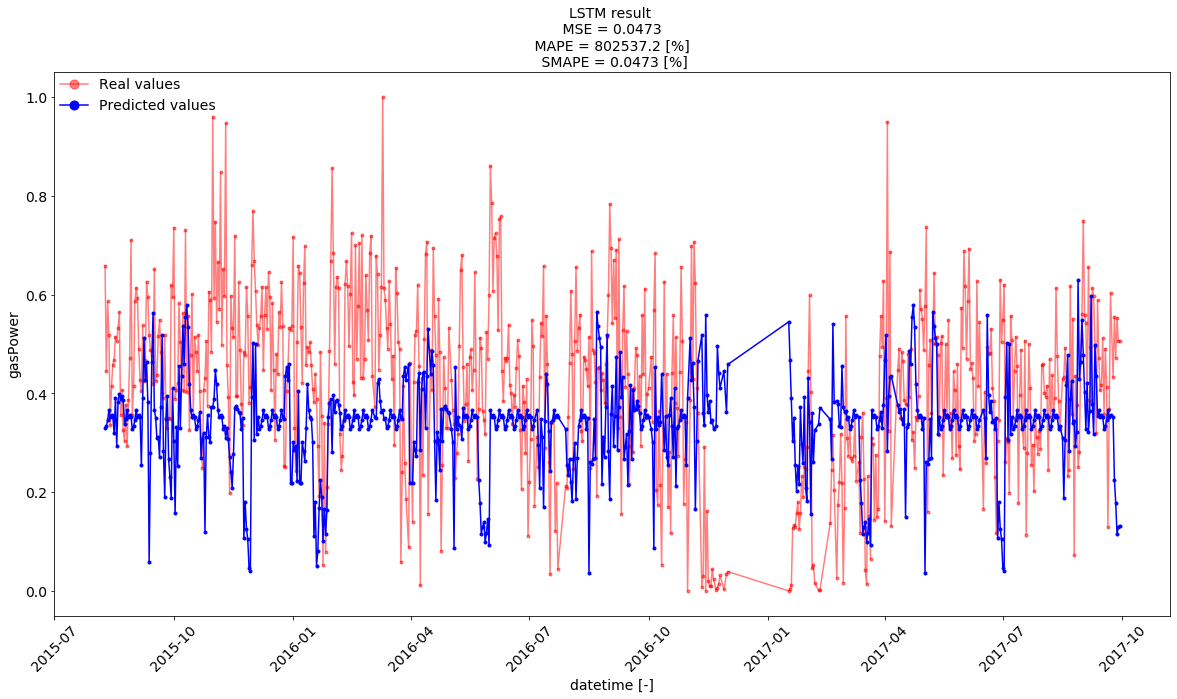

In [92]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result \n MSE = %.4f \n MAPE = %.1f [%%] \n SMAPE = %.4f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

697/697 [==============================] - ETA:  - ETA:  - ETA:  - 0s 516us/step
FINISHED


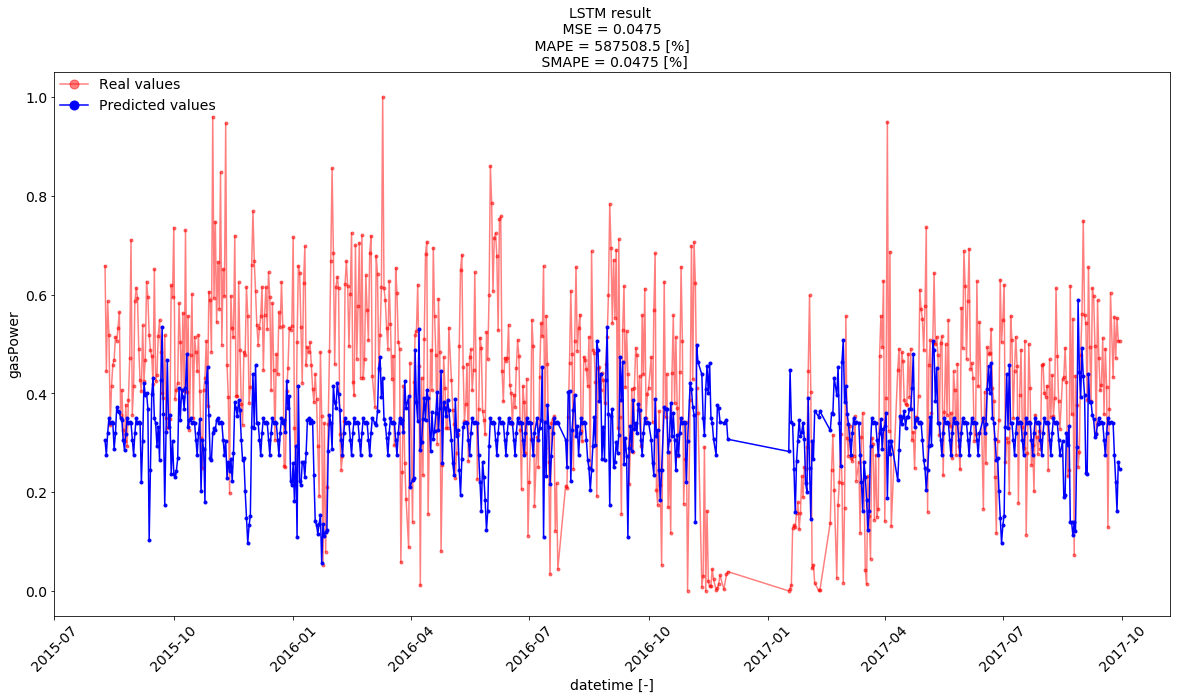

In [88]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result \n MSE = %.4f \n MAPE = %.1f [%%] \n SMAPE = %.4f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

In [64]:
def create_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, num_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.391))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.749))
    
    #3
    for _ in range(0):
        model.add(Dense(4, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.056))
    #3
    for _ in range(8):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.212))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.727))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.450))
        
    model.add(Dense(1))
    
    return model

In [65]:
epochs = 100
bs = 10
lr = 1e-5
print(bs)

10


In [66]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

model = create_model()

# compile & fit
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])

In [67]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay
        self.batch_since_restart = 0
        self.next_restart = cycle_length
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
            
    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

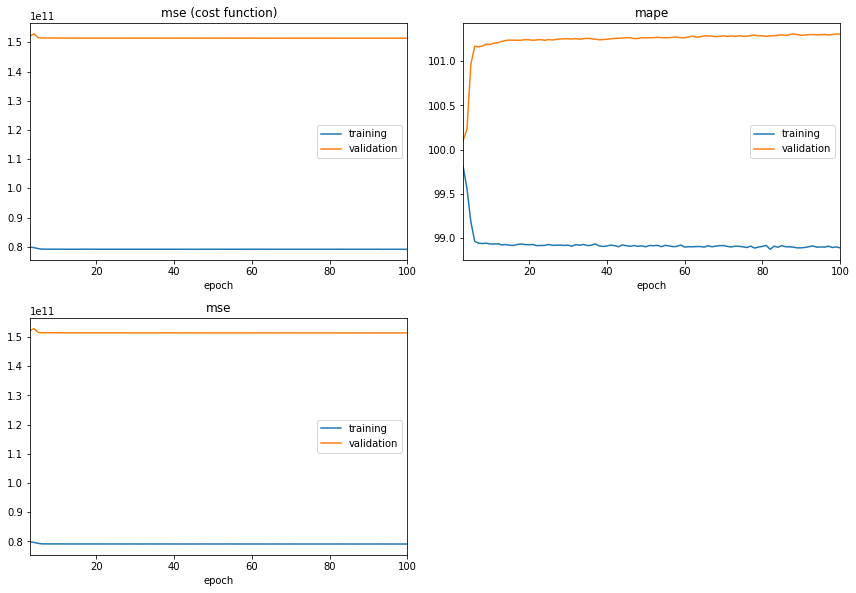

mse (cost function):
training   (min: 79125403862.344, max: 80015079619.569, cur: 79129355695.034)
validation (min: 151405964163.122, max: 152884557174.634, cur: 151407553660.878)

mape:
training   (min:   98.871, max:   99.993, cur:   98.887)
validation (min:   99.589, max:  101.310, cur:  101.308)

mse:
training   (min: 79125397504.000, max: 80015089664.000, cur: 79129346048.000)
validation (min: 151405969408.000, max: 152884559872.000, cur: 151407575040.000)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 4)             144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 4)             16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 4)             0         
__________________________________________________

In [68]:
early_stopping_monitor = EarlyStopping(patience=5000)

# This is used to save the best model, currently monitoring val_mape
# checkpoint

epoch_size = 10
schedule = SGDRScheduler(min_lr=1e-5, #1e-5
                                     max_lr=1e-2, # 1e-2
                                     steps_per_epoch=np.ceil(epoch_size/bs),
                                     lr_decay=0.01,
                                     cycle_length=5, # 5
                                     mult_factor=1.5)

model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_split=0.2,verbose=1, callbacks=[PlotLossesKeras(), early_stopping_monitor,schedule])
 
print(model.summary())

In [69]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:]

697/697 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 294us/step
FINISHED


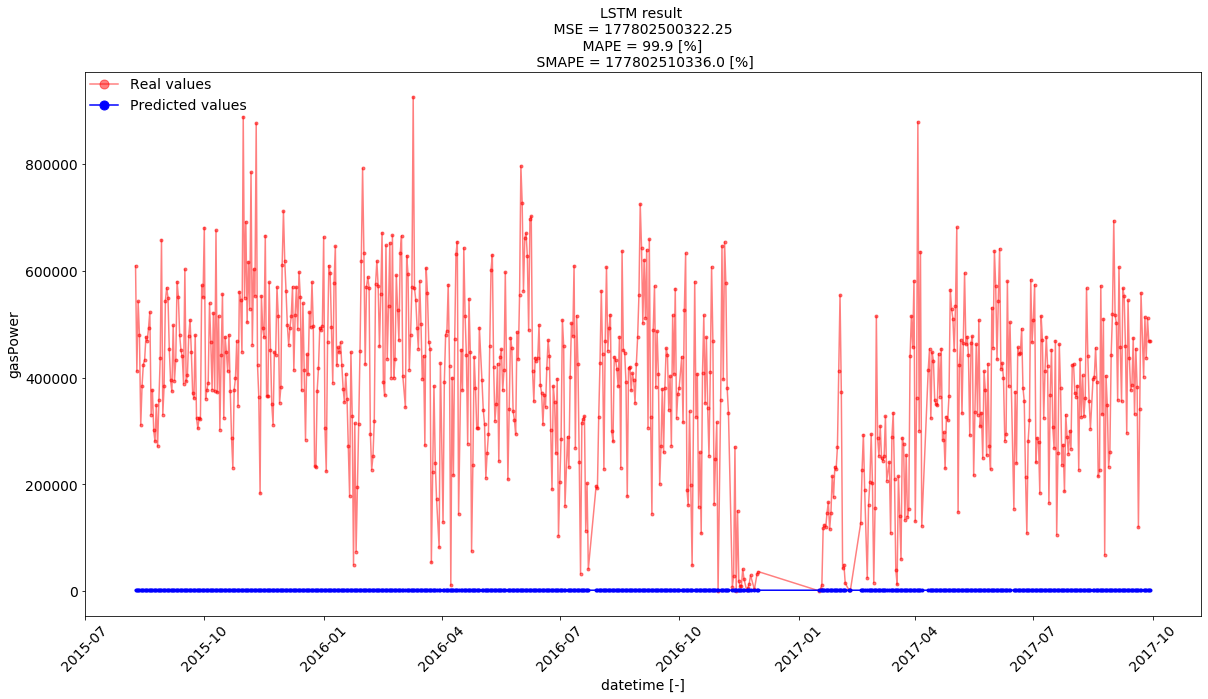

In [70]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')